In [1]:
import torch
print(torch.cuda.get_device_properties(0).total_memory)

15640231936


In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

import matplotlib.pyplot as plt


bucket_name = 'mountdata'
# Check if CUDA/GPU is available (optional but recommended for faster training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Aug_14_10:10:22_PDT_2024
Cuda compilation tools, release 12.6, V12.6.68
Build cuda_12.6.r12.6/compiler.34714021_0


In [3]:
print(torch.version.cuda)

12.1


In [2]:
import tifffile
import glob
import pandas as pd

/home/angelats11/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/angelats11/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
augment = False
filtered_columns = ['VH','VH_entropy', 'VH_stdDev','VV']
filtered_columns_coords = ['VH','VH_entropy', 'VH_stdDev','VV','latitude','longitude']

import geopandas as gpd
from shapely.geometry import Point

# Load the world shapefile
world = gpd.read_file('~/ne_110m_admin_0_countries.shp')

def get_country_name(lat, lon):
    point = Point(lon, lat)  # Create a point with (longitude, latitude)
    for _, row in world.iterrows():
        if row['geometry'].contains(point):
            return row['ADMIN']  # Change 'ADMIN' based on your shapefile's country name field
    return None


def preprocess_data_gcs_multi(bucket_name, prefix, region, domains=None):
    # Initialize lists to store images and labels
    images = []
    labels = []
    paths = []
    imagesCHM = []
    s1 = []

#    if domains is None:
#        domains = []

    countries = os.listdir(os.path.join(bucket_name,prefix))
    # Iterate through the blobs

    if region == 'all':
        print('all countries included')
    elif region == 'east':
        print('manualEast')
        countries = ['manualEast']
    elif region == 'west':
        print('manualWest')
        if 'forest' in prefix:
            countries = ['manualWest']
        else:
            countries = ['manualWest']
    elif region == 'central':
        print('manualCentral')
        countries = ['manualCentral']

    elif region == 'val':
        print('sdptv2')
        if 'forest' in prefix:
            countries = []
        else:
            countries = ['sdptmanual-v2']
        #    countries = ['oil','coco']

    elif region == 'testoil': 
        print('Descals oil')
        countries = ['Descalsoil']
    elif region == 'testcoco': 
        print('Descals coco')
        countries = ['Descalscoco']


    elif region == 'mango':
        print('CIV')
        if 'forest' in prefix:
            countries = []
        else:
            countries = ['CIV']
    elif region == 'cashew':
        print('benin')
        if 'forest' in prefix:
            countries = ['benin']
        else:
            countries = ['benin']

    elif region == 'Fagan':
        print('fagan data 1 & 2')
        countries = ['Fagan', 'Fagan-Val']


    if 'orchard' in prefix:
        label = 1  # Assign class 0 if 'orchard' is in the filename
        prefixCHM = orchardpathCHM
        prefixcsv = orchardpathcsv
    else:
        label = 0  # Assign class 1 otherwise
        prefixCHM = forestpathCHM
        prefixcsv = forestpathcsv
    
    for country in countries:
        pattern = os.path.join(bucket_name,prefixcsv,country+'*.csv')
        #print(pattern)
        matching_files = glob.glob(pattern)
        dfs = []
        for fpcsv in matching_files:
            df = pd.read_csv(fpcsv)
            dfs.append(df[filtered_columns_coords])
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df['latitude'] = combined_df['latitude'].astype(str).str.slice(0,14)
        combined_df['longitude'] = combined_df['longitude'].astype(str).str.slice(0,14)
        
        for blob in os.listdir(os.path.join(bucket_name,prefix,country)):
            #print(blob)
            fp = os.path.join(bucket_name,prefixCHM,country,blob[:-12]+'.tif')
            if os.path.exists(fp):
                # Read and preprocess the image
                with open(os.path.join(bucket_name,prefix,country,blob), 'rb') as f:
                    # Get the byte data of the image
                    img = tifffile.imread(f)
                    img = img[:40,:40]
                    img = img.astype('float32')
                    #print(img.shape)
                    # Append the preprocessed image and label to the lists
                    if img.shape == (40,40,24):
                        images.append(img)
                        labels.append(label)
                        paths.append(os.path.join(bucket_name, prefix, country, blob[:-12]+'.tif'))
                        with open(fp, 'rb') as f2:
                            # Get the byte data of the image
                            img_bytes2 = f2.read()
                            img2 = cv2.imdecode(np.frombuffer(img_bytes2, np.uint8), cv2.IMREAD_GRAYSCALE)
                            img2 = img2[10:234, 10:234]  # Clip to central 40x40 pixels
                    
                            # Normalize pixel values to range [0, 1]
                            img2 = img2.astype('float32')# / 255.0
                    
                            # Append the preprocessed image and label to the lists
                            imagesCHM.append(img2)

                            latlon = blob[:-12].split('_')
                            lat = latlon[2][:14]
                            lon = latlon[4][:14]
                            #print(lat, lon)
                            if domains is not None:
                                domains.append(get_country_name(lat,lon))
                            matching_entry = combined_df[(combined_df['latitude'] == lat) & (combined_df['longitude'] == lon)][filtered_columns]
                            if matching_entry.empty:
                                s1.append(pd.DataFrame({'VH': [0.0], 'VH_entropy':[0.0], 'VH_stdDev':[0.0],'VV':[0.0]}))
                            else:
                                s1.append(matching_entry.iloc[0])#.values.flatten())
                                #country_name = get_country(lat, lon)
                                #matching_entry['country'] = country_name  # Add country information
                                #print(s1)
                    else:
                        print('not 40x40',fp)


            else:
                print(fp)
    

    # Convert lists to numpy arrays
    images = np.array(images)
    imagesCHM = np.array(imagesCHM)
    labels = np.array(labels)

    return images, imagesCHM, s1, labels, paths


orchardpath = 's2NDVItsorchard-400m'
orchardpathCHM = 'chmorchard-224m'
orchardpathcsv = 's1orchard'
forestpath = 's2NDVItsforest-400m'
forestpathCHM = 'chmforest-224m'
forestpathcsv = 's1forest'


distshift = True

if not distshift:
    
    # Preprocess the data from GCS
    print('beginning the orchard data preprocessing')
    print(time.perf_counter())
    images, imagesCHM, imagesS1, labels, paths = preprocess_data_gcs_multi(bucket_name, orchardpath)
    
    print('finished the orchard data preprocessing')
    print(time.perf_counter())
    
    images2, imagesCHM2, imagesS12, labels2, paths2 = preprocess_data_gcs_multi(bucket_name, forestpath)
    
    print('finished the forest data preprocessing')
    print(time.perf_counter())


else:
    print('regional shifting')
    #for region in ['val', 'east', 'west', 'central']
    region = 'val'
    print('forest val processing ', region)
    print(time.perf_counter())
    domains_sdpt = []
    images2, imagesCHM2, imagesS12, labels2, paths2 = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_sdpt)

    print('beginning the orchard data preprocessing ', region)
    print(time.perf_counter())
    images, imagesCHM, imagesS1, labels, paths = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_sdpt)
    print('finished the orchard data preprocessing')
    print(time.perf_counter())

    region = 'east'
    domains_east = []
    imagese, imagesCHMe, imagesS1e, labelse, pathse = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_east)
    images2e, imagesCHM2e, imagesS12e, labels2e, paths2e = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_east)

    region = 'west'
    domains_west = []
    imagesw, imagesCHMw, imagesS1w, labelsw, pathsw = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_west)
    images2w, imagesCHM2w, imagesS12w, labels2w, paths2w = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_west)

    region = 'central'
    domains_cent = []
    images_c, imagesCHM_c, imagesS1c, labels_c, paths_c = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_cent)
    images2_c, imagesCHM2_c, imagesS12c, labels2_c, paths2_c = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_cent)

    print('finished all processing')
    print(time.perf_counter())


regional shifting
forest val processing  val
73527.029064638
sdptv2
beginning the orchard data preprocessing  val
73527.085539363
sdptv2


KeyboardInterrupt: 

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import tifffile
import cv2
import time
import geopandas as gpd
from shapely.geometry import Point

augment = False
filtered_columns = ['VH','VH_entropy', 'VH_stdDev','VV']
filtered_columns_coords = ['VH','VH_entropy', 'VH_stdDev','VV','latitude','longitude']


orchardpath = 's2NDVItsorchard-400m'
orchardpathCHM = 'chmorchard-224m'
orchardpathcsv = 's1orchard'
forestpath = 's2NDVItsforest-400m'
forestpathCHM = 'chmforest-224m'
forestpathcsv = 's1forest'


world = gpd.read_file('~/ne_110m_admin_0_countries.shp')

# Define the get_country_name function
def get_country_name(lat, lon):
    point = Point(lon, lat)  # Create a point with (longitude, latitude)
    for _, row in world.iterrows():
        if row['geometry'].contains(point):
            return row['ADMIN']  # Return the country name from the 'ADMIN' field
    return None

country_data = {}
def preprocess_data_gcs_multi(bucket_name, prefix, world, domains=None):
    # Initialize lists to store images and labels
    images = []
    labels = []
    paths = []
    imagesCHM = []
    s1 = []
    
    
    countries = os.listdir(os.path.join(bucket_name, prefix))
    
    if 'orchard' in prefix:
        label = 1  # Assign class 0 if 'orchard' is in the filename
        prefixCHM = orchardpathCHM
        prefixcsv = orchardpathcsv
    else:
        label = 0  # Assign class 1 otherwise
        prefixCHM = forestpathCHM
        prefixcsv = forestpathcsv
    
    for country in countries:
        pattern = os.path.join(bucket_name,prefixcsv,country+'*.csv')
        #print(pattern)
        matching_files = glob.glob(pattern)
        dfs = []
        for fpcsv in matching_files:
            df = pd.read_csv(fpcsv)
            dfs.append(df[filtered_columns_coords])
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df['latitude'] = combined_df['latitude'].astype(str).str.slice(0,14)
        combined_df['longitude'] = combined_df['longitude'].astype(str).str.slice(0,14)
        
        for blob in os.listdir(os.path.join(bucket_name,prefix,country)):
            #print(blob)
            fp = os.path.join(bucket_name,prefixCHM,country,blob[:-12]+'.tif')
            if os.path.exists(fp):
                # Read and preprocess the image
                with open(os.path.join(bucket_name,prefix,country,blob), 'rb') as f:
                    # Get the byte data of the image
                    img = tifffile.imread(f)
                    img = img[:40,:40]
                    img = img.astype('float32')
                    #print(img.shape)
                    # Append the preprocessed image and label to the lists
                    if img.shape == (40,40,24):
                        images.append(img)
                        labels.append(label)
                        paths.append(os.path.join(bucket_name, prefix, country, blob[:-12]+'.tif'))
                        with open(fp, 'rb') as f2:
                            # Get the byte data of the image
                            img_bytes2 = f2.read()
                            img2 = cv2.imdecode(np.frombuffer(img_bytes2, np.uint8), cv2.IMREAD_GRAYSCALE)
                            img2 = img2[10:234, 10:234]  # Clip to central 40x40 pixels
                    
                            # Normalize pixel values to range [0, 1]
                            img2 = img2.astype('float32')# / 255.0
                    
                            # Append the preprocessed image and label to the lists
                            imagesCHM.append(img2)

                            latlon = blob[:-12].split('_')
                            lat = latlon[2][:14]
                            lon = latlon[4][:14]
                            #print(lat, lon)
                            
                            country_name = get_country_name(lat, lon)
                            if country_name is not None:
                                # Add the data point to the respective country's data in country_data
                                if country_name not in country_data:
                                    country_data[country_name] = {
                                        'images': [],
                                        'labels': [],
                                        's1': [],
                                        'paths': [],
                                        'imagesCHM': []     
                                    }
                                        
                                matching_entry = combined_df[(combined_df['latitude'] == lat) & (combined_df['longitude'] == lon)][filtered_columns]
                                if matching_entry.empty:
                                    country_data[country_name]['images'].append(img)
                                    country_data[country_name]['labels'].append(label)  # Example label (can be customized)
                                    country_data[country_name]['paths'].append(fp)
                                    country_data[country_name]['imagesCHM'].append(img2)
                                    country_data[country_name]['s1'].append(pd.DataFrame({'VH': [0.0], 'VH_entropy':[0.0], 'VH_stdDev':[0.0], 'VV':[0.0]}))
    
                                else:
                                    country_data[country_name]['images'].append(img)
                                    country_data[country_name]['labels'].append(label)  # Example label (can be customized)
                                    country_data[country_name]['paths'].append(fp)
                                    country_data[country_name]['imagesCHM'].append(img2)                                
                                    country_data[country_name]['s1'].append(matching_entry.iloc[0])#.values.flatten())

                    else:
                        print('not 40x40',fp)

            else:
                print(fp)
    
    # After processing all countries, return the results organized by country
    return country_data

'''
region = 'val'
print('forest val processing ', region)
print(time.perf_counter())
domains_sdpt = []
images2, imagesCHM2, imagesS12, labels2, paths2 = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_sdpt)

print('beginning the orchard data preprocessing ', region)
print(time.perf_counter())
images, imagesCHM, imagesS1, labels, paths = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_sdpt)
print('finished the orchard data preprocessing')
print(time.perf_counter())

region = 'east'
domains_east = []
imagese, imagesCHMe, imagesS1e, labelse, pathse = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_east)
images2e, imagesCHM2e, imagesS12e, labels2e, paths2e = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_east)

region = 'west'
domains_west = []
imagesw, imagesCHMw, imagesS1w, labelsw, pathsw = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_west)
images2w, imagesCHM2w, imagesS12w, labels2w, paths2w = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_west)

region = 'central'
domains_cent = []
images_c, imagesCHM_c, imagesS1c, labels_c, paths_c = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_cent)
images2_c, imagesCHM2_c, imagesS12c, labels2_c, paths2_c = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_cent)
'''

print('starting orchards all')
preprocess_data_gcs_multi(bucket_name, orchardpath, world, domains=None)
print('starting forests all')
preprocess_data_gcs_multi(bucket_name, forestpath, world, domains=None)
print('finished all')

# Access images for a specific country (example)
for country_name, data in country_data.items():
    print(f"Country: {country_name}")
    print(f"Number of images: {len(data['images'])}")
    print(f"Sentinel-1 data: {len(data['s1'])}")

starting orchards all
mountdata/chmorchard-224m/Descalscoco/Image_Lat_10.837501759619093_Lon_-13.445835084428044.tif
mountdata/chmorchard-224m/Descalscoco/Image_Lat_4.187501667381544_Lon_9.412497917767288.tif
mountdata/chmorchard-224m/Descalscoco/Image_Lat_4.9958341290470525_Lon_7.379165673800177.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_-0.0027378880468157695_Lon_10.201134530079727.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_-0.02789167708930397_Lon_10.186401660199138.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_1.1072170870758788_Lon_19.79028865428138.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_2.2643404331419243_Lon_22.87124209974506.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_2.283920345867605_Lon_22.877979801436812.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_2.347703327336095_Lon_20.50292434823888.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_3.5566548049463416_Lon_10.09037045991213.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_

In [8]:
print(domains)


['Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the Congo', 'Democratic Republic of the

In [11]:
normalized_countries = [country.strip().title() for country in domains if country is not None]

unique_countries = set(normalized_countries)
print("Unique Countries:")
for count in sorted(unique_countries):  # Sorting for better readability
    print(count)

Unique Countries:
Angola
Cameroon
Central African Republic
Democratic Republic Of The Congo
Gabon
Gambia
Ghana
Guinea
Guinea-Bissau
Ivory Coast
Kenya
Liberia
Mali
Mauritania
Mozambique
Nigeria
Republic Of The Congo
Senegal
Sierra Leone
Somalia
United Republic Of Tanzania


In [4]:
for country_name, data in country_data.items():
    print(f"Country: {country_name}")

Country: Ivory Coast
Country: Mali
Country: Mozambique
Country: Kenya
Country: Democratic Republic of the Congo
Country: United Republic of Tanzania
Country: Gabon
Country: Cameroon
Country: Ghana
Country: Nigeria
Country: Liberia
Country: Benin
Country: Sierra Leone
Country: Togo
Country: Guinea
Country: Republic of the Congo
Country: Uganda
Country: Zimbabwe
Country: South Africa
Country: Rwanda
Country: Madagascar
Country: Central African Republic
Country: Angola
Country: Somalia
Country: Guinea-Bissau
Country: Senegal
Country: Gambia
Country: Mauritania
Country: Malawi
Country: Equatorial Guinea
Country: Zambia
Country: Namibia
Country: Botswana
Country: Burundi
Country: South Sudan
Country: Ethiopia
Country: Somaliland
Country: Sudan
Country: Burkina Faso
Country: Chad
Country: Djibouti
Country: Niger
Country: Yemen
Country: Eritrea
Country: Saudi Arabia
Country: Oman
Country: Algeria
Country: Libya
Country: Morocco
Country: Egypt
Country: Western Sahara
Country: United Arab Emira

In [10]:
for country_name, data in country_data.items():
    print(f"Country: {country_name}")
    print(f"Number of images: {len(data['images'])}")
    print(f"Sentinel-1 data: {len(data['s1'])}")

Country: Ivory Coast
Number of images: 5239
Sentinel-1 data: 5239
Country: Mali
Number of images: 858
Sentinel-1 data: 858
Country: Mozambique
Number of images: 760
Sentinel-1 data: 760
Country: Kenya
Number of images: 334
Sentinel-1 data: 334
Country: Democratic Republic of the Congo
Number of images: 1869
Sentinel-1 data: 1869
Country: United Republic of Tanzania
Number of images: 1118
Sentinel-1 data: 1118
Country: Gabon
Number of images: 277
Sentinel-1 data: 277
Country: Cameroon
Number of images: 1231
Sentinel-1 data: 1231
Country: Ghana
Number of images: 657
Sentinel-1 data: 657
Country: Nigeria
Number of images: 1020
Sentinel-1 data: 1020
Country: Liberia
Number of images: 822
Sentinel-1 data: 822
Country: Benin
Number of images: 14737
Sentinel-1 data: 14737
Country: Sierra Leone
Number of images: 794
Sentinel-1 data: 794
Country: Togo
Number of images: 93
Sentinel-1 data: 93
Country: Guinea
Number of images: 1481
Sentinel-1 data: 1481
Country: Republic of the Congo
Number of im

In [4]:
'''
print('EAST plt / forest')
print(len(imagese))
print(len(images2e))
print('WEST plt / forest')
print(len(imagesw))
print(len(images2w))
print('CENTRAL plt / forest')
print(len(images_c))
print(len(images2_c))
print('SDPT plt count')
print(len(images))
EAST plt / forest
528
1021
WEST plt / forest
13473
9745
CENTRAL plt / forest
458
1001
SDPT plt count
899
'''

"\nprint('EAST plt / forest')\nprint(len(imagese))\nprint(len(images2e))\nprint('WEST plt / forest')\nprint(len(imagesw))\nprint(len(images2w))\nprint('CENTRAL plt / forest')\nprint(len(images_c))\nprint(len(images2_c))\nprint('SDPT plt count')\nprint(len(images))\nEAST plt / forest\n528\n1021\nWEST plt / forest\n13473\n9745\nCENTRAL plt / forest\n458\n1001\nSDPT plt count\n899\n"

In [5]:
#7666 points unaugmented points total from Oil Palm, Coconut Palm, Releaf sampling, and SDPT Manual
#4056
#3610

#11494 points unaugmented points total from oil palm, coco, releaf, sdpt, benin, and ghana manual
#7817
#3677

In [5]:
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms

augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Ensure your images are converted to tensors
    # Add any other transformations as needed
])


class PairedImageDataset(Dataset):
    def __init__(self, grayscale_images, band24_images, s1_tabular, labels,paths,transform=transforms.ToTensor()):#augmentation_transforms):
        self.grayscale_images = grayscale_images
        self.band24_images = band24_images
        self.s1_tabular = s1_tabular
        self.labels = labels
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        grayscale_image = self.grayscale_images[idx]
        band24_image = self.band24_images[idx]
        tabular_features = self.s1_tabular[idx]
        label = self.labels[idx]
        path = self.paths[idx]

        # Convert images to PIL format if needed
        if isinstance(grayscale_image, torch.Tensor):
            grayscale_image = transforms.ToPILImage()(grayscale_image)
        if isinstance(band24_image, torch.Tensor):
            band24_image = transforms.ToPILImage()(band24_image)

        # Apply transformations if defined
        if self.transform:
            grayscale_image = self.transform(grayscale_image)
            band24_image = self.transform(band24_image)

        return grayscale_image, band24_image, tabular_features, label, path

    def concatenate(self, datasets):
        """
        Concatenates multiple PairedImageDatasets into a longer dataset.
        
        Args:
            datasets (list): List of PairedImageDataset instances to concatenate.
            
        Returns:
            PairedImageDataset: Concatenated dataset.
        """
        # Initialize concatenated data with the current dataset
        grayscale_images_concat = self.grayscale_images
        band24_images_concat = self.band24_images
        tabular_concat = self.s1_tabular
        labels_concat = self.labels
        paths_concat = self.paths

        # Iterate over each additional dataset and concatenate their data
        for dataset in datasets:
            grayscale_images_concat = torch.cat((grayscale_images_concat, dataset.grayscale_images), dim=0)
            band24_images_concat = torch.cat((band24_images_concat, dataset.band24_images), dim=0)
            tabular_concat = torch.cat((tabular_concat, dataset.s1_tabular), dim=0)
            labels_concat = np.concatenate((labels_concat, dataset.labels), axis=0)
            paths_concat = np.concatenate((paths_concat, dataset.paths), axis=0)

        # Create and return a new concatenated PairedImageDataset
        concatenated_dataset = PairedImageDataset(grayscale_images_concat, band24_images_concat, tabular_concat, labels_concat, paths_concat)

        return concatenated_dataset


In [6]:
africa_regions = {
    "Ivory Coast": "West",
    "Mali": "West",
    "Mozambique": "East",
    "Kenya": "East",
    "Democratic Republic of the Congo": "Central",
    "United Republic of Tanzania": "East",
    "Gabon": "Central",
    "Cameroon": "Central",
    "Ghana": "West",
    "Nigeria": "West",
    "Liberia": "West",
    "Benin": "West",
    "Sierra Leone": "West",
    "Togo": "West",
    "Guinea": "West",
    "Republic of the Congo": "Central",
    "Uganda": "East",
    "Zimbabwe": "South",
    "South Africa": "South",
    "Rwanda": "East",
    "Madagascar": "East",
    "Central African Republic": "Central",
    "Angola": "Central",
    "Somalia": "East",
    "Guinea-Bissau": "West",
    "Senegal": "West",
    "Gambia": "West",
    "Mauritania": "West",
    "Malawi": "East",
    "Equatorial Guinea": "Central",
    "Zambia": "East",
    "Namibia": "South",
    "Botswana": "South",
    "Burundi": "East",
    "South Sudan": "East",
    "Ethiopia": "East",
    "Somaliland": "East",
    "Sudan": "North",
    "Burkina Faso": "West",
    "Chad": "Central",
    "Djibouti": "East",
    "Niger": "West",
    "Yemen": "Middle East",  # Not part of Africa but included in the list
    "Eritrea": "East",
    "Saudi Arabia": "Middle East",  # Not part of Africa
    "Oman": "Middle East",  # Not part of Africa
    "Algeria": "North",
    "Libya": "North",
    "Morocco": "North",
    "Egypt": "North",
    "Western Sahara": "North",
    "United Arab Emirates": "Middle East"  # Not part of Africa
}

In [7]:


def to_numeric_array(data):
    if isinstance(data, pd.Series):
        # If it's a pandas Series, just convert to numpy array
        return data.values.astype(np.float32)  # Ensure it's a consistent numeric type
    elif isinstance(data, pd.DataFrame):
        return data.values.flatten()#values = [df.values.flatten() for df in imgsS1]
#        imgsS1e = np.array(values)
    elif isinstance(data, list):
        # If it's a list, convert to numpy array
        return np.array(data, dtype=np.float32)  # Convert list to NumPy array
    elif isinstance(data, np.ndarray):
        # If it's already a NumPy array, ensure it's of numeric type
        return data.astype(np.float32)  # Ensure NumPy array is of type float32
    else:
        # If it's not one of these, you may want to handle this case differently
        raise ValueError(f"Unsupported data type: {type(data)}")


train_test_splits = {}
# Function to split data into train and test sets for each country
def train_test_split_country_data(country_data, test_size=0.2, random_state=42):
    # Define a dictionary to hold train-test splits for each country

    train_test_splits = {}
    # Define common transforms (optional)
    transform = transforms.Compose([
        transforms.ToPILImage(),
    ])

    # Iterate through each country in the country_data dictionary
    for country_name, data in country_data.items():
        if len(data['images']) < 5:
            continue

        print(f"Processing country: {country_name}")

        # Extract images and labels
        imgs = np.array(data['images'])  # (N, H, W, C)
        imgsCHM = np.array(data['imagesCHM'])
        imgsS1 = np.array(data['s1'])

#        values = [df.values.flatten() for df in imgsS1]
#        imgsS1e = np.array(values)

        imgsS1e = np.array([to_numeric_array(entry) for entry in imgsS1])

        labs = np.array(data['labels'])  # (N,)
        pths = np.array(data['paths'])

        train_imagese, val_imagese, train_imagesCHMe, val_imagesCHMe, train_imagesS1e, val_imagesS1e,  train_labelse, val_labelse, train_pathse, val_pathse = train_test_split(imgs, imgsCHM, imgsS1e, labs, pths, test_size=0.2, random_state=42)

#        print(train_imagesS1e)
#        print(type(val_imagesS1e))
        train_images_tensore = torch.tensor(train_imagese.astype('float32')).permute(0, 3, 1, 2)
    
        channel_indices = [5, 11, 17, 23]
        train_images_tensore = train_images_tensore[:, channel_indices, :, :]
        
        train_labels_tensore = torch.tensor(train_labelse)
        
        val_images_tensore = torch.tensor(val_imagese).permute(0, 3, 1, 2) #.unsqueeze(1)  # Add a channel dimension
        val_images_tensore = val_images_tensore[:, channel_indices, :, :]
        
        train_imagesCHM_tensore = torch.tensor(train_imagesCHMe,dtype=torch.float32).unsqueeze(1).float()#.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
        val_imagesCHM_tensore = torch.tensor(val_imagesCHMe,dtype=torch.float32).unsqueeze(1).float()#.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
        
        train_imagesS1_tensore = torch.tensor(train_imagesS1e)
        val_imagesS1_tensore = torch.tensor(val_imagesS1e)
            
        # Use the custom dataset class
        train_datasete = PairedImageDataset(train_images_tensore, train_imagesCHM_tensore, train_imagesS1_tensore, train_labelse, train_pathse)
        val_datasete = PairedImageDataset(val_images_tensore, val_imagesCHM_tensore, val_imagesS1_tensore, val_labelse, val_pathse)
        train_loadere = DataLoader(train_datasete, batch_size=32, shuffle=True)
        val_loadere = DataLoader(val_datasete, batch_size=32)

        # Store the DataLoader instances in the dictionary
        train_test_splits[country_name] = {
            'train_loader': train_loadere,
            'val_loader': val_loadere
        }

    return train_test_splits

import torch
from sklearn.model_selection import train_test_split

# Modify to perform Leave-One-Domain-Out Cross Validation
def train_test_split_lodo(country_data, test_size=.2, random_state=42):
    # This will hold the split data for each LODO iteration
    lodo_splits = {}

    # Split the data into LODO sets (one for each country)
    countries = list(country_data.keys())
    
    for left_out_country in countries:
        print(f"Processing LODO fold: Excluding country {left_out_country}")

        # Initialize lists to store training data
        train_images, train_imagesCHM, train_imagesS1, train_labels, train_paths = [], [], [], [], []
        val_images, val_imagesCHM, val_imagesS1, val_labels, val_paths = [], [], [], [], []

        # Iterate through each country and create training/validation splits
        for country_name, data in country_data.items():
            if len(data['images']) < 20:
                continue
            if country_name == left_out_country:
                # This country will be the validation set
                val_imagese = np.array(data['images'])
                val_imagesCHMe = np.array(data['imagesCHM'])
                val_imagesS1e = np.array(data['s1'])
                val_imagesS1e = np.array([to_numeric_array(entry) for entry in val_imagesS1e])
                val_labelse = np.array(data['labels'])
                val_pathse = np.array(data['paths'])

                # Perform the train-test split (you can choose a different strategy if needed)
                #val_imagese, val_imagesCHMe, val_imagesS1e, val_labelse, val_pathse = train_test_split(
                #    imgs, imgsCHM, imgsS1e, labs, pths, test_size=test_size, random_state=random_state)

                # Convert to tensors (for validation set)
                val_images_tensore = torch.tensor(val_imagese.astype('float32')).permute(0, 3, 1, 2)
                channel_indices = [5, 11, 17, 23]
                val_images_tensore = val_images_tensore[:, channel_indices, :, :]

                val_imagesCHM_tensore = torch.tensor(val_imagesCHMe, dtype=torch.float32).unsqueeze(1).float()
                val_imagesS1_tensore = torch.tensor(val_imagesS1e)
                
                val_labels_tensore = torch.tensor(val_labelse)
                
                del val_imagese, val_imagesCHMe, val_imagesS1e, val_labelse
                
                # Store validation data for this fold
                val_loader = DataLoader(PairedImageDataset(val_images_tensore, val_imagesCHM_tensore, val_imagesS1_tensore, val_labels_tensore, val_pathse), batch_size=32)

                del val_images_tensore, val_imagesCHM_tensore, val_imagesS1_tensore, val_labels_tensore, val_pathse

            else:
                # Add to the training set
                imgs = np.array(data['images'])
                imgsCHM = np.array(data['imagesCHM'])
                imgsS1 = np.array(data['s1'])
                imgsS1e = np.array([to_numeric_array(entry) for entry in imgsS1])
                labs = np.array(data['labels'])
                pths = np.array(data['paths'])

                train_images.append(imgs)
                train_imagesCHM.append(imgsCHM)
                train_imagesS1.append(imgsS1e)
                train_labels.append(labs)
                train_paths.append(pths)

        # Now, convert the training data to tensors
        train_images = np.concatenate(train_images, axis=0)
        train_imagesCHM = np.concatenate(train_imagesCHM, axis=0)
        train_imagesS1 = np.concatenate(train_imagesS1, axis=0)
        train_labels = np.concatenate(train_labels, axis=0)
        train_paths = np.concatenate(train_paths, axis=0)

        # Convert to tensors (for training set)
        train_images_tensore = torch.tensor(train_images.astype('float32')).permute(0, 3, 1, 2)
        train_images_tensore = train_images_tensore[:, channel_indices, :, :]
        train_labels_tensore = torch.tensor(train_labels)
        
        train_imagesCHM_tensore = torch.tensor(train_imagesCHM, dtype=torch.float32).unsqueeze(1).float()
        train_imagesS1_tensore = torch.tensor(train_imagesS1)
        del train_images, train_imagesCHM, train_imagesS1, train_labels

        # Create DataLoader for training
        train_loader = DataLoader(PairedImageDataset(train_images_tensore, train_imagesCHM_tensore, train_imagesS1_tensore, train_labels_tensore, train_paths), batch_size=32, shuffle=True)
        del train_images_tensore, train_labels_tensore, train_imagesCHM_tensore, train_imagesS1_tensore, train_paths

        print(f"Training model excluding {left_out_country}...")
        f1 = trainNew(train_loader, val_loader, '')
        lodo_splits[left_out_country] = f1

        # Delete variables to free memory        
        del train_loader, val_loader
        # Add training data to lodo_splits
        #lodo_splits[left_out_country]['train_loader'] = train_loader
        print(f"Finished training for fold: {left_out_country}")

    return lodo_splits
    
#train_test_splits = train_test_split_country_data(country_data)


#train_test_splits = train_test_split_country_data(country_data)

In [39]:
print(train_test_splits)

{'Gabon': {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f164976ec10>, 'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f1649e7c0a0>}, 'Kenya': {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f16497fdd30>, 'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f16497fda60>}, 'Somalia': {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f16497fd730>, 'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f16497fdb80>}, 'Angola': {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f16497fd880>, 'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f16497fd2e0>}, 'United Republic of Tanzania': {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f1644601070>, 'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f1644601130>}, 'Mozambique': {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f1644601250>, '

In [8]:
from sklearn.metrics import confusion_matrix


In [9]:
import torch.nn.init as init
import gc
class MultiResNet(nn.Module):
    def __init__(self):
        super(MultiResNet, self).__init__()
        
        # First ResNet for grayscale images
        self.resnet_gray = models.resnet18(pretrained=True)
        self.resnet_gray.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Second ResNet for 24-band images
        self.resnet_24band = models.resnet18(pretrained=True)
        self.resnet_24band.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Get the number of features in the final layer
        num_features = self.resnet_gray.fc.in_features
        num_features24 = self.resnet_24band.fc.in_features

        # Fully connected layers for tabular data
        self.fc_tabular = nn.Linear(4, 32)  # 4 tabular features
        
        
        # Concatenate the features from both streams
        self.fc = nn.Linear(num_features + num_features24+32,1)# + 32, 1)  # Adjust the output size as needed
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

        #self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
        
    def forward(self, x_gray, x_24band, tabular_features):

        
        # Forward pass through the grayscale ResNet
        x_gray = self.resnet_gray.conv1(x_gray)
        x_gray = self.resnet_gray.bn1(x_gray)
        x_gray = self.resnet_gray.relu(x_gray)
        x_gray = self.resnet_gray.maxpool(x_gray)
        x_gray = self.resnet_gray.layer1(x_gray)
        x_gray = self.resnet_gray.layer2(x_gray)
        x_gray = self.resnet_gray.layer3(x_gray)
        x_gray = self.resnet_gray.layer4(x_gray)
        x_gray = self.resnet_gray.avgpool(x_gray)
        x_gray = torch.flatten(x_gray, 1)

        # Forward pass through the 24-band ResNet
        x_24band = self.resnet_24band.conv1(x_24band)
        x_24band = self.resnet_24band.bn1(x_24band)
        x_24band = self.resnet_24band.relu(x_24band)
        x_24band = self.resnet_24band.maxpool(x_24band)
        x_24band = self.resnet_24band.layer1(x_24band)
        x_24band = self.resnet_24band.layer2(x_24band)
        x_24band = self.resnet_24band.layer3(x_24band)
        x_24band = self.resnet_24band.layer4(x_24band)
        x_24band = self.resnet_24band.avgpool(x_24band)
        x_24band = torch.flatten(x_24band, 1)
 
        x3 = self.fc_tabular(tabular_features)
        x3 = x3[:x_gray.size(0)]
                
        # Concatenate the features from both streams
        x = torch.cat((x_gray, x_24band,x3),dim=1)#, x3), dim=1)
        # Classification head
        x = self.fc(x)

        
        x = self.sigmoid(x)
   
        return x

# Example usage
'''
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
'''



mode = 'resnet'
from sklearn.metrics import f1_score

def trainNew(train_loader,val_loader, modelpath, test_loaders=[]):
    #############
    #### TRIMODAL
    ##############
    trimod = True
    if mode == 'resnet':
        model = MultiResNet()
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

    model.train()

    print('training start')
    trn_acc_list = []
    val_acc_list = []
    trn_loss_list = []
    val_loss_list = []
    all_predictions = []
    all_labels = []
    
    # Train the model

    num_epochs = 20
    for epoch in range(num_epochs):
    
        model.train()
        correct = 0
        total = 0
        train_loss = 0.0
    
        for inputs, inputsCHM, s1, labs, paths in train_loader:

            inputs = inputs.to("cuda")
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()
            
            #if torch.isnan(inputs).any() or torch.isnan(inputsCHM).any() or torch.isnan(s1).any() or torch.isnan(labs).any():
            nan_indices = torch.isnan(s1)
            if nan_indices.any():
            #if torch.isnan(s1).any():
                print("Skipping batch due to NaNs.")
                continue
            '''
            has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
            # Filter inputs to exclude those with NaNs
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            inputsCHM = inputsCHM[~has_nan_anywhere]
            s1 = s1[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            '''

                    
            for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
                channel_data = inputs[:, c, :, :]
                mask = torch.isnan(channel_data)
                mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
                
                channel_data[mask] = mean_val.expand_as(channel_data)[mask]
                inputs[:, c, :, :] = channel_data
            if torch.isnan(inputs).any():
                raise ValueError("NaNs found in inputs after interpolation")
        
            # Check for NaNs in inputsCHM and labs
            if torch.isnan(inputsCHM).any():
                raise ValueError("NaNs found in inputsCHM")

            if torch.isnan(s1).any():
                print(torch.isnan(s1))
                print("NaNs found in S1!")
        
            if torch.isnan(labs).any():
                raise ValueError("NaNs found in labs")
            
            optimizer.zero_grad()
            if trimod:
                outputs = model(inputsCHM,inputs,s1)
            else:
                outputs = model(inputsCHM,inputs[:, :3, :, :])
            if torch.isnan(outputs).any():
                print(f"Inputs: {inputs[0][0]}")
                print(f"Model outputs: {outputs}")
                raise ValueError("NaNs found in model outputs")
    
            loss = criterion(outputs, labs.float())
            if torch.isnan(loss).any():
                raise ValueError("NaNs found in loss")
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        trn_acc_list.append(correct/total * 100)
        trn_loss_list.append(train_loss/len(train_loader.dataset))
    
        #if epoch == 19: 
        #    torch.save(model.state_dict(), modelpath)
    
    
        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in val_loader:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = inputsCHM.to("cuda")
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                if trimod:
                    outputs = model(inputsCHM,inputs,s1)
                else:
                    outputs = model(inputsCHM,inputs[:, :3, :, :])
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
            val_acc_list.append(correct/total * 100)
            val_loss_list.append(val_loss / len(val_loader.dataset))
    
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
              f'Train Acc: {trn_acc_list[-1]:.4f}, '
              #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
              f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )
    
    #plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions, correct, total)
    ff = f1_score(all_labels, all_predictions, average='weighted')  # or 'macro', 'micro'
    print(ff)
    print_cm(all_labels,all_predictions)
    
    for tl in test_loaders:
        print(tl)
         # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in tl:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = triplicate_channel(inputsCHM.to("cuda"))
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                if trimod:
                    outputs = model(inputsCHM,inputs,s1)
                else:
                    outputs = model(inputsCHM,inputs[:, :3, :, :])
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())

        f1 = f1_score(all_labels, all_predictions, average='weighted')  # or 'macro', 'micro', depending on your needs
        ff =  f1
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Val Loss: {val_loss/len(tl.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}',
              f'F1 score: {f1:.4f}')
        print_cm(all_labels,all_predictions)

    model = None
    torch.cuda.empty_cache()    
    gc.collect()
    return ff #model#, all_labels, all_predictions

def print_cm(all_predictions,all_labels):
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):
        tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
    
    # Extract true positives, negatives, false positives, and negatives
    #tn, fp, fn, tp = cm.ravel()
    
    # Calculate Precision, Recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    # Print results (you can modify this for your needs)
    print(f"Confusion Matrix:\n {cm}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return precision


f1lodo = train_test_split_lodo(country_data)

Processing LODO fold: Excluding country Ivory Coast


/tmp/ipykernel_1251/1394111261.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])
/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Ivory Coast...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])
/tmp/ipykernel_1251/1394111261.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Training model excluding Mali...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Mozambique...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])
/tmp/ipykernel_1251/1394111261.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Training model excluding Nigeria...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])
/tmp/ipykernel_1251/1394111261.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Training model excluding Liberia...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])
/tmp/ipykernel_1251/1394111261.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Training model excluding Benin...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.6027, Train Acc: 78.5128, Val Loss: nan, Val Acc: 57.29
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.5857, Train Acc: 82.2763, Val Loss: nan, Val Acc: 58.77
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.5795, Train Acc: 83.5362, Val Loss: nan, Val Acc: 57.79
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.5726, Train Acc: 85.3000, Val Loss: nan, Val Acc: 59.80
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.5680, Train Acc: 86.5008, Val Loss: nan, Val Acc: 59.69
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.5631, Train Acc: 87.6320, Val Loss: nan, Val 

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])
/tmp/ipykernel_1251/1394111261.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Training model excluding Sierra Leone...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Togo...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Guinea...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])
/tmp/ipykernel_1251/1394111261.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Training model excluding Republic of the Congo...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Uganda...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Zimbabwe...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding South Africa...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Rwanda...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Madagascar...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Central African Republic...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Angola...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Somalia...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Guinea-Bissau...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Senegal...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Gambia...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Mauritania...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Malawi...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Equatorial Guinea...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: Equatorial Guinea
Processing LODO fold: Excluding country Zambia


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Zambia...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: Zambia
Processing LODO fold: Excluding country Namibia


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Namibia...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Botswana...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: Botswana
Processing LODO fold: Excluding country Burundi


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Burundi...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: Burundi
Processing LODO fold: Excluding country South Sudan


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding South Sudan...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: South Sudan
Processing LODO fold: Excluding country Ethiopia


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Ethiopia...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: Ethiopia
Processing LODO fold: Excluding country Somaliland


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Somaliland...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: Somaliland
Processing LODO fold: Excluding country Sudan


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Sudan...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: Sudan
Processing LODO fold: Excluding country Burkina Faso


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Burkina Faso...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: Burkina Faso
Processing LODO fold: Excluding country Chad


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Chad...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/3179272936.py:316: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


Finished training for fold: Chad
Processing LODO fold: Excluding country Djibouti


/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Djibouti...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Niger...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Yemen...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Eritrea...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Saudi Arabia...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Oman...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Algeria...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Libya...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Morocco...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Egypt...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Western Sahara...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/tmp/ipykernel_1251/1394111261.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding United Arab Emirates...


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

In [10]:
import pickle 

with open('saved_f1LODO.pkl', 'wb') as f:
    pickle.dump(f1lodo, f)

In [ ]:
f1lodo = train_test_split_lodo(country_data)

Processing LODO fold: Excluding country Ivory Coast


/tmp/ipykernel_11957/2608501783.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])
/tmp/ipykernel_11957/2608501783.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])


Training model excluding Ivory Coast...
training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to

/tmp/ipykernel_11957/2608501783.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgsS1 = np.array(data['s1'])
/tmp/ipykernel_11957/2608501783.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


NameError: name 'sorted_sample_counts' is not defined

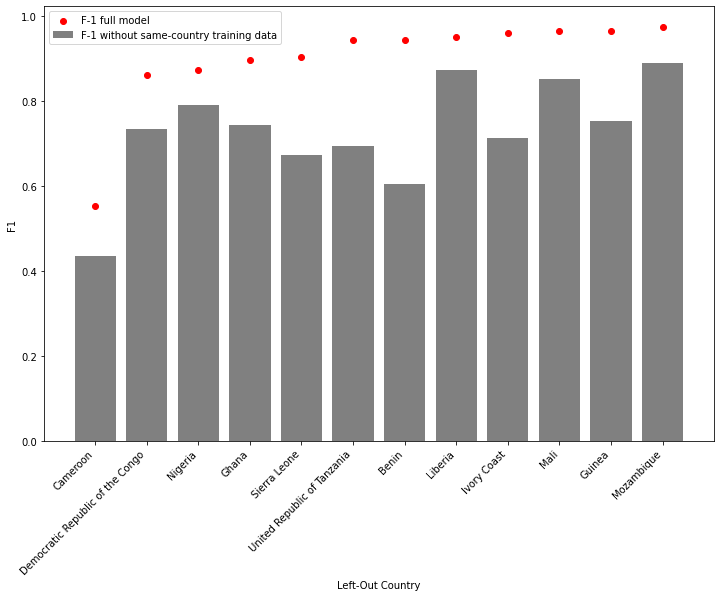

In [25]:
with open('saved_f1LODO.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
    # Step 1: Count the number of samples in train_loader for each country
    country_sample_counts = {}
    
    for country_name, data in train_test_splits.items():
        # Count the number of samples in the 'train_loader' for each country
        sample_count = len(data['train_loader'].dataset)
        country_sample_counts[country_name] = sample_count
    
    # Step 2: Sort countries by number of samples (increasing order)
    sorted_countries = sorted(iid_splits, key=iid_splits.get)
    
    # Step 3: Prepare the data for plotting
    sorted_f1_scores = [loaded_dict[country] for country in sorted_countries]
#    sorted_sample_counts = [country_sample_counts[country] for country in sorted_countries]
    sorted_baseprecision = [iid_splits[country] for country in sorted_countries]
    
    # Step 4: Create the bar plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Bar plot of f1-scores, ordered by sample count
    ax.bar(sorted_countries, sorted_f1_scores, color='gray',label='F-1 without same-country training data')
    ax.scatter(sorted_countries, sorted_baseprecision, color='red',label='F-1 full model')
    
    # Add labels and title
    ax.set_xlabel('Left-Out Country')
    ax.set_ylabel('F1')
    #ax.set_title('F1 for Left-Out Country')
    ax.legend()
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Optional: Add sample count as annotations
    for i, (country, sample_count) in enumerate(zip(sorted_countries, sorted_sample_counts)):
        ax.text(i, sorted_f1_scores[i] + 0.01, f"{sample_count}", ha='center', va='bottom', fontsize=9)


In [21]:
trimod = True
def train_test_split_iid(country_data, test_size=.2, random_state=42, modelpath = 'manual-FULL-trimodal.pt'):
    # This will hold the split data for each LODO iteration
    iid_splits = {}
    iid_prec = {}

    # Split the data into LODO sets (one for each country)
    countries = list(country_data.keys())

    model = MultiResNet()
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model.load_state_dict(torch.load(modelpath))
    model.eval()
    
    for left_out_country in countries:
        print(f"Processing LODO fold: Excluding country {left_out_country}")

        # Initialize lists to store training data
        train_images, train_imagesCHM, train_imagesS1, train_labels, train_paths = [], [], [], [], []
        val_images, val_imagesCHM, val_imagesS1, val_labels, val_paths = [], [], [], [], []
        rgn = africa_regions[left_out_country]
        # Iterate through each country and create training/validation splits
        for country_name, data in country_data.items():
            if len(data['images']) < 500:
                continue
            if country_name == left_out_country:
                # This country will be the validation set
                val_imagese = np.array(data['images'])
                val_imagesCHMe = np.array(data['imagesCHM'])
                val_imagesS1e = np.array(data['s1'])
                val_imagesS1e = np.array([to_numeric_array(entry) for entry in val_imagesS1e])
                val_labelse = np.array(data['labels'])
                val_pathse = np.array(data['paths'])

                # Perform the train-test split (you can choose a different strategy if needed)
                #val_imagese, val_imagesCHMe, val_imagesS1e, val_labelse, val_pathse = train_test_split(
                #    imgs, imgsCHM, imgsS1e, labs, pths, test_size=test_size, random_state=random_state)

                # Convert to tensors (for validation set)
                val_images_tensore = torch.tensor(val_imagese.astype('float32')).permute(0, 3, 1, 2)
                channel_indices = [5, 11, 17, 23]
                val_images_tensore = val_images_tensore[:, channel_indices, :, :]

                val_imagesCHM_tensore = torch.tensor(val_imagesCHMe, dtype=torch.float32).unsqueeze(1).float()
                val_imagesS1_tensore = torch.tensor(val_imagesS1e)
                
                val_labels_tensore = torch.tensor(val_labelse)
                
                del val_imagese, val_imagesCHMe, val_imagesS1e, val_labelse
                
                # Store validation data for this fold
                val_loader = DataLoader(PairedImageDataset(val_images_tensore, val_imagesCHM_tensore, val_imagesS1_tensore, val_labels_tensore, val_pathse), batch_size=32)

                del val_images_tensore, val_imagesCHM_tensore, val_imagesS1_tensore, val_labels_tensore, val_pathse

            
                trn_acc_list = []
                val_acc_list = []
                trn_loss_list = []
                val_loss_list = []
                all_predictions = []
                all_labels = []
                
            
                val_loss = 0.0
                correct = 0
                total = 0
                
                with torch.no_grad():
                    
                    for inputs, inputsCHM, s1, labs, paths in val_loader:
            
                        inputs= inputs.to("cuda")
                        
                        inputsCHM = inputsCHM.to("cuda")
                        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                        s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)
            
                        has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                        # Filter inputs to exclude those with NaNs
                        has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
                
                        inputs = inputs[~has_nan_anywhere]
                        inputsCHM = inputsCHM[~has_nan_anywhere]
                        labs = labs[~has_nan_anywhere]
                        
                        if trimod:
                            outputs = model(inputsCHM,inputs,s1)
                        else:
                            outputs = model(inputsCHM,inputs[:, :3, :, :])
                        loss = criterion(outputs, labs.float())
                        val_loss += loss.item() * inputs.size(0)
                        predicted = (outputs > 0.5).float()
                        total += labs.size(0)
                        correct += (predicted == labs).sum().item()
                        all_predictions.extend(predicted.cpu().numpy())
                        all_labels.extend(labs.cpu().numpy())
                    val_acc_list.append(correct/total * 100)
                    val_loss_list.append(val_loss / len(val_loader.dataset))
            
                print(f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
                      f'Val Acc: {(correct/total)*100:.2f}' )
            
                #plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions, correct, total)
                ff = f1_score(all_labels, all_predictions, average='weighted')
                precis = print_cm(all_labels,all_predictions)
        
                iid_splits[left_out_country] = ff
                iid_prec[left_out_country] = precis
               
                del val_loader
                print(f"Finished training for fold: {left_out_country}")

    return iid_splits, iid_prec
    
iid_splits, iid_prec = train_test_split_iid(country_data)

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1251/1479499595.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md

Processing LODO fold: Excluding country Ivory Coast


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: 0.3685, Val Acc: 95.78
Confusion Matrix:
 [[ 516  207]
 [  14 4502]]
True Positives: 4502
False Positives: 207
True Negatives: 516
False Negatives: 14
Precision: 0.9560
Recall: 0.9969
Finished training for fold: Ivory Coast
Processing LODO fold: Excluding country Mali


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: 0.5460, Val Acc: 96.39
Confusion Matrix:
 [[465  12]
 [ 19 362]]
True Positives: 362
False Positives: 12
True Negatives: 465
False Negatives: 19
Precision: 0.9679
Recall: 0.9501
Finished training for fold: Mali
Processing LODO fold: Excluding country Mozambique
Val Loss: 0.6634, Val Acc: 97.37
Confusion Matrix:
 [[666  11]
 [  9  74]]
True Positives: 74
False Positives: 11
True Negatives: 666
False Negatives: 9
Precision: 0.8706
Recall: 0.8916
Finished training for fold: Mozambique
Processing LODO fold: Excluding country Kenya
Processing LODO fold: Excluding country Democratic Republic of the Congo


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: nan, Val Acc: 87.00
Confusion Matrix:
 [[1198  233]
 [  10  428]]
True Positives: 428
False Positives: 233
True Negatives: 1198
False Negatives: 10
Precision: 0.6475
Recall: 0.9772
Finished training for fold: Democratic Republic of the Congo
Processing LODO fold: Excluding country United Republic of Tanzania


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: 0.5832, Val Acc: 94.28
Confusion Matrix:
 [[701  45]
 [ 19 353]]
True Positives: 353
False Positives: 45
True Negatives: 701
False Negatives: 19
Precision: 0.8869
Recall: 0.9489
Finished training for fold: United Republic of Tanzania
Processing LODO fold: Excluding country Gabon
Processing LODO fold: Excluding country Cameroon


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: 0.6176, Val Acc: 58.25
Confusion Matrix:
 [[465 506]
 [  8 252]]
True Positives: 252
False Positives: 506
True Negatives: 465
False Negatives: 8
Precision: 0.3325
Recall: 0.9692
Finished training for fold: Cameroon
Processing LODO fold: Excluding country Ghana


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: 0.6366, Val Acc: 90.26
Confusion Matrix:
 [[484  56]
 [  8 109]]
True Positives: 109
False Positives: 56
True Negatives: 484
False Negatives: 8
Precision: 0.6606
Recall: 0.9316
Finished training for fold: Ghana
Processing LODO fold: Excluding country Nigeria


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: 0.6585, Val Acc: 88.53
Confusion Matrix:
 [[791 105]
 [ 12 112]]
True Positives: 112
False Positives: 105
True Negatives: 791
False Negatives: 12
Precision: 0.5161
Recall: 0.9032
Finished training for fold: Nigeria
Processing LODO fold: Excluding country Liberia


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: 0.6475, Val Acc: 95.26
Confusion Matrix:
 [[677  34]
 [  5 106]]
True Positives: 106
False Positives: 34
True Negatives: 677
False Negatives: 5
Precision: 0.7571
Recall: 0.9550
Finished training for fold: Liberia
Processing LODO fold: Excluding country Benin


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: nan, Val Acc: 94.38
Confusion Matrix:
 [[7149  551]
 [ 277 6760]]
True Positives: 6760
False Positives: 551
True Negatives: 7149
False Negatives: 277
Precision: 0.9246
Recall: 0.9606
Finished training for fold: Benin
Processing LODO fold: Excluding country Sierra Leone


/tmp/ipykernel_1251/1479499595.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_imagesS1e = np.array(data['s1'])


Val Loss: 0.5398, Val Acc: 90.30
Confusion Matrix:
 [[390  72]
 [  5 327]]
True Positives: 327
False Positives: 72
True Negatives: 390
False Negatives: 5
Precision: 0.8195
Recall: 0.9849
Finished training for fold: Sierra Leone
Processing LODO fold: Excluding country Togo
Processing LODO fold: Excluding country Guinea
Val Loss: 0.5803, Val Acc: 96.42
Confusion Matrix:
 [[927  16]
 [ 37 501]]
True Positives: 501
False Positives: 16
True Negatives: 927
False Negatives: 37
Precision: 0.9691
Recall: 0.9312
Finished training for fold: Guinea
Processing LODO fold: Excluding country Republic of the Congo
Processing LODO fold: Excluding country Uganda
Processing LODO fold: Excluding country Zimbabwe
Processing LODO fold: Excluding country South Africa
Processing LODO fold: Excluding country Rwanda
Processing LODO fold: Excluding country Madagascar
Processing LODO fold: Excluding country Central African Republic
Processing LODO fold: Excluding country Angola
Processing LODO fold: Excluding coun

In [11]:
def trainNew(train_loader,val_loader, modelpath, test_loaders=[]):
    #############
    #### TRIMODAL
    ##############
    trimod = True
    if mode == 'resnet':
        model = MultiResNet()
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

    model.train()

    print('training start')
    trn_acc_list = []
    val_acc_list = []
    trn_loss_list = []
    val_loss_list = []
    all_predictions = []
    all_labels = []
    
    # Train the model

    num_epochs = 20
    for epoch in range(num_epochs):
    
        model.train()
        correct = 0
        total = 0
        train_loss = 0.0
    
        for inputs, inputsCHM, s1, labs, paths in train_loader:

            inputs = inputs.to("cuda")
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()
            
            #if torch.isnan(inputs).any() or torch.isnan(inputsCHM).any() or torch.isnan(s1).any() or torch.isnan(labs).any():
            nan_indices = torch.isnan(s1)
            if nan_indices.any():
            #if torch.isnan(s1).any():
                print("Skipping batch due to NaNs.")
                continue
            '''
            has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
            # Filter inputs to exclude those with NaNs
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            inputsCHM = inputsCHM[~has_nan_anywhere]
            s1 = s1[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            '''

                    
            for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
                channel_data = inputs[:, c, :, :]
                mask = torch.isnan(channel_data)
                mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
                
                channel_data[mask] = mean_val.expand_as(channel_data)[mask]
                inputs[:, c, :, :] = channel_data
            if torch.isnan(inputs).any():
                raise ValueError("NaNs found in inputs after interpolation")
        
            # Check for NaNs in inputsCHM and labs
            if torch.isnan(inputsCHM).any():
                raise ValueError("NaNs found in inputsCHM")

            if torch.isnan(s1).any():
                print(torch.isnan(s1))
                print("NaNs found in S1!")
        
            if torch.isnan(labs).any():
                raise ValueError("NaNs found in labs")
            
            optimizer.zero_grad()
            if trimod:
                outputs = model(inputsCHM,inputs,s1)
            else:
                outputs = model(inputsCHM,inputs[:, :3, :, :])
            if torch.isnan(outputs).any():
                print(f"Inputs: {inputs[0][0]}")
                print(f"Model outputs: {outputs}")
                raise ValueError("NaNs found in model outputs")
    
            loss = criterion(outputs, labs.float())
            if torch.isnan(loss).any():
                raise ValueError("NaNs found in loss")
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        trn_acc_list.append(correct/total * 100)
        trn_loss_list.append(train_loss/len(train_loader.dataset))
    
        #if epoch == 19: 
        #    torch.save(model.state_dict(), modelpath)
    
    
        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in val_loader:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = inputsCHM.to("cuda")
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                if trimod:
                    outputs = model(inputsCHM,inputs,s1)
                else:
                    outputs = model(inputsCHM,inputs[:, :3, :, :])
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
            val_acc_list.append(correct/total * 100)
            val_loss_list.append(val_loss / len(val_loader.dataset))
    
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
              f'Train Acc: {trn_acc_list[-1]:.4f}, '
              #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
              f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )
    
    #plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions, correct, total)
    ff = f1_score(all_labels, all_predictions, average='weighted')  # or 'macro', 'micro'
    print(ff)
    prec = print_cm(all_labels,all_predictions)
    
    model = None
    torch.cuda.empty_cache()    
    gc.collect()
    return ff, prec #model#, all_labels, all_predictions
# Modify to perform Leave-One-Domain-Out Cross Validation
def train_test_split_regional_lodo(country_data, test_size=.2, random_state=42):
    # This will hold the split data for each LODO iteration
    lodo_splits = {}
    lodo_prec = {}

    # Split the data into LODO sets (one for each country)
    countries = list(country_data.keys())
    
    for left_out_country in countries:
        print(f"Processing LODO fold: Excluding country {left_out_country}")

        # Initialize lists to store training data
        train_images, train_imagesCHM, train_imagesS1, train_labels, train_paths = [], [], [], [], []
        val_images, val_imagesCHM, val_imagesS1, val_labels, val_paths = [], [], [], [], []
        rgn = africa_regions(left_out_country)
        # Iterate through each country and create training/validation splits
        for country_name, data in country_data.items():
            if len(data['images']) < 500:
                continue
            if country_name == left_out_country:
                # This country will be the validation set
                val_imagese = np.array(data['images'])
                val_imagesCHMe = np.array(data['imagesCHM'])
                val_imagesS1e = np.array(data['s1'])
                val_imagesS1e = np.array([to_numeric_array(entry) for entry in val_imagesS1e])
                val_labelse = np.array(data['labels'])
                val_pathse = np.array(data['paths'])

                # Perform the train-test split (you can choose a different strategy if needed)
                #val_imagese, val_imagesCHMe, val_imagesS1e, val_labelse, val_pathse = train_test_split(
                #    imgs, imgsCHM, imgsS1e, labs, pths, test_size=test_size, random_state=random_state)

                # Convert to tensors (for validation set)
                val_images_tensore = torch.tensor(val_imagese.astype('float32')).permute(0, 3, 1, 2)
                channel_indices = [5, 11, 17, 23]
                val_images_tensore = val_images_tensore[:, channel_indices, :, :]

                val_imagesCHM_tensore = torch.tensor(val_imagesCHMe, dtype=torch.float32).unsqueeze(1).float()
                val_imagesS1_tensore = torch.tensor(val_imagesS1e)
                
                val_labels_tensore = torch.tensor(val_labelse)
                
                del val_imagese, val_imagesCHMe, val_imagesS1e, val_labelse
                
                # Store validation data for this fold
                val_loader = DataLoader(PairedImageDataset(val_images_tensore, val_imagesCHM_tensore, val_imagesS1_tensore, val_labels_tensore, val_pathse), batch_size=32)

                del val_images_tensore, val_imagesCHM_tensore, val_imagesS1_tensore, val_labels_tensore, val_pathse

            else:
                if africa_countries[country_name] == rgn:
                    # Add to the training set
                    imgs = np.array(data['images'])
                    imgsCHM = np.array(data['imagesCHM'])
                    imgsS1 = np.array(data['s1'])
                    imgsS1e = np.array([to_numeric_array(entry) for entry in imgsS1])
                    labs = np.array(data['labels'])
                    pths = np.array(data['paths'])
    
                    train_images.append(imgs)
                    train_imagesCHM.append(imgsCHM)
                    train_imagesS1.append(imgsS1e)
                    train_labels.append(labs)
                    train_paths.append(pths)

        # Now, convert the training data to tensors
        train_images = np.concatenate(train_images, axis=0)
        train_imagesCHM = np.concatenate(train_imagesCHM, axis=0)
        train_imagesS1 = np.concatenate(train_imagesS1, axis=0)
        train_labels = np.concatenate(train_labels, axis=0)
        train_paths = np.concatenate(train_paths, axis=0)

        # Convert to tensors (for training set)
        train_images_tensore = torch.tensor(train_images.astype('float32')).permute(0, 3, 1, 2)
        train_images_tensore = train_images_tensore[:, channel_indices, :, :]
        train_labels_tensore = torch.tensor(train_labels)
        
        train_imagesCHM_tensore = torch.tensor(train_imagesCHM, dtype=torch.float32).unsqueeze(1).float()
        train_imagesS1_tensore = torch.tensor(train_imagesS1)
        del train_images, train_imagesCHM, train_imagesS1, train_labels

        # Create DataLoader for training
        train_loader = DataLoader(PairedImageDataset(train_images_tensore, train_imagesCHM_tensore, train_imagesS1_tensore, train_labels_tensore, train_paths), batch_size=32, shuffle=True)
        del train_images_tensore, train_labels_tensore, train_imagesCHM_tensore, train_imagesS1_tensore, train_paths

        print(f"Training model excluding {left_out_country}...")
        f1, precis = trainNew(train_loader, val_loader, '')
        lodo_splits[left_out_country] = f1
        lodo_prec[left_out_country] = precis

        # Delete variables to free memory        
        del train_loader, val_loader
        # Add training data to lodo_splits
        #lodo_splits[left_out_country]['train_loader'] = train_loader
        print(f"Finished training for fold: {left_out_country}")

    return lodo_splits, lodo_prec


f1lodo, preclodo = train_test_split_regional_lodo(country_data)

Processing LODO fold: Excluding country Ivory Coast


NameError: name 'africa_countries' is not defined

In [ ]:
with open('saved_f1LODO_rgnal.pkl', 'wb') as f:
    pickle.dump(f1lodo, f)

with open('saved_precLODO_rgnal.pkl', 'wb') as f:
    pickle.dump(f1lodo, f)

In [20]:

def distShiftNew(train_loader,val_loader, modelpath, test_loaders=[]):
    #############
    #### TRIMODAL
    ##############
    trimod = True
    if mode == 'resnet':
        model = MultiResNet()
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        model.load_state_dict(torch.load(modelpath))

    trn_acc_list = []
    val_acc_list = []
    trn_loss_list = []
    val_loss_list = []
    all_predictions = []
    all_labels = []
    
    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        
        for inputs, inputsCHM, s1, labs, paths in train_loader:

            inputs= inputs.to("cuda")
            
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

            has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
            # Filter inputs to exclude those with NaNs
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            inputsCHM = inputsCHM[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            
            if trimod:
                outputs = model(inputsCHM,inputs,s1)
            else:
                outputs = model(inputsCHM,inputs[:, :3, :, :])
            loss = criterion(outputs, labs.float())
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loader.dataset))

    print(f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )

    #plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions, correct, total)
    ff = f1_score(all_labels, all_predictions, average='weighted')
    print_cm(all_labels,all_predictions)

    for tl in test_loaders:
        print(tl)
         # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in tl:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = triplicate_channel(inputsCHM.to("cuda"))
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                if trimod:
                    outputs = model(inputsCHM,inputs,s1)
                else:
                    outputs = model(inputsCHM,inputs[:, :3, :, :])
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())

        f1 = f1_score(all_labels, all_predictions, average='weighted')  # or 'macro', 'micro', depending on your needs
        #ff =  f1
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Val Loss: {val_loss/len(tl.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}',
              f'F1 score: {f1:.4f}')
        print_cm(all_labels,all_predictions)
    return ff #model#, all_labels, all_predictions



In [10]:
from sklearn.metrics import confusion_matrix

f1s = {}

lens = []
for k in train_test_splits.keys():
    print(k)
    f1s[k] = trainNew(train_test_splits[k]['train_loader'],train_test_splits[k]['val_loader'],'manual-iid-trimodal.pt')




Ivory Coast
training start
Epoch 1/20, Train Loss: 0.3975, Train Acc: 90.4080, Val Loss: 0.3783, Val Acc: 93.70
Epoch 2/20, Train Loss: 0.3822, Train Acc: 93.1997, Val Loss: 0.3775, Val Acc: 93.99
Epoch 3/20, Train Loss: 0.3797, Train Acc: 93.9155, Val Loss: 0.3736, Val Acc: 94.75
Epoch 4/20, Train Loss: 0.3788, Train Acc: 93.9394, Val Loss: 0.3794, Val Acc: 93.03
Epoch 5/20, Train Loss: 0.3786, Train Acc: 94.0348, Val Loss: 0.3726, Val Acc: 95.23
Epoch 6/20, Train Loss: 0.3732, Train Acc: 95.1563, Val Loss: 0.3935, Val Acc: 92.46
Epoch 7/20, Train Loss: 0.3750, Train Acc: 95.0370, Val Loss: 0.3960, Val Acc: 92.37
Epoch 8/20, Train Loss: 0.3714, Train Acc: 95.6574, Val Loss: 0.3838, Val Acc: 93.89
Epoch 9/20, Train Loss: 0.3681, Train Acc: 96.4686, Val Loss: 0.3936, Val Acc: 92.94
Epoch 10/20, Train Loss: 0.3674, Train Acc: 96.7072, Val Loss: 0.3748, Val Acc: 94.75
Epoch 11/20, Train Loss: 0.3664, Train Acc: 96.7311, Val Loss: 0.3725, Val Acc: 94.94
Epoch 12/20, Train Loss: 0.3630, Tra

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6569, Train Acc: 73.7609, Val Loss: 0.6889, Val Acc: 56.40
Epoch 2/20, Train Loss: 0.5591, Train Acc: 94.0233, Val Loss: 0.6779, Val Acc: 58.14
Epoch 3/20, Train Loss: 0.5410, Train Acc: 98.1050, Val Loss: 0.6193, Val Acc: 77.91
Epoch 4/20, Train Loss: 0.5345, Train Acc: 99.1254, Val Loss: 0.5952, Val Acc: 86.05
Epoch 5/20, Train Loss: 0.5365, Train Acc: 98.9796, Val Loss: 0.5863, Val Acc: 87.79
Epoch 6/20, Train Loss: 0.5349, Train Acc: 99.4169, Val Loss: 0.5795, Val Acc: 87.79
Epoch 7/20, Train Loss: 0.5345, Train Acc: 99.5627, Val Loss: 0.5940, Val Acc: 88.37
Epoch 8/20, Train Loss: 0.5325, Train Acc: 99.4169, Val Loss: 0.6047, Val Acc: 86.05
Epoch 9/20, Train Loss: 0.5368, Train Acc: 98.3965, Val Loss: 0.6014, Val Acc: 86.63
Epoch 10/20, Train Loss: 0.5304, Train Acc: 99.7085, Val Loss: 0.5912, Val Acc: 87.21
Epoch 11/20, Train Loss: 0.5308, Train Acc: 99.5627, Val Loss: 0.5932, Val Acc: 85.47
Epoch 12/20, Train Loss: 0.5307, Train Acc: 99.5

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8153, Train Acc: 76.8092, Val Loss: 0.7219, Val Acc: 85.53
Epoch 2/20, Train Loss: 0.6856, Train Acc: 96.7105, Val Loss: 0.6951, Val Acc: 88.16
Epoch 3/20, Train Loss: 0.6641, Train Acc: 98.8487, Val Loss: 0.6849, Val Acc: 86.18
Epoch 4/20, Train Loss: 0.6608, Train Acc: 98.8487, Val Loss: 0.6854, Val Acc: 88.82
Epoch 5/20, Train Loss: 0.6585, Train Acc: 99.6711, Val Loss: 0.6834, Val Acc: 90.13
Epoch 6/20, Train Loss: 0.6591, Train Acc: 99.1776, Val Loss: 0.6731, Val Acc: 90.79
Epoch 7/20, Train Loss: 0.6578, Train Acc: 99.5066, Val Loss: 0.6812, Val Acc: 89.47
Epoch 8/20, Train Loss: 0.6569, Train Acc: 99.3421, Val Loss: 0.6705, Val Acc: 94.08
Epoch 9/20, Train Loss: 0.6568, Train Acc: 99.6711, Val Loss: 0.6738, Val Acc: 92.11
Epoch 10/20, Train Loss: 0.6567, Train Acc: 99.5066, Val Loss: 0.6814, Val Acc: 89.47
Epoch 11/20, Train Loss: 0.6570, Train Acc: 99.6711, Val Loss: 0.6777, Val Acc: 92.76
Epoch 12/20, Train Loss: 0.6548, Train Acc: 100.

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7886, Train Acc: 73.0337, Val Loss: 0.7540, Val Acc: 71.64
Epoch 2/20, Train Loss: 0.6639, Train Acc: 94.0075, Val Loss: 0.7134, Val Acc: 71.64
Epoch 3/20, Train Loss: 0.6329, Train Acc: 95.8801, Val Loss: 0.6898, Val Acc: 74.63
Epoch 4/20, Train Loss: 0.6173, Train Acc: 98.5019, Val Loss: 0.6858, Val Acc: 76.12
Epoch 5/20, Train Loss: 0.6121, Train Acc: 99.2509, Val Loss: 0.6780, Val Acc: 77.61
Epoch 6/20, Train Loss: 0.6110, Train Acc: 99.6255, Val Loss: 0.6663, Val Acc: 82.09
Epoch 7/20, Train Loss: 0.6105, Train Acc: 99.6255, Val Loss: 0.6564, Val Acc: 83.58
Epoch 8/20, Train Loss: 0.6115, Train Acc: 99.2509, Val Loss: 0.6488, Val Acc: 83.58
Epoch 9/20, Train Loss: 0.6104, Train Acc: 99.6255, Val Loss: 0.6634, Val Acc: 83.58
Epoch 10/20, Train Loss: 0.6124, Train Acc: 99.2509, Val Loss: 0.6591, Val Acc: 82.09
Epoch 11/20, Train Loss: 0.6090, Train Acc: 100.0000, Val Loss: 0.6585, Val Acc: 83.58
Epoch 12/20, Train Loss: 0.6097, Train Acc: 100

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.6270, Train Acc: 80.5556, Val Loss: nan, Val Acc: 82.62
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.5824, Train Acc: 90.3564, Val Loss: nan, Val Acc: 89.57
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.5771, Train Acc: 91.0552, Val Loss: nan, Val Acc: 87.17
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.5707, Train Acc: 92.5227, Val Loss: nan, Val Acc: 90.11
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.5660, Train Acc: 93.7107, Val Loss: nan, Val Acc: 88.24
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.5608, Train Acc: 94.9686, Val Loss: nan, Val Acc: 72.19
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 7/20, Train Loss: 0.5599, Train Acc: 95.1782, Val Loss: nan, Val Acc: 87.97
Skipping batch due 

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6675, Train Acc: 79.3065, Val Loss: 0.6425, Val Acc: 77.68
Epoch 2/20, Train Loss: 0.6064, Train Acc: 90.2685, Val Loss: 0.6136, Val Acc: 83.93
Epoch 3/20, Train Loss: 0.5950, Train Acc: 92.5056, Val Loss: 0.6114, Val Acc: 84.82
Epoch 4/20, Train Loss: 0.5849, Train Acc: 94.8546, Val Loss: 0.6124, Val Acc: 85.71
Epoch 5/20, Train Loss: 0.5809, Train Acc: 96.1969, Val Loss: 0.6177, Val Acc: 86.16
Epoch 6/20, Train Loss: 0.5763, Train Acc: 96.8680, Val Loss: 0.6138, Val Acc: 83.48
Epoch 7/20, Train Loss: 0.5749, Train Acc: 96.7562, Val Loss: 0.6045, Val Acc: 87.95
Epoch 8/20, Train Loss: 0.5710, Train Acc: 97.7629, Val Loss: 0.5947, Val Acc: 88.84
Epoch 9/20, Train Loss: 0.5726, Train Acc: 97.5391, Val Loss: 0.6044, Val Acc: 85.27
Epoch 10/20, Train Loss: 0.5743, Train Acc: 97.0917, Val Loss: 0.5990, Val Acc: 87.05
Epoch 11/20, Train Loss: 0.5714, Train Acc: 97.9866, Val Loss: 0.6000, Val Acc: 88.84
Epoch 12/20, Train Loss: 0.5687, Train Acc: 98.3

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8556, Train Acc: 72.8507, Val Loss: 0.8380, Val Acc: 85.71
Epoch 2/20, Train Loss: 0.7583, Train Acc: 87.7828, Val Loss: 0.7928, Val Acc: 87.50
Epoch 3/20, Train Loss: 0.7239, Train Acc: 90.4977, Val Loss: 0.7444, Val Acc: 91.07
Epoch 4/20, Train Loss: 0.7092, Train Acc: 93.2127, Val Loss: 0.7633, Val Acc: 85.71
Epoch 5/20, Train Loss: 0.7043, Train Acc: 93.2127, Val Loss: 0.7798, Val Acc: 78.57
Epoch 6/20, Train Loss: 0.7072, Train Acc: 91.8552, Val Loss: 0.7363, Val Acc: 82.14
Epoch 7/20, Train Loss: 0.6920, Train Acc: 95.0226, Val Loss: 0.6847, Val Acc: 91.07
Epoch 8/20, Train Loss: 0.6759, Train Acc: 98.1900, Val Loss: 0.6789, Val Acc: 89.29
Epoch 9/20, Train Loss: 0.6808, Train Acc: 96.8326, Val Loss: 0.6917, Val Acc: 87.50
Epoch 10/20, Train Loss: 0.6694, Train Acc: 98.1900, Val Loss: 0.6924, Val Acc: 87.50
Epoch 11/20, Train Loss: 0.6628, Train Acc: 99.5475, Val Loss: 0.6930, Val Acc: 87.50
Epoch 12/20, Train Loss: 0.6622, Train Acc: 100.

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.5844, Train Acc: 76.4228, Val Loss: 0.6011, Val Acc: 64.78
Epoch 2/20, Train Loss: 0.5391, Train Acc: 86.2805, Val Loss: 0.5568, Val Acc: 81.78
Epoch 3/20, Train Loss: 0.5102, Train Acc: 91.1585, Val Loss: 0.5320, Val Acc: 80.16
Epoch 4/20, Train Loss: 0.4940, Train Acc: 94.1057, Val Loss: 0.5315, Val Acc: 81.38
Epoch 5/20, Train Loss: 0.4878, Train Acc: 95.4268, Val Loss: 0.5265, Val Acc: 81.78
Epoch 6/20, Train Loss: 0.4830, Train Acc: 96.1382, Val Loss: 0.5102, Val Acc: 85.83
Epoch 7/20, Train Loss: 0.4806, Train Acc: 96.7480, Val Loss: 0.5451, Val Acc: 82.19
Epoch 8/20, Train Loss: 0.4753, Train Acc: 97.9675, Val Loss: 0.5135, Val Acc: 88.26
Epoch 9/20, Train Loss: 0.4737, Train Acc: 98.2724, Val Loss: 0.5155, Val Acc: 87.45
Epoch 10/20, Train Loss: 0.4746, Train Acc: 97.7642, Val Loss: 0.5315, Val Acc: 83.81
Epoch 11/20, Train Loss: 0.4694, Train Acc: 98.7805, Val Loss: 0.5408, Val Acc: 76.92
Epoch 12/20, Train Loss: 0.4706, Train Acc: 98.9

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7758, Train Acc: 72.0000, Val Loss: 0.7148, Val Acc: 69.70
Epoch 2/20, Train Loss: 0.6598, Train Acc: 89.7143, Val Loss: 0.6988, Val Acc: 69.70
Epoch 3/20, Train Loss: 0.6248, Train Acc: 95.6190, Val Loss: 0.7267, Val Acc: 71.21
Epoch 4/20, Train Loss: 0.6160, Train Acc: 98.0952, Val Loss: 0.6878, Val Acc: 71.21
Epoch 5/20, Train Loss: 0.6117, Train Acc: 99.0476, Val Loss: 0.6972, Val Acc: 74.24
Epoch 6/20, Train Loss: 0.6085, Train Acc: 99.6190, Val Loss: 0.6850, Val Acc: 70.45
Epoch 7/20, Train Loss: 0.6101, Train Acc: 98.8571, Val Loss: 0.7226, Val Acc: 71.97
Epoch 8/20, Train Loss: 0.6088, Train Acc: 99.2381, Val Loss: 0.6816, Val Acc: 75.00
Epoch 9/20, Train Loss: 0.6134, Train Acc: 97.9048, Val Loss: 0.6863, Val Acc: 71.97
Epoch 10/20, Train Loss: 0.6118, Train Acc: 98.6667, Val Loss: 0.6858, Val Acc: 75.00
Epoch 11/20, Train Loss: 0.6095, Train Acc: 98.8571, Val Loss: 0.6834, Val Acc: 73.48
Epoch 12/20, Train Loss: 0.6086, Train Acc: 99.2

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7836, Train Acc: 68.1373, Val Loss: 0.7494, Val Acc: 86.27
Epoch 2/20, Train Loss: 0.6732, Train Acc: 87.2549, Val Loss: 0.6893, Val Acc: 89.22
Epoch 3/20, Train Loss: 0.6520, Train Acc: 91.4216, Val Loss: 0.6948, Val Acc: 86.27
Epoch 4/20, Train Loss: 0.6387, Train Acc: 93.7500, Val Loss: 0.6830, Val Acc: 85.78
Epoch 5/20, Train Loss: 0.6300, Train Acc: 96.3235, Val Loss: 0.6850, Val Acc: 85.78
Epoch 6/20, Train Loss: 0.6271, Train Acc: 96.4461, Val Loss: 0.6843, Val Acc: 86.27
Epoch 7/20, Train Loss: 0.6240, Train Acc: 97.1814, Val Loss: 0.6698, Val Acc: 87.75
Epoch 8/20, Train Loss: 0.6224, Train Acc: 97.9167, Val Loss: 0.6912, Val Acc: 85.29
Epoch 9/20, Train Loss: 0.6248, Train Acc: 96.8137, Val Loss: 0.6907, Val Acc: 86.27
Epoch 10/20, Train Loss: 0.6217, Train Acc: 97.6716, Val Loss: 0.6843, Val Acc: 85.78
Epoch 11/20, Train Loss: 0.6205, Train Acc: 98.1618, Val Loss: 0.6909, Val Acc: 85.29
Epoch 12/20, Train Loss: 0.6201, Train Acc: 98.1

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7647, Train Acc: 77.6256, Val Loss: 0.7480, Val Acc: 80.00
Epoch 2/20, Train Loss: 0.6800, Train Acc: 89.3455, Val Loss: 0.6916, Val Acc: 82.42
Epoch 3/20, Train Loss: 0.6664, Train Acc: 91.9330, Val Loss: 0.6821, Val Acc: 83.03
Epoch 4/20, Train Loss: 0.6609, Train Acc: 93.6073, Val Loss: 0.6875, Val Acc: 87.27
Epoch 5/20, Train Loss: 0.6552, Train Acc: 94.0639, Val Loss: 0.6742, Val Acc: 87.27
Epoch 6/20, Train Loss: 0.6509, Train Acc: 95.4338, Val Loss: 0.6732, Val Acc: 86.06
Epoch 7/20, Train Loss: 0.6442, Train Acc: 97.2603, Val Loss: 0.6785, Val Acc: 86.06
Epoch 8/20, Train Loss: 0.6428, Train Acc: 97.1081, Val Loss: 0.6899, Val Acc: 87.88
Epoch 9/20, Train Loss: 0.6429, Train Acc: 97.2603, Val Loss: 0.6798, Val Acc: 85.45
Epoch 10/20, Train Loss: 0.6444, Train Acc: 96.9559, Val Loss: 0.6779, Val Acc: 86.06
Epoch 11/20, Train Loss: 0.6389, Train Acc: 98.3257, Val Loss: 0.6767, Val Acc: 87.27
Epoch 12/20, Train Loss: 0.6371, Train Acc: 98.6

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6295, Train Acc: 74.0157, Val Loss: 0.6262, Val Acc: 77.36
Epoch 2/20, Train Loss: 0.5509, Train Acc: 89.2913, Val Loss: 0.6119, Val Acc: 77.36
Epoch 3/20, Train Loss: 0.5248, Train Acc: 94.8031, Val Loss: 0.5915, Val Acc: 82.39
Epoch 4/20, Train Loss: 0.5168, Train Acc: 96.6929, Val Loss: 0.6172, Val Acc: 82.39
Epoch 5/20, Train Loss: 0.5118, Train Acc: 97.3228, Val Loss: 0.6081, Val Acc: 83.65
Epoch 6/20, Train Loss: 0.5112, Train Acc: 97.6378, Val Loss: 0.6039, Val Acc: 83.02
Epoch 7/20, Train Loss: 0.5097, Train Acc: 97.4803, Val Loss: 0.5946, Val Acc: 83.65
Epoch 8/20, Train Loss: 0.5084, Train Acc: 98.2677, Val Loss: 0.5880, Val Acc: 86.79
Epoch 9/20, Train Loss: 0.5047, Train Acc: 99.0551, Val Loss: 0.6058, Val Acc: 83.02
Epoch 10/20, Train Loss: 0.5040, Train Acc: 99.0551, Val Loss: 0.5975, Val Acc: 83.02
Epoch 11/20, Train Loss: 0.5076, Train Acc: 98.2677, Val Loss: 0.5863, Val Acc: 84.91
Epoch 12/20, Train Loss: 0.5045, Train Acc: 99.0

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0143, Train Acc: 20.2703, Val Loss: 0.9480, Val Acc: 15.79
Epoch 2/20, Train Loss: 0.8914, Train Acc: 71.6216, Val Loss: 0.9234, Val Acc: 42.11
Epoch 3/20, Train Loss: 0.8065, Train Acc: 89.1892, Val Loss: 0.9001, Val Acc: 78.95
Epoch 4/20, Train Loss: 0.7750, Train Acc: 89.1892, Val Loss: 0.8666, Val Acc: 89.47
Epoch 5/20, Train Loss: 0.7329, Train Acc: 93.2432, Val Loss: 0.8152, Val Acc: 89.47
Epoch 6/20, Train Loss: 0.7272, Train Acc: 93.2432, Val Loss: 0.7763, Val Acc: 89.47
Epoch 7/20, Train Loss: 0.7062, Train Acc: 94.5946, Val Loss: 0.7479, Val Acc: 89.47
Epoch 8/20, Train Loss: 0.7046, Train Acc: 94.5946, Val Loss: 0.7271, Val Acc: 89.47
Epoch 9/20, Train Loss: 0.7026, Train Acc: 94.5946, Val Loss: 0.7127, Val Acc: 89.47
Epoch 10/20, Train Loss: 0.7157, Train Acc: 91.8919, Val Loss: 0.7082, Val Acc: 89.47
Epoch 11/20, Train Loss: 0.7023, Train Acc: 94.5946, Val Loss: 0.7020, Val Acc: 89.47
Epoch 12/20, Train Loss: 0.7029, Train Acc: 94.5

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6502, Train Acc: 82.7703, Val Loss: 0.7780, Val Acc: 64.98
Epoch 2/20, Train Loss: 0.5859, Train Acc: 93.8345, Val Loss: 0.6369, Val Acc: 87.21
Epoch 3/20, Train Loss: 0.5765, Train Acc: 95.8615, Val Loss: 0.6168, Val Acc: 92.26
Epoch 4/20, Train Loss: 0.5694, Train Acc: 97.5507, Val Loss: 0.6101, Val Acc: 92.59
Epoch 5/20, Train Loss: 0.5668, Train Acc: 98.0574, Val Loss: 0.6390, Val Acc: 89.56
Epoch 6/20, Train Loss: 0.5649, Train Acc: 98.5642, Val Loss: 0.6092, Val Acc: 94.61
Epoch 7/20, Train Loss: 0.5620, Train Acc: 98.9865, Val Loss: 0.6285, Val Acc: 89.56
Epoch 8/20, Train Loss: 0.5626, Train Acc: 98.8176, Val Loss: 0.6099, Val Acc: 92.59
Epoch 9/20, Train Loss: 0.5631, Train Acc: 98.5642, Val Loss: 0.6159, Val Acc: 91.58
Epoch 10/20, Train Loss: 0.5640, Train Acc: 98.5642, Val Loss: 0.6138, Val Acc: 91.92
Epoch 11/20, Train Loss: 0.5624, Train Acc: 98.9865, Val Loss: 0.6148, Val Acc: 91.25
Epoch 12/20, Train Loss: 0.5591, Train Acc: 99.4

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8851, Train Acc: 75.1174, Val Loss: 0.9201, Val Acc: 92.59
Epoch 2/20, Train Loss: 0.7592, Train Acc: 97.1831, Val Loss: 0.7912, Val Acc: 98.15
Epoch 3/20, Train Loss: 0.7115, Train Acc: 98.5915, Val Loss: 0.7326, Val Acc: 98.15
Epoch 4/20, Train Loss: 0.6937, Train Acc: 99.0610, Val Loss: 0.7122, Val Acc: 98.15
Epoch 5/20, Train Loss: 0.6897, Train Acc: 99.0610, Val Loss: 0.7035, Val Acc: 98.15
Epoch 6/20, Train Loss: 0.6899, Train Acc: 98.1221, Val Loss: 0.7048, Val Acc: 98.15
Epoch 7/20, Train Loss: 0.6847, Train Acc: 99.0610, Val Loss: 0.7014, Val Acc: 98.15
Epoch 8/20, Train Loss: 0.6862, Train Acc: 99.0610, Val Loss: 0.6944, Val Acc: 98.15
Epoch 9/20, Train Loss: 0.6835, Train Acc: 99.0610, Val Loss: 0.6874, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.6821, Train Acc: 99.0610, Val Loss: 0.7242, Val Acc: 92.59
Epoch 11/20, Train Loss: 0.6804, Train Acc: 100.0000, Val Loss: 0.7523, Val Acc: 88.89
Epoch 12/20, Train Loss: 0.6817, Train Acc: 99

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8431, Train Acc: 25.0000, Val Loss: 0.5879, Val Acc: 75.00
Epoch 2/20, Train Loss: 0.5731, Train Acc: 100.0000, Val Loss: 0.5741, Val Acc: 75.00
Epoch 3/20, Train Loss: 0.5409, Train Acc: 100.0000, Val Loss: 0.5637, Val Acc: 75.00
Epoch 4/20, Train Loss: 0.5366, Train Acc: 100.0000, Val Loss: 0.5611, Val Acc: 75.00
Epoch 5/20, Train Loss: 0.5356, Train Acc: 100.0000, Val Loss: 0.5640, Val Acc: 75.00
Epoch 6/20, Train Loss: 0.5353, Train Acc: 100.0000, Val Loss: 0.5736, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.5351, Train Acc: 100.0000, Val Loss: 0.5837, Val Acc: 50.00
Epoch 8/20, Train Loss: 0.5350, Train Acc: 100.0000, Val Loss: 0.5946, Val Acc: 25.00
Epoch 9/20, Train Loss: 0.5350, Train Acc: 100.0000, Val Loss: 0.6055, Val Acc: 25.00
Epoch 10/20, Train Loss: 0.5350, Train Acc: 100.0000, Val Loss: 0.6163, Val Acc: 25.00
Epoch 11/20, Train Loss: 0.5349, Train Acc: 100.0000, Val Loss: 0.6274, Val Acc: 25.00
Epoch 12/20, Train Loss: 0.5349, Trai

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7853, Train Acc: 54.5455, Val Loss: 0.8146, Val Acc: 50.00
Epoch 2/20, Train Loss: 0.6088, Train Acc: 100.0000, Val Loss: 0.8029, Val Acc: 50.00
Epoch 3/20, Train Loss: 0.5794, Train Acc: 100.0000, Val Loss: 0.7842, Val Acc: 83.33
Epoch 4/20, Train Loss: 0.5747, Train Acc: 100.0000, Val Loss: 0.7667, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.5734, Train Acc: 100.0000, Val Loss: 0.7491, Val Acc: 66.67
Epoch 6/20, Train Loss: 0.5729, Train Acc: 100.0000, Val Loss: 0.7368, Val Acc: 66.67
Epoch 7/20, Train Loss: 0.5727, Train Acc: 100.0000, Val Loss: 0.7284, Val Acc: 66.67
Epoch 8/20, Train Loss: 0.5725, Train Acc: 100.0000, Val Loss: 0.7197, Val Acc: 66.67
Epoch 9/20, Train Loss: 0.5725, Train Acc: 100.0000, Val Loss: 0.7102, Val Acc: 66.67
Epoch 10/20, Train Loss: 0.5724, Train Acc: 100.0000, Val Loss: 0.6998, Val Acc: 66.67
Epoch 11/20, Train Loss: 0.5724, Train Acc: 100.0000, Val Loss: 0.6919, Val Acc: 66.67
Epoch 12/20, Train Loss: 0.5724, Trai

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6497, Train Acc: 50.0000, Val Loss: 0.6531, Val Acc: 33.33
Epoch 2/20, Train Loss: 0.4908, Train Acc: 100.0000, Val Loss: 0.6550, Val Acc: 33.33
Epoch 3/20, Train Loss: 0.4618, Train Acc: 100.0000, Val Loss: 0.6577, Val Acc: 33.33
Epoch 4/20, Train Loss: 0.4547, Train Acc: 100.0000, Val Loss: 0.6579, Val Acc: 33.33
Epoch 5/20, Train Loss: 0.4530, Train Acc: 100.0000, Val Loss: 0.6587, Val Acc: 33.33
Epoch 6/20, Train Loss: 0.4523, Train Acc: 100.0000, Val Loss: 0.6589, Val Acc: 33.33
Epoch 7/20, Train Loss: 0.4520, Train Acc: 100.0000, Val Loss: 0.6593, Val Acc: 33.33
Epoch 8/20, Train Loss: 0.4518, Train Acc: 100.0000, Val Loss: 0.6581, Val Acc: 33.33
Epoch 9/20, Train Loss: 0.4517, Train Acc: 100.0000, Val Loss: 0.6534, Val Acc: 50.00
Epoch 10/20, Train Loss: 0.4516, Train Acc: 100.0000, Val Loss: 0.6467, Val Acc: 33.33
Epoch 11/20, Train Loss: 0.4516, Train Acc: 100.0000, Val Loss: 0.6408, Val Acc: 33.33
Epoch 12/20, Train Loss: 0.4515, Train

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7519, Train Acc: 98.4375, Val Loss: 0.7907, Val Acc: 94.12
Epoch 2/20, Train Loss: 0.7361, Train Acc: 98.4375, Val Loss: 0.7640, Val Acc: 94.12
Epoch 3/20, Train Loss: 0.7151, Train Acc: 100.0000, Val Loss: 0.7486, Val Acc: 94.12
Epoch 4/20, Train Loss: 0.7063, Train Acc: 100.0000, Val Loss: 0.7379, Val Acc: 94.12
Epoch 5/20, Train Loss: 0.7012, Train Acc: 100.0000, Val Loss: 0.7281, Val Acc: 94.12
Epoch 6/20, Train Loss: 0.6961, Train Acc: 100.0000, Val Loss: 0.7227, Val Acc: 94.12
Epoch 7/20, Train Loss: 0.6949, Train Acc: 100.0000, Val Loss: 0.7174, Val Acc: 94.12
Epoch 8/20, Train Loss: 0.6935, Train Acc: 100.0000, Val Loss: 0.7127, Val Acc: 94.12
Epoch 9/20, Train Loss: 0.6912, Train Acc: 100.0000, Val Loss: 0.7084, Val Acc: 94.12
Epoch 10/20, Train Loss: 0.6904, Train Acc: 100.0000, Val Loss: 0.7053, Val Acc: 94.12
Epoch 11/20, Train Loss: 0.6900, Train Acc: 100.0000, Val Loss: 0.7026, Val Acc: 94.12
Epoch 12/20, Train Loss: 0.6895, Train 

/tmp/ipykernel_11957/2202052877.py:129: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.1205, Train Acc: 7.6923, Val Loss: 1.2389, Val Acc: 0.00
Epoch 2/20, Train Loss: 1.0103, Train Acc: 38.4615, Val Loss: 1.2188, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.9178, Train Acc: 61.5385, Val Loss: 1.1864, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8332, Train Acc: 76.9231, Val Loss: 1.1704, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.7806, Train Acc: 84.6154, Val Loss: 1.1563, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.7544, Train Acc: 88.4615, Val Loss: 1.1396, Val Acc: 0.00
Epoch 7/20, Train Loss: 0.7374, Train Acc: 88.4615, Val Loss: 1.1042, Val Acc: 0.00
Epoch 8/20, Train Loss: 0.7193, Train Acc: 92.3077, Val Loss: 1.0577, Val Acc: 14.29
Epoch 9/20, Train Loss: 0.7159, Train Acc: 92.3077, Val Loss: 1.0080, Val Acc: 28.57
Epoch 10/20, Train Loss: 0.7148, Train Acc: 92.3077, Val Loss: 0.9643, Val Acc: 71.43
Epoch 11/20, Train Loss: 0.7140, Train Acc: 92.3077, Val Loss: 0.9316, Val Acc: 85.71
Epoch 12/20, Train Loss: 0.7135, Train Acc: 92.3077, Val

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8138, Train Acc: 82.5203, Val Loss: 0.7558, Val Acc: 87.10
Epoch 2/20, Train Loss: 0.6982, Train Acc: 96.3415, Val Loss: 0.7256, Val Acc: 87.10
Epoch 3/20, Train Loss: 0.6632, Train Acc: 98.7805, Val Loss: 0.7003, Val Acc: 87.10
Epoch 4/20, Train Loss: 0.6495, Train Acc: 99.1870, Val Loss: 0.6956, Val Acc: 87.10
Epoch 5/20, Train Loss: 0.6458, Train Acc: 100.0000, Val Loss: 0.6925, Val Acc: 87.10
Epoch 6/20, Train Loss: 0.6447, Train Acc: 100.0000, Val Loss: 0.6820, Val Acc: 90.32
Epoch 7/20, Train Loss: 0.6460, Train Acc: 100.0000, Val Loss: 0.6904, Val Acc: 87.10
Epoch 8/20, Train Loss: 0.6464, Train Acc: 99.5935, Val Loss: 0.6823, Val Acc: 88.71
Epoch 9/20, Train Loss: 0.6479, Train Acc: 99.5935, Val Loss: 0.6662, Val Acc: 93.55
Epoch 10/20, Train Loss: 0.6468, Train Acc: 100.0000, Val Loss: 0.6726, Val Acc: 93.55
Epoch 11/20, Train Loss: 0.6456, Train Acc: 100.0000, Val Loss: 0.6760, Val Acc: 91.94
Epoch 12/20, Train Loss: 0.6502, Train Acc:

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8707, Train Acc: 67.7778, Val Loss: 0.8662, Val Acc: 95.65
Epoch 2/20, Train Loss: 0.7479, Train Acc: 88.3333, Val Loss: 0.8050, Val Acc: 91.30
Epoch 3/20, Train Loss: 0.6846, Train Acc: 95.5556, Val Loss: 0.7661, Val Acc: 91.30
Epoch 4/20, Train Loss: 0.6631, Train Acc: 98.3333, Val Loss: 0.7563, Val Acc: 91.30
Epoch 5/20, Train Loss: 0.6621, Train Acc: 98.3333, Val Loss: 0.7421, Val Acc: 93.48
Epoch 6/20, Train Loss: 0.6532, Train Acc: 99.4444, Val Loss: 0.7161, Val Acc: 93.48
Epoch 7/20, Train Loss: 0.6534, Train Acc: 99.4444, Val Loss: 0.6985, Val Acc: 93.48
Epoch 8/20, Train Loss: 0.6526, Train Acc: 99.4444, Val Loss: 0.6922, Val Acc: 93.48
Epoch 9/20, Train Loss: 0.6534, Train Acc: 99.4444, Val Loss: 0.6915, Val Acc: 93.48
Epoch 10/20, Train Loss: 0.6526, Train Acc: 99.4444, Val Loss: 0.6839, Val Acc: 95.65
Epoch 11/20, Train Loss: 0.6529, Train Acc: 99.4444, Val Loss: 0.6792, Val Acc: 95.65
Epoch 12/20, Train Loss: 0.6538, Train Acc: 99.4

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7472, Train Acc: 75.0877, Val Loss: 0.7262, Val Acc: 63.89
Epoch 2/20, Train Loss: 0.6349, Train Acc: 90.5263, Val Loss: 0.7235, Val Acc: 73.61
Epoch 3/20, Train Loss: 0.6139, Train Acc: 95.7895, Val Loss: 0.7834, Val Acc: 63.89
Epoch 4/20, Train Loss: 0.5949, Train Acc: 98.5965, Val Loss: 0.6916, Val Acc: 77.78
Epoch 5/20, Train Loss: 0.5944, Train Acc: 98.2456, Val Loss: 0.6708, Val Acc: 69.44
Epoch 6/20, Train Loss: 0.5901, Train Acc: 98.9474, Val Loss: 0.6708, Val Acc: 72.22
Epoch 7/20, Train Loss: 0.5885, Train Acc: 99.2982, Val Loss: 0.6578, Val Acc: 73.61
Epoch 8/20, Train Loss: 0.5866, Train Acc: 99.6491, Val Loss: 0.6499, Val Acc: 76.39
Epoch 9/20, Train Loss: 0.5866, Train Acc: 99.6491, Val Loss: 0.6542, Val Acc: 75.00
Epoch 10/20, Train Loss: 0.5863, Train Acc: 99.6491, Val Loss: 0.6563, Val Acc: 76.39
Epoch 11/20, Train Loss: 0.5864, Train Acc: 99.6491, Val Loss: 0.6583, Val Acc: 75.00
Epoch 12/20, Train Loss: 0.5865, Train Acc: 99.6

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7833, Train Acc: 66.8919, Val Loss: 0.7753, Val Acc: 70.27
Epoch 2/20, Train Loss: 0.6441, Train Acc: 93.9189, Val Loss: 0.7465, Val Acc: 70.27
Epoch 3/20, Train Loss: 0.5969, Train Acc: 99.3243, Val Loss: 0.7173, Val Acc: 70.27
Epoch 4/20, Train Loss: 0.5872, Train Acc: 100.0000, Val Loss: 0.6964, Val Acc: 70.27
Epoch 5/20, Train Loss: 0.5861, Train Acc: 100.0000, Val Loss: 0.6796, Val Acc: 67.57
Epoch 6/20, Train Loss: 0.5857, Train Acc: 100.0000, Val Loss: 0.6701, Val Acc: 70.27
Epoch 7/20, Train Loss: 0.5855, Train Acc: 100.0000, Val Loss: 0.6564, Val Acc: 75.68
Epoch 8/20, Train Loss: 0.5855, Train Acc: 100.0000, Val Loss: 0.6480, Val Acc: 75.68
Epoch 9/20, Train Loss: 0.5895, Train Acc: 99.3243, Val Loss: 0.6438, Val Acc: 83.78
Epoch 10/20, Train Loss: 0.5864, Train Acc: 100.0000, Val Loss: 0.6620, Val Acc: 75.68
Epoch 11/20, Train Loss: 0.5884, Train Acc: 100.0000, Val Loss: 0.6608, Val Acc: 78.38
Epoch 12/20, Train Loss: 0.5914, Train Ac

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7013, Train Acc: 66.8750, Val Loss: 0.6818, Val Acc: 87.80
Epoch 2/20, Train Loss: 0.5467, Train Acc: 99.3750, Val Loss: 0.6611, Val Acc: 53.66
Epoch 3/20, Train Loss: 0.5178, Train Acc: 100.0000, Val Loss: 0.6535, Val Acc: 53.66
Epoch 4/20, Train Loss: 0.5127, Train Acc: 100.0000, Val Loss: 0.6410, Val Acc: 53.66
Epoch 5/20, Train Loss: 0.5108, Train Acc: 100.0000, Val Loss: 0.6422, Val Acc: 53.66
Epoch 6/20, Train Loss: 0.5111, Train Acc: 100.0000, Val Loss: 0.6322, Val Acc: 58.54
Epoch 7/20, Train Loss: 0.5110, Train Acc: 100.0000, Val Loss: 0.6112, Val Acc: 60.98
Epoch 8/20, Train Loss: 0.5107, Train Acc: 100.0000, Val Loss: 0.5823, Val Acc: 80.49
Epoch 9/20, Train Loss: 0.5105, Train Acc: 100.0000, Val Loss: 0.5635, Val Acc: 82.93
Epoch 10/20, Train Loss: 0.5104, Train Acc: 100.0000, Val Loss: 0.5486, Val Acc: 87.80
Epoch 11/20, Train Loss: 0.5104, Train Acc: 100.0000, Val Loss: 0.5393, Val Acc: 90.24
Epoch 12/20, Train Loss: 0.5108, Train 

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9587, Train Acc: 40.6250, Val Loss: 0.9146, Val Acc: 77.78
Epoch 2/20, Train Loss: 0.7893, Train Acc: 84.3750, Val Loss: 0.9102, Val Acc: 77.78
Epoch 3/20, Train Loss: 0.7065, Train Acc: 96.8750, Val Loss: 0.9007, Val Acc: 77.78
Epoch 4/20, Train Loss: 0.6789, Train Acc: 96.8750, Val Loss: 0.8994, Val Acc: 77.78
Epoch 5/20, Train Loss: 0.6708, Train Acc: 96.8750, Val Loss: 0.9165, Val Acc: 66.67
Epoch 6/20, Train Loss: 0.6680, Train Acc: 96.8750, Val Loss: 0.9375, Val Acc: 11.11
Epoch 7/20, Train Loss: 0.6668, Train Acc: 96.8750, Val Loss: 0.9488, Val Acc: 11.11
Epoch 8/20, Train Loss: 0.6662, Train Acc: 96.8750, Val Loss: 0.9380, Val Acc: 33.33
Epoch 9/20, Train Loss: 0.6658, Train Acc: 96.8750, Val Loss: 0.9072, Val Acc: 44.44
Epoch 10/20, Train Loss: 0.6656, Train Acc: 96.8750, Val Loss: 0.8694, Val Acc: 88.89
Epoch 11/20, Train Loss: 0.6655, Train Acc: 96.8750, Val Loss: 0.8329, Val Acc: 88.89
Epoch 12/20, Train Loss: 0.6654, Train Acc: 96.8

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.1149, Train Acc: 0.0000, Val Loss: 1.0685, Val Acc: 0.00
Epoch 2/20, Train Loss: 1.0223, Train Acc: 50.0000, Val Loss: 1.0526, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.9546, Train Acc: 50.0000, Val Loss: 1.0729, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8984, Train Acc: 75.0000, Val Loss: 1.0822, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.8671, Train Acc: 75.0000, Val Loss: 1.0786, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.8566, Train Acc: 75.0000, Val Loss: 1.0645, Val Acc: 0.00
Epoch 7/20, Train Loss: 0.8519, Train Acc: 75.0000, Val Loss: 1.0416, Val Acc: 0.00
Epoch 8/20, Train Loss: 0.8500, Train Acc: 75.0000, Val Loss: 1.0085, Val Acc: 50.00
Epoch 9/20, Train Loss: 0.8493, Train Acc: 75.0000, Val Loss: 0.9695, Val Acc: 50.00
Epoch 10/20, Train Loss: 0.8489, Train Acc: 75.0000, Val Loss: 0.9293, Val Acc: 50.00
Epoch 11/20, Train Loss: 0.8487, Train Acc: 75.0000, Val Loss: 0.8865, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.8486, Train Acc: 75.0000, Va

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8612, Train Acc: 96.0000, Val Loss: 0.8608, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8163, Train Acc: 88.0000, Val Loss: 0.8599, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.7819, Train Acc: 92.0000, Val Loss: 0.8504, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7512, Train Acc: 100.0000, Val Loss: 0.8563, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7332, Train Acc: 100.0000, Val Loss: 0.8505, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7210, Train Acc: 100.0000, Val Loss: 0.8407, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7129, Train Acc: 100.0000, Val Loss: 0.8242, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7076, Train Acc: 100.0000, Val Loss: 0.8125, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7041, Train Acc: 100.0000, Val Loss: 0.8028, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7016, Train Acc: 100.0000, Val Loss: 0.7926, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6998, Train Acc: 100.0000, Val Loss: 0.7836, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.69

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8921, Train Acc: 82.3529, Val Loss: 0.8732, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8488, Train Acc: 88.2353, Val Loss: 0.9006, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8077, Train Acc: 94.1176, Val Loss: 0.9156, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7778, Train Acc: 100.0000, Val Loss: 0.9109, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7501, Train Acc: 100.0000, Val Loss: 0.8987, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7344, Train Acc: 100.0000, Val Loss: 0.8785, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7214, Train Acc: 100.0000, Val Loss: 0.8571, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7138, Train Acc: 100.0000, Val Loss: 0.8346, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7083, Train Acc: 100.0000, Val Loss: 0.8102, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7047, Train Acc: 100.0000, Val Loss: 0.7907, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7020, Train Acc: 100.0000, Val Loss: 0.7745, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.70

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9678, Train Acc: 42.8571, Val Loss: 1.0312, Val Acc: 25.00
Epoch 2/20, Train Loss: 0.9110, Train Acc: 78.5714, Val Loss: 1.0124, Val Acc: 25.00
Epoch 3/20, Train Loss: 0.8566, Train Acc: 85.7143, Val Loss: 0.9952, Val Acc: 25.00
Epoch 4/20, Train Loss: 0.8020, Train Acc: 92.8571, Val Loss: 0.9704, Val Acc: 25.00
Epoch 5/20, Train Loss: 0.7740, Train Acc: 92.8571, Val Loss: 0.9493, Val Acc: 50.00
Epoch 6/20, Train Loss: 0.7559, Train Acc: 92.8571, Val Loss: 0.9431, Val Acc: 50.00
Epoch 7/20, Train Loss: 0.7476, Train Acc: 92.8571, Val Loss: 0.9324, Val Acc: 75.00
Epoch 8/20, Train Loss: 0.7435, Train Acc: 92.8571, Val Loss: 0.9116, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7412, Train Acc: 92.8571, Val Loss: 0.8873, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7400, Train Acc: 92.8571, Val Loss: 0.8651, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7392, Train Acc: 92.8571, Val Loss: 0.8419, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7388, Train Acc: 

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8035, Train Acc: 100.0000, Val Loss: 0.7413, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8329, Train Acc: 81.8182, Val Loss: 0.7453, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.7580, Train Acc: 100.0000, Val Loss: 0.7477, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7476, Train Acc: 100.0000, Val Loss: 0.7483, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7266, Train Acc: 100.0000, Val Loss: 0.7473, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7173, Train Acc: 100.0000, Val Loss: 0.7458, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7100, Train Acc: 100.0000, Val Loss: 0.7418, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7055, Train Acc: 100.0000, Val Loss: 0.7367, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7024, Train Acc: 100.0000, Val Loss: 0.7319, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7004, Train Acc: 100.0000, Val Loss: 0.7283, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6990, Train Acc: 100.0000, Val Loss: 0.7249, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9082, Train Acc: 70.0000, Val Loss: 0.9624, Val Acc: 66.67
Epoch 2/20, Train Loss: 0.8658, Train Acc: 80.0000, Val Loss: 0.9636, Val Acc: 66.67
Epoch 3/20, Train Loss: 0.8577, Train Acc: 70.0000, Val Loss: 0.9436, Val Acc: 66.67
Epoch 4/20, Train Loss: 0.8237, Train Acc: 90.0000, Val Loss: 0.9286, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7868, Train Acc: 90.0000, Val Loss: 0.9116, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7507, Train Acc: 100.0000, Val Loss: 0.8937, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7381, Train Acc: 100.0000, Val Loss: 0.8808, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7262, Train Acc: 100.0000, Val Loss: 0.8624, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7166, Train Acc: 100.0000, Val Loss: 0.8429, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7109, Train Acc: 100.0000, Val Loss: 0.8281, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7067, Train Acc: 100.0000, Val Loss: 0.8162, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7038, T

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9912, Train Acc: 44.8980, Val Loss: 0.9325, Val Acc: 92.31
Epoch 2/20, Train Loss: 0.9122, Train Acc: 75.5102, Val Loss: 0.9449, Val Acc: 92.31
Epoch 3/20, Train Loss: 0.8516, Train Acc: 91.8367, Val Loss: 0.9411, Val Acc: 92.31
Epoch 4/20, Train Loss: 0.8199, Train Acc: 91.8367, Val Loss: 0.9094, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7727, Train Acc: 95.9184, Val Loss: 0.8833, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7496, Train Acc: 97.9592, Val Loss: 0.8513, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7374, Train Acc: 97.9592, Val Loss: 0.8289, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7401, Train Acc: 97.9592, Val Loss: 0.8012, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7334, Train Acc: 95.9184, Val Loss: 0.7654, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7227, Train Acc: 97.9592, Val Loss: 0.7396, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7167, Train Acc: 97.9592, Val Loss: 0.7270, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7168, Train A

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0084, Train Acc: 50.0000, Val Loss: 1.0128, Val Acc: 0.00
Epoch 2/20, Train Loss: 0.9470, Train Acc: 75.0000, Val Loss: 1.0313, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.9021, Train Acc: 75.0000, Val Loss: 1.0622, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8964, Train Acc: 75.0000, Val Loss: 1.0569, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.8643, Train Acc: 75.0000, Val Loss: 1.0341, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.8553, Train Acc: 75.0000, Val Loss: 0.9997, Val Acc: 0.00
Epoch 7/20, Train Loss: 0.8519, Train Acc: 75.0000, Val Loss: 0.9537, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.8504, Train Acc: 75.0000, Val Loss: 0.9058, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.8497, Train Acc: 75.0000, Val Loss: 0.8644, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.8493, Train Acc: 75.0000, Val Loss: 0.8288, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.8490, Train Acc: 75.0000, Val Loss: 0.8015, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.8488, Train Acc: 75.00

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8515, Train Acc: 93.7500, Val Loss: 0.7852, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8159, Train Acc: 89.5833, Val Loss: 0.8001, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.7819, Train Acc: 95.8333, Val Loss: 0.8080, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7668, Train Acc: 95.8333, Val Loss: 0.7987, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7404, Train Acc: 97.9167, Val Loss: 0.7852, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7262, Train Acc: 97.9167, Val Loss: 0.7689, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7188, Train Acc: 97.9167, Val Loss: 0.7547, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7164, Train Acc: 97.9167, Val Loss: 0.7433, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7170, Train Acc: 97.9167, Val Loss: 0.7354, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7108, Train Acc: 97.9167, Val Loss: 0.7269, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7099, Train Acc: 97.9167, Val Loss: 0.7190, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7089, Trai

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9123, Train Acc: 100.0000, Val Loss: 0.9610, Val Acc: 50.00
Epoch 2/20, Train Loss: 0.8879, Train Acc: 75.0000, Val Loss: 0.9490, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8716, Train Acc: 75.0000, Val Loss: 0.9390, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.8281, Train Acc: 75.0000, Val Loss: 0.9307, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.8043, Train Acc: 100.0000, Val Loss: 0.9173, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7675, Train Acc: 100.0000, Val Loss: 0.9041, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7465, Train Acc: 100.0000, Val Loss: 0.8809, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7309, Train Acc: 100.0000, Val Loss: 0.8528, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7205, Train Acc: 100.0000, Val Loss: 0.8241, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7134, Train Acc: 100.0000, Val Loss: 0.7992, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7080, Train Acc: 100.0000, Val Loss: 0.7786, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.704

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.1625, Train Acc: 7.1429, Val Loss: 1.1586, Val Acc: 0.00
Epoch 2/20, Train Loss: 1.0971, Train Acc: 28.5714, Val Loss: 1.1717, Val Acc: 0.00
Epoch 3/20, Train Loss: 1.0482, Train Acc: 42.8571, Val Loss: 1.1928, Val Acc: 0.00
Epoch 4/20, Train Loss: 1.0032, Train Acc: 46.4286, Val Loss: 1.2049, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.9467, Train Acc: 60.7143, Val Loss: 1.2056, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.9003, Train Acc: 67.8571, Val Loss: 1.2014, Val Acc: 0.00
Epoch 7/20, Train Loss: 0.8560, Train Acc: 71.4286, Val Loss: 1.1876, Val Acc: 0.00
Epoch 8/20, Train Loss: 0.8062, Train Acc: 89.2857, Val Loss: 1.1648, Val Acc: 0.00
Epoch 9/20, Train Loss: 0.7830, Train Acc: 89.2857, Val Loss: 1.1355, Val Acc: 0.00
Epoch 10/20, Train Loss: 0.7704, Train Acc: 89.2857, Val Loss: 1.0995, Val Acc: 0.00
Epoch 11/20, Train Loss: 0.7653, Train Acc: 89.2857, Val Loss: 1.0616, Val Acc: 0.00
Epoch 12/20, Train Loss: 0.7634, Train Acc: 89.2857, Val Los

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0510, Train Acc: 6.4516, Val Loss: 0.9620, Val Acc: 62.50
Epoch 2/20, Train Loss: 0.9459, Train Acc: 58.0645, Val Loss: 0.9441, Val Acc: 87.50
Epoch 3/20, Train Loss: 0.8640, Train Acc: 87.0968, Val Loss: 0.9247, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.8099, Train Acc: 90.3226, Val Loss: 0.9166, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7800, Train Acc: 90.3226, Val Loss: 0.9216, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7665, Train Acc: 90.3226, Val Loss: 0.9174, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7602, Train Acc: 90.3226, Val Loss: 0.8887, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7571, Train Acc: 90.3226, Val Loss: 0.8491, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7557, Train Acc: 90.3226, Val Loss: 0.8132, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7550, Train Acc: 90.3226, Val Loss: 0.7871, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7545, Train Acc: 90.3226, Val Loss: 0.7703, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7542, Train A

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.1107, Train Acc: 9.0909, Val Loss: 1.0257, Val Acc: 0.00
Epoch 2/20, Train Loss: 1.0029, Train Acc: 54.5455, Val Loss: 1.0580, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.9159, Train Acc: 72.7273, Val Loss: 1.0790, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8533, Train Acc: 81.8182, Val Loss: 1.0806, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.8239, Train Acc: 81.8182, Val Loss: 1.0616, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.8135, Train Acc: 81.8182, Val Loss: 1.0185, Val Acc: 0.00
Epoch 7/20, Train Loss: 0.8098, Train Acc: 81.8182, Val Loss: 0.9654, Val Acc: 66.67
Epoch 8/20, Train Loss: 0.8083, Train Acc: 81.8182, Val Loss: 0.9062, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.8075, Train Acc: 81.8182, Val Loss: 0.8537, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.8070, Train Acc: 81.8182, Val Loss: 0.8088, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.8067, Train Acc: 81.8182, Val Loss: 0.7732, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.8066, Train Acc: 81.8182

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.1832, Train Acc: 0.0000, Val Loss: 1.0631, Val Acc: 0.00
Epoch 2/20, Train Loss: 1.0690, Train Acc: 50.0000, Val Loss: 1.0339, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.9559, Train Acc: 50.0000, Val Loss: 1.0313, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8837, Train Acc: 75.0000, Val Loss: 1.0311, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.8612, Train Acc: 75.0000, Val Loss: 1.0207, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.8532, Train Acc: 75.0000, Val Loss: 1.0018, Val Acc: 50.00
Epoch 7/20, Train Loss: 0.8508, Train Acc: 75.0000, Val Loss: 0.9733, Val Acc: 50.00
Epoch 8/20, Train Loss: 0.8497, Train Acc: 75.0000, Val Loss: 0.9432, Val Acc: 50.00
Epoch 9/20, Train Loss: 0.8492, Train Acc: 75.0000, Val Loss: 0.9147, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.8489, Train Acc: 75.0000, Val Loss: 0.8860, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.8487, Train Acc: 75.0000, Val Loss: 0.8679, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.8486, Train Acc: 75.0000

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8842, Train Acc: 96.0000, Val Loss: 1.0043, Val Acc: 0.00
Epoch 2/20, Train Loss: 0.8332, Train Acc: 88.0000, Val Loss: 0.9770, Val Acc: 42.86
Epoch 3/20, Train Loss: 0.7936, Train Acc: 92.0000, Val Loss: 0.9417, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7647, Train Acc: 100.0000, Val Loss: 0.9269, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7424, Train Acc: 100.0000, Val Loss: 0.9159, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7265, Train Acc: 100.0000, Val Loss: 0.8946, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7169, Train Acc: 100.0000, Val Loss: 0.8706, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7093, Train Acc: 100.0000, Val Loss: 0.8441, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7047, Train Acc: 100.0000, Val Loss: 0.8200, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7016, Train Acc: 100.0000, Val Loss: 0.7995, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6995, Train Acc: 100.0000, Val Loss: 0.7850, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.6981,

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0450, Train Acc: 14.2857, Val Loss: 1.0265, Val Acc: 0.00
Epoch 2/20, Train Loss: 0.9872, Train Acc: 57.1429, Val Loss: 1.0187, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.9414, Train Acc: 71.4286, Val Loss: 0.9999, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8908, Train Acc: 85.7143, Val Loss: 0.9772, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.8503, Train Acc: 85.7143, Val Loss: 0.9678, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.8309, Train Acc: 85.7143, Val Loss: 0.9598, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.8136, Train Acc: 85.7143, Val Loss: 0.9492, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7979, Train Acc: 85.7143, Val Loss: 0.9330, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7911, Train Acc: 85.7143, Val Loss: 0.9151, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7872, Train Acc: 85.7143, Val Loss: 0.8915, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7854, Train Acc: 85.7143, Val Loss: 0.8606, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7844, Train Acc: 8

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7410, Train Acc: 100.0000, Val Loss: 0.8299, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.7427, Train Acc: 100.0000, Val Loss: 0.8117, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.7221, Train Acc: 100.0000, Val Loss: 0.7874, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7129, Train Acc: 100.0000, Val Loss: 0.7721, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7060, Train Acc: 100.0000, Val Loss: 0.7607, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7018, Train Acc: 100.0000, Val Loss: 0.7529, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.6993, Train Acc: 100.0000, Val Loss: 0.7474, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.6979, Train Acc: 100.0000, Val Loss: 0.7449, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.6968, Train Acc: 100.0000, Val Loss: 0.7438, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.6960, Train Acc: 100.0000, Val Loss: 0.7411, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6955, Train Acc: 100.0000, Val Loss: 0.7362, Val Acc: 100.00
Epoch 12/20, Train Loss: 0

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.2081, Train Acc: 0.0000, Val Loss: 1.2215, Val Acc: 0.00
Epoch 2/20, Train Loss: 1.1456, Train Acc: 12.5000, Val Loss: 1.2109, Val Acc: 0.00
Epoch 3/20, Train Loss: 1.0798, Train Acc: 25.0000, Val Loss: 1.1903, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.9898, Train Acc: 50.0000, Val Loss: 1.1771, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.9142, Train Acc: 75.0000, Val Loss: 1.1703, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.8784, Train Acc: 75.0000, Val Loss: 1.1566, Val Acc: 0.00
Epoch 7/20, Train Loss: 0.8630, Train Acc: 75.0000, Val Loss: 1.1332, Val Acc: 0.00
Epoch 8/20, Train Loss: 0.8544, Train Acc: 75.0000, Val Loss: 1.1052, Val Acc: 0.00
Epoch 9/20, Train Loss: 0.8405, Train Acc: 75.0000, Val Loss: 1.0709, Val Acc: 0.00
Epoch 10/20, Train Loss: 0.7930, Train Acc: 87.5000, Val Loss: 1.0391, Val Acc: 0.00
Epoch 11/20, Train Loss: 0.7788, Train Acc: 87.5000, Val Loss: 1.0029, Val Acc: 0.00
Epoch 12/20, Train Loss: 0.7769, Train Acc: 87.5000, Val Los

/tmp/ipykernel_11957/2202052877.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7489, Train Acc: 100.0000, Val Loss: 0.7597, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.7368, Train Acc: 100.0000, Val Loss: 0.7679, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.7432, Train Acc: 100.0000, Val Loss: 0.7803, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7189, Train Acc: 100.0000, Val Loss: 0.7777, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7097, Train Acc: 100.0000, Val Loss: 0.7711, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7041, Train Acc: 100.0000, Val Loss: 0.7613, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7008, Train Acc: 100.0000, Val Loss: 0.7477, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.6988, Train Acc: 100.0000, Val Loss: 0.7362, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.6975, Train Acc: 100.0000, Val Loss: 0.7285, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.6966, Train Acc: 100.0000, Val Loss: 0.7232, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6959, Train Acc: 100.0000, Val Loss: 0.7189, Val Acc: 100.00
Epoch 12/20, Train Loss: 0

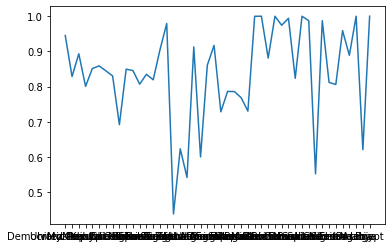

In [11]:
plt.plot(f1s.keys(),f1s.values())

In [12]:
f1sShifted = {}

lens = []
for k in train_test_splits.keys():
    print(k)
    f1sShifted[k] = distShiftNew(train_test_splits[k]['train_loader'],train_test_splits[k]['val_loader'],'manual-FULL-trimodal.pt')




Ivory Coast


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 1.4764, Val Acc: 95.63
Confusion Matrix:
 [[ 416  173]
 [  10 3592]]
True Positives: 3592
False Positives: 173
True Negatives: 416
False Negatives: 10
Precision: 0.9541
Recall: 0.9972
Mali


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.1809, Val Acc: 96.21
Confusion Matrix:
 [[374  12]
 [ 14 286]]
True Positives: 286
False Positives: 12
True Negatives: 374
False Negatives: 14
Precision: 0.9597
Recall: 0.9533
Mozambique


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.6692, Val Acc: 97.20
Confusion Matrix:
 [[537   9]
 [  8  54]]
True Positives: 54
False Positives: 9
True Negatives: 537
False Negatives: 8
Precision: 0.8571
Recall: 0.8710
Kenya


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.5064, Val Acc: 95.88
Confusion Matrix:
 [[201   5]
 [  6  55]]
True Positives: 55
False Positives: 5
True Negatives: 201
False Negatives: 6
Precision: 0.9167
Recall: 0.9016
Democratic Republic of the Congo


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: nan, Val Acc: 87.02
Confusion Matrix:
 [[970 185]
 [  9 331]]
True Positives: 331
False Positives: 185
True Negatives: 970
False Negatives: 9
Precision: 0.6415
Recall: 0.9735
United Republic of Tanzania


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.3480, Val Acc: 93.85
Confusion Matrix:
 [[567  38]
 [ 17 272]]
True Positives: 272
False Positives: 38
True Negatives: 567
False Negatives: 17
Precision: 0.8774
Recall: 0.9412
Gabon


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.6410, Val Acc: 97.74
Confusion Matrix:
 [[200   4]
 [  1  16]]
True Positives: 16
False Positives: 4
True Negatives: 200
False Negatives: 1
Precision: 0.8000
Recall: 0.9412
Cameroon


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.4639, Val Acc: 59.04
Confusion Matrix:
 [[381 397]
 [  6 200]]
True Positives: 200
False Positives: 397
True Negatives: 381
False Negatives: 6
Precision: 0.3350
Recall: 0.9709
Ghana


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.5345, Val Acc: 91.24
Confusion Matrix:
 [[395  41]
 [  5  84]]
True Positives: 84
False Positives: 41
True Negatives: 395
False Negatives: 5
Precision: 0.6720
Recall: 0.9438
Nigeria


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.6371, Val Acc: 87.75
Confusion Matrix:
 [[630  91]
 [  9  86]]
True Positives: 86
False Positives: 91
True Negatives: 630
False Negatives: 9
Precision: 0.4859
Recall: 0.9053
Liberia


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.5743, Val Acc: 95.89
Confusion Matrix:
 [[546  24]
 [  3  84]]
True Positives: 84
False Positives: 24
True Negatives: 546
False Negatives: 3
Precision: 0.7778
Recall: 0.9655
Benin


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: nan, Val Acc: 94.21
Confusion Matrix:
 [[5721  447]
 [ 236 5385]]
True Positives: 5385
False Positives: 447
True Negatives: 5721
False Negatives: 236
Precision: 0.9234
Recall: 0.9580
Sierra Leone


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.1401, Val Acc: 90.39
Confusion Matrix:
 [[306  57]
 [  4 268]]
True Positives: 268
False Positives: 57
True Negatives: 306
False Negatives: 4
Precision: 0.8246
Recall: 0.9853
Togo


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.6643, Val Acc: 95.95
Confusion Matrix:
 [[68  2]
 [ 1  3]]
True Positives: 3
False Positives: 2
True Negatives: 68
False Negatives: 1
Precision: 0.6000
Recall: 0.7500
Guinea


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.3013, Val Acc: 96.20
Confusion Matrix:
 [[728  15]
 [ 30 411]]
True Positives: 411
False Positives: 15
True Negatives: 728
False Negatives: 30
Precision: 0.9648
Recall: 0.9320
Republic of the Congo


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.7175, Val Acc: 97.65
Confusion Matrix:
 [[204   4]
 [  1   4]]
True Positives: 4
False Positives: 4
True Negatives: 204
False Negatives: 1
Precision: 0.5000
Recall: 0.8000
Uganda


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 1.9141, Val Acc: 75.00
Confusion Matrix:
 [[6 2]
 [1 3]]
True Positives: 3
False Positives: 2
True Negatives: 6
False Negatives: 1
Precision: 0.6000
Recall: 0.7500
Zimbabwe


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.4646, Val Acc: 72.73
Confusion Matrix:
 [[15  6]
 [ 0  1]]
True Positives: 1
False Positives: 6
True Negatives: 15
False Negatives: 0
Precision: 0.1429
Recall: 1.0000
South Africa


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.0983, Val Acc: 68.18
Confusion Matrix:
 [[8 7]
 [0 7]]
True Positives: 7
False Positives: 7
True Negatives: 8
False Negatives: 0
Precision: 0.5000
Recall: 1.0000
Madagascar


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


Val Loss: 2.6239, Val Acc: 98.44
Confusion Matrix:
 [[62  0]
 [ 1  1]]
True Positives: 1
False Positives: 0
True Negatives: 62
False Negatives: 1
Precision: 1.0000
Recall: 0.5000
Central African Republic


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.4660, Val Acc: 100.00
Confusion Matrix:
 [[24  0]
 [ 0  2]]
True Positives: 2
False Positives: 0
True Negatives: 24
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Angola


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


Val Loss: 2.6269, Val Acc: 96.75
Confusion Matrix:
 [[208   2]
 [  6  30]]
True Positives: 30
False Positives: 2
True Negatives: 208
False Negatives: 6
Precision: 0.9375
Recall: 0.8333
Somalia


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.5865, Val Acc: 97.78
Confusion Matrix:
 [[156   1]
 [  3  20]]
True Positives: 20
False Positives: 1
True Negatives: 156
False Negatives: 3
Precision: 0.9524
Recall: 0.8696
Guinea-Bissau


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.3737, Val Acc: 97.19
Confusion Matrix:
 [[198   3]
 [  5  79]]
True Positives: 79
False Positives: 3
True Negatives: 198
False Negatives: 5
Precision: 0.9634
Recall: 0.9405
Senegal


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.3597, Val Acc: 98.65
Confusion Matrix:
 [[106   2]
 [  0  40]]
True Positives: 40
False Positives: 2
True Negatives: 106
False Negatives: 0
Precision: 0.9524
Recall: 1.0000
Gambia


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.0160, Val Acc: 98.75
Confusion Matrix:
 [[82  1]
 [ 1 76]]
True Positives: 76
False Positives: 1
True Negatives: 82
False Negatives: 1
Precision: 0.9870
Recall: 0.9870
Mauritania


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 2.2957, Val Acc: 100.00
Confusion Matrix:
 [[28  0]
 [ 0  4]]
True Positives: 4
False Positives: 0
True Negatives: 28
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Malawi


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 1.3863, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Equatorial Guinea


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.4779, Val Acc: 100.00
Confusion Matrix:
 [[25]]
True Positives: 25
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Zambia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/tmp/ipykernel_11957/2202052877.py:128: Run

Val Loss: 2.4482, Val Acc: 94.12
Confusion Matrix:
 [[16  0]
 [ 1  0]]
True Positives: 0
False Positives: 0
True Negatives: 16
False Negatives: 1
Precision: nan
Recall: 0.0000
Namibia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.4260, Val Acc: 100.00
Confusion Matrix:
 [[14]]
True Positives: 14
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Botswana


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.5415, Val Acc: 100.00
Confusion Matrix:
 [[11]]
True Positives: 11
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
South Sudan


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.3105, Val Acc: 100.00
Confusion Matrix:
 [[10]]
True Positives: 10
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Ethiopia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/tmp/ipykernel_11957/2202052877.py:128: Run

Val Loss: 2.6405, Val Acc: 97.96
Confusion Matrix:
 [[48  0]
 [ 1  0]]
True Positives: 0
False Positives: 0
True Negatives: 48
False Negatives: 1
Precision: nan
Recall: 0.0000
Somaliland


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 1.3863, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Sudan


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.7726, Val Acc: 100.00
Confusion Matrix:
 [[48]]
True Positives: 48
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Burkina Faso


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 1.3863, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Chad


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/tmp/ipykernel_11957/2202052877.py:128: Run

Val Loss: 2.5035, Val Acc: 96.43
Confusion Matrix:
 [[27  0]
 [ 1  0]]
True Positives: 0
False Positives: 0
True Negatives: 27
False Negatives: 1
Precision: nan
Recall: 0.0000
Niger


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.6859, Val Acc: 100.00
Confusion Matrix:
 [[31]]
True Positives: 31
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Yemen


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.5415, Val Acc: 100.00
Confusion Matrix:
 [[11]]
True Positives: 11
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Eritrea


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 1.3863, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Saudi Arabia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.4755, Val Acc: 100.00
Confusion Matrix:
 [[25]]
True Positives: 25
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Oman


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.4260, Val Acc: 100.00
Confusion Matrix:
 [[7]]
True Positives: 7
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Algeria


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.2527, Val Acc: 100.00
Confusion Matrix:
 [[13]]
True Positives: 13
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Libya


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 2.7726, Val Acc: 100.00
Confusion Matrix:
 [[8]]
True Positives: 8
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Egypt
Val Loss: 2.7726, Val Acc: 100.00
Confusion Matrix:
 [[8]]
True Positives: 8
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


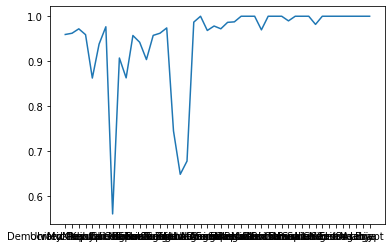

In [13]:
plt.plot(f1sShifted.keys(),f1sShifted.values())

In [74]:
print(f1sShifted)

{'Gabon': 0.36213991769547327, 'Kenya': 0.23376623376623376, 'Somalia': 0.02469135802469136, 'Angola': 0.08071748878923767, 'United Republic of Tanzania': 0.3033873343151694, 'Mozambique': 0.12173913043478261, 'Malawi': 0.0, 'Republic of the Congo': 0.7439024390243902, 'Democratic Republic of the Congo': 0.6739876458476322, 'Equatorial Guinea': 0.5714285714285715, 'Guinea': 0.26546681664791905, 'Guinea-Bissau': 0.6843853820598007, 'Senegal': 0.1090909090909091, 'Gambia': 0.07142857142857142, 'Mauritania': 0.0, 'Cameroon': 0.48799999999999993, 'Nigeria': 0.30158730158730157, 'Ivory Coast': 0.6344605475040259, 'Liberia': 0.7325581395348838, 'Ghana': 0.6401384083044983, 'Togo': 0.21052631578947367, 'Benin': 0.05755395683453238, 'Sierra Leone': 0.7751937984496124, 'Madagascar': 0.34210526315789475, 'Zimbabwe': 0.23529411764705882, 'Central African Republic': 0.2857142857142857, 'Uganda': 0.2857142857142857, 'Zambia': 0.0, 'Namibia': 0.0, 'Botswana': 0.0, 'South Africa': 0.2222222222222222,

In [16]:
f1sShiftedVal = {}
#Validation loader only for test.
lens = []
for k in train_test_splits.keys():
    print(k)
    f1sShiftedVal[k] = distShiftNew(train_test_splits[k]['val_loader'],train_test_splits[k]['val_loader'],'manual-FULL-trimodal.pt')




Ivory Coast


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.3659, Val Acc: 96.37
Confusion Matrix:
 [[100  34]
 [  4 910]]
True Positives: 910
False Positives: 34
True Negatives: 100
False Negatives: 4
Precision: 0.9640
Recall: 0.9956
Mali


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.5427, Val Acc: 97.09
Confusion Matrix:
 [[91  0]
 [ 5 76]]
True Positives: 76
False Positives: 0
True Negatives: 91
False Negatives: 5
Precision: 1.0000
Recall: 0.9383
Mozambique


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.6480, Val Acc: 98.03
Confusion Matrix:
 [[129   2]
 [  1  20]]
True Positives: 20
False Positives: 2
True Negatives: 129
False Negatives: 1
Precision: 0.9091
Recall: 0.9524
Kenya


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.6079, Val Acc: 95.52
Confusion Matrix:
 [[46  1]
 [ 2 18]]
True Positives: 18
False Positives: 1
True Negatives: 46
False Negatives: 2
Precision: 0.9474
Recall: 0.9000
Democratic Republic of the Congo


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


Val Loss: nan, Val Acc: 86.90
Confusion Matrix:
 [[228  48]
 [  1  97]]
True Positives: 97
False Positives: 48
True Negatives: 228
False Negatives: 1
Precision: 0.6690
Recall: 0.9898
United Republic of Tanzania


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.5630, Val Acc: 95.98
Confusion Matrix:
 [[134   7]
 [  2  81]]
True Positives: 81
False Positives: 7
True Negatives: 134
False Negatives: 2
Precision: 0.9205
Recall: 0.9759
Gabon


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.6539, Val Acc: 96.43
Confusion Matrix:
 [[48  2]
 [ 0  6]]
True Positives: 6
False Positives: 2
True Negatives: 48
False Negatives: 0
Precision: 0.7500
Recall: 1.0000
Cameroon


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


Val Loss: 0.6139, Val Acc: 55.06
Confusion Matrix:
 [[ 84 109]
 [  2  52]]
True Positives: 52
False Positives: 109
True Negatives: 84
False Negatives: 2
Precision: 0.3230
Recall: 0.9630
Ghana


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.6340, Val Acc: 86.36
Confusion Matrix:
 [[89 15]
 [ 3 25]]
True Positives: 25
False Positives: 15
True Negatives: 89
False Negatives: 3
Precision: 0.6250
Recall: 0.8929
Nigeria


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.6556, Val Acc: 91.67
Confusion Matrix:
 [[161  14]
 [  3  26]]
True Positives: 26
False Positives: 14
True Negatives: 161
False Negatives: 3
Precision: 0.6500
Recall: 0.8966
Liberia


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.6513, Val Acc: 92.73
Confusion Matrix:
 [[131  10]
 [  2  22]]
True Positives: 22
False Positives: 10
True Negatives: 131
False Negatives: 2
Precision: 0.6875
Recall: 0.9167
Benin


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: nan, Val Acc: 95.08
Confusion Matrix:
 [[1428  104]
 [  41 1375]]
True Positives: 1375
False Positives: 104
True Negatives: 1428
False Negatives: 41
Precision: 0.9297
Recall: 0.9710
Sierra Leone


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.5556, Val Acc: 89.94
Confusion Matrix:
 [[84 15]
 [ 1 59]]
True Positives: 59
False Positives: 15
True Negatives: 84
False Negatives: 1
Precision: 0.7973
Recall: 0.9833
Togo


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.6534, Val Acc: 100.00
Confusion Matrix:
 [[17  0]
 [ 0  2]]
True Positives: 2
False Positives: 0
True Negatives: 17
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Guinea


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


Val Loss: 0.5926, Val Acc: 97.31
Confusion Matrix:
 [[199   1]
 [  7  90]]
True Positives: 90
False Positives: 1
True Negatives: 199
False Negatives: 7
Precision: 0.9890
Recall: 0.9278
Republic of the Congo


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.6974, Val Acc: 98.15
Confusion Matrix:
 [[52  0]
 [ 1  1]]
True Positives: 1
False Positives: 0
True Negatives: 52
False Negatives: 1
Precision: 1.0000
Recall: 0.5000
Uganda


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.4082, Val Acc: 100.00
Confusion Matrix:
 [[1 0]
 [0 3]]
True Positives: 3
False Positives: 0
True Negatives: 1
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Zimbabwe


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6298, Val Acc: 83.33
Confusion Matrix:
 [[4 1]
 [0 1]]
True Positives: 1
False Positives: 1
True Negatives: 4
False Negatives: 0
Precision: 0.5000
Recall: 1.0000
South Africa


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.5032, Val Acc: 83.33
Confusion Matrix:
 [[2 1]
 [0 3]]
True Positives: 3
False Positives: 1
True Negatives: 2
False Negatives: 0
Precision: 0.7500
Recall: 1.0000
Madagascar


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/tmp/ipykernel_11957/2202052877.py:129: Run

Val Loss: 0.6932, Val Acc: 94.12
Confusion Matrix:
 [[16  1]
 [ 0  0]]
True Positives: 0
False Positives: 1
True Negatives: 16
False Negatives: 0
Precision: 0.0000
Recall: nan
Central African Republic


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6932, Val Acc: 100.00
Confusion Matrix:
 [[7]]
True Positives: 7
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Angola


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6502, Val Acc: 98.39
Confusion Matrix:
 [[54  1]
 [ 0  7]]
True Positives: 7
False Positives: 1
True Negatives: 54
False Negatives: 0
Precision: 0.8750
Recall: 1.0000
Somalia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6736, Val Acc: 97.83
Confusion Matrix:
 [[41  0]
 [ 1  4]]
True Positives: 4
False Positives: 0
True Negatives: 41
False Negatives: 1
Precision: 1.0000
Recall: 0.8000
Guinea-Bissau


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


Val Loss: 0.5681, Val Acc: 94.44
Confusion Matrix:
 [[45  4]
 [ 0 23]]
True Positives: 23
False Positives: 4
True Negatives: 45
False Negatives: 0
Precision: 0.8519
Recall: 1.0000
Senegal


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Val Loss: 0.5803, Val Acc: 97.30
Confusion Matrix:
 [[25  1]
 [ 0 11]]
True Positives: 11
False Positives: 1
True Negatives: 25
False Negatives: 0
Precision: 0.9167
Recall: 1.0000
Gambia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.4986, Val Acc: 97.56
Confusion Matrix:
 [[19  1]
 [ 0 21]]
True Positives: 21
False Positives: 1
True Negatives: 19
False Negatives: 0
Precision: 0.9545
Recall: 1.0000
Mauritania


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6509, Val Acc: 100.00
Confusion Matrix:
 [[8 0]
 [0 1]]
True Positives: 1
False Positives: 0
True Negatives: 8
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Malawi


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[2]]
True Positives: 2
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Equatorial Guinea


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[7]]
True Positives: 7
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Zambia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.7117, Val Acc: 100.00
Confusion Matrix:
 [[5]]
True Positives: 5
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Namibia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Botswana


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[3]]
True Positives: 3
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
South Sudan


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[3]]
True Positives: 3
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Ethiopia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[13]]
True Positives: 13
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Somaliland


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[2]]
True Positives: 2
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Sudan


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6932, Val Acc: 100.00
Confusion Matrix:
 [[12]]
True Positives: 12
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Burkina Faso


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/tmp/ipykernel_11957/2202052877.py:128: Run

Val Loss: 1.0032, Val Acc: 50.00
Confusion Matrix:
 [[1 0]
 [1 0]]
True Positives: 0
False Positives: 0
True Negatives: 1
False Negatives: 1
Precision: nan
Recall: 0.0000
Chad


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[8]]
True Positives: 8
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Niger


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[8]]
True Positives: 8
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Yemen


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[3]]
True Positives: 3
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Eritrea


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[2]]
True Positives: 2
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Saudi Arabia


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[7]]
True Positives: 7
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Oman


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[2]]
True Positives: 2
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Algeria


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Libya


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/si

Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[2]]
True Positives: 2
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Egypt
Val Loss: 0.6931, Val Acc: 100.00
Confusion Matrix:
 [[2]]
True Positives: 2
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000


/tmp/ipykernel_11957/2202052877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


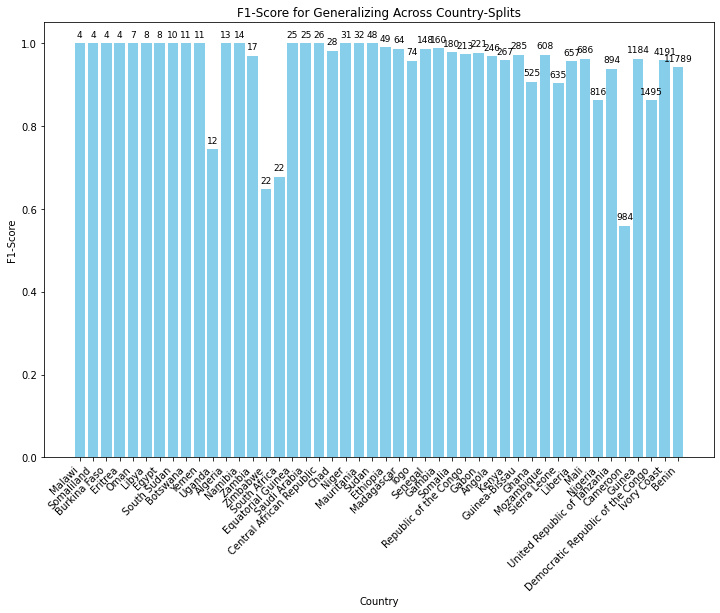

In [19]:
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Count the number of samples in train_loader for each country
country_sample_counts = {}

for country_name, data in train_test_splits.items():
    # Count the number of samples in the 'train_loader' for each country
    sample_count = len(data['train_loader'].dataset)
    country_sample_counts[country_name] = sample_count

# Step 2: Sort countries by number of samples (increasing order)
sorted_countries = sorted(country_sample_counts, key=country_sample_counts.get)

# Step 3: Prepare the data for plotting
sorted_f1_scores = [f1sShifted[country] for country in sorted_countries]
sorted_sample_counts = [country_sample_counts[country] for country in sorted_countries]

# Step 4: Create the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot of f1-scores, ordered by sample count
ax.bar(sorted_countries, sorted_f1_scores, color='skyblue')

# Add labels and title
ax.set_xlabel('Country')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score for Generalizing Across Country-Splits')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Add sample count as annotations
for i, (country, sample_count) in enumerate(zip(sorted_countries, sorted_sample_counts)):
    ax.text(i, sorted_f1_scores[i] + 0.01, f"{sample_count}", ha='center', va='bottom', fontsize=9)


In [13]:
def distShiftNew(train_loader,val_loader, modelpath, test_loaders=[]):
    trimod = True
    if mode == 'resnet':
        model = MultiResNet()
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        model.load_state_dict(torch.load(modelpath))

    trn_acc_list = []
    val_acc_list = []
    trn_loss_list = []
    val_loss_list = []
    all_predictions = []
    all_labels = []
    
    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        
        for inputs, inputsCHM, s1, labs, paths in train_loader:

            inputs= inputs.to("cuda")
            
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()      

            has_nan = torch.isnan(inputs).any(dim=1)  
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            inputsCHM = inputsCHM[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            
            if trimod:
                outputs = model(inputsCHM,inputs,s1)
            else:
                outputs = model(inputsCHM,inputs[:, :3, :, :])
            loss = criterion(outputs, labs.float())
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loader.dataset))

    print(f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )

    ff = f1_score(all_labels, all_predictions, average='weighted')
    pres = print_cm(all_labels,all_predictions)
    return ff, pres #model#, all_labels, all_predictions


In [14]:
f1Shifted = {}

lens = []
for k in train_test_splits.keys():
    print(k)
    f1Shifted[k], _ = distShiftNew(train_test_splits[k]['train_loader'],train_test_splits[k]['val_loader'],'manual-FULL-trimodal.pt')



In [22]:
precShifted = {}

lens = []
for k in train_test_splits.keys():
    print(k)
    precShifted[k], _ = distShiftNew(train_test_splits[k]['train_loader'],train_test_splits[k]['val_loader'],'manual-FULL-trimodal.pt')




Ivory Coast


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 1.4764, Val Acc: 95.63
Confusion Matrix:
 [[ 416  173]
 [  10 3592]]
True Positives: 3592
False Positives: 173
True Negatives: 416
False Negatives: 10
Precision: 0.9541
Recall: 0.9972
Mali


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.1809, Val Acc: 96.21
Confusion Matrix:
 [[374  12]
 [ 14 286]]
True Positives: 286
False Positives: 12
True Negatives: 374
False Negatives: 14
Precision: 0.9597
Recall: 0.9533
Mozambique


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.6692, Val Acc: 97.20
Confusion Matrix:
 [[537   9]
 [  8  54]]
True Positives: 54
False Positives: 9
True Negatives: 537
False Negatives: 8
Precision: 0.8571
Recall: 0.8710
Kenya


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.5064, Val Acc: 95.88
Confusion Matrix:
 [[201   5]
 [  6  55]]
True Positives: 55
False Positives: 5
True Negatives: 201
False Negatives: 6
Precision: 0.9167
Recall: 0.9016
Democratic Republic of the Congo


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: nan, Val Acc: 87.02
Confusion Matrix:
 [[970 185]
 [  9 331]]
True Positives: 331
False Positives: 185
True Negatives: 970
False Negatives: 9
Precision: 0.6415
Recall: 0.9735
United Republic of Tanzania


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.3480, Val Acc: 93.85
Confusion Matrix:
 [[567  38]
 [ 17 272]]
True Positives: 272
False Positives: 38
True Negatives: 567
False Negatives: 17
Precision: 0.8774
Recall: 0.9412
Gabon


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.6410, Val Acc: 97.74
Confusion Matrix:
 [[200   4]
 [  1  16]]
True Positives: 16
False Positives: 4
True Negatives: 200
False Negatives: 1
Precision: 0.8000
Recall: 0.9412
Cameroon


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.4639, Val Acc: 59.04
Confusion Matrix:
 [[381 397]
 [  6 200]]
True Positives: 200
False Positives: 397
True Negatives: 381
False Negatives: 6
Precision: 0.3350
Recall: 0.9709
Ghana


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.5345, Val Acc: 91.24
Confusion Matrix:
 [[395  41]
 [  5  84]]
True Positives: 84
False Positives: 41
True Negatives: 395
False Negatives: 5
Precision: 0.6720
Recall: 0.9438
Nigeria


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.6371, Val Acc: 87.75
Confusion Matrix:
 [[630  91]
 [  9  86]]
True Positives: 86
False Positives: 91
True Negatives: 630
False Negatives: 9
Precision: 0.4859
Recall: 0.9053
Liberia


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.5743, Val Acc: 95.89
Confusion Matrix:
 [[546  24]
 [  3  84]]
True Positives: 84
False Positives: 24
True Negatives: 546
False Negatives: 3
Precision: 0.7778
Recall: 0.9655
Benin


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: nan, Val Acc: 94.21
Confusion Matrix:
 [[5721  447]
 [ 236 5385]]
True Positives: 5385
False Positives: 447
True Negatives: 5721
False Negatives: 236
Precision: 0.9234
Recall: 0.9580
Sierra Leone


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.1401, Val Acc: 90.39
Confusion Matrix:
 [[306  57]
 [  4 268]]
True Positives: 268
False Positives: 57
True Negatives: 306
False Negatives: 4
Precision: 0.8246
Recall: 0.9853
Togo


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.6643, Val Acc: 95.95
Confusion Matrix:
 [[68  2]
 [ 1  3]]
True Positives: 3
False Positives: 2
True Negatives: 68
False Negatives: 1
Precision: 0.6000
Recall: 0.7500
Guinea


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.3013, Val Acc: 96.20
Confusion Matrix:
 [[728  15]
 [ 30 411]]
True Positives: 411
False Positives: 15
True Negatives: 728
False Negatives: 30
Precision: 0.9648
Recall: 0.9320
Republic of the Congo


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.7175, Val Acc: 97.65
Confusion Matrix:
 [[204   4]
 [  1   4]]
True Positives: 4
False Positives: 4
True Negatives: 204
False Negatives: 1
Precision: 0.5000
Recall: 0.8000
Uganda


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 1.9141, Val Acc: 75.00
Confusion Matrix:
 [[6 2]
 [1 3]]
True Positives: 3
False Positives: 2
True Negatives: 6
False Negatives: 1
Precision: 0.6000
Recall: 0.7500
Zimbabwe


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.4646, Val Acc: 72.73
Confusion Matrix:
 [[15  6]
 [ 0  1]]
True Positives: 1
False Positives: 6
True Negatives: 15
False Negatives: 0
Precision: 0.1429
Recall: 1.0000
South Africa


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.0983, Val Acc: 68.18
Confusion Matrix:
 [[8 7]
 [0 7]]
True Positives: 7
False Positives: 7
True Negatives: 8
False Negatives: 0
Precision: 0.5000
Recall: 1.0000
Madagascar


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.6239, Val Acc: 98.44
Confusion Matrix:
 [[62  0]
 [ 1  1]]
True Positives: 1
False Positives: 0
True Negatives: 62
False Negatives: 1
Precision: 1.0000
Recall: 0.5000
Central African Republic


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.4660, Val Acc: 100.00
Confusion Matrix:
 [[24  0]
 [ 0  2]]
True Positives: 2
False Positives: 0
True Negatives: 24
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Angola


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


Val Loss: 2.6269, Val Acc: 96.75
Confusion Matrix:
 [[208   2]
 [  6  30]]
True Positives: 30
False Positives: 2
True Negatives: 208
False Negatives: 6
Precision: 0.9375
Recall: 0.8333
Somalia


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.5865, Val Acc: 97.78
Confusion Matrix:
 [[156   1]
 [  3  20]]
True Positives: 20
False Positives: 1
True Negatives: 156
False Negatives: 3
Precision: 0.9524
Recall: 0.8696
Guinea-Bissau


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.3737, Val Acc: 97.19
Confusion Matrix:
 [[198   3]
 [  5  79]]
True Positives: 79
False Positives: 3
True Negatives: 198
False Negatives: 5
Precision: 0.9634
Recall: 0.9405
Senegal


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.3597, Val Acc: 98.65
Confusion Matrix:
 [[106   2]
 [  0  40]]
True Positives: 40
False Positives: 2
True Negatives: 106
False Negatives: 0
Precision: 0.9524
Recall: 1.0000
Gambia


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.0160, Val Acc: 98.75
Confusion Matrix:
 [[82  1]
 [ 1 76]]
True Positives: 76
False Positives: 1
True Negatives: 82
False Negatives: 1
Precision: 0.9870
Recall: 0.9870
Mauritania


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

Val Loss: 2.2957, Val Acc: 100.00
Confusion Matrix:
 [[28  0]
 [ 0  4]]
True Positives: 4
False Positives: 0
True Negatives: 28
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Malawi


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 1.3863, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Equatorial Guinea


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.4779, Val Acc: 100.00
Confusion Matrix:
 [[25]]
True Positives: 25
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Zambia


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/tmp/ipykernel_11957/2704378604.py:128: Runtim

Val Loss: 2.4482, Val Acc: 94.12
Confusion Matrix:
 [[16  0]
 [ 1  0]]
True Positives: 0
False Positives: 0
True Negatives: 16
False Negatives: 1
Precision: nan
Recall: 0.0000
Namibia


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.4260, Val Acc: 100.00
Confusion Matrix:
 [[14]]
True Positives: 14
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Botswana


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.5415, Val Acc: 100.00
Confusion Matrix:
 [[11]]
True Positives: 11
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
South Sudan


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.3105, Val Acc: 100.00
Confusion Matrix:
 [[10]]
True Positives: 10
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Ethiopia


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/tmp/ipykernel_11957/2704378604.py:128: Runtim

Val Loss: 2.6405, Val Acc: 97.96
Confusion Matrix:
 [[48  0]
 [ 1  0]]
True Positives: 0
False Positives: 0
True Negatives: 48
False Negatives: 1
Precision: nan
Recall: 0.0000
Somaliland


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 1.3863, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Sudan


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.7726, Val Acc: 100.00
Confusion Matrix:
 [[48]]
True Positives: 48
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Burkina Faso


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 1.3863, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Chad


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/tmp/ipykernel_11957/2704378604.py:128: Runtim

Val Loss: 2.5035, Val Acc: 96.43
Confusion Matrix:
 [[27  0]
 [ 1  0]]
True Positives: 0
False Positives: 0
True Negatives: 27
False Negatives: 1
Precision: nan
Recall: 0.0000
Niger


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.6859, Val Acc: 100.00
Confusion Matrix:
 [[31]]
True Positives: 31
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Yemen


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.5415, Val Acc: 100.00
Confusion Matrix:
 [[11]]
True Positives: 11
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Eritrea


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 1.3863, Val Acc: 100.00
Confusion Matrix:
 [[4]]
True Positives: 4
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Saudi Arabia


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.4755, Val Acc: 100.00
Confusion Matrix:
 [[25]]
True Positives: 25
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Oman


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.4260, Val Acc: 100.00
Confusion Matrix:
 [[7]]
True Positives: 7
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Algeria


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.2527, Val Acc: 100.00
Confusion Matrix:
 [[13]]
True Positives: 13
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Libya


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))
/home/angelats11/anaconda3/lib/python3.9/site-

Val Loss: 2.7726, Val Acc: 100.00
Confusion Matrix:
 [[8]]
True Positives: 8
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
Egypt
Val Loss: 2.7726, Val Acc: 100.00
Confusion Matrix:
 [[8]]
True Positives: 8
False Positives: 0
True Negatives: 0
False Negatives: 0
Precision: 1.0000
Recall: 1.0000


/tmp/ipykernel_11957/42163090.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelpath))


In [26]:

def trainNew(train_loader,val_loader, modelpath, test_loaders=[]):
    #############
    #### TRIMODAL
    ##############
    trimod = True
    if mode == 'resnet':
        model = MultiResNet()
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

    model.train()

    print('training start')
    trn_acc_list = []
    val_acc_list = []
    trn_loss_list = []
    val_loss_list = []
    all_predictions = []
    all_labels = []
    
    # Train the model

    num_epochs = 20
    for epoch in range(num_epochs):
    
        model.train()
        correct = 0
        total = 0
        train_loss = 0.0
    
        for inputs, inputsCHM, s1, labs, paths in train_loader:

            inputs = inputs.to("cuda")
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()
            
            #if torch.isnan(inputs).any() or torch.isnan(inputsCHM).any() or torch.isnan(s1).any() or torch.isnan(labs).any():
            nan_indices = torch.isnan(s1)
            if nan_indices.any():
            #if torch.isnan(s1).any():
                print("Skipping batch due to NaNs.")
                continue
            '''
            has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
            # Filter inputs to exclude those with NaNs
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            inputsCHM = inputsCHM[~has_nan_anywhere]
            s1 = s1[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            '''

                    
            for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
                channel_data = inputs[:, c, :, :]
                mask = torch.isnan(channel_data)
                mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
                
                channel_data[mask] = mean_val.expand_as(channel_data)[mask]
                inputs[:, c, :, :] = channel_data
            if torch.isnan(inputs).any():
                raise ValueError("NaNs found in inputs after interpolation")
        
            # Check for NaNs in inputsCHM and labs
            if torch.isnan(inputsCHM).any():
                raise ValueError("NaNs found in inputsCHM")

            if torch.isnan(s1).any():
                print(torch.isnan(s1))
                print("NaNs found in S1!")
        
            if torch.isnan(labs).any():
                raise ValueError("NaNs found in labs")
            
            optimizer.zero_grad()
            if trimod:
                outputs = model(inputsCHM,inputs,s1)
            else:
                outputs = model(inputsCHM,inputs[:, :3, :, :])
            if torch.isnan(outputs).any():
                print(f"Inputs: {inputs[0][0]}")
                print(f"Model outputs: {outputs}")
                raise ValueError("NaNs found in model outputs")
    
            loss = criterion(outputs, labs.float())
            if torch.isnan(loss).any():
                raise ValueError("NaNs found in loss")
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        trn_acc_list.append(correct/total * 100)
        trn_loss_list.append(train_loss/len(train_loader.dataset))
    
        #if epoch == 19: 
        #    torch.save(model.state_dict(), modelpath)
    
    
        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in val_loader:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = inputsCHM.to("cuda")
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                if trimod:
                    outputs = model(inputsCHM,inputs,s1)
                else:
                    outputs = model(inputsCHM,inputs[:, :3, :, :])
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
            val_acc_list.append(correct/total * 100)
            val_loss_list.append(val_loss / len(val_loader.dataset))
    
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
              f'Train Acc: {trn_acc_list[-1]:.4f}, '
              #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
              f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )
    
    #plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions, correct, total)
    #ff = f1_score(all_labels, all_predictions, average='weighted')  # or 'macro', 'micro'
    ff = print_cm(all_labels,all_predictions)
    
    return ff #model#, all_labels, all_predictions

precShiftedtrain = {}

lens = []
for k in train_test_splits.keys():
    print(k)
    precShiftedtrain[k] = trainNew(train_test_splits[k]['train_loader'],train_test_splits[k]['val_loader'],'')




Ivory Coast
training start
Epoch 1/20, Train Loss: 0.3920, Train Acc: 91.6488, Val Loss: 0.3823, Val Acc: 92.18
Epoch 2/20, Train Loss: 0.3817, Train Acc: 93.5099, Val Loss: 0.3955, Val Acc: 92.84
Epoch 3/20, Train Loss: 0.3814, Train Acc: 93.6531, Val Loss: 0.3758, Val Acc: 94.18
Epoch 4/20, Train Loss: 0.3761, Train Acc: 94.4643, Val Loss: 0.3802, Val Acc: 93.80
Epoch 5/20, Train Loss: 0.3774, Train Acc: 94.5598, Val Loss: 0.3749, Val Acc: 94.47
Epoch 6/20, Train Loss: 0.3724, Train Acc: 95.5381, Val Loss: 0.3761, Val Acc: 94.56
Epoch 7/20, Train Loss: 0.3704, Train Acc: 95.9914, Val Loss: 0.3737, Val Acc: 94.85
Epoch 8/20, Train Loss: 0.3682, Train Acc: 96.3016, Val Loss: 0.3726, Val Acc: 95.61
Epoch 9/20, Train Loss: 0.3660, Train Acc: 96.8265, Val Loss: 0.3728, Val Acc: 95.71
Epoch 10/20, Train Loss: 0.3647, Train Acc: 97.3992, Val Loss: 0.3726, Val Acc: 95.71
Epoch 11/20, Train Loss: 0.3631, Train Acc: 97.6617, Val Loss: 0.3738, Val Acc: 94.66
Epoch 12/20, Train Loss: 0.3622, Tra

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6620, Train Acc: 77.1137, Val Loss: 0.6719, Val Acc: 62.79
Epoch 2/20, Train Loss: 0.5608, Train Acc: 92.5656, Val Loss: 0.6302, Val Acc: 75.00
Epoch 3/20, Train Loss: 0.5436, Train Acc: 97.3761, Val Loss: 0.6161, Val Acc: 80.81
Epoch 4/20, Train Loss: 0.5363, Train Acc: 98.6880, Val Loss: 0.5863, Val Acc: 88.37
Epoch 5/20, Train Loss: 0.5377, Train Acc: 98.2507, Val Loss: 0.5918, Val Acc: 88.95
Epoch 6/20, Train Loss: 0.5357, Train Acc: 98.8338, Val Loss: 0.5876, Val Acc: 87.79
Epoch 7/20, Train Loss: 0.5335, Train Acc: 99.2711, Val Loss: 0.5880, Val Acc: 87.79
Epoch 8/20, Train Loss: 0.5322, Train Acc: 99.8542, Val Loss: 0.5785, Val Acc: 91.28
Epoch 9/20, Train Loss: 0.5318, Train Acc: 99.2711, Val Loss: 0.5912, Val Acc: 84.30
Epoch 10/20, Train Loss: 0.5336, Train Acc: 98.8338, Val Loss: 0.5795, Val Acc: 91.28
Epoch 11/20, Train Loss: 0.5342, Train Acc: 98.9796, Val Loss: 0.6050, Val Acc: 87.21
Epoch 12/20, Train Loss: 0.5343, Train Acc: 99.1

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8601, Train Acc: 63.6513, Val Loss: 0.7453, Val Acc: 85.53
Epoch 2/20, Train Loss: 0.7237, Train Acc: 88.4868, Val Loss: 0.6951, Val Acc: 86.84
Epoch 3/20, Train Loss: 0.6829, Train Acc: 95.3947, Val Loss: 0.6959, Val Acc: 86.84
Epoch 4/20, Train Loss: 0.6696, Train Acc: 97.2039, Val Loss: 0.6927, Val Acc: 86.84
Epoch 5/20, Train Loss: 0.6730, Train Acc: 96.5461, Val Loss: 0.6928, Val Acc: 88.82
Epoch 6/20, Train Loss: 0.6678, Train Acc: 97.2039, Val Loss: 0.6847, Val Acc: 87.50
Epoch 7/20, Train Loss: 0.6636, Train Acc: 97.8618, Val Loss: 0.6893, Val Acc: 88.16
Epoch 8/20, Train Loss: 0.6683, Train Acc: 97.5329, Val Loss: 0.7032, Val Acc: 88.82
Epoch 9/20, Train Loss: 0.6636, Train Acc: 98.1908, Val Loss: 0.6876, Val Acc: 87.50
Epoch 10/20, Train Loss: 0.6605, Train Acc: 98.5197, Val Loss: 0.6903, Val Acc: 89.47
Epoch 11/20, Train Loss: 0.6611, Train Acc: 98.6842, Val Loss: 0.6852, Val Acc: 89.47
Epoch 12/20, Train Loss: 0.6585, Train Acc: 99.0

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8121, Train Acc: 65.9176, Val Loss: 0.7531, Val Acc: 73.13
Epoch 2/20, Train Loss: 0.6717, Train Acc: 92.5094, Val Loss: 0.7744, Val Acc: 76.12
Epoch 3/20, Train Loss: 0.6348, Train Acc: 96.2547, Val Loss: 0.7432, Val Acc: 70.15
Epoch 4/20, Train Loss: 0.6210, Train Acc: 97.3783, Val Loss: 0.7211, Val Acc: 73.13
Epoch 5/20, Train Loss: 0.6274, Train Acc: 96.6292, Val Loss: 0.6811, Val Acc: 74.63
Epoch 6/20, Train Loss: 0.6165, Train Acc: 98.1273, Val Loss: 0.6904, Val Acc: 73.13
Epoch 7/20, Train Loss: 0.6199, Train Acc: 97.7528, Val Loss: 0.6781, Val Acc: 82.09
Epoch 8/20, Train Loss: 0.6193, Train Acc: 97.7528, Val Loss: 0.6785, Val Acc: 77.61
Epoch 9/20, Train Loss: 0.6174, Train Acc: 98.5019, Val Loss: 0.6823, Val Acc: 80.60
Epoch 10/20, Train Loss: 0.6131, Train Acc: 98.8764, Val Loss: 0.6778, Val Acc: 77.61
Epoch 11/20, Train Loss: 0.6118, Train Acc: 99.6255, Val Loss: 0.6693, Val Acc: 79.10
Epoch 12/20, Train Loss: 0.6104, Train Acc: 99.6

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.6264, Train Acc: 81.1321, Val Loss: nan, Val Acc: 77.81
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.5850, Train Acc: 89.2383, Val Loss: nan, Val Acc: 76.20
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.5777, Train Acc: 91.3347, Val Loss: nan, Val Acc: 84.49
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.5767, Train Acc: 91.2648, Val Loss: nan, Val Acc: 85.29
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.5724, Train Acc: 92.5926, Val Loss: nan, Val Acc: 84.22
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.5688, Train Acc: 93.2215, Val Loss: nan, Val Acc: 86.36
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Epoch 7/20, Train Loss: 0.5653, Train Acc: 93.5709, Val Loss: nan, Val Acc: 88.77
Skipping batch due 

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6636, Train Acc: 80.8725, Val Loss: 0.6459, Val Acc: 77.23
Epoch 2/20, Train Loss: 0.6063, Train Acc: 90.6040, Val Loss: 0.6120, Val Acc: 88.39
Epoch 3/20, Train Loss: 0.5892, Train Acc: 93.7360, Val Loss: 0.6381, Val Acc: 82.59
Epoch 4/20, Train Loss: 0.5838, Train Acc: 94.9664, Val Loss: 0.6178, Val Acc: 83.04
Epoch 5/20, Train Loss: 0.5752, Train Acc: 96.6443, Val Loss: 0.6052, Val Acc: 85.27
Epoch 6/20, Train Loss: 0.5717, Train Acc: 97.8747, Val Loss: 0.6151, Val Acc: 85.27
Epoch 7/20, Train Loss: 0.5706, Train Acc: 97.8747, Val Loss: 0.6048, Val Acc: 87.95
Epoch 8/20, Train Loss: 0.5710, Train Acc: 97.9866, Val Loss: 0.6054, Val Acc: 88.39
Epoch 9/20, Train Loss: 0.5697, Train Acc: 98.0984, Val Loss: 0.6035, Val Acc: 87.50
Epoch 10/20, Train Loss: 0.5717, Train Acc: 97.6510, Val Loss: 0.6157, Val Acc: 82.14
Epoch 11/20, Train Loss: 0.5713, Train Acc: 98.0984, Val Loss: 0.6080, Val Acc: 82.59
Epoch 12/20, Train Loss: 0.5688, Train Acc: 98.3

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9078, Train Acc: 56.5611, Val Loss: 0.8458, Val Acc: 78.57
Epoch 2/20, Train Loss: 0.7795, Train Acc: 82.8054, Val Loss: 0.7734, Val Acc: 85.71
Epoch 3/20, Train Loss: 0.7400, Train Acc: 88.2353, Val Loss: 0.7516, Val Acc: 85.71
Epoch 4/20, Train Loss: 0.7323, Train Acc: 88.6878, Val Loss: 0.7424, Val Acc: 82.14
Epoch 5/20, Train Loss: 0.7108, Train Acc: 92.3077, Val Loss: 0.7163, Val Acc: 85.71
Epoch 6/20, Train Loss: 0.6821, Train Acc: 98.1900, Val Loss: 0.7147, Val Acc: 85.71
Epoch 7/20, Train Loss: 0.6696, Train Acc: 98.1900, Val Loss: 0.6929, Val Acc: 89.29
Epoch 8/20, Train Loss: 0.6656, Train Acc: 98.6425, Val Loss: 0.6930, Val Acc: 87.50
Epoch 9/20, Train Loss: 0.6628, Train Acc: 99.5475, Val Loss: 0.7061, Val Acc: 82.14
Epoch 10/20, Train Loss: 0.6623, Train Acc: 99.5475, Val Loss: 0.7070, Val Acc: 85.71
Epoch 11/20, Train Loss: 0.6645, Train Acc: 99.0950, Val Loss: 0.7081, Val Acc: 83.93
Epoch 12/20, Train Loss: 0.6652, Train Acc: 99.0

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.5846, Train Acc: 78.1504, Val Loss: 0.5816, Val Acc: 70.45
Epoch 2/20, Train Loss: 0.5440, Train Acc: 84.0447, Val Loss: 0.5358, Val Acc: 83.81
Epoch 3/20, Train Loss: 0.5161, Train Acc: 89.5325, Val Loss: 0.5401, Val Acc: 80.97
Epoch 4/20, Train Loss: 0.5038, Train Acc: 92.6829, Val Loss: 0.5208, Val Acc: 83.81
Epoch 5/20, Train Loss: 0.4922, Train Acc: 94.5122, Val Loss: 0.5257, Val Acc: 86.23
Epoch 6/20, Train Loss: 0.4934, Train Acc: 94.3089, Val Loss: 0.5446, Val Acc: 79.76
Epoch 7/20, Train Loss: 0.4929, Train Acc: 94.0041, Val Loss: 0.5459, Val Acc: 80.57
Epoch 8/20, Train Loss: 0.4844, Train Acc: 96.3415, Val Loss: 0.5774, Val Acc: 78.95
Epoch 9/20, Train Loss: 0.4805, Train Acc: 96.6463, Val Loss: 0.5416, Val Acc: 77.33
Epoch 10/20, Train Loss: 0.4757, Train Acc: 97.6626, Val Loss: 0.5346, Val Acc: 80.16
Epoch 11/20, Train Loss: 0.4752, Train Acc: 97.8659, Val Loss: 0.5233, Val Acc: 85.43
Epoch 12/20, Train Loss: 0.4746, Train Acc: 98.0

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8098, Train Acc: 62.0952, Val Loss: 0.7168, Val Acc: 69.70
Epoch 2/20, Train Loss: 0.6686, Train Acc: 91.2381, Val Loss: 0.6961, Val Acc: 69.70
Epoch 3/20, Train Loss: 0.6233, Train Acc: 97.5238, Val Loss: 0.6964, Val Acc: 71.97
Epoch 4/20, Train Loss: 0.6209, Train Acc: 97.3333, Val Loss: 0.6856, Val Acc: 74.24
Epoch 5/20, Train Loss: 0.6136, Train Acc: 97.7143, Val Loss: 0.7012, Val Acc: 73.48
Epoch 6/20, Train Loss: 0.6082, Train Acc: 99.4286, Val Loss: 0.6779, Val Acc: 77.27
Epoch 7/20, Train Loss: 0.6117, Train Acc: 98.8571, Val Loss: 0.7080, Val Acc: 76.52
Epoch 8/20, Train Loss: 0.6093, Train Acc: 99.4286, Val Loss: 0.6778, Val Acc: 78.03
Epoch 9/20, Train Loss: 0.6069, Train Acc: 99.8095, Val Loss: 0.6741, Val Acc: 74.24
Epoch 10/20, Train Loss: 0.6063, Train Acc: 99.4286, Val Loss: 0.6687, Val Acc: 78.03
Epoch 11/20, Train Loss: 0.6051, Train Acc: 99.8095, Val Loss: 0.6756, Val Acc: 78.79
Epoch 12/20, Train Loss: 0.6061, Train Acc: 99.8

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7716, Train Acc: 70.4657, Val Loss: 0.7150, Val Acc: 81.86
Epoch 2/20, Train Loss: 0.6729, Train Acc: 86.6422, Val Loss: 0.7029, Val Acc: 83.82
Epoch 3/20, Train Loss: 0.6555, Train Acc: 90.6863, Val Loss: 0.7350, Val Acc: 80.39
Epoch 4/20, Train Loss: 0.6437, Train Acc: 92.6471, Val Loss: 0.7094, Val Acc: 81.37
Epoch 5/20, Train Loss: 0.6368, Train Acc: 94.8529, Val Loss: 0.6888, Val Acc: 85.29
Epoch 6/20, Train Loss: 0.6320, Train Acc: 95.5882, Val Loss: 0.6918, Val Acc: 85.78
Epoch 7/20, Train Loss: 0.6278, Train Acc: 96.4461, Val Loss: 0.6998, Val Acc: 82.84
Epoch 8/20, Train Loss: 0.6282, Train Acc: 96.5686, Val Loss: 0.6970, Val Acc: 82.84
Epoch 9/20, Train Loss: 0.6225, Train Acc: 97.7941, Val Loss: 0.6830, Val Acc: 86.27
Epoch 10/20, Train Loss: 0.6216, Train Acc: 97.6716, Val Loss: 0.6839, Val Acc: 87.25
Epoch 11/20, Train Loss: 0.6209, Train Acc: 97.9167, Val Loss: 0.7022, Val Acc: 83.82
Epoch 12/20, Train Loss: 0.6190, Train Acc: 98.4

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8121, Train Acc: 68.4932, Val Loss: 0.7026, Val Acc: 81.21
Epoch 2/20, Train Loss: 0.6818, Train Acc: 89.1933, Val Loss: 0.6846, Val Acc: 83.64
Epoch 3/20, Train Loss: 0.6753, Train Acc: 90.5632, Val Loss: 0.6798, Val Acc: 87.27
Epoch 4/20, Train Loss: 0.6572, Train Acc: 93.7595, Val Loss: 0.6756, Val Acc: 84.85
Epoch 5/20, Train Loss: 0.6511, Train Acc: 95.5860, Val Loss: 0.6707, Val Acc: 87.27
Epoch 6/20, Train Loss: 0.6467, Train Acc: 96.8037, Val Loss: 0.6652, Val Acc: 89.09
Epoch 7/20, Train Loss: 0.6445, Train Acc: 97.5647, Val Loss: 0.6676, Val Acc: 88.48
Epoch 8/20, Train Loss: 0.6436, Train Acc: 97.5647, Val Loss: 0.6742, Val Acc: 86.67
Epoch 9/20, Train Loss: 0.6465, Train Acc: 96.6514, Val Loss: 0.6711, Val Acc: 86.06
Epoch 10/20, Train Loss: 0.6402, Train Acc: 97.7169, Val Loss: 0.6698, Val Acc: 90.30
Epoch 11/20, Train Loss: 0.6449, Train Acc: 97.7169, Val Loss: 0.6801, Val Acc: 84.24
Epoch 12/20, Train Loss: 0.6429, Train Acc: 97.8

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6351, Train Acc: 73.7008, Val Loss: 0.6729, Val Acc: 53.46
Epoch 2/20, Train Loss: 0.5524, Train Acc: 89.1339, Val Loss: 0.6690, Val Acc: 58.49
Epoch 3/20, Train Loss: 0.5247, Train Acc: 94.9606, Val Loss: 0.6249, Val Acc: 72.96
Epoch 4/20, Train Loss: 0.5185, Train Acc: 96.3780, Val Loss: 0.6179, Val Acc: 75.47
Epoch 5/20, Train Loss: 0.5111, Train Acc: 97.9528, Val Loss: 0.6560, Val Acc: 75.47
Epoch 6/20, Train Loss: 0.5115, Train Acc: 97.7953, Val Loss: 0.5953, Val Acc: 83.65
Epoch 7/20, Train Loss: 0.5091, Train Acc: 98.1102, Val Loss: 0.6034, Val Acc: 79.87
Epoch 8/20, Train Loss: 0.5047, Train Acc: 98.8976, Val Loss: 0.5877, Val Acc: 84.91
Epoch 9/20, Train Loss: 0.5044, Train Acc: 99.0551, Val Loss: 0.5908, Val Acc: 81.76
Epoch 10/20, Train Loss: 0.5039, Train Acc: 99.0551, Val Loss: 0.5971, Val Acc: 83.65
Epoch 11/20, Train Loss: 0.5053, Train Acc: 98.7402, Val Loss: 0.6283, Val Acc: 71.70
Epoch 12/20, Train Loss: 0.5044, Train Acc: 98.8

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8851, Train Acc: 74.3243, Val Loss: 0.8568, Val Acc: 89.47
Epoch 2/20, Train Loss: 0.7932, Train Acc: 90.5405, Val Loss: 0.8773, Val Acc: 89.47
Epoch 3/20, Train Loss: 0.7363, Train Acc: 98.6486, Val Loss: 0.8869, Val Acc: 73.68
Epoch 4/20, Train Loss: 0.7055, Train Acc: 98.6486, Val Loss: 0.8767, Val Acc: 73.68
Epoch 5/20, Train Loss: 0.6926, Train Acc: 98.6486, Val Loss: 0.8800, Val Acc: 73.68
Epoch 6/20, Train Loss: 0.6827, Train Acc: 98.6486, Val Loss: 0.8625, Val Acc: 73.68
Epoch 7/20, Train Loss: 0.6795, Train Acc: 98.6486, Val Loss: 0.8328, Val Acc: 84.21
Epoch 8/20, Train Loss: 0.6896, Train Acc: 98.6486, Val Loss: 0.8633, Val Acc: 73.68
Epoch 9/20, Train Loss: 0.6775, Train Acc: 98.6486, Val Loss: 0.8131, Val Acc: 84.21
Epoch 10/20, Train Loss: 0.6779, Train Acc: 98.6486, Val Loss: 0.7555, Val Acc: 89.47
Epoch 11/20, Train Loss: 0.6866, Train Acc: 97.2973, Val Loss: 0.7283, Val Acc: 89.47
Epoch 12/20, Train Loss: 0.6766, Train Acc: 98.6

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6492, Train Acc: 82.0946, Val Loss: 0.6560, Val Acc: 88.22
Epoch 2/20, Train Loss: 0.5875, Train Acc: 93.8345, Val Loss: 0.6244, Val Acc: 92.26
Epoch 3/20, Train Loss: 0.5743, Train Acc: 96.2838, Val Loss: 0.6147, Val Acc: 92.59
Epoch 4/20, Train Loss: 0.5675, Train Acc: 97.8885, Val Loss: 0.6167, Val Acc: 89.56
Epoch 5/20, Train Loss: 0.5677, Train Acc: 97.8041, Val Loss: 0.6294, Val Acc: 91.25
Epoch 6/20, Train Loss: 0.5652, Train Acc: 98.2264, Val Loss: 0.6068, Val Acc: 94.61
Epoch 7/20, Train Loss: 0.5632, Train Acc: 98.5642, Val Loss: 0.6283, Val Acc: 89.90
Epoch 8/20, Train Loss: 0.5635, Train Acc: 98.7331, Val Loss: 0.6008, Val Acc: 94.95
Epoch 9/20, Train Loss: 0.5602, Train Acc: 99.1554, Val Loss: 0.6143, Val Acc: 93.60
Epoch 10/20, Train Loss: 0.5610, Train Acc: 99.2399, Val Loss: 0.6136, Val Acc: 92.26
Epoch 11/20, Train Loss: 0.5613, Train Acc: 99.0709, Val Loss: 0.6087, Val Acc: 92.93
Epoch 12/20, Train Loss: 0.5596, Train Acc: 99.5

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8314, Train Acc: 89.6714, Val Loss: 0.8200, Val Acc: 98.15
Epoch 2/20, Train Loss: 0.7367, Train Acc: 97.1831, Val Loss: 0.7668, Val Acc: 98.15
Epoch 3/20, Train Loss: 0.7040, Train Acc: 99.0610, Val Loss: 0.7312, Val Acc: 98.15
Epoch 4/20, Train Loss: 0.6909, Train Acc: 99.0610, Val Loss: 0.7109, Val Acc: 98.15
Epoch 5/20, Train Loss: 0.6842, Train Acc: 99.5305, Val Loss: 0.7030, Val Acc: 98.15
Epoch 6/20, Train Loss: 0.6850, Train Acc: 99.0610, Val Loss: 0.6964, Val Acc: 98.15
Epoch 7/20, Train Loss: 0.6860, Train Acc: 99.0610, Val Loss: 0.6938, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.6830, Train Acc: 99.5305, Val Loss: 0.6920, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.6830, Train Acc: 99.5305, Val Loss: 0.6880, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.6799, Train Acc: 100.0000, Val Loss: 0.6875, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6800, Train Acc: 100.0000, Val Loss: 0.6875, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.6798, Train Ac

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7396, Train Acc: 58.3333, Val Loss: 0.5916, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.5530, Train Acc: 100.0000, Val Loss: 0.5765, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.5374, Train Acc: 100.0000, Val Loss: 0.5672, Val Acc: 75.00
Epoch 4/20, Train Loss: 0.5359, Train Acc: 100.0000, Val Loss: 0.5633, Val Acc: 75.00
Epoch 5/20, Train Loss: 0.5354, Train Acc: 100.0000, Val Loss: 0.5556, Val Acc: 75.00
Epoch 6/20, Train Loss: 0.5352, Train Acc: 100.0000, Val Loss: 0.5516, Val Acc: 75.00
Epoch 7/20, Train Loss: 0.5351, Train Acc: 100.0000, Val Loss: 0.5481, Val Acc: 75.00
Epoch 8/20, Train Loss: 0.5350, Train Acc: 100.0000, Val Loss: 0.5453, Val Acc: 75.00
Epoch 9/20, Train Loss: 0.5350, Train Acc: 100.0000, Val Loss: 0.5452, Val Acc: 75.00
Epoch 10/20, Train Loss: 0.5349, Train Acc: 100.0000, Val Loss: 0.5479, Val Acc: 75.00
Epoch 11/20, Train Loss: 0.5349, Train Acc: 100.0000, Val Loss: 0.5528, Val Acc: 50.00
Epoch 12/20, Train Loss: 0.5349, Tra

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7218, Train Acc: 77.2727, Val Loss: 0.7408, Val Acc: 66.67
Epoch 2/20, Train Loss: 0.5934, Train Acc: 100.0000, Val Loss: 0.7322, Val Acc: 66.67
Epoch 3/20, Train Loss: 0.5758, Train Acc: 100.0000, Val Loss: 0.7300, Val Acc: 66.67
Epoch 4/20, Train Loss: 0.5738, Train Acc: 100.0000, Val Loss: 0.7262, Val Acc: 66.67
Epoch 5/20, Train Loss: 0.5731, Train Acc: 100.0000, Val Loss: 0.7184, Val Acc: 66.67
Epoch 6/20, Train Loss: 0.5728, Train Acc: 100.0000, Val Loss: 0.7149, Val Acc: 66.67
Epoch 7/20, Train Loss: 0.5726, Train Acc: 100.0000, Val Loss: 0.7140, Val Acc: 66.67
Epoch 8/20, Train Loss: 0.5725, Train Acc: 100.0000, Val Loss: 0.7127, Val Acc: 66.67
Epoch 9/20, Train Loss: 0.5724, Train Acc: 100.0000, Val Loss: 0.7067, Val Acc: 66.67
Epoch 10/20, Train Loss: 0.5724, Train Acc: 100.0000, Val Loss: 0.6993, Val Acc: 66.67
Epoch 11/20, Train Loss: 0.5724, Train Acc: 100.0000, Val Loss: 0.6924, Val Acc: 66.67
Epoch 12/20, Train Loss: 0.5724, Train

/tmp/ipykernel_11957/2704378604.py:129: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6524, Train Acc: 36.3636, Val Loss: 0.6484, Val Acc: 33.33
Epoch 2/20, Train Loss: 0.5162, Train Acc: 90.9091, Val Loss: 0.6385, Val Acc: 33.33
Epoch 3/20, Train Loss: 0.4720, Train Acc: 100.0000, Val Loss: 0.6359, Val Acc: 33.33
Epoch 4/20, Train Loss: 0.4581, Train Acc: 100.0000, Val Loss: 0.6352, Val Acc: 33.33
Epoch 5/20, Train Loss: 0.4543, Train Acc: 100.0000, Val Loss: 0.6376, Val Acc: 33.33
Epoch 6/20, Train Loss: 0.4530, Train Acc: 100.0000, Val Loss: 0.6407, Val Acc: 33.33
Epoch 7/20, Train Loss: 0.4524, Train Acc: 100.0000, Val Loss: 0.6370, Val Acc: 33.33
Epoch 8/20, Train Loss: 0.4521, Train Acc: 100.0000, Val Loss: 0.6326, Val Acc: 33.33
Epoch 9/20, Train Loss: 0.4519, Train Acc: 100.0000, Val Loss: 0.6293, Val Acc: 33.33
Epoch 10/20, Train Loss: 0.4518, Train Acc: 100.0000, Val Loss: 0.6279, Val Acc: 33.33
Epoch 11/20, Train Loss: 0.4517, Train Acc: 100.0000, Val Loss: 0.6282, Val Acc: 33.33
Epoch 12/20, Train Loss: 0.4516, Train 

/tmp/ipykernel_11957/2704378604.py:129: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8440, Train Acc: 95.3125, Val Loss: 0.7756, Val Acc: 94.12
Epoch 2/20, Train Loss: 0.7871, Train Acc: 98.4375, Val Loss: 0.7698, Val Acc: 94.12
Epoch 3/20, Train Loss: 0.7559, Train Acc: 98.4375, Val Loss: 0.7667, Val Acc: 94.12
Epoch 4/20, Train Loss: 0.7333, Train Acc: 100.0000, Val Loss: 0.7607, Val Acc: 94.12
Epoch 5/20, Train Loss: 0.7206, Train Acc: 100.0000, Val Loss: 0.7521, Val Acc: 94.12
Epoch 6/20, Train Loss: 0.7088, Train Acc: 100.0000, Val Loss: 0.7415, Val Acc: 94.12
Epoch 7/20, Train Loss: 0.7024, Train Acc: 100.0000, Val Loss: 0.7335, Val Acc: 94.12
Epoch 8/20, Train Loss: 0.6990, Train Acc: 100.0000, Val Loss: 0.7262, Val Acc: 94.12
Epoch 9/20, Train Loss: 0.6947, Train Acc: 100.0000, Val Loss: 0.7200, Val Acc: 94.12
Epoch 10/20, Train Loss: 0.6939, Train Acc: 100.0000, Val Loss: 0.7154, Val Acc: 94.12
Epoch 11/20, Train Loss: 0.6923, Train Acc: 100.0000, Val Loss: 0.7096, Val Acc: 94.12
Epoch 12/20, Train Loss: 0.6914, Train A

/tmp/ipykernel_11957/2704378604.py:129: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9381, Train Acc: 50.0000, Val Loss: 0.8618, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8313, Train Acc: 88.4615, Val Loss: 0.8951, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.7610, Train Acc: 96.1538, Val Loss: 0.9133, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7090, Train Acc: 100.0000, Val Loss: 0.9186, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.6868, Train Acc: 100.0000, Val Loss: 0.9279, Val Acc: 71.43
Epoch 6/20, Train Loss: 0.6756, Train Acc: 100.0000, Val Loss: 0.9370, Val Acc: 71.43
Epoch 7/20, Train Loss: 0.6704, Train Acc: 100.0000, Val Loss: 0.9433, Val Acc: 71.43
Epoch 8/20, Train Loss: 0.6679, Train Acc: 100.0000, Val Loss: 0.9429, Val Acc: 71.43
Epoch 9/20, Train Loss: 0.6665, Train Acc: 100.0000, Val Loss: 0.9312, Val Acc: 71.43
Epoch 10/20, Train Loss: 0.6657, Train Acc: 100.0000, Val Loss: 0.9095, Val Acc: 71.43
Epoch 11/20, Train Loss: 0.6653, Train Acc: 100.0000, Val Loss: 0.8806, Val Acc: 85.71
Epoch 12/20, Train Loss: 0.6649, Tra

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8722, Train Acc: 66.2602, Val Loss: 0.8631, Val Acc: 80.65
Epoch 2/20, Train Loss: 0.7299, Train Acc: 91.8699, Val Loss: 0.7771, Val Acc: 87.10
Epoch 3/20, Train Loss: 0.6673, Train Acc: 98.7805, Val Loss: 0.7205, Val Acc: 95.16
Epoch 4/20, Train Loss: 0.6526, Train Acc: 99.1870, Val Loss: 0.6886, Val Acc: 93.55
Epoch 5/20, Train Loss: 0.6501, Train Acc: 99.1870, Val Loss: 0.6801, Val Acc: 93.55
Epoch 6/20, Train Loss: 0.6521, Train Acc: 99.1870, Val Loss: 0.6760, Val Acc: 95.16
Epoch 7/20, Train Loss: 0.6492, Train Acc: 100.0000, Val Loss: 0.6651, Val Acc: 96.77
Epoch 8/20, Train Loss: 0.6481, Train Acc: 100.0000, Val Loss: 0.6765, Val Acc: 91.94
Epoch 9/20, Train Loss: 0.6454, Train Acc: 100.0000, Val Loss: 0.6865, Val Acc: 90.32
Epoch 10/20, Train Loss: 0.6450, Train Acc: 100.0000, Val Loss: 0.6865, Val Acc: 88.71
Epoch 11/20, Train Loss: 0.6444, Train Acc: 100.0000, Val Loss: 0.6807, Val Acc: 91.94
Epoch 12/20, Train Loss: 0.6467, Train Acc:

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8781, Train Acc: 63.3333, Val Loss: 0.8946, Val Acc: 84.78
Epoch 2/20, Train Loss: 0.7390, Train Acc: 90.5556, Val Loss: 0.8202, Val Acc: 86.96
Epoch 3/20, Train Loss: 0.6848, Train Acc: 95.5556, Val Loss: 0.7341, Val Acc: 91.30
Epoch 4/20, Train Loss: 0.6627, Train Acc: 98.8889, Val Loss: 0.7127, Val Acc: 91.30
Epoch 5/20, Train Loss: 0.6524, Train Acc: 100.0000, Val Loss: 0.7046, Val Acc: 91.30
Epoch 6/20, Train Loss: 0.6514, Train Acc: 100.0000, Val Loss: 0.7025, Val Acc: 91.30
Epoch 7/20, Train Loss: 0.6510, Train Acc: 100.0000, Val Loss: 0.7022, Val Acc: 91.30
Epoch 8/20, Train Loss: 0.6495, Train Acc: 100.0000, Val Loss: 0.6939, Val Acc: 91.30
Epoch 9/20, Train Loss: 0.6604, Train Acc: 98.3333, Val Loss: 0.6893, Val Acc: 91.30
Epoch 10/20, Train Loss: 0.6542, Train Acc: 99.4444, Val Loss: 0.6983, Val Acc: 91.30
Epoch 11/20, Train Loss: 0.6510, Train Acc: 99.4444, Val Loss: 0.7071, Val Acc: 89.13
Epoch 12/20, Train Loss: 0.6498, Train Acc: 

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7790, Train Acc: 65.9649, Val Loss: 0.7413, Val Acc: 70.83
Epoch 2/20, Train Loss: 0.6434, Train Acc: 91.2281, Val Loss: 0.7136, Val Acc: 70.83
Epoch 3/20, Train Loss: 0.6045, Train Acc: 97.1930, Val Loss: 0.6847, Val Acc: 76.39
Epoch 4/20, Train Loss: 0.5916, Train Acc: 99.2982, Val Loss: 0.6816, Val Acc: 76.39
Epoch 5/20, Train Loss: 0.5871, Train Acc: 99.6491, Val Loss: 0.6724, Val Acc: 76.39
Epoch 6/20, Train Loss: 0.5872, Train Acc: 99.6491, Val Loss: 0.6648, Val Acc: 75.00
Epoch 7/20, Train Loss: 0.5869, Train Acc: 99.6491, Val Loss: 0.6551, Val Acc: 80.56
Epoch 8/20, Train Loss: 0.5866, Train Acc: 99.6491, Val Loss: 0.6484, Val Acc: 79.17
Epoch 9/20, Train Loss: 0.5874, Train Acc: 99.6491, Val Loss: 0.6531, Val Acc: 76.39
Epoch 10/20, Train Loss: 0.5923, Train Acc: 98.5965, Val Loss: 0.6330, Val Acc: 79.17
Epoch 11/20, Train Loss: 0.5889, Train Acc: 99.2982, Val Loss: 0.6305, Val Acc: 79.17
Epoch 12/20, Train Loss: 0.5875, Train Acc: 99.6

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7046, Train Acc: 75.0000, Val Loss: 0.7242, Val Acc: 67.57
Epoch 2/20, Train Loss: 0.6165, Train Acc: 96.6216, Val Loss: 0.7090, Val Acc: 67.57
Epoch 3/20, Train Loss: 0.5925, Train Acc: 100.0000, Val Loss: 0.7008, Val Acc: 67.57
Epoch 4/20, Train Loss: 0.5871, Train Acc: 100.0000, Val Loss: 0.6939, Val Acc: 67.57
Epoch 5/20, Train Loss: 0.5871, Train Acc: 100.0000, Val Loss: 0.6908, Val Acc: 67.57
Epoch 6/20, Train Loss: 0.5857, Train Acc: 100.0000, Val Loss: 0.6880, Val Acc: 67.57
Epoch 7/20, Train Loss: 0.5862, Train Acc: 100.0000, Val Loss: 0.6846, Val Acc: 70.27
Epoch 8/20, Train Loss: 0.5856, Train Acc: 100.0000, Val Loss: 0.6831, Val Acc: 70.27
Epoch 9/20, Train Loss: 0.5858, Train Acc: 100.0000, Val Loss: 0.6780, Val Acc: 70.27
Epoch 10/20, Train Loss: 0.5855, Train Acc: 100.0000, Val Loss: 0.6691, Val Acc: 72.97
Epoch 11/20, Train Loss: 0.5881, Train Acc: 100.0000, Val Loss: 0.6536, Val Acc: 81.08
Epoch 12/20, Train Loss: 0.5859, Train 

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.6976, Train Acc: 65.6250, Val Loss: 0.6717, Val Acc: 65.85
Epoch 2/20, Train Loss: 0.5622, Train Acc: 94.3750, Val Loss: 0.6624, Val Acc: 56.10
Epoch 3/20, Train Loss: 0.5224, Train Acc: 99.3750, Val Loss: 0.6532, Val Acc: 58.54
Epoch 4/20, Train Loss: 0.5123, Train Acc: 100.0000, Val Loss: 0.6348, Val Acc: 60.98
Epoch 5/20, Train Loss: 0.5135, Train Acc: 100.0000, Val Loss: 0.6205, Val Acc: 60.98
Epoch 6/20, Train Loss: 0.5109, Train Acc: 100.0000, Val Loss: 0.6178, Val Acc: 65.85
Epoch 7/20, Train Loss: 0.5134, Train Acc: 100.0000, Val Loss: 0.6345, Val Acc: 60.98
Epoch 8/20, Train Loss: 0.5113, Train Acc: 100.0000, Val Loss: 0.6386, Val Acc: 58.54
Epoch 9/20, Train Loss: 0.5108, Train Acc: 100.0000, Val Loss: 0.6283, Val Acc: 63.41
Epoch 10/20, Train Loss: 0.5107, Train Acc: 100.0000, Val Loss: 0.6058, Val Acc: 68.29
Epoch 11/20, Train Loss: 0.5105, Train Acc: 100.0000, Val Loss: 0.5830, Val Acc: 75.61
Epoch 12/20, Train Loss: 0.5106, Train A

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.1346, Train Acc: 12.5000, Val Loss: 1.1308, Val Acc: 11.11
Epoch 2/20, Train Loss: 1.0416, Train Acc: 25.0000, Val Loss: 1.1445, Val Acc: 11.11
Epoch 3/20, Train Loss: 0.9139, Train Acc: 50.0000, Val Loss: 1.1553, Val Acc: 11.11
Epoch 4/20, Train Loss: 0.8050, Train Acc: 81.2500, Val Loss: 1.1609, Val Acc: 11.11
Epoch 5/20, Train Loss: 0.7577, Train Acc: 84.3750, Val Loss: 1.1612, Val Acc: 11.11
Epoch 6/20, Train Loss: 0.7213, Train Acc: 90.6250, Val Loss: 1.1546, Val Acc: 11.11
Epoch 7/20, Train Loss: 0.7101, Train Acc: 90.6250, Val Loss: 1.1393, Val Acc: 11.11
Epoch 8/20, Train Loss: 0.7073, Train Acc: 90.6250, Val Loss: 1.1100, Val Acc: 11.11
Epoch 9/20, Train Loss: 0.7060, Train Acc: 90.6250, Val Loss: 1.0577, Val Acc: 11.11
Epoch 10/20, Train Loss: 0.7052, Train Acc: 90.6250, Val Loss: 0.9866, Val Acc: 11.11
Epoch 11/20, Train Loss: 0.7048, Train Acc: 90.6250, Val Loss: 0.9125, Val Acc: 44.44
Epoch 12/20, Train Loss: 0.7046, Train Acc: 90.6

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8906, Train Acc: 100.0000, Val Loss: 0.9355, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8663, Train Acc: 75.0000, Val Loss: 0.9343, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8629, Train Acc: 75.0000, Val Loss: 0.9215, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.8044, Train Acc: 100.0000, Val Loss: 0.9162, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7782, Train Acc: 100.0000, Val Loss: 0.8934, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7551, Train Acc: 100.0000, Val Loss: 0.8766, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7372, Train Acc: 100.0000, Val Loss: 0.8490, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7255, Train Acc: 100.0000, Val Loss: 0.8243, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7166, Train Acc: 100.0000, Val Loss: 0.8062, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7105, Train Acc: 100.0000, Val Loss: 0.7894, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7063, Train Acc: 100.0000, Val Loss: 0.7744, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8688, Train Acc: 96.0000, Val Loss: 0.8425, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8175, Train Acc: 96.0000, Val Loss: 0.8620, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.7811, Train Acc: 96.0000, Val Loss: 0.8781, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7501, Train Acc: 100.0000, Val Loss: 0.8726, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7330, Train Acc: 100.0000, Val Loss: 0.8777, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7196, Train Acc: 100.0000, Val Loss: 0.8736, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7117, Train Acc: 100.0000, Val Loss: 0.8700, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7064, Train Acc: 100.0000, Val Loss: 0.8627, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7031, Train Acc: 100.0000, Val Loss: 0.8471, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7008, Train Acc: 100.0000, Val Loss: 0.8320, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6992, Train Acc: 100.0000, Val Loss: 0.8172, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.69

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9275, Train Acc: 58.8235, Val Loss: 0.8749, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8736, Train Acc: 82.3529, Val Loss: 0.8721, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8346, Train Acc: 94.1176, Val Loss: 0.8662, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7892, Train Acc: 94.1176, Val Loss: 0.8561, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7618, Train Acc: 100.0000, Val Loss: 0.8487, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7410, Train Acc: 100.0000, Val Loss: 0.8381, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7280, Train Acc: 100.0000, Val Loss: 0.8243, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7187, Train Acc: 100.0000, Val Loss: 0.8083, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7117, Train Acc: 100.0000, Val Loss: 0.7924, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7072, Train Acc: 100.0000, Val Loss: 0.7789, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7038, Train Acc: 100.0000, Val Loss: 0.7677, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.701

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0384, Train Acc: 21.4286, Val Loss: 1.0470, Val Acc: 0.00
Epoch 2/20, Train Loss: 0.9580, Train Acc: 57.1429, Val Loss: 1.0558, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.8916, Train Acc: 71.4286, Val Loss: 1.0560, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8311, Train Acc: 85.7143, Val Loss: 1.0533, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.8035, Train Acc: 85.7143, Val Loss: 1.0528, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.7902, Train Acc: 85.7143, Val Loss: 1.0420, Val Acc: 0.00
Epoch 7/20, Train Loss: 0.7861, Train Acc: 85.7143, Val Loss: 1.0184, Val Acc: 25.00
Epoch 8/20, Train Loss: 0.7843, Train Acc: 85.7143, Val Loss: 0.9891, Val Acc: 75.00
Epoch 9/20, Train Loss: 0.7834, Train Acc: 85.7143, Val Loss: 0.9581, Val Acc: 75.00
Epoch 10/20, Train Loss: 0.7829, Train Acc: 85.7143, Val Loss: 0.9180, Val Acc: 75.00
Epoch 11/20, Train Loss: 0.7826, Train Acc: 85.7143, Val Loss: 0.8732, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7825, Train Acc: 85.7143, 

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9645, Train Acc: 63.6364, Val Loss: 1.0812, Val Acc: 0.00
Epoch 2/20, Train Loss: 0.9089, Train Acc: 72.7273, Val Loss: 1.0719, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.8943, Train Acc: 63.6364, Val Loss: 1.0567, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8140, Train Acc: 100.0000, Val Loss: 1.0274, Val Acc: 33.33
Epoch 5/20, Train Loss: 0.7789, Train Acc: 100.0000, Val Loss: 1.0031, Val Acc: 33.33
Epoch 6/20, Train Loss: 0.7551, Train Acc: 100.0000, Val Loss: 0.9742, Val Acc: 66.67
Epoch 7/20, Train Loss: 0.7382, Train Acc: 100.0000, Val Loss: 0.9599, Val Acc: 66.67
Epoch 8/20, Train Loss: 0.7256, Train Acc: 100.0000, Val Loss: 0.9454, Val Acc: 66.67
Epoch 9/20, Train Loss: 0.7168, Train Acc: 100.0000, Val Loss: 0.9182, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7105, Train Acc: 100.0000, Val Loss: 0.8924, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7058, Train Acc: 100.0000, Val Loss: 0.8630, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7030, Train A

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0012, Train Acc: 20.0000, Val Loss: 0.9200, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.9117, Train Acc: 80.0000, Val Loss: 0.9453, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8235, Train Acc: 90.0000, Val Loss: 0.9552, Val Acc: 66.67
Epoch 4/20, Train Loss: 0.7794, Train Acc: 90.0000, Val Loss: 0.9515, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7642, Train Acc: 90.0000, Val Loss: 0.9331, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7595, Train Acc: 90.0000, Val Loss: 0.8950, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7576, Train Acc: 90.0000, Val Loss: 0.8484, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7567, Train Acc: 90.0000, Val Loss: 0.8059, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7562, Train Acc: 90.0000, Val Loss: 0.7716, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7560, Train Acc: 90.0000, Val Loss: 0.7459, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7559, Train Acc: 90.0000, Val Loss: 0.7280, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7558, Train

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0446, Train Acc: 18.3673, Val Loss: 1.0511, Val Acc: 7.69
Epoch 2/20, Train Loss: 0.9682, Train Acc: 55.1020, Val Loss: 1.0264, Val Acc: 15.38
Epoch 3/20, Train Loss: 0.9099, Train Acc: 75.5102, Val Loss: 0.9890, Val Acc: 53.85
Epoch 4/20, Train Loss: 0.8417, Train Acc: 83.6735, Val Loss: 0.9598, Val Acc: 61.54
Epoch 5/20, Train Loss: 0.8242, Train Acc: 83.6735, Val Loss: 0.9338, Val Acc: 84.62
Epoch 6/20, Train Loss: 0.7995, Train Acc: 89.7959, Val Loss: 0.8718, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7627, Train Acc: 91.8367, Val Loss: 0.8304, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7511, Train Acc: 91.8367, Val Loss: 0.8077, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7486, Train Acc: 91.8367, Val Loss: 0.7753, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7715, Train Acc: 91.8367, Val Loss: 0.7565, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7450, Train Acc: 91.8367, Val Loss: 0.7278, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7450, Train Acc:

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0992, Train Acc: 0.0000, Val Loss: 1.0255, Val Acc: 0.00
Epoch 2/20, Train Loss: 1.0297, Train Acc: 50.0000, Val Loss: 1.0928, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.9839, Train Acc: 50.0000, Val Loss: 1.1007, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.9352, Train Acc: 75.0000, Val Loss: 1.1119, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.8912, Train Acc: 75.0000, Val Loss: 1.1022, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.8687, Train Acc: 75.0000, Val Loss: 1.0801, Val Acc: 0.00
Epoch 7/20, Train Loss: 0.8582, Train Acc: 75.0000, Val Loss: 1.0522, Val Acc: 0.00
Epoch 8/20, Train Loss: 0.8536, Train Acc: 75.0000, Val Loss: 1.0232, Val Acc: 0.00
Epoch 9/20, Train Loss: 0.8514, Train Acc: 75.0000, Val Loss: 0.9901, Val Acc: 0.00
Epoch 10/20, Train Loss: 0.8503, Train Acc: 75.0000, Val Loss: 0.9473, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.8497, Train Acc: 75.0000, Val Loss: 0.9073, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.8494, Train Acc: 75.0000, Val

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0515, Train Acc: 27.0833, Val Loss: 0.9869, Val Acc: 8.33
Epoch 2/20, Train Loss: 0.9304, Train Acc: 60.4167, Val Loss: 0.9826, Val Acc: 25.00
Epoch 3/20, Train Loss: 0.8437, Train Acc: 83.3333, Val Loss: 0.9592, Val Acc: 83.33
Epoch 4/20, Train Loss: 0.8052, Train Acc: 85.4167, Val Loss: 0.9266, Val Acc: 91.67
Epoch 5/20, Train Loss: 0.8343, Train Acc: 79.1667, Val Loss: 0.8840, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7782, Train Acc: 87.5000, Val Loss: 0.8274, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7976, Train Acc: 83.3333, Val Loss: 0.7955, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7836, Train Acc: 85.4167, Val Loss: 0.7702, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7748, Train Acc: 85.4167, Val Loss: 0.7593, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7623, Train Acc: 89.5833, Val Loss: 0.7443, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7408, Train Acc: 91.6667, Val Loss: 0.7388, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7598, Train Acc

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9062, Train Acc: 50.0000, Val Loss: 0.9058, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.9018, Train Acc: 75.0000, Val Loss: 0.9062, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8799, Train Acc: 50.0000, Val Loss: 0.8743, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.8151, Train Acc: 100.0000, Val Loss: 0.8433, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7817, Train Acc: 100.0000, Val Loss: 0.8095, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7521, Train Acc: 100.0000, Val Loss: 0.7899, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7353, Train Acc: 100.0000, Val Loss: 0.7738, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7231, Train Acc: 100.0000, Val Loss: 0.7613, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7148, Train Acc: 100.0000, Val Loss: 0.7508, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7088, Train Acc: 100.0000, Val Loss: 0.7427, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7050, Train Acc: 100.0000, Val Loss: 0.7356, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.70

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0835, Train Acc: 7.1429, Val Loss: 1.0657, Val Acc: 0.00
Epoch 2/20, Train Loss: 0.9607, Train Acc: 60.7143, Val Loss: 1.0507, Val Acc: 12.50
Epoch 3/20, Train Loss: 0.8947, Train Acc: 67.8571, Val Loss: 1.0421, Val Acc: 25.00
Epoch 4/20, Train Loss: 0.8493, Train Acc: 75.0000, Val Loss: 1.0449, Val Acc: 25.00
Epoch 5/20, Train Loss: 0.8327, Train Acc: 78.5714, Val Loss: 1.0353, Val Acc: 25.00
Epoch 6/20, Train Loss: 0.8293, Train Acc: 78.5714, Val Loss: 1.0080, Val Acc: 50.00
Epoch 7/20, Train Loss: 0.8278, Train Acc: 78.5714, Val Loss: 0.9679, Val Acc: 75.00
Epoch 8/20, Train Loss: 0.8271, Train Acc: 78.5714, Val Loss: 0.9185, Val Acc: 75.00
Epoch 9/20, Train Loss: 0.8268, Train Acc: 78.5714, Val Loss: 0.8699, Val Acc: 75.00
Epoch 10/20, Train Loss: 0.8266, Train Acc: 78.5714, Val Loss: 0.8293, Val Acc: 87.50
Epoch 11/20, Train Loss: 0.8264, Train Acc: 78.5714, Val Loss: 0.7939, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.8263, Train Acc: 78.57

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9679, Train Acc: 58.0645, Val Loss: 0.9256, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8886, Train Acc: 74.1935, Val Loss: 0.9184, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8163, Train Acc: 93.5484, Val Loss: 0.9258, Val Acc: 87.50
Epoch 4/20, Train Loss: 0.7722, Train Acc: 93.5484, Val Loss: 0.9260, Val Acc: 87.50
Epoch 5/20, Train Loss: 0.7516, Train Acc: 93.5484, Val Loss: 0.9162, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7424, Train Acc: 93.5484, Val Loss: 0.8876, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7383, Train Acc: 93.5484, Val Loss: 0.8530, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7364, Train Acc: 93.5484, Val Loss: 0.8201, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7354, Train Acc: 93.5484, Val Loss: 0.7927, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7348, Train Acc: 93.5484, Val Loss: 0.7683, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7344, Train Acc: 93.5484, Val Loss: 0.7486, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7342, Train 

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8578, Train Acc: 90.9091, Val Loss: 0.9473, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8420, Train Acc: 90.9091, Val Loss: 0.9500, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8017, Train Acc: 90.9091, Val Loss: 0.9503, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7698, Train Acc: 100.0000, Val Loss: 0.9409, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7491, Train Acc: 100.0000, Val Loss: 0.9302, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7328, Train Acc: 100.0000, Val Loss: 0.9092, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7221, Train Acc: 100.0000, Val Loss: 0.8841, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7140, Train Acc: 100.0000, Val Loss: 0.8562, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7085, Train Acc: 100.0000, Val Loss: 0.8305, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7045, Train Acc: 100.0000, Val Loss: 0.8108, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7017, Train Acc: 100.0000, Val Loss: 0.7943, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.69

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.9846, Train Acc: 50.0000, Val Loss: 0.8940, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.9378, Train Acc: 75.0000, Val Loss: 0.8970, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8942, Train Acc: 75.0000, Val Loss: 0.9124, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.8428, Train Acc: 100.0000, Val Loss: 0.9151, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.8038, Train Acc: 100.0000, Val Loss: 0.9125, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7724, Train Acc: 100.0000, Val Loss: 0.9057, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7537, Train Acc: 100.0000, Val Loss: 0.8880, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7375, Train Acc: 100.0000, Val Loss: 0.8713, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7251, Train Acc: 100.0000, Val Loss: 0.8542, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7165, Train Acc: 100.0000, Val Loss: 0.8342, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7106, Train Acc: 100.0000, Val Loss: 0.8134, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.70

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0419, Train Acc: 12.0000, Val Loss: 1.0432, Val Acc: 0.00
Epoch 2/20, Train Loss: 0.9562, Train Acc: 72.0000, Val Loss: 1.0208, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.8711, Train Acc: 84.0000, Val Loss: 1.0058, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8116, Train Acc: 92.0000, Val Loss: 0.9912, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.7783, Train Acc: 92.0000, Val Loss: 0.9749, Val Acc: 42.86
Epoch 6/20, Train Loss: 0.7619, Train Acc: 92.0000, Val Loss: 0.9506, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7538, Train Acc: 92.0000, Val Loss: 0.9167, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7495, Train Acc: 92.0000, Val Loss: 0.8831, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7473, Train Acc: 92.0000, Val Loss: 0.8498, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7460, Train Acc: 92.0000, Val Loss: 0.8183, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7451, Train Acc: 92.0000, Val Loss: 0.7869, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7446, Train Acc: 92

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8045, Train Acc: 100.0000, Val Loss: 0.8311, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.7876, Train Acc: 100.0000, Val Loss: 0.8288, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.7606, Train Acc: 100.0000, Val Loss: 0.8427, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7347, Train Acc: 100.0000, Val Loss: 0.8546, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7223, Train Acc: 100.0000, Val Loss: 0.8681, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7155, Train Acc: 100.0000, Val Loss: 0.8658, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7069, Train Acc: 100.0000, Val Loss: 0.8553, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7028, Train Acc: 100.0000, Val Loss: 0.8394, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7003, Train Acc: 100.0000, Val Loss: 0.8172, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.6985, Train Acc: 100.0000, Val Loss: 0.7981, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6973, Train Acc: 100.0000, Val Loss: 0.7815, Val Acc: 100.00
Epoch 12/20, Train Loss: 0

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 1.0933, Train Acc: 7.6923, Val Loss: 1.1971, Val Acc: 0.00
Epoch 2/20, Train Loss: 1.0365, Train Acc: 38.4615, Val Loss: 1.1925, Val Acc: 0.00
Epoch 3/20, Train Loss: 0.9390, Train Acc: 76.9231, Val Loss: 1.1806, Val Acc: 0.00
Epoch 4/20, Train Loss: 0.8605, Train Acc: 84.6154, Val Loss: 1.1779, Val Acc: 0.00
Epoch 5/20, Train Loss: 0.8204, Train Acc: 84.6154, Val Loss: 1.1596, Val Acc: 0.00
Epoch 6/20, Train Loss: 0.8044, Train Acc: 84.6154, Val Loss: 1.1343, Val Acc: 0.00
Epoch 7/20, Train Loss: 0.7964, Train Acc: 84.6154, Val Loss: 1.0866, Val Acc: 0.00
Epoch 8/20, Train Loss: 0.7933, Train Acc: 84.6154, Val Loss: 1.0262, Val Acc: 25.00
Epoch 9/20, Train Loss: 0.7917, Train Acc: 84.6154, Val Loss: 0.9559, Val Acc: 75.00
Epoch 10/20, Train Loss: 0.7909, Train Acc: 84.6154, Val Loss: 0.8958, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7904, Train Acc: 84.6154, Val Loss: 0.8470, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.7901, Train Acc: 84.6154, V

/tmp/ipykernel_11957/2704378604.py:128: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7899, Train Acc: 100.0000, Val Loss: 0.7615, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.7730, Train Acc: 100.0000, Val Loss: 0.7589, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.7528, Train Acc: 100.0000, Val Loss: 0.7516, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7383, Train Acc: 100.0000, Val Loss: 0.7470, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7218, Train Acc: 100.0000, Val Loss: 0.7402, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7128, Train Acc: 100.0000, Val Loss: 0.7334, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7061, Train Acc: 100.0000, Val Loss: 0.7298, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7023, Train Acc: 100.0000, Val Loss: 0.7291, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.6998, Train Acc: 100.0000, Val Loss: 0.7275, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.6982, Train Acc: 100.0000, Val Loss: 0.7248, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6971, Train Acc: 100.0000, Val Loss: 0.7234, Val Acc: 100.00
Epoch 12/20, Train Loss: 0

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.8753, Train Acc: 100.0000, Val Loss: 0.8701, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.8429, Train Acc: 87.5000, Val Loss: 0.8880, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.8142, Train Acc: 87.5000, Val Loss: 0.8890, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.7831, Train Acc: 100.0000, Val Loss: 0.8738, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.7471, Train Acc: 100.0000, Val Loss: 0.8532, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.7305, Train Acc: 100.0000, Val Loss: 0.8318, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.7186, Train Acc: 100.0000, Val Loss: 0.8129, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.7112, Train Acc: 100.0000, Val Loss: 0.8015, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.7057, Train Acc: 100.0000, Val Loss: 0.7879, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.7025, Train Acc: 100.0000, Val Loss: 0.7744, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.7003, Train Acc: 100.0000, Val Loss: 0.7614, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.6

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


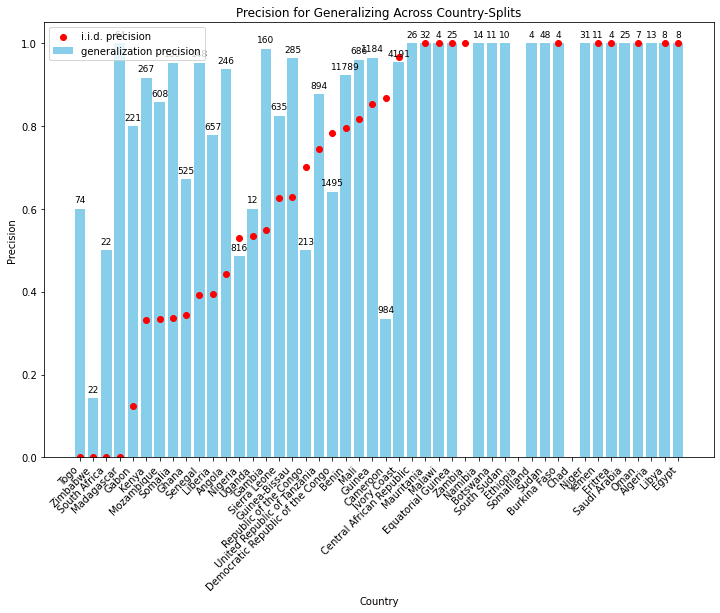

In [31]:
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Count the number of samples in train_loader for each country
country_sample_counts = {}

for country_name, data in train_test_splits.items():
    # Count the number of samples in the 'train_loader' for each country
    sample_count = len(data['train_loader'].dataset)
    country_sample_counts[country_name] = sample_count

# Step 2: Sort countries by number of samples (increasing order)
sorted_countries = sorted(precShiftedtrain, key=precShiftedtrain.get)

# Step 3: Prepare the data for plotting
sorted_f1_scores = [precShifted[country] for country in sorted_countries]
sorted_sample_counts = [country_sample_counts[country] for country in sorted_countries]
sorted_baseprecision = [precShiftedtrain[country] for country in sorted_countries]

# Step 4: Create the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot of f1-scores, ordered by sample count
ax.bar(sorted_countries, sorted_f1_scores, color='skyblue',label='generalization precision')
ax.scatter(sorted_countries, sorted_baseprecision, color='red',label='i.i.d. precision')

# Add labels and title
ax.set_xlabel('Country')
ax.set_ylabel('Precision')
ax.set_title('Precision for Generalizing Across Country-Splits')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Add sample count as annotations
for i, (country, sample_count) in enumerate(zip(sorted_countries, sorted_sample_counts)):
    ax.text(i, sorted_f1_scores[i] + 0.01, f"{sample_count}", ha='center', va='bottom', fontsize=9)


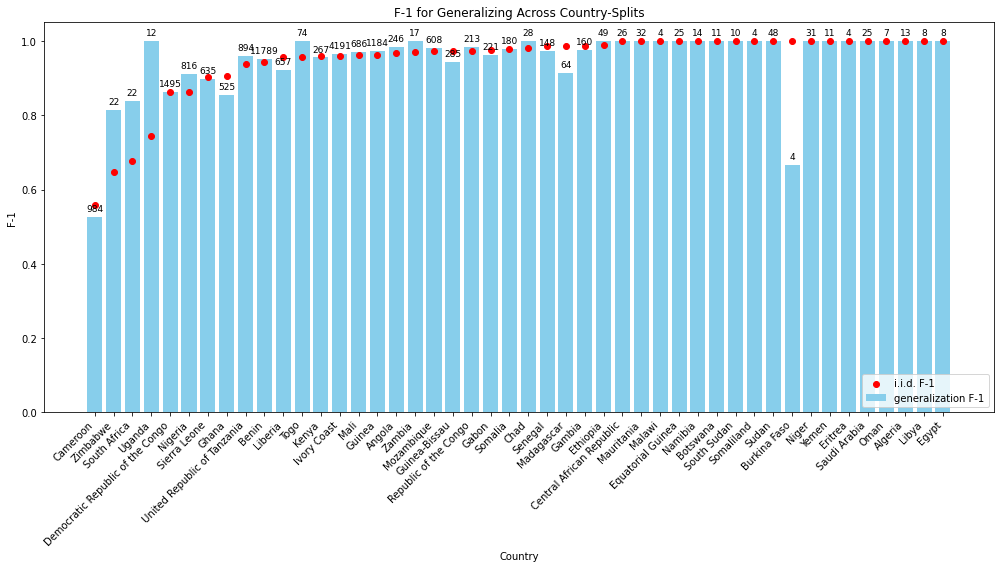

In [47]:
import matplotlib.pyplot as plt
import numpy as np

country_sample_counts = {}

for country_name, data in train_test_splits.items():
    # Count the number of samples in the 'train_loader' for each country
    sample_count = len(data['train_loader'].dataset)
    country_sample_counts[country_name] = sample_count

# Step 2: Sort countries by number of samples (increasing order)
sorted_countries = sorted(f1sShifted, key=f1sShifted.get)

# Step 3: Prepare the data for plotting
sorted_f1_scores = [f1sShiftedVal[country] for country in sorted_countries]
sorted_sample_counts = [country_sample_counts[country] for country in sorted_countries]
sorted_baseprecision = [f1sShifted[country] for country in sorted_countries]

# Step 4: Create the bar plot
fig, ax = plt.subplots(figsize=(14, 8))

# Bar plot of f1-scores, ordered by sample count
ax.bar(sorted_countries, sorted_f1_scores, color='skyblue',label='generalization F-1')
ax.scatter(sorted_countries, sorted_baseprecision, color='red',label='i.i.d. F-1')

# Add labels and title
ax.set_xlabel('Country')
ax.set_ylabel('F-1')
ax.set_title('F-1 for Generalizing Across Country-Splits')
ax.legend(loc='lower right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Add sample count as annotations
for i, (country, sample_count) in enumerate(zip(sorted_countries, sorted_sample_counts)):
    ax.text(i, sorted_f1_scores[i] + 0.01, f"{sample_count}", ha='center', va='bottom', fontsize=9)

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_11957/2379372630.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sorted_countries, rotation=45, ha='right')


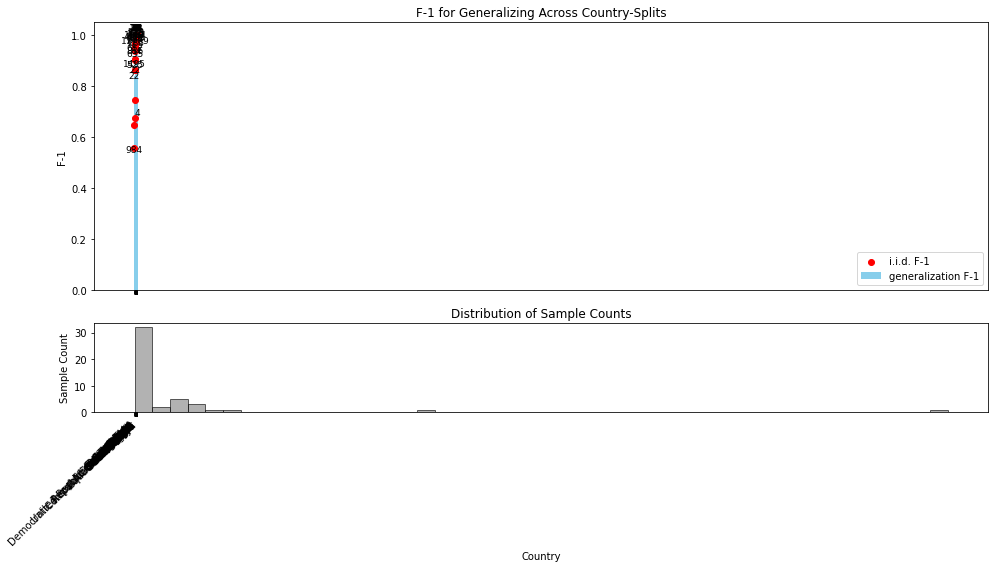

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_test_splits, f1sShifted, and other variables are defined earlier
country_sample_counts = {}

# Collect the sample counts for each country
for country_name, data in train_test_splits.items():
    sample_count = len(data['train_loader'].dataset)
    country_sample_counts[country_name] = sample_count

# Sort countries by the number of samples (increasing order)
sorted_countries = sorted(f1sShifted, key=f1sShifted.get)

# Prepare the data for plotting
sorted_f1_scores = [f1sShiftedVal[country] for country in sorted_countries]
sorted_sample_counts = [country_sample_counts[country] for country in sorted_countries]
sorted_baseprecision = [f1sShifted[country] for country in sorted_countries]

# Create the figure with two subplots (one for the F1 scores, one for the histogram)
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Bar plot of F1 scores on the first axis
bars = ax1.bar(sorted_countries, sorted_f1_scores, color='skyblue', label='generalization F-1', width=0.7)
ax1.scatter(sorted_countries, sorted_baseprecision, color='red', label='i.i.d. F-1')

# Set labels and title for the first plot (F1 scores)
ax1.set_ylabel('F-1')
ax1.set_title('F-1 for Generalizing Across Country-Splits')
ax1.legend(loc='lower right')

# Rotate x-axis labels for readability
ax1.set_xticklabels(sorted_countries, rotation=45, ha='right')

# Add sample count annotations (optional)
for i, (country, sample_count) in enumerate(zip(sorted_countries, sorted_sample_counts)):
    ax1.text(i, sorted_f1_scores[i] + 0.01, f"{sample_count}", ha='center', va='bottom', fontsize=9)

ax2.set_xticks(sorted_countries)
ax2.set_xticklabels(sorted_countries, rotation=45, ha='right')
# Create the histogram (CDF) on the second axis
ax2.hist(sorted_sample_counts, bins=len(sorted_countries), color='gray', edgecolor='black', alpha=0.6, orientation='vertical')

# Set labels and title for the second plot (histogram / CDF)
ax2.set_xlabel('Country')
ax2.set_ylabel('Sample Count')
ax2.set_title('Distribution of Sample Counts')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

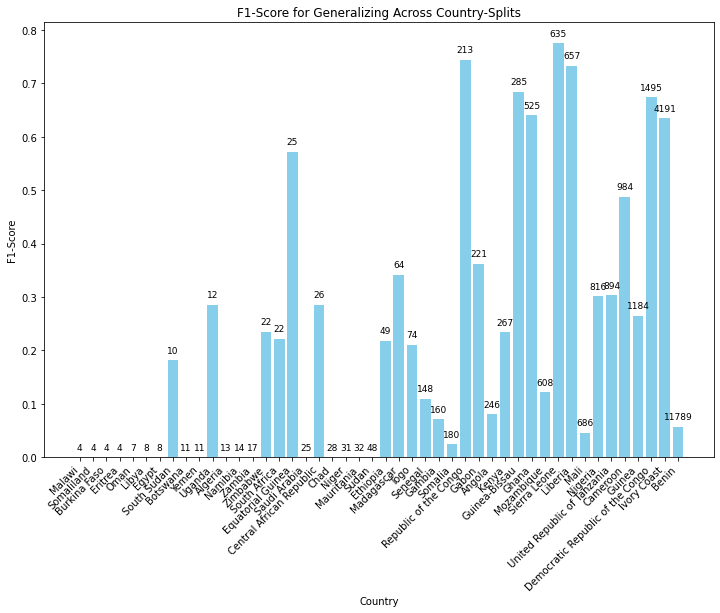

In [83]:
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Count the number of samples in train_loader for each country
country_sample_counts = {}

for country_name, data in train_test_splits.items():
    # Count the number of samples in the 'train_loader' for each country
    sample_count = len(data['train_loader'].dataset)
    country_sample_counts[country_name] = sample_count

# Step 2: Sort countries by number of samples (increasing order)
sorted_countries = sorted(country_sample_counts, key=country_sample_counts.get)

# Step 3: Prepare the data for plotting
sorted_f1_scores = [f1sShifted[country] for country in sorted_countries]
sorted_sample_counts = [country_sample_counts[country] for country in sorted_countries]

# Step 4: Create the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot of f1-scores, ordered by sample count
ax.bar(sorted_countries, sorted_f1_scores, color='skyblue')

# Add labels and title
ax.set_xlabel('Country')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score for Generalizing Across Country-Splits')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Add sample count as annotations
for i, (country, sample_count) in enumerate(zip(sorted_countries, sorted_sample_counts)):
    ax.text(i, sorted_f1_scores[i] + 0.01, f"{sample_count}", ha='center', va='bottom', fontsize=9)


In [ ]:
f1sShiftedfull = {}

lens = []
for k in train_test_splits.keys():
    print(k)
    f1sShiftedfull[k] = distShiftNew(train_test_splits[k]['train_loader'],train_test_splits[k]['val_loader'],'manual-FULL-trimodal.pt')



In [ ]:
plt.plot(f1sShifted.keys(),f1sShifted.values())

In [ ]:
print(f1sShifted)

In [5]:
values = [df.values.flatten() for df in imagesS1e]
imgsS1e = np.array(values)
values = [df.values.flatten() for df in imagesS12e]
imgsS12e = np.array(values)
values = [df.values.flatten() for df in imagesS1w]
imgsS1w = np.array(values)
values = [df.values.flatten()[:4] for df in imagesS12w]
imgsS12w = np.array(values)
values = [df.values.flatten() for df in imagesS1c]
imgsS1c = np.array(values)
values = [df.values.flatten() for df in imagesS12c]
imgsS12c = np.array(values)
values = [df.values.flatten() for df in imagesS1]
imgsS1 = np.array(values)

In [6]:
'''
del train_datasete, train_datasetw, train_datasetc, full_val_ds, full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset
del train_loadere, train_loaderw, train_loaderc, full_val_loader,  
del cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset
'''

'\ndel train_datasete, train_datasetw, train_datasetc, full_val_ds, full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset\ndel train_loadere, train_loaderw, train_loaderc, full_val_loader,  \ndel cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset\n'

In [6]:

if distshift:
    imgse = np.concatenate((imagese,images2e))
    imgsCHMe = np.concatenate((imagesCHMe,imagesCHM2e))
    imgsS1e = np.concatenate((imgsS1e,imgsS12e))
    labse = np.concatenate((labelse,labels2e))
    pthse = np.concatenate((pathse,paths2e))
    train_imagese, val_imagese, train_imagesCHMe, val_imagesCHMe, train_imagesS1e, val_imagesS1e,  train_labelse, val_labelse, train_pathse, val_pathse = train_test_split(imgse, imgsCHMe, imgsS1e, labse, pthse, test_size=0.2, random_state=42)

    imgsw = np.concatenate((imagesw,images2w))
    imgsCHMw = np.concatenate((imagesCHMw,imagesCHM2w))
    imgsS1w = np.concatenate((imgsS1w,imgsS12w))
    labsw = np.concatenate((labelsw,labels2w))
    pthsw = np.concatenate((pathsw,paths2w))
    train_imagesw, val_imagesw, train_imagesCHMw, val_imagesCHMw, train_imagesS1w, val_imagesS1w, train_labelsw, val_labelsw, train_pathsw, val_pathsw = train_test_split(imgsw, imgsCHMw, imgsS1w, labsw, pthsw, test_size=0.2, random_state=42)

    imgsc = np.concatenate((images_c,images2_c))
    imgsCHMc = np.concatenate((imagesCHM_c,imagesCHM2_c))
    imgsS1c = np.concatenate((imgsS1c,imgsS12c))
    labsc = np.concatenate((labels_c,labels2_c))
    pthsc = np.concatenate((paths_c,paths2_c))
    train_imagesc, val_imagesc, train_imagesCHMc, val_imagesCHMc, train_imagesS1c, val_imagesS1c, train_labelsc, val_labelsc, train_pathsc, val_pathsc = train_test_split(imgsc, imgsCHMc, imgsS1c, labsc, pthsc, test_size=0.2, random_state=42)

    sdptimgs = images
    sdptimgsCHM = imagesCHM
    sdptimgsS1 = imgsS1
    sdptlabs = labels

    train_images_tensore = torch.tensor(train_imagese.astype('float32')).permute(0, 3, 1, 2)
    train_images_tensorw = torch.tensor(train_imagesw.astype('float32')).permute(0, 3, 1, 2)
    train_images_tensorc = torch.tensor(train_imagesc.astype('float32')).permute(0, 3, 1, 2)
    sdpt_images_tensor = torch.tensor(sdptimgs.astype('float32')).permute(0, 3, 1, 2)

    channel_indices = [5, 11, 17, 23]
    train_images_tensore = train_images_tensore[:, channel_indices, :, :]
    train_images_tensorw = train_images_tensorw[:, channel_indices, :, :]
    train_images_tensorc = train_images_tensorc[:, channel_indices, :, :]
    sdpt_images_tensor = sdpt_images_tensor[:, channel_indices, :, :]

    train_labels_tensore = torch.tensor(train_labelse)
    train_labels_tensorw = torch.tensor(train_labelsw)
    train_labels_tensorc = torch.tensor(train_labelsc)
    sdpt_labels_tensor = torch.tensor(sdptlabs)

    val_images_tensore = torch.tensor(val_imagese).permute(0, 3, 1, 2) #.unsqueeze(1)  # Add a channel dimension
    val_images_tensore = val_images_tensore[:, channel_indices, :, :]
    val_images_tensorw = torch.tensor(val_imagesw).permute(0, 3, 1, 2) #.unsqueeze(1)  # Add a channel dimension
    val_images_tensorw = val_images_tensorw[:, channel_indices, :, :]
    val_images_tensorc = torch.tensor(val_imagesc).permute(0, 3, 1, 2) #.unsqueeze(1)  # Add a channel dimension
    val_images_tensorc = val_images_tensorc[:, channel_indices, :, :]
    val_labels_tensore = torch.tensor(val_labelse)
    val_labels_tensorw = torch.tensor(val_labelsw)
    val_labels_tensorc = torch.tensor(val_labelsc)

    '''
    train_pathse = torch.tensor(train_pathse)
    train_pathsw = torch.tensor(train_pathsw)
    train_pathsc = torch.tensor(train_pathsc)

    val_pathse = torch.tensor(val_pathse)
    val_pathsw = torch.tensor(val_pathsw)
    val_pathsc = torch.tensor(val_pathsc)
    '''

    train_imagesCHM_tensore = torch.tensor(train_imagesCHMe,dtype=torch.float32).unsqueeze(1).float()#.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
    val_imagesCHM_tensore = torch.tensor(val_imagesCHMe,dtype=torch.float32).unsqueeze(1).float()#.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
    train_imagesCHM_tensorw = torch.tensor(train_imagesCHMw,dtype=torch.float32).unsqueeze(1).float()#.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
    val_imagesCHM_tensorw = torch.tensor(val_imagesCHMw,dtype=torch.float32).unsqueeze(1).float()#.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
    train_imagesCHM_tensorc = torch.tensor(train_imagesCHMc,dtype=torch.float32).unsqueeze(1).float()#.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
    val_imagesCHM_tensorc = torch.tensor(val_imagesCHMc,dtype=torch.float32).unsqueeze(1).float()#.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
    sdpt_imagesCHM_tensor = torch.tensor(sdptimgsCHM,dtype=torch.float32).unsqueeze(1).float()#.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    train_imagesS1_tensore = torch.tensor(train_imagesS1e)
    train_imagesS1_tensorw = torch.tensor(train_imagesS1w)
    train_imagesS1_tensorc = torch.tensor(train_imagesS1c)
    #sdpt_imagesS1_tensor = torch.tensor(sdptimgsS1)
    val_imagesS1_tensore = torch.tensor(val_imagesS1e)
    val_imagesS1_tensorw = torch.tensor(val_imagesS1w)
    val_imagesS1_tensorc = torch.tensor(val_imagesS1c)
    sdpt_imagesS1_tensor = torch.tensor(sdptimgsS1)
    
            
    # Use the custom dataset class
    train_datasete = PairedImageDataset(train_images_tensore, train_imagesCHM_tensore, train_imagesS1_tensore, train_labelse, train_pathse)
    val_datasete = PairedImageDataset(val_images_tensore, val_imagesCHM_tensore, val_imagesS1_tensore, val_labelse, val_pathse)
    train_loadere = DataLoader(train_datasete, batch_size=32, shuffle=True)
    val_loadere = DataLoader(val_datasete, batch_size=32)

#    etestw_loader = DataLoader(PairedImageDataset(torch.cat((train_images_tensorw,val_images_tensorw)), torch.cat((train_labelsw,val_labelsw)) ), batch_size=32)    
#    etestc_loader = DataLoader(PairedImageDataset(torch.cat((train_images_tensorc,val_images_tensorc)), torch.cat((train_labelsc,val_labelsc)) ), batch_size=32)    

    train_datasetw = PairedImageDataset(train_images_tensorw, train_imagesCHM_tensorw, train_imagesS1_tensorw, train_labelsw, train_pathsw)
    val_datasetw = PairedImageDataset(val_images_tensorw, val_imagesCHM_tensorw,val_imagesS1_tensorw,val_labelsw, val_pathsw)
    train_loaderw = DataLoader(train_datasetw, batch_size=32, shuffle=True)
    val_loaderw = DataLoader(val_datasetw, batch_size=32)
    
    train_datasetc = PairedImageDataset(train_images_tensorc, train_imagesCHM_tensorc, train_imagesS1_tensorc,train_labelsc, train_pathsc)
    val_datasetc = PairedImageDataset(val_images_tensorc, val_imagesCHM_tensorc,val_imagesS1_tensorc, val_labelsc, val_pathsc)
    train_loaderc = DataLoader(train_datasetc, batch_size=32, shuffle=True)
    val_loaderc = DataLoader(val_datasetc, batch_size=32)

    sdpt_dataset = PairedImageDataset(sdpt_images_tensor, sdpt_imagesCHM_tensor, sdpt_imagesS1_tensor, sdptlabs, paths)
    sdpt_loader = DataLoader(sdpt_dataset, batch_size=32, shuffle=True)

    #full_val_ds = sdpt_dataset.concatenate([val_datasete,val_datasetw,val_datasetc])
    #(torch.cat(sdpt_images_tensor, val_images_tensore, val_images_tensorw, val_images_tensorc), 
    #                                 torch.cat(sdpt_imagesCHM_tensor, val_imagesCHM_tensore, val_imagesCHM_tensorw, val_imagesCHM_tensorc), 
    #                                 torch.cat(sdpt_labels, val_labelse, val_labelsw, val_labelsc))
    #full_val_loader = DataLoader(full_val_ds,batch_size=32,shuffle=True)


In [7]:
print('starting up some new tif reading for mango, cashew')
print(time.perf_counter())
region = 'mango'
civimages, civimagesCHM, civS1, civlabels ,civpaths = preprocess_data_gcs_multi(bucket_name, orchardpath,region)
region = 'cashew'
cashimages, cashimagesCHM, cashS1, cashlabels, cashpaths = preprocess_data_gcs_multi(bucket_name, orchardpath, region)
cashimages2, cashimagesCHM2, cashS12, cashlabels2, cashpaths2 = preprocess_data_gcs_multi(bucket_name, forestpath, region)
print(time.perf_counter())


starting up some new tif reading for mango, cashew
4112.657843244
CIV
benin
not 40x40 mountdata/chmorchard-224m/benin/Image_Lat_9.001862521060138_Lon_2.4133059647365647.tif
benin
not 40x40 mountdata/chmforest-224m/benin/Image_Lat_9.001854806976363_Lon_2.5024834288973117.tif
not 40x40 mountdata/chmforest-224m/benin/Image_Lat_9.001926761650227_Lon_2.441314813659174.tif
not 40x40 mountdata/chmforest-224m/benin/Image_Lat_9.001930816980428_Lon_2.5533627172326505.tif
8752.056828177


In [8]:
print(len(cashimages), len(cashimages2), len(cashS1),len(cashS12))

print(len(civimages), len(civS1))

7283 7305 7283 7305
4608 4608


In [9]:
channel_indices = [5, 11, 17, 23]

values = [df.values.flatten() for df in cashS1]
cashimgsS1 = np.array(values)

values = [df.values.flatten() for df in cashS12]
cashimgsS12 = np.array(values)

cashimgs = np.concatenate((cashimages,cashimages2))
cashimgsCHM = np.concatenate((cashimagesCHM,cashimagesCHM2))
cashimgsS1 = np.concatenate((cashimgsS1,cashimgsS12))
print(cashimgsS1)
cashlabs = np.concatenate((cashlabels,cashlabels2))
cashpths = np.concatenate((cashpaths,cashpaths2))
#cashpths = np.ones_like(cashlabs)

cashtrain_images, cashval_images, cashtrain_imagesCHM, cashval_imagesCHM, cashtrain_imagesS1, cashval_imagesS1, cashtrain_labels, cashval_labels, cashtrain_paths, cashval_paths = train_test_split(cashimgs, cashimgsCHM, cashimgsS1, cashlabs, cashpths, test_size=0.2, random_state=42)

"""
#keep in case you want to load ALL cashew as train
cashtrainimages_tensor = torch.tensor(cashimgs.astype('float32')).permute(0, 3, 1, 2)
cashtrainimages_tensor = cashtrainimages_tensor[:, channel_indices, :, :]
cashtrainimagesCHM_tensor = torch.tensor(cashimgsCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
cashtrainS1_tensor = torch.tensor(cashimgsS1)
cashtrain_dataset = PairedImageDataset(cashtrainimages_tensor, cashtrainimagesCHM_tensor, cashtrainS1_tensor, cashlabs, cashpaths)
cashtrain_loader = DataLoader(cashtrain_dataset, batch_size=32, shuffle=True)
"""
cashtrainimages_tensor = torch.tensor(cashtrain_images.astype('float32')).permute(0, 3, 1, 2)
cashtrainimages_tensor = cashtrainimages_tensor[:, channel_indices, :, :]
cashtrainimagesCHM_tensor = torch.tensor(cashtrain_imagesCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
cashtrainS1_tensor = torch.tensor(cashtrain_imagesS1)
cashtrain_dataset = PairedImageDataset(cashtrainimages_tensor, cashtrainimagesCHM_tensor, cashtrainS1_tensor, cashtrain_labels, cashtrain_paths)
cashtrain_loader = DataLoader(cashtrain_dataset, batch_size=32, shuffle=True)

cashvalimages_tensor = torch.tensor(cashval_images.astype('float32')).permute(0, 3, 1, 2)
cashvalimages_tensor = cashvalimages_tensor[:, channel_indices, :, :]
cashvalimagesCHM_tensor = torch.tensor(cashval_imagesCHM, dtype=torch.float32).unsqueeze(1).float()  # Add a channel dimension
cashvalS1_tensor = torch.tensor(cashval_imagesS1)
cashval_dataset = PairedImageDataset(cashvalimages_tensor, cashvalimagesCHM_tensor, cashvalS1_tensor, cashval_labels, cashval_paths)
cashval_loader = DataLoader(cashval_dataset, batch_size=32, shuffle=True)


'''
values = [df.values.flatten() for df in civS1]
civimgsS1 = np.array(values)
civtrainimages_tensor = torch.tensor(civimages.astype('float32')).permute(0, 3, 1, 2)
civtrainimages_tensor = civtrainimages_tensor[:, channel_indices, :, :]
civtrainlabels_tensor = torch.tensor(civlabels)
civtrainimagesCHM_tensor = torch.tensor(civimagesCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
civtrainimagesS1_tensor = torch.tensor(civimgsS1)
civtrain_dataset = PairedImageDataset(civtrainimages_tensor, civtrainimagesCHM_tensor, civtrainimagesS1_tensor,civlabels, civpaths)
civtrain_loader = DataLoader(civtrain_dataset, batch_size=32, shuffle=True)
'''
#values = [df.values.flatten() for df in cashS1[:-1]]
#civS1 = np.array(values)
'''
civtrain_images, civval_images, civtrain_imagesCHM, civval_imagesCHM, civtrain_imagesS1, civval_imagesS1, civtrain_labels, civval_labels, civtrain_paths, civval_paths = train_test_split(civimages, civimagesCHM, civS1, civlabels, civpaths, test_size=0.2, random_state=42)

civtrainimages_tensor = torch.tensor(civtrain_images.astype('float32')).permute(0, 3, 1, 2)
civtrainimages_tensor = civtrainimages_tensor[:, channel_indices, :, :]
civtrainimagesCHM_tensor = torch.tensor(civtrain_imagesCHM, dtype=torch.float32).unsqueeze(1).float()  # Add a channel dimension
civtrainS1_tensor = torch.tensor(civtrain_imagesS1)
civtrain_dataset = PairedImageDataset(civtrainimages_tensor, civtrainimagesCHM_tensor, civtrainS1_tensor, civtrain_labels, civtrain_paths)
civtrain_loader = DataLoader(civtrain_dataset, batch_size=32, shuffle=True)

civvalimages_tensor = torch.tensor(civval_images.astype('float32')).permute(0, 3, 1, 2)
civvalimages_tensor = civvalimages_tensor[:, channel_indices, :, :]
civvalimagesCHM_tensor = torch.tensor(civval_imagesCHM, dtype=torch.float32).unsqueeze(1).float()  # Add a channel dimension
civvalS1_tensor = torch.tensor(civval_imagesS1)
civval_dataset = PairedImageDataset(civvalimages_tensor, civvalimagesCHM_tensor, civvalS1_tensor, civval_labels, civval_paths)
civval_loader = DataLoader(civval_dataset, batch_size=32, shuffle=True)


print('all loaded and done')
'''

[[-15.55652687   0.8598649    2.14018719  -8.92065235]
 [-16.46941513   1.17326498   2.62630709  -9.87472166]
 [-16.29568257   1.03854804   2.16850355  -9.5425593 ]
 ...
 [-14.70807815   1.28057339   2.37426506  -7.92568106]
 [-14.22367751   1.34499543   2.05255355  -7.83777399]
 [-14.65289028   1.32527072   2.20719005  -8.18174096]]


"\ncivtrain_images, civval_images, civtrain_imagesCHM, civval_imagesCHM, civtrain_imagesS1, civval_imagesS1, civtrain_labels, civval_labels, civtrain_paths, civval_paths = train_test_split(civimages, civimagesCHM, civS1, civlabels, civpaths, test_size=0.2, random_state=42)\n\ncivtrainimages_tensor = torch.tensor(civtrain_images.astype('float32')).permute(0, 3, 1, 2)\ncivtrainimages_tensor = civtrainimages_tensor[:, channel_indices, :, :]\ncivtrainimagesCHM_tensor = torch.tensor(civtrain_imagesCHM, dtype=torch.float32).unsqueeze(1).float()  # Add a channel dimension\ncivtrainS1_tensor = torch.tensor(civtrain_imagesS1)\ncivtrain_dataset = PairedImageDataset(civtrainimages_tensor, civtrainimagesCHM_tensor, civtrainS1_tensor, civtrain_labels, civtrain_paths)\ncivtrain_loader = DataLoader(civtrain_dataset, batch_size=32, shuffle=True)\n\ncivvalimages_tensor = torch.tensor(civval_images.astype('float32')).permute(0, 3, 1, 2)\ncivvalimages_tensor = civvalimages_tensor[:, channel_indices, :, :

In [10]:
civimgs = np.concatenate((civimages,cashimages2))
civimgsCHM = np.concatenate((civimagesCHM,cashimagesCHM2))
#civS1 = np.concatenate((civS1,cashimgsS12))
#print(cashimgsS1)
civlabs = np.concatenate((civlabels,cashlabels2))
civpths = np.concatenate((civpaths,cashpaths2))

civimgs = civimages
civimgsCHM = civimagesCHM
civlabs = civlabels
civpths = civpaths

values = [df.values.flatten() for df in civS1]
#vals = values #+ [df.values.flatten() for df in cashS12]
civimgsS1 = np.array(values)
civtrainimages_tensor = torch.tensor(civimgs.astype('float32')).permute(0, 3, 1, 2)
civtrainimages_tensor = civtrainimages_tensor[:, channel_indices, :, :]
civtrainlabels_tensor = torch.tensor(civlabs)
civtrainimagesCHM_tensor = torch.tensor(civimgsCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
civtrainimagesS1_tensor = torch.tensor(civimgsS1)
civtrain_dataset = PairedImageDataset(civtrainimages_tensor, civtrainimagesCHM_tensor, civtrainimagesS1_tensor,civlabs, civpths)
civtrain_loader = DataLoader(civtrain_dataset, batch_size=32, shuffle=True)

#print(civ
civtrain_images, civval_images, civtrain_imagesCHM, civval_imagesCHM, civtrain_imagesS1, civval_imagesS1, civtrain_labels, civval_labels, civtrain_paths, civval_paths = train_test_split(civimages, civimagesCHM, civimgsS1, civlabels, civpaths, test_size=0.2, random_state=42)

civtrainimages_tensor = torch.tensor(civtrain_images.astype('float32')).permute(0, 3, 1, 2)
civtrainimages_tensor = civtrainimages_tensor[:, channel_indices, :, :]
civtrainimagesCHM_tensor = torch.tensor(civtrain_imagesCHM, dtype=torch.float32).unsqueeze(1).float()  # Add a channel dimension
civtrainS1_tensor = torch.tensor(civtrain_imagesS1)
civtrain_dataset = PairedImageDataset(civtrainimages_tensor, civtrainimagesCHM_tensor, civtrainS1_tensor, civtrain_labels, civtrain_paths)
civtrain_loader = DataLoader(civtrain_dataset, batch_size=32, shuffle=True)

civvalimages_tensor = torch.tensor(civval_images.astype('float32')).permute(0, 3, 1, 2)
civvalimages_tensor = civvalimages_tensor[:, channel_indices, :, :]
civvalimagesCHM_tensor = torch.tensor(civval_imagesCHM, dtype=torch.float32).unsqueeze(1).float()  # Add a channel dimension
civvalS1_tensor = torch.tensor(civval_imagesS1)
civval_dataset = PairedImageDataset(civvalimages_tensor, civvalimagesCHM_tensor, civvalS1_tensor, civval_labels, civval_paths)
civval_loader = DataLoader(civval_dataset, batch_size=32, shuffle=True)


print('all loaded and done')


all loaded and done


In [11]:
print('beginning coco')
region = 'testcoco'
domains_coco = []
cocoimages, cocoimagesCHM, cocoimgsS1, cocolabels, cocopaths = preprocess_data_gcs_multi(bucket_name, orchardpath,region,domains_coco)
print('finished coco orchards')
cocoimages2, cocoimagesCHM2, cocoimgsS12, cocolabels2, cocopaths2 = preprocess_data_gcs_multi(bucket_name, forestpath,region,domains_coco)
print('finished the oil and coco')

cocoimgs = np.concatenate((cocoimages, cocoimages2))
cocoimgsCHM = np.concatenate((cocoimagesCHM, cocoimagesCHM2))
cocoimgsS1 = np.concatenate((cocoimgsS1,cocoimgsS12))
cocolabs = np.concatenate((cocolabels, cocolabels2))
cocopths = np.concatenate((cocopaths, cocopaths2))
cocotrainimages, cocovalimages, cocotrainimagesCHM, cocovalimagesCHM, cocotrainimagesS1, cocovalimagesS1, cocotrainlabels, cocovallabels, cocotrainpaths, cocovalpaths = train_test_split(cocoimgs, cocoimgsCHM, cocoimgsS1, cocolabs, cocopths, test_size=0.2, random_state=42)



beginning coco
Descals coco
mountdata/chmorchard-224m/Descalscoco/Image_Lat_10.837501759619093_Lon_-13.445835084428044.tif
mountdata/chmorchard-224m/Descalscoco/Image_Lat_4.187501667381544_Lon_9.412497917767288.tif
mountdata/chmorchard-224m/Descalscoco/Image_Lat_4.9958341290470525_Lon_7.379165673800177.tif
finished coco orchards
Descals coco
mountdata/chmforest-224m/Descalscoco/Image_Lat_-0.6791656814503417_Lon_9.129166636831334.tif
mountdata/chmforest-224m/Descalscoco/Image_Lat_-0.6958338011881224_Lon_9.945833158365735.tif
mountdata/chmforest-224m/Descalscoco/Image_Lat_-0.9625014214873463_Lon_40.84583385517486.tif
mountdata/chmforest-224m/Descalscoco/Image_Lat_-0.9708354813562368_Lon_40.020833273771565.tif
mountdata/chmforest-224m/Descalscoco/Image_Lat_-1.254166762292188_Lon_39.96249931379039.tif
mountdata/chmforest-224m/Descalscoco/Image_Lat_-1.4874981431158505_Lon_9.879165138515665.tif
mountdata/chmforest-224m/Descalscoco/Image_Lat_-10.087498798833712_Lon_14.662500806860752.tif
moun

In [12]:

cocotrainimages_tensor = torch.tensor(cocotrainimages.astype('float32')).permute(0, 3, 1, 2)
cocotrainimages_tensor = cocotrainimages_tensor[:, channel_indices, :, :]
cocotrainlabels_tensor = torch.tensor(cocotrainlabels)
cocovalimages_tensor = torch.tensor(cocovalimages).permute(0, 3, 1, 2) #.unsqueeze(1)  # Add a channel dimension
cocovalimages_tensor = cocovalimages_tensor[:, channel_indices, :, :]
cocovallabels_tensor = torch.tensor(cocovallabels)
cocotrainimagesCHM_tensor = torch.tensor(cocotrainimagesCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
cocovalimagesCHM_tensor = torch.tensor(cocovalimagesCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
cocotrainimagesS1_tensor = torch.tensor(cocotrainimagesS1)
cocovalimagesS1_tensor = torch.tensor(cocovalimagesS1)

cocotrain_dataset = PairedImageDataset(cocotrainimages_tensor, cocotrainimagesCHM_tensor, cocotrainimagesS1_tensor, cocotrainlabels, cocotrainpaths)
cocoval_dataset = PairedImageDataset(cocovalimages_tensor, cocovalimagesCHM_tensor, cocovalimagesS1_tensor, cocovallabels, cocovalpaths)
cocotrain_loader = DataLoader(cocotrain_dataset, batch_size=32, shuffle=True)
cocoval_loader = DataLoader(cocoval_dataset, batch_size=32)




In [13]:
print('beginning oil')
region = 'testoil'
domains_oil = []
oilimages, oilimagesCHM, oilimgsS1, oillabels, oilpaths = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_oil)
print('finished oil orchards')
oilimages2, oilimagesCHM2, oilimgsS12, oillabels2, oilpaths2 = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_oil)
print('finished the oil and oil')




beginning oil
Descals oil
mountdata/chmorchard-224m/Descalsoil/Image_Lat_-0.0027378880468157695_Lon_10.201134530079727.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_-0.02789167708930397_Lon_10.186401660199138.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_1.1072170870758788_Lon_19.79028865428138.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_2.2643404331419243_Lon_22.87124209974506.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_2.283920345867605_Lon_22.877979801436812.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_2.347703327336095_Lon_20.50292434823888.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_3.5566548049463416_Lon_10.09037045991213.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_3.6078006940293657_Lon_10.093291171102138.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_3.6279825853972616_Lon_10.080221545914489.tif
mountdata/chmorchard-224m/Descalsoil/Image_Lat_3.6775677891115794_Lon_9.902802833199983.tif
mountdata/chmorchard-224m/Descalsoil/Image_La

In [14]:
values = [df.values.flatten() for df in oilimgsS1]
oilS1 = np.array(values)

values = [df.values.flatten() for df in oilimgsS12]
oilS12 = np.array(values)

oilimgs = np.concatenate((oilimages, oilimages2))
oilimgsCHM = np.concatenate((oilimagesCHM, oilimagesCHM2))
oilimagesS1 = np.concatenate((oilS1, oilS12))
oillabs = np.concatenate((oillabels, oillabels2))
oilpaths = np.concatenate((oilpaths, oilpaths2))
oiltrainimages, oilvalimages, oiltrainimagesCHM, oilvalimagesCHM, oiltrainimagesS1, oilvalimagesS1, oiltrainlabels, oilvallabels, oiltrainpaths, oilvalpaths = train_test_split(oilimgs, oilimgsCHM, oilimagesS1, oillabs, oilpaths, test_size=0.2, random_state=42)



oiltrainimages_tensor = torch.tensor(oiltrainimages.astype('float32')).permute(0, 3, 1, 2)
oiltrainimages_tensor = oiltrainimages_tensor[:, channel_indices, :, :]
oiltrainlabels_tensor = torch.tensor(oiltrainlabels)
oilvalimages_tensor = torch.tensor(oilvalimages).permute(0, 3, 1, 2) #.unsqueeze(1)  # Add a channel dimension
oilvalimages_tensor = oilvalimages_tensor[:, channel_indices, :, :]
oilvallabels_tensor = torch.tensor(oilvallabels)
oiltrainimagesCHM_tensor = torch.tensor(oiltrainimagesCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
oilvalimagesCHM_tensor = torch.tensor(oilvalimagesCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
oiltrainimagesS1_tensor = torch.tensor(oiltrainimagesS1)
oilvalimagesS1_tensor = torch.tensor(oilvalimagesS1)

oiltrain_dataset = PairedImageDataset(oiltrainimages_tensor, oiltrainimagesCHM_tensor, oiltrainimagesS1_tensor, oiltrainlabels, oiltrainpaths)
oilval_dataset = PairedImageDataset(oilvalimages_tensor, oilvalimagesCHM_tensor, oilvalimagesS1_tensor, oilvallabels, oilvalpaths)
oiltrain_loader = DataLoader(oiltrain_dataset, batch_size=32, shuffle=True)
oilval_loader = DataLoader(oilval_dataset, batch_size=32)

In [15]:
del oilimgs, oilimgsCHM, oilimagesS1, oiltrainimages_tensor, oilvalimages_tensor, oiltrainimagesCHM_tensor, oilvalimagesCHM_tensor, oiltrainimagesS1_tensor, oilvalimagesS1_tensor
del cocoimgs, cocoimgsCHM, cocoimgsS1, cocotrainimages_tensor, cocovalimages_tensor, cocotrainimagesCHM_tensor, cocovalimagesCHM_tensor, cocotrainimagesS1_tensor, cocovalimagesS1_tensor
del cashimgs, cashimgsCHM, cashimgsS1, cashtrainimages_tensor, cashvalimages_tensor, cashtrainimagesCHM_tensor, cashvalimagesCHM_tensor, cashtrainS1_tensor, cashvalS1_tensor
del civimgs, civimgsCHM, civimgsS1, civtrainimages_tensor, civvalimages_tensor, civtrainimagesCHM_tensor, civvalimagesCHM_tensor, civtrainS1_tensor, civvalS1_tensor


In [16]:
print('beginning Fagan')
region = 'Fagan'
domains_f = []
fimages, fimagesCHM, fimgsS1, flabels, fpaths = preprocess_data_gcs_multi(bucket_name, orchardpath, region, domains_f)
print('finished Fagan orchards')
fimages2, fimagesCHM2, fimgsS12, flabels2, fpaths2 = preprocess_data_gcs_multi(bucket_name, forestpath, region, domains_f)
print('finished Fagan')




beginning Fagan
fagan data 1 & 2
finished Fagan orchards
fagan data 1 & 2
finished Fagan


In [17]:
values = [df.values.flatten() for df in fimgsS1]
fS1 = np.array(values)

values = [df.values.flatten() for df in fimgsS12]
fS12 = np.array(values)

fimgs = np.concatenate((fimages, fimages2))
fimgsCHM = np.concatenate((fimagesCHM, fimagesCHM2))
fimagesS1 = np.concatenate((fS1, fS12))
flabs = np.concatenate((flabels, flabels2))
fpaths = np.concatenate((fpaths, fpaths2))
ftrainimages, fvalimages, ftrainimagesCHM, fvalimagesCHM, ftrainimagesS1, fvalimagesS1, ftrainlabels, fvallabels, ftrainpaths, fvalpaths = train_test_split(fimgs, fimgsCHM, fimagesS1, flabs, fpaths, test_size=0.2, random_state=42)

ftrainimages_tensor = torch.tensor(ftrainimages.astype('float32')).permute(0, 3, 1, 2)
ftrainimages_tensor = ftrainimages_tensor[:, channel_indices, :, :]
ftrainlabels_tensor = torch.tensor(ftrainlabels)
fvalimages_tensor = torch.tensor(fvalimages).permute(0, 3, 1, 2) #.unsqueeze(1)  # Add a channel dimension
fvalimages_tensor = fvalimages_tensor[:, channel_indices, :, :]
fvallabels_tensor = torch.tensor(fvallabels)
ftrainimagesCHM_tensor = torch.tensor(ftrainimagesCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
fvalimagesCHM_tensor = torch.tensor(fvalimagesCHM, dtype=torch.float32).unsqueeze(1).float() #.permute(2, 0, 1)#.unsqueeze(1)  # Add a channel dimension
ftrainimagesS1_tensor = torch.tensor(ftrainimagesS1)
fvalimagesS1_tensor = torch.tensor(fvalimagesS1)

ftrain_dataset = PairedImageDataset(ftrainimages_tensor, ftrainimagesCHM_tensor, ftrainimagesS1_tensor, ftrainlabels, ftrainpaths)
fval_dataset = PairedImageDataset(fvalimages_tensor, fvalimagesCHM_tensor, fvalimagesS1_tensor, fvallabels, fvalpaths)
ftrain_loader = DataLoader(ftrain_dataset, batch_size=32, shuffle=True)
fval_loader = DataLoader(fval_dataset, batch_size=32)


In [18]:
del fimgs, fimgsCHM, fimagesS1, ftrainimages_tensor, fvalimages_tensor, ftrainimagesCHM_tensor,fvalimagesCHM_tensor, ftrainimagesS1_tensor, fvalimagesS1_tensor

del train_imagese, val_imagese, train_imagesCHMe, val_imagesCHMe, train_imagesS1e, val_imagesS1e,  train_labelse, val_labelse, train_pathse, val_pathse 
del train_imagesw, val_imagesw, train_imagesCHMw, val_imagesCHMw, train_imagesS1w, val_imagesS1w, train_labelsw, val_labelsw, train_pathsw, val_pathsw 
del train_imagesc, val_imagesc, train_imagesCHMc, val_imagesCHMc, train_imagesS1c, val_imagesS1c, train_labelsc, val_labelsc, train_pathsc, val_pathsc 
del imgse, imgsCHMe, imgsS1e, labse, pthse

del train_imagesS1_tensore, train_imagesS1_tensorw, train_imagesS1_tensorc, val_imagesS1_tensore, val_imagesS1_tensorw, val_imagesS1_tensorc, sdpt_imagesS1_tensor
    
#gc.collect()



In [19]:
full_trn_ds = train_datasete.concatenate([train_datasetw,train_datasetc])
#(torch.cat(sdpt_images_tensor, val_images_tensore, val_images_tensorw, val_images_tensorc), 
#                                 torch.cat(sdpt_imagesCHM_tensor, val_imagesCHM_tensore, val_imagesCHM_tensorw, val_imagesCHM_tensorc), 
#                                 torch.cat(sdpt_labels, val_labelse, val_labelsw, val_labelsc))
full_trn_loader = DataLoader(full_trn_ds,batch_size=32,shuffle=True, drop_last=True)

val_nosdpt_ds = val_datasete.concatenate([val_datasetw,val_datasetc])
val_nosdpt_loader = DataLoader(val_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)


In [20]:

everything_trn_ds = full_trn_ds.concatenate([cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset])
#(torch.cat(sdpt_images_tensor, val_images_tensore, val_images_tensorw, val_images_tensorc), 
#                                 torch.cat(sdpt_imagesCHM_tensor, val_imagesCHM_tensore, val_imagesCHM_tensorw, val_imagesCHM_tensorc), 
#                                 torch.cat(sdpt_labels, val_labelse, val_labelsw, val_labelsc))
everything_trn_loader = DataLoader(everything_trn_ds,batch_size=32,shuffle=True, drop_last=True)

everyval_nosdpt_ds = val_nosdpt_ds.concatenate([cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset])
everyval_nosdpt_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)

del full_trn_ds, val_nosdpt_ds, everything_trn_ds, everyval_nosdpt_ds


In [21]:
print('finished triple stream loader')

finished triple stream loader


In [23]:
print(len(imagese))
print(len(images2e))
print(len(images_c))
print(len(images2_c))
print(len(imagesw))
print(len(images2w))

print(len(cocoimages))
print(len(cocoimages2))
print(len(oilimages))
print(len(oilimages2))

print(len(cashimages))
print(len(cashimages2))
print(len(civimages))



#oilimages, oilimages2


528
1021
458
1001
1582
2440
69
1572
685
2579
7283
7305
4608


528
1021
458
1001
1582
2440
69
1572
685
2579
7283
7305
4608

In [22]:
import torch.nn.init as init
class MultiResNet(nn.Module):
    def __init__(self):
        super(MultiResNet, self).__init__()
        
        # First ResNet for grayscale CHM
        self.resnet_gray = models.resnet18(pretrained=True)
        self.resnet_gray.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Second ResNet for Sentinel-2 4-band
        self.resnet_24band = models.resnet18(pretrained=True)
        self.resnet_24band.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_features = self.resnet_gray.fc.in_features
        num_features24 = self.resnet_24band.fc.in_features

        self.fc_tabular = nn.Linear(4, 32)  # 4 tabular Sentinel-1 features
        
        
        # Concatenate the features from both streams
        self.fc = nn.Linear(num_features + num_features24+32,1)
        self.sigmoid = nn.Sigmoid() 

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
        
    def forward(self, x_gray, x_24band, tabular_features):
        
        # Forward pass through the grayscale ResNet
        x_gray = self.resnet_gray.conv1(x_gray)
        x_gray = self.resnet_gray.bn1(x_gray)
        x_gray = self.resnet_gray.relu(x_gray)
        x_gray = self.resnet_gray.maxpool(x_gray)
        x_gray = self.resnet_gray.layer1(x_gray)
        x_gray = self.resnet_gray.layer2(x_gray)
        x_gray = self.resnet_gray.layer3(x_gray)
        x_gray = self.resnet_gray.layer4(x_gray)
        x_gray = self.resnet_gray.avgpool(x_gray)
        x_gray = torch.flatten(x_gray, 1)

        x_24band = self.resnet_24band.conv1(x_24band)
        x_24band = self.resnet_24band.bn1(x_24band)
        x_24band = self.resnet_24band.relu(x_24band)
        x_24band = self.resnet_24band.maxpool(x_24band)
        x_24band = self.resnet_24band.layer1(x_24band)
        x_24band = self.resnet_24band.layer2(x_24band)
        x_24band = self.resnet_24band.layer3(x_24band)
        x_24band = self.resnet_24band.layer4(x_24band)
        x_24band = self.resnet_24band.avgpool(x_24band)
        x_24band = torch.flatten(x_24band, 1)
        
        x3 = self.fc_tabular(tabular_features)
        x3 = x3[:x_gray.size(0)]
        
        x = torch.cat((x_gray, x_24band,x3),dim=1)#, x3), dim=1)
        x = self.fc(x)

        
        x = self.sigmoid(x)   
        return x

# Example usage
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_classes = 2
import torch.nn.init as init
class MultiResNet(nn.Module):
    def __init__(self):
        super(MultiResNet, self).__init__()
        
        # First VGG for grayscale images
        self.vgg_gray = models.vgg16(pretrained=True)
        self.vgg_gray.features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.transform_layer = nn.Conv2d(4, 3, kernel_size=1)  # A 1x1 convolution can be effective for this

        # Second VGG for 24-band images (adjusted for 40x40 input)
        self.vgg_24band = models.vgg16(pretrained=True)
        #self.vgg_24band.features[0] = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #nn.init.kaiming_normal_(self.vgg_24band.features[0].weight, mode='fan_out', nonlinearity='relu')

        
        # Replace pooling layers to better suit smaller input size
        #self.vgg_24band.features[5] = nn.MaxPool2d(kernel_size=2, stride=1)  # Change pooling layers as needed
        #self.vgg_24band.features[12] = nn.MaxPool2d(kernel_size=2, stride=1)
        #self.vgg_24band.features[19] = nn.MaxPool2d(kernel_size=2, stride=1)

        
        # Calculate output size after the features for 40x40 input
        #dummy_input = torch.randn(1, 4, 40, 40)  # Dummy input for shape calculation
        #output_features = self.vgg_24band.features(dummy_input)
        #flattened_size = output_features.view(output_features.size(0), -1).size(1)

        # Adjust the classifier's first layer based on flattened size
        #self.vgg_24band.classifier[0] = nn.Linear(flattened_size, 4096)

        # Get the number of features in the final layer for both models
        num_features_gray = self.vgg_gray.classifier[-1].in_features
        num_features_24band = self.vgg_24band.classifier[-1].in_features
        
        # Replace the final layer for both models
        self.vgg_gray.classifier[-1] = nn.Linear(num_features_gray, 2)
        self.vgg_24band.classifier[-1] = nn.Linear(num_features_24band, 2)
        # Fully connected layers for tabular data
        self.fc_tabular = nn.Linear(4, 32)  # 4 tabular features
        
        
        # Concatenate the features from both streams
        self.fc = nn.Linear(num_features_gray + num_features_24band+32,1)# + 32, 1)  # Adjust the output size as needed
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

        #self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)

    def forward(self, x_gray, x_24band, tabular_features):
        # Forward pass through the grayscale VGG

        x_gray = self.vgg_gray.features(x_gray)
        x_gray = torch.flatten(x_gray, 1)
        x_gray = self.vgg_gray.classifier(x_gray)

        #print(f"Shape after features: {x.shape}")  # Check shape here
        #x = torch.flatten(x, 1)  # Flatten for the classifier
        #print(f"Shape after flattening: {x.shape}")  # Check shape here

        x_24band = self.transform_layer(x_24band)
        # Forward pass through the 24-band VGG
        x_24band = self.vgg_24band.features(x_24band)
        #print("Shape after VGG features:", x_vgg.shape)  # Debugging statement

        x_24band = torch.flatten(x_24band, 1)
        x_24band = self.vgg_24band.classifier(x_24band)

        # Forward pass through the tabular features
        x_tabular = self.fc_tabular(tabular_features)

        # Concatenate the features from both streams
        x = torch.cat((x_gray, x_24band, x_tabular), dim=1)

        # Classification head
        x = self.fc(x)
        x = self.sigmoid(x)
   
        return x


In [8]:
from functools import partial

import torch
import torch.nn as nn

import timm.models.vision_transformer
from pos_embed import get_2d_sincos_pos_embed


class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        # Added by Samar, need default pos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches ** .5),
                                            cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome


def vit_base_patch16(**kwargs):
    model = VisionTransformer(
        embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large_patch16(**kwargs):
    model = VisionTransformer(
        embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_huge_patch14(**kwargs):
    model = VisionTransformer(
        embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

class DualStreamVisionTransformer(nn.Module):
    def __init__(self, model1, model2):
        super(DualStreamVisionTransformer, self).__init__()
        self.model1 = model1
        self.model2 = model2
        model1.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
        model2.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
        self.fc = nn.Linear(2000, 1)

    def forward(self, x1, x2):
        # Forward pass through both streams
        features1 = self.model1(x1)
        features2 = self.model2(x2)

        # Combine the features (e.g., by concatenation or averaging)
        combined_features = torch.cat((features1, features2), dim=1)
        combined_features = self.fc(combined_features)
        return combined_features

def create_dual_stream_vit(model_fn1, model_fn2, **kwargs):
    model1 = model_fn1(**kwargs)
    model2 = model_fn2(**kwargs)
    return DualStreamVisionTransformer(model1, model2)



In [23]:
from sklearn.metrics import confusion_matrix
def plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions, correct, total):
    
    # Extract the training and validation accuracy from the model history
    train_accuracy = trn_acc_list
    val_accuracy = val_acc_list
    
    # Get the number of epochs
    epochs = range(len(train_accuracy))
    
    # Create the plot
    plt.plot(epochs, train_accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()
    
    # Extract the training and validation accuracy from the model history
    train_losses = trn_loss_list
    val_losses = val_loss_list
    
    # Get the number of epochs
    epochs = range(len(train_accuracy))
    
    # Create the plot
    plt.plot(epochs, train_losses, label='Training loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
    
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
#    print('val loss')
#    print(val_loss / len(val_loader.dataset))
        
    print_cm(all_predictions,all_labels)

def print_cm(all_predictions,all_labels):
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Extract true positives, negatives, false positives, and negatives
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate Precision, Recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    # Print results (you can modify this for your needs)
    print(f"Confusion Matrix:\n {cm}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")


    #previously: leak-free resulted in overfitting by epoch 3 with a peak val acc ~80%. 


In [10]:

def triplicate_channel(data):
  """
  Triplicates the channel dimension of a PyTorch tensor batch.

  Args:
    batch: A dictionary or tuple containing the data loaded by a DataLoader.
      Usually, the key 'data' holds the actual tensor batch.

  Returns:
    A dictionary or tuple with the same structure as the input, but with the 
    data tensor having its channel dimension triplicated.
  """
  # Assuming the data is in the key 'data' within the batch
  if len(data.shape) == 3:
    # Add a new dimension of size 1 for the missing channel
    data = data.unsqueeze(1)
    # Repeat the channel 3 times
    repeated_channel = data.repeat(1, 3, 1, 1)
  elif len(data.shape) == 4 and data.shape[1] == 1:
    # Existing single channel, repeat it 3 times
    repeated_channel = data.repeat(1, 3, 1, 1)
  else:
    # Already has 3 or more channels, no change needed
    repeated_channel = data
  return repeated_channel


In [11]:
def vit_small_patch8(input_size=(40, 40), **kwargs):
    model = VisionTransformer(
        embed_dim=512, depth=8, num_heads=8, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), img_size=input_size[0], **kwargs
    )
    model.patch_embed.patch_size = (8, 8)  # Adjust patch size
    model.patch_embed.num_patches = (input_size[0] // model.patch_embed.patch_size[0]) * (input_size[1] // model.patch_embed.patch_size[1])
    return model


In [29]:
mode = 'resnet'
from sklearn.metrics import f1_score

def trainNew(train_loader,val_loader, modelpath, test_loaders=[]):
    #############
    #### TRIMODAL
    ##############
    trimod = True
    if mode == 'resnet':
        model = MultiResNet()
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

    if mode == 'satmae':
        trimod = False
        #m1 = VisionTransformer()
        #m1.to(device)
        #m1.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
        #criterion = nn.CrossEntropyLoss()
        #optimizer = optim.Adam(m1.parameters(), lr=0.001)
        #m2 = vit_small_patch8()
        #m2.to(device)
        #m2.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
        #criterion = nn.CrossEntropyLoss()
        #optimizer = optim.Adam(m2.parameters(), lr=0.001)
        model = create_dual_stream_vit(vit_base_patch16, vit_small_patch8)
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    model.train()

    print('training start')
    trn_acc_list = []
    val_acc_list = []
    trn_loss_list = []
    val_loss_list = []
    all_predictions = []
    all_labels = []
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_model_state_dict = None
        
    # Train the model
    num_epochs = 40
    for epoch in range(num_epochs):
    
        model.train()
        correct = 0
        total = 0
        train_loss = 0.0
    
        for inputs, inputsCHM, s1, labs, paths in train_loader:

            inputs = inputs.to("cuda")
            if mode == 'satmae':
                inputsCHM = triplicate_channel(inputsCHM).to(device)
            else:
                inputsCHM = inputsCHM.to(device)
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()
            
            #if torch.isnan(inputs).any() or torch.isnan(inputsCHM).any() or torch.isnan(s1).any() or torch.isnan(labs).any():
            nan_indices = torch.isnan(s1)
            if nan_indices.any():
            #if torch.isnan(s1).any():
                print("Skipping batch due to NaNs.")
                continue
                    
            for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
                channel_data = inputs[:, c, :, :]
                mask = torch.isnan(channel_data)
                mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
                
                channel_data[mask] = mean_val.expand_as(channel_data)[mask]
                inputs[:, c, :, :] = channel_data
            if torch.isnan(inputs).any():
                raise ValueError("NaNs found in inputs after interpolation")
        
            # Check for NaNs in inputsCHM and labs
            if torch.isnan(inputsCHM).any():
                raise ValueError("NaNs found in inputsCHM")

            if torch.isnan(s1).any():
                print(torch.isnan(s1))
                print("NaNs found in S1!")
        
            if torch.isnan(labs).any():
                raise ValueError("NaNs found in labs")
            
            optimizer.zero_grad()
            if trimod:
                outputs = model(inputsCHM,inputs,s1)
            else:
                outputs = model(inputsCHM,inputs[:, :3, :, :])
            if torch.isnan(outputs).any():
                print(f"Inputs: {inputs[0][0]}")
                print(f"Model outputs: {outputs}")
                raise ValueError("NaNs found in model outputs")
    
            loss = criterion(outputs, labs.float())
            if torch.isnan(loss).any():
                raise ValueError("NaNs found in loss")
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        trn_acc_list.append(correct/total * 100)
        trn_loss_list.append(train_loss/len(train_loader.dataset))
    
        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in val_loader:
    
                inputs= inputs.to("cuda")
                
                if mode == 'satmae':
                    inputsCHM = triplicate_channel(inputsCHM).to(device)
                else:
                    inputsCHM = inputsCHM.to(device)
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                if trimod:
                    outputs = model(inputsCHM,inputs,s1)
                else:
                    outputs = model(inputsCHM,inputs[:, :3, :, :])
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
            val_acc_list.append(correct/total * 100)
            val_loss_list.append(val_loss / len(val_loader.dataset))
            val_acc = correct/total * 100
            if val_acc > best_val_acc:
                print(f"Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%. Saving the model.")
                best_val_acc = val_acc
                best_model_state_dict = model.state_dict()
    
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
              f'Train Acc: {trn_acc_list[-1]:.4f}, '
              #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
              f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )

        

        if epoch == num_epochs-1: 
            torch.save(model.state_dict(), modelpath)
    
    
    plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions, correct, total)

    for tl in test_loaders:
        print(tl)
         # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in tl:
    
                inputs= inputs.to("cuda")
                
                if mode == 'satmae':
                    inputsCHM = triplicate_channel(inputsCHM).to(device)
                else:
                    inputsCHM = inputsCHM.to(device)
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                if trimod:
                    outputs = model(inputsCHM,inputs,s1)
                else:
                    outputs = model(inputsCHM,inputs[:, :3, :, :])
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())

        f1 = f1_score(all_labels, all_predictions, average='weighted')  # or 'macro', 'micro', depending on your needs
    
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Val Loss: {val_loss/len(tl.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}',
              f'F1 score: {f1:.4f}')
        print_cm(all_labels,all_predictions)
    return #model#, all_labels, all_predictions





In [ ]:
mode = 'resnet'
from sklearn.metrics import f1_score

def trainNew(train_loader,val_loader, modelpath, test_loaders=[]):
    #############
    #### TRIMODAL
    ##############
    trimod = True
    if mode == 'resnet':
        model = MultiResNet()
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

    model.train()

    print('training start')
    trn_acc_list = []
    val_acc_list = []
    trn_loss_list = []
    val_loss_list = []
    all_predictions = []
    all_labels = []
    
    # Train the model

    num_epochs = 30
    for epoch in range(num_epochs):
    
        model.train()
        correct = 0
        total = 0
        train_loss = 0.0
    
        for inputs, inputsCHM, s1, labs, paths in train_loader:

            inputs = inputs.to("cuda")
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()
            
            #if torch.isnan(inputs).any() or torch.isnan(inputsCHM).any() or torch.isnan(s1).any() or torch.isnan(labs).any():
            nan_indices = torch.isnan(s1)
            if nan_indices.any():
            #if torch.isnan(s1).any():
                print("Skipping batch due to NaNs.")
                continue

                    
            for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
                channel_data = inputs[:, c, :, :]
                mask = torch.isnan(channel_data)
                mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
                
                channel_data[mask] = mean_val.expand_as(channel_data)[mask]
                inputs[:, c, :, :] = channel_data
            if torch.isnan(inputs).any():
                raise ValueError("NaNs found in inputs after interpolation")
        
            # Check for NaNs in inputsCHM and labs
            if torch.isnan(inputsCHM).any():
                raise ValueError("NaNs found in inputsCHM")

            if torch.isnan(s1).any():
                print(torch.isnan(s1))
                print("NaNs found in S1!")
        
            if torch.isnan(labs).any():
                raise ValueError("NaNs found in labs")
            
            optimizer.zero_grad()
            if trimod:
                outputs = model(inputsCHM,inputs,s1)
            else:
                outputs = model(inputsCHM,inputs[:, :3, :, :])
            if torch.isnan(outputs).any():
                print(f"Inputs: {inputs[0][0]}")
                print(f"Model outputs: {outputs}")
                raise ValueError("NaNs found in model outputs")
    
            loss = criterion(outputs, labs.float())
            if torch.isnan(loss).any():
                raise ValueError("NaNs found in loss")
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        trn_acc_list.append(correct/total * 100)
        trn_loss_list.append(train_loss/len(train_loader.dataset))
    
        if epoch == 29: 
            torch.save(model.state_dict(), modelpath)
    
    
        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in val_loader:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = inputsCHM.to("cuda")
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                if trimod:
                    outputs = model(inputsCHM,inputs,s1)
                else:
                    outputs = model(inputsCHM,inputs[:, :3, :, :])
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
            val_acc_list.append(correct/total * 100)
            val_loss_list.append(val_loss / len(val_loader.dataset))
    
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
              f'Train Acc: {trn_acc_list[-1]:.4f}, '
              #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
              f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )
    
    plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions, correct, total)
    return ff #model#, all_labels, all_predictions


trainNew(everything_trn_loader,everyval_nosdpt_loader,'manual-FULL-trimodal.pt')

training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

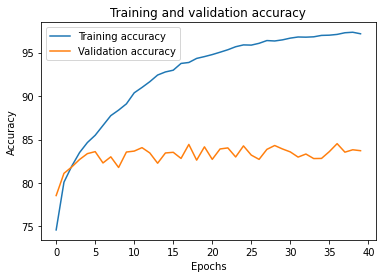

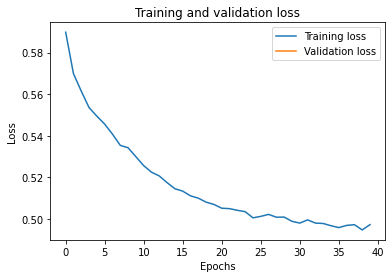

acc %
83.71629901960785
total INCORRECT total examples in val number of correct examples in val
1063 6528 5465
Confusion Matrix:
 [[119714  16087]
 [ 27839  97480]]
True Positives: 97480
False Positives: 16087
True Negatives: 119714
False Negatives: 27839
Precision: 0.8583
Recall: 0.7779


In [30]:
trainNew(everything_trn_loader,everyval_nosdpt_loader,'manual-FULL-trimodal.pt')

# Initial Trimodal

In [67]:
model = None
m1=None
m2=None
torch.cuda.empty_cache()

import gc

gc.collect()


9809

/tmp/ipykernel_1508/1661084741.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
/tmp/ipyke

training start
Epoch 1/20, Train Loss: 0.1815, Train Acc: 95.8079, Val Loss: 0.1718, Val Acc: 95.74
Epoch 2/20, Train Loss: 0.1836, Train Acc: 95.8079, Val Loss: 0.1831, Val Acc: 95.74
Epoch 3/20, Train Loss: 0.1794, Train Acc: 95.8079, Val Loss: 0.2292, Val Acc: 95.74
Epoch 4/20, Train Loss: 0.1714, Train Acc: 95.8079, Val Loss: 0.1658, Val Acc: 95.74
Epoch 5/20, Train Loss: 0.1866, Train Acc: 95.8079, Val Loss: 0.1894, Val Acc: 95.74
Epoch 6/20, Train Loss: 0.1772, Train Acc: 95.8079, Val Loss: 0.1673, Val Acc: 95.74
Epoch 7/20, Train Loss: 0.1833, Train Acc: 95.8079, Val Loss: 0.1895, Val Acc: 95.74
Epoch 8/20, Train Loss: 0.1717, Train Acc: 95.8079, Val Loss: 0.1641, Val Acc: 95.74
Epoch 9/20, Train Loss: 0.1645, Train Acc: 95.8079, Val Loss: 0.2250, Val Acc: 95.74
Epoch 10/20, Train Loss: 0.1940, Train Acc: 95.8079, Val Loss: 0.1735, Val Acc: 95.74
Epoch 11/20, Train Loss: 0.1668, Train Acc: 95.8079, Val Loss: 0.1632, Val Acc: 95.74
Epoch 12/20, Train Loss: 0.1699, Train Acc: 95.8

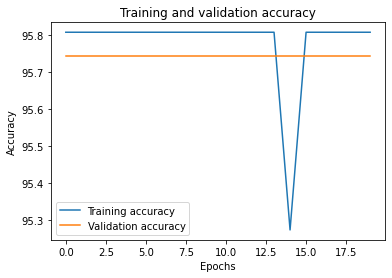

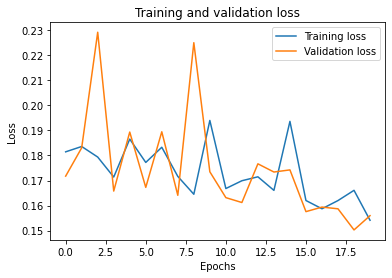

acc %
95.74468085106383
total INCORRECT total examples in val number of correct examples in val
14 329 315
Confusion Matrix:
 [[6300    0]
 [ 280    0]]
True Positives: 0
False Positives: 0
True Negatives: 6300
False Negatives: 280
Precision: nan
Recall: 0.0000


/tmp/ipykernel_1508/940130238.py:56: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


In [28]:
trainNew(cocotrain_loader,cocoval_loader, 'coco-iid-trimodal.pt')

/tmp/ipykernel_1508/1661084741.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
/tmp/ipyke

training start
Epoch 1/20, Train Loss: 0.5482, Train Acc: 78.9736, Val Loss: 0.5670, Val Acc: 74.43
Epoch 2/20, Train Loss: 0.5083, Train Acc: 80.1609, Val Loss: 0.5951, Val Acc: 74.43
Epoch 3/20, Train Loss: 0.4935, Train Acc: 80.1609, Val Loss: 0.5526, Val Acc: 74.43
Epoch 4/20, Train Loss: 0.5084, Train Acc: 79.2034, Val Loss: 0.5462, Val Acc: 74.43
Epoch 5/20, Train Loss: 0.4896, Train Acc: 79.4332, Val Loss: 0.5517, Val Acc: 74.43
Epoch 6/20, Train Loss: 0.4685, Train Acc: 80.1609, Val Loss: 0.5452, Val Acc: 74.43
Epoch 7/20, Train Loss: 0.4753, Train Acc: 80.1609, Val Loss: 0.5247, Val Acc: 74.43
Epoch 8/20, Train Loss: 0.4507, Train Acc: 80.1609, Val Loss: 0.5457, Val Acc: 74.43
Epoch 9/20, Train Loss: 0.4473, Train Acc: 80.1609, Val Loss: 0.5084, Val Acc: 74.43
Epoch 10/20, Train Loss: 0.4436, Train Acc: 80.0843, Val Loss: 0.5429, Val Acc: 74.43
Epoch 11/20, Train Loss: 0.4299, Train Acc: 80.1992, Val Loss: 0.5094, Val Acc: 75.96
Epoch 12/20, Train Loss: 0.4309, Train Acc: 80.6

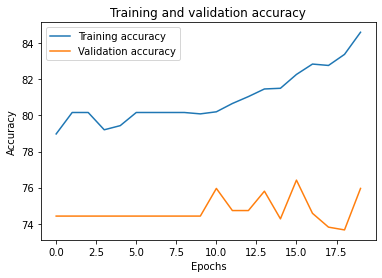

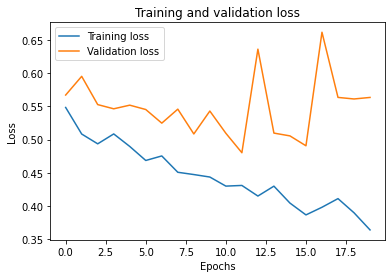

acc %
75.95712098009189
total INCORRECT total examples in val number of correct examples in val
157 653 496
Confusion Matrix:
 [[9539  181]
 [3122  218]]
True Positives: 218
False Positives: 181
True Negatives: 9539
False Negatives: 3122
Precision: 0.5464
Recall: 0.0653


In [29]:
trainNew(oiltrain_loader,oilval_loader, 'oil-iid-trimodal.pt')

/tmp/ipykernel_1508/1661084741.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
/tmp/ipyke

training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

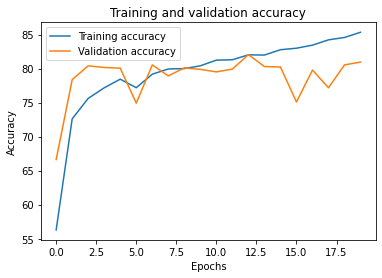

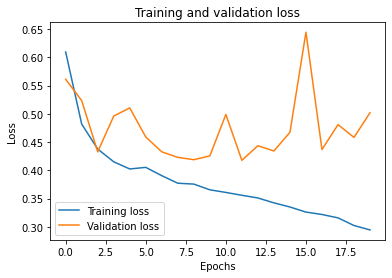

acc %
80.94585332419464
total INCORRECT total examples in val number of correct examples in val
556 2918 2362
Confusion Matrix:
 [[23924  5136]
 [ 7252 22048]]
True Positives: 22048
False Positives: 5136
True Negatives: 23924
False Negatives: 7252
Precision: 0.8111
Recall: 0.7525


In [30]:
trainNew(cashtrain_loader,cashval_loader, 'cash-iid-trimodal.pt')

In [ ]:
trainNew(civtrain_loader,civval_loader, 'civ-iid-trimodal.pt')

/tmp/ipykernel_1508/1661084741.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
/tmp/ipyke

training start
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.3433, Train Acc: 91.0093, Val Loss: 0.2777, Val Acc: 91.09
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.2694, Train Acc: 91.0941, Val Loss: 0.3295, Val Acc: 91.09
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.2788, Train Acc: 91.1790, Val Loss: 0.2711, Val Acc: 91.09
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.2667, Train Acc: 91.4334, Val Loss: 0.2842, Val Acc: 91.09
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.2740, Train Acc: 91.0941, Val Loss: 0.2519, Val Acc: 91.09
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.2694, Train Acc: 91.1790, Val Loss: 0.2575, Val Acc: 91.09
Skipping batch due to NaNs.
Epoch 7/20, Train Loss: 0.2535, Train Acc: 91.4334, Val Loss: 0.2551, Val Acc: 91.09
Skipping batch due to NaNs.
Epoch 8/20, Train Loss: 0.2621, Train Acc: 91.0941, Val Loss: 0.2620, Val Acc: 91.09
Skipping batch due to NaNs.
Epoch 9/20, Train Loss: 0.2649, Train Acc: 91.0093, V

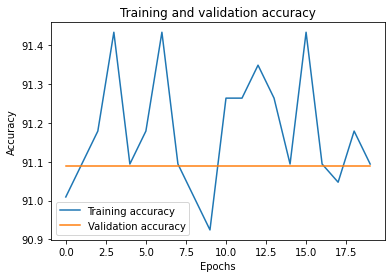

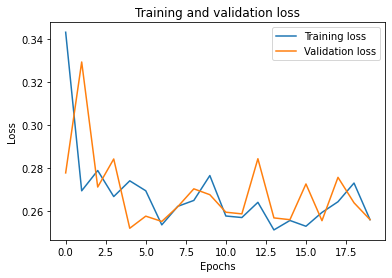

acc %
91.0891089108911
total INCORRECT total examples in val number of correct examples in val
27 303 276
Confusion Matrix:
 [[5520    0]
 [ 540    0]]
True Positives: 0
False Positives: 0
True Negatives: 5520
False Negatives: 540
Precision: nan
Recall: 0.0000


/tmp/ipykernel_1508/940130238.py:56: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


In [31]:
trainNew(ftrain_loader, fval_loader, 'fagan-iid-trimodal.pt')

/tmp/ipykernel_1508/1661084741.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
/tmp/ipyke

training start
Epoch 1/20, Train Loss: 0.6556, Train Acc: 63.6607, Val Loss: 0.5739, Val Acc: 61.70
Epoch 2/20, Train Loss: 0.5677, Train Acc: 67.6964, Val Loss: 0.5163, Val Acc: 72.53
Epoch 3/20, Train Loss: 0.5211, Train Acc: 72.6786, Val Loss: 0.4945, Val Acc: 74.71
Epoch 4/20, Train Loss: 0.4713, Train Acc: 76.8036, Val Loss: 0.6583, Val Acc: 70.13
Epoch 5/20, Train Loss: 0.4612, Train Acc: 78.5893, Val Loss: 0.6087, Val Acc: 67.73
Epoch 6/20, Train Loss: 0.4348, Train Acc: 79.2143, Val Loss: 0.4704, Val Acc: 74.42
Epoch 7/20, Train Loss: 0.4315, Train Acc: 79.8571, Val Loss: 0.4863, Val Acc: 72.24
Epoch 8/20, Train Loss: 0.4006, Train Acc: 81.5179, Val Loss: 0.4558, Val Acc: 79.36
Epoch 9/20, Train Loss: 0.3913, Train Acc: 82.6429, Val Loss: 0.4409, Val Acc: 79.58
Epoch 10/20, Train Loss: 0.3599, Train Acc: 83.9464, Val Loss: 0.4468, Val Acc: 78.27
Epoch 11/20, Train Loss: 0.3441, Train Acc: 85.4464, Val Loss: 0.5530, Val Acc: 76.02
Epoch 12/20, Train Loss: 0.3377, Train Acc: 85.7

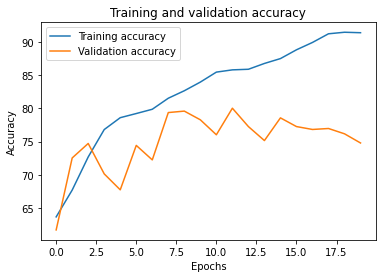

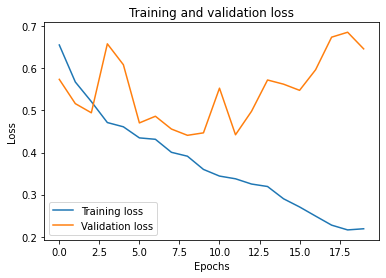

acc %
74.78197674418605
total INCORRECT total examples in val number of correct examples in val
347 1376 1029
Confusion Matrix:
 [[14835  2120]
 [ 4765  5800]]
True Positives: 5800
False Positives: 2120
True Negatives: 14835
False Negatives: 4765
Precision: 0.7323
Recall: 0.5490


In [32]:
trainNew(full_trn_loader,val_nosdpt_loader,'manual-iid-trimodal.pt')

In [ ]:
trainNew(everything_trn_loader,everyval_nosdpt_loader,'manual-iid-trimodal.pt')

/tmp/ipykernel_1508/1661084741.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
/tmp/ipyke

training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

# Bimodal S2 & CHM

In [ ]:
import torch.nn.init as init
class MultiResNet(nn.Module):
    def __init__(self):
        super(MultiResNet, self).__init__()
        
        # First ResNet for grayscale images
        self.resnet_gray = models.resnet18(pretrained=True)
        self.resnet_gray.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Second ResNet for 24-band images
        self.resnet_24band = models.resnet18(pretrained=True)
        self.resnet_24band.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Get the number of features in the final layer
        num_features = self.resnet_gray.fc.in_features
        num_features24 = self.resnet_24band.fc.in_features
        
        # Concatenate the features from both streams
        self.fc = nn.Linear(num_features + num_features24, 1)  # Adjust the output size as needed
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

        #self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
        
    def forward(self, x_gray, x_24band,_):
        
        # Forward pass through the grayscale ResNet
        x_gray = self.resnet_gray.conv1(x_gray)
        x_gray = self.resnet_gray.bn1(x_gray)
        x_gray = self.resnet_gray.relu(x_gray)
        x_gray = self.resnet_gray.maxpool(x_gray)
        #print('x_gray after maxpool')
        #print(x_gray)
        x_gray = self.resnet_gray.layer1(x_gray)
        x_gray = self.resnet_gray.layer2(x_gray)
        x_gray = self.resnet_gray.layer3(x_gray)
        x_gray = self.resnet_gray.layer4(x_gray)
        #print('x_gray after layers')
        #print(x_gray)
        x_gray = self.resnet_gray.avgpool(x_gray)
        x_gray = torch.flatten(x_gray, 1)
        #print('grayscale CHM at flatten')
        #print(x_gray)

        #print('before forward pass: ')
        #print(x_24band)
        # Forward pass through the 24-band ResNet
        x_24band = self.resnet_24band.conv1(x_24band)
        #print('after conv1 forward pass: ')
        #print(x_24band[0])
        x_24band = self.resnet_24band.bn1(x_24band)
        #print('after bn')
        #print(x_24band[0])
        x_24band = self.resnet_24band.relu(x_24band)
        #print('after relu')
        #print(x_24band[0])
        x_24band = self.resnet_24band.maxpool(x_24band)
        #print('x_24 after maxpool')
        #print(x_24band[0])
        x_24band = self.resnet_24band.layer1(x_24band)
        x_24band = self.resnet_24band.layer2(x_24band)
        x_24band = self.resnet_24band.layer3(x_24band)
        x_24band = self.resnet_24band.layer4(x_24band)
        #print('x_24 after layers')
        #print(x_24band[0])
        x_24band = self.resnet_24band.avgpool(x_24band)
        x_24band = torch.flatten(x_24band, 1)
        #print('sentinel2 at flatten')
        #print(x_24band[0])
        
        # Concatenate the features from both streams
        x = torch.cat((x_gray, x_24band), dim=1)
        #print('x before clf')
        #print(x)
        # Classification head
        x = self.fc(x)
        #print('x after fc')
        #print(x)
        
        x = self.sigmoid(x)
        #print('x after clf head: ')
        #print(x)
        #print('after forward pass: ')
        #print(model.parameters())        
        return x

# Example usage
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

training start
Epoch 1/20, Train Loss: 0.3774, Train Acc: 95.1982, Val Loss: 0.2996, Val Acc: 96.03
Epoch 2/20, Train Loss: 0.3515, Train Acc: 96.7226, Val Loss: 0.2984, Val Acc: 96.03
Epoch 3/20, Train Loss: 0.3462, Train Acc: 97.5610, Val Loss: 0.2980, Val Acc: 96.03
Epoch 4/20, Train Loss: 0.3430, Train Acc: 97.7896, Val Loss: 0.2989, Val Acc: 95.67
Epoch 5/20, Train Loss: 0.3395, Train Acc: 98.5518, Val Loss: 0.3010, Val Acc: 95.31
Epoch 6/20, Train Loss: 0.3375, Train Acc: 98.8567, Val Loss: 0.2976, Val Acc: 96.03
Epoch 7/20, Train Loss: 0.3374, Train Acc: 98.7043, Val Loss: 0.2993, Val Acc: 95.31
Epoch 8/20, Train Loss: 0.3345, Train Acc: 99.3140, Val Loss: 0.2971, Val Acc: 96.03
Epoch 9/20, Train Loss: 0.3334, Train Acc: 99.3140, Val Loss: 0.2974, Val Acc: 96.03
Epoch 10/20, Train Loss: 0.3336, Train Acc: 99.3902, Val Loss: 0.2973, Val Acc: 96.03
Epoch 11/20, Train Loss: 0.3326, Train Acc: 99.5427, Val Loss: 0.2963, Val Acc: 96.39
Epoch 12/20, Train Loss: 0.3334, Train Acc: 99.3

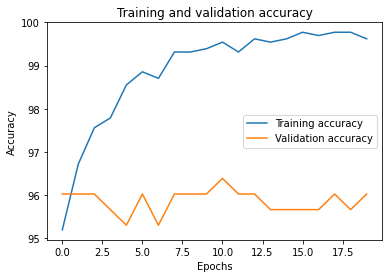

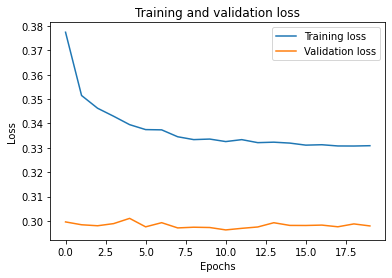

acc %
96.028880866426
total INCORRECT total examples in val number of correct examples in val
11 277 266
Confusion Matrix:
 [[   3  217]
 [  12 5308]]
True Positives: 5308
False Positives: 217
True Negatives: 3
False Negatives: 12
Precision: 0.9607
Recall: 0.9977


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.4745, Train Acc: 81.5396, Val Loss: 0.2871, Val Acc: 84.22
Epoch 2/20, Train Loss: 0.4404, Train Acc: 89.8123, Val Loss: 0.2770, Val Acc: 90.33
Epoch 3/20, Train Loss: 0.4327, Train Acc: 91.1528, Val Loss: 0.2772, Val Acc: 89.06
Epoch 4/20, Train Loss: 0.4229, Train Acc: 93.0295, Val Loss: 0.2758, Val Acc: 87.79
Epoch 5/20, Train Loss: 0.4179, Train Acc: 94.4849, Val Loss: 0.2825, Val Acc: 85.24
Epoch 6/20, Train Loss: 0.4157, Train Acc: 95.1360, Val Loss: 0.2829, Val Acc: 87.53
Epoch 7/20, Train Loss: 0.4109, Train Acc: 95.8637, Val Loss: 0.2809, Val Acc: 88.80
Epoch 8/20, Train Loss: 0.4095, Train Acc: 95.8637, Val Loss: 0.2858, Val Acc: 82.44
Epoch 9/20, Train Loss: 0.4029, Train Acc: 97.0509, Val Loss: 0.2718, Val Acc: 90.59
Epoch 10/20, Train Loss: 0.4049, Train Acc: 97.0126, Val Loss: 0.2856, Val Acc: 85.50
Epoch 11/20, Train Loss: 0.4048, Train Acc: 96.8594, Val Loss: 0.2749, Val Acc: 90.33
Epoch 12/20, Train Loss: 0.3987, Train Acc: 98.0

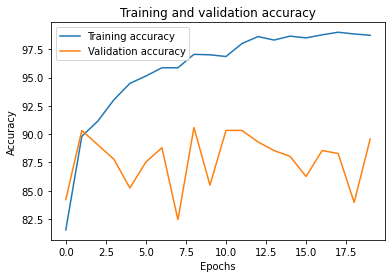

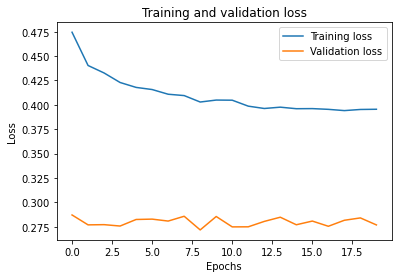

acc %
89.56743002544529
total INCORRECT total examples in val number of correct examples in val
41 393 352
Confusion Matrix:
 [[1444  456]
 [ 508 5452]]
True Positives: 5452
False Positives: 456
True Negatives: 1444
False Negatives: 508
Precision: 0.9228
Recall: 0.9148


NameError: name 'cashewtrain_loader' is not defined

In [30]:
trainNew(cocotrain_loader,cocoval_loader, 'coco-iid-bimodal.pt')
trainNew(oiltrain_loader,oilval_loader, 'oil-iid-bimodal.pt')

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

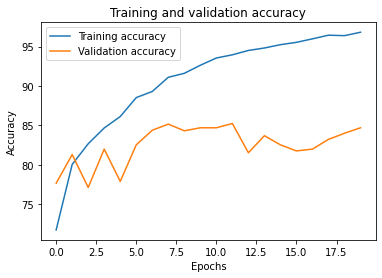

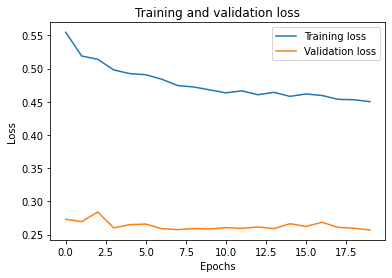

acc %
84.68677494199535
total INCORRECT total examples in val number of correct examples in val
198 1293 1095
Confusion Matrix:
 [[11043  2217]
 [ 2306 10294]]
True Positives: 10294
False Positives: 2217
True Negatives: 11043
False Negatives: 2306
Precision: 0.8228
Recall: 0.8170


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7438, Train Acc: 92.9192, Val Loss: 0.6744, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.6940, Train Acc: 100.0000, Val Loss: 0.6732, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.6934, Train Acc: 100.0000, Val Loss: 0.6730, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.6933, Train Acc: 100.0000, Val Loss: 0.6730, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.6933, Train Acc: 100.0000, Val Loss: 0.6729, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.6932, Train Acc: 100.0000, Val Loss: 0.6729, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.6932, Train Acc: 100.0000, Val Loss: 0.6729, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.6932, Train Acc: 100.0000, Val Loss: 0.6729, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.6932, Train Acc: 100.0000, Val Loss: 0.6729, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.6932, Train Acc: 100.0000, Val Loss: 0.6729, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6932, Train Acc: 100.0000, Val Loss: 0.6729, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.

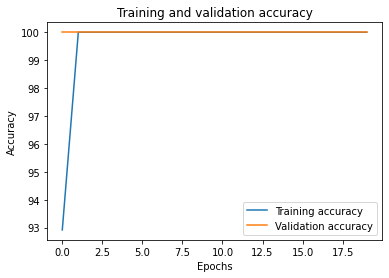

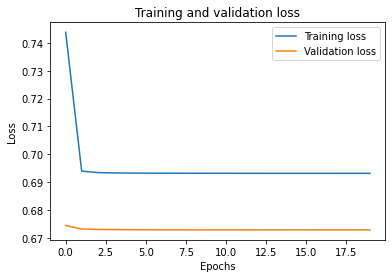

acc %
100.0
total INCORRECT total examples in val number of correct examples in val
0 895 895


ValueError: not enough values to unpack (expected 4, got 1)

In [31]:
trainNew(cashtrain_loader,cashval_loader, 'cashew-iid-bimodal.pt')
trainNew(civtrain_loader,civval_loader, 'civ-iid-bimodal.pt')
trainNew(ftrain_loader,fval_loader, 'Fagan-iid-bimodal.pt')
trainNew(everything_trn_loader,everything_nosdpt_loader,'manual-iid-trimodal.pt')

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.4226, Train Acc: 81.0008, Val Loss: 0.3798, Val Acc: 87.54
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.3870, Train Acc: 90.1612, Val Loss: 0.3724, Val Acc: 88.97
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.3800, Train Acc: 91.8575, Val Loss: 0.3625, Val Acc: 91.81
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.3725, Train Acc: 93.6387, Val Loss: 0.3589, Val Acc: 92.88
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.3723, Train Acc: 93.4690, Val Loss: 0.4064, Val Acc: 77.22
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.3666, Train Acc: 94.5717, Val Loss: 0.3644, Val Acc: 90.04
Skipping batch due to NaNs.
Epoch 7/20, Train Loss: 0.3604, Train Acc: 95.8439, Val Loss: 0.3514, Val Acc: 94.31
Skipping batch due to NaNs.
Epoch 8/20, Train Loss: 0.3584, Train Acc: 95.6743, Val Loss: 0.3582, Val Acc: 92.88
Skipping batch due to NaNs.
Epoch 9/20, Train Loss: 0.3560, Train Acc: 96.8617, V

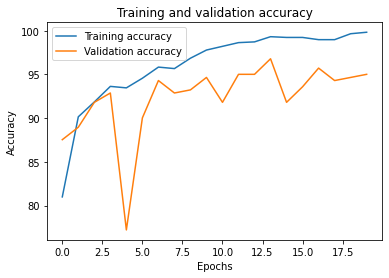

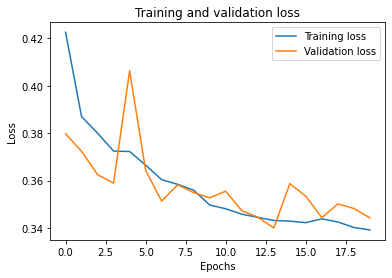

acc %
95.01779359430606
total INCORRECT total examples in val number of correct examples in val
14 281 267
Confusion Matrix:
 [[ 250  230]
 [ 199 4941]]
True Positives: 4941
False Positives: 230
True Negatives: 250
False Negatives: 199
Precision: 0.9555
Recall: 0.9613


NameError: name 'everything_nosdpt_loader' is not defined

In [32]:
trainNew(ftrain_loader,fval_loader, 'Fagan-iid-bimodal.pt')

In [ ]:
trainNew(full_trn_loader,full_nosdpt_loader,'manual-iid-bimodal.pt')

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

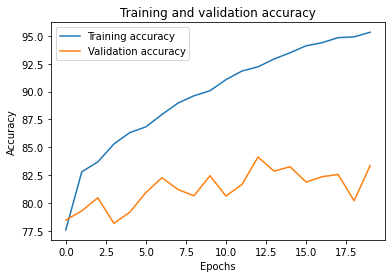

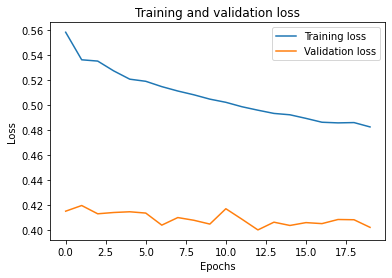

acc %
83.35715744333265
total INCORRECT total examples in val number of correct examples in val
815 4897 4082
Confusion Matrix:
 [[42379 11560]
 [ 6761 37245]]
True Positives: 37245
False Positives: 11560
True Negatives: 42379
False Negatives: 6761
Precision: 0.7631
Recall: 0.8464


In [33]:
trainNew(everything_trn_loader,everyval_nosdpt_loader,'manual-iid-bimodal.pt')

# CHM only

In [36]:
import torch.nn.init as init
class MultiResNet(nn.Module):
    def __init__(self):
        super(MultiResNet, self).__init__()
        
        # First ResNet for grayscale images
        self.resnet_gray = models.resnet18(pretrained=True)
        self.resnet_gray.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Get the number of features in the final layer
        num_features = self.resnet_gray.fc.in_features

        # Concatenate the features from both streams
        self.fc = nn.Linear(num_features, 1)  # Adjust the output size as needed
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

        #self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
        
    def forward(self, x_gray, x_24band,_):
        
        # Forward pass through the grayscale ResNet
        x_gray = self.resnet_gray.conv1(x_gray)
        x_gray = self.resnet_gray.bn1(x_gray)
        x_gray = self.resnet_gray.relu(x_gray)
        x_gray = self.resnet_gray.maxpool(x_gray)
        #print('x_gray after maxpool')
        #print(x_gray)
        x_gray = self.resnet_gray.layer1(x_gray)
        x_gray = self.resnet_gray.layer2(x_gray)
        x_gray = self.resnet_gray.layer3(x_gray)
        x_gray = self.resnet_gray.layer4(x_gray)
        #print('x_gray after layers')
        #print(x_gray)
        x_gray = self.resnet_gray.avgpool(x_gray)
        x_gray = torch.flatten(x_gray, 1)
        
        # Classification head
        x = self.fc(x_gray)
        
        x = self.sigmoid(x)
        return x

# Example usage
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

training start
Epoch 1/20, Train Loss: 0.3966, Train Acc: 94.1311, Val Loss: 0.3059, Val Acc: 96.03
Epoch 2/20, Train Loss: 0.3588, Train Acc: 95.8079, Val Loss: 0.2999, Val Acc: 96.03
Epoch 3/20, Train Loss: 0.3535, Train Acc: 96.5701, Val Loss: 0.2989, Val Acc: 96.03
Epoch 4/20, Train Loss: 0.3477, Train Acc: 97.4848, Val Loss: 0.3019, Val Acc: 95.67
Epoch 5/20, Train Loss: 0.3432, Train Acc: 98.3232, Val Loss: 0.3022, Val Acc: 95.67
Epoch 6/20, Train Loss: 0.3391, Train Acc: 98.6280, Val Loss: 0.3003, Val Acc: 95.67
Epoch 7/20, Train Loss: 0.3388, Train Acc: 98.7043, Val Loss: 0.3005, Val Acc: 95.67
Epoch 8/20, Train Loss: 0.3383, Train Acc: 98.8567, Val Loss: 0.3014, Val Acc: 95.31
Epoch 9/20, Train Loss: 0.3369, Train Acc: 99.0091, Val Loss: 0.3020, Val Acc: 95.31
Epoch 10/20, Train Loss: 0.3364, Train Acc: 99.0091, Val Loss: 0.2982, Val Acc: 96.03
Epoch 11/20, Train Loss: 0.3361, Train Acc: 99.1616, Val Loss: 0.2998, Val Acc: 95.31
Epoch 12/20, Train Loss: 0.3363, Train Acc: 98.9

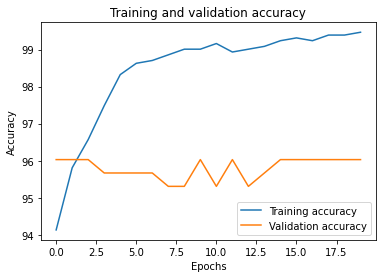

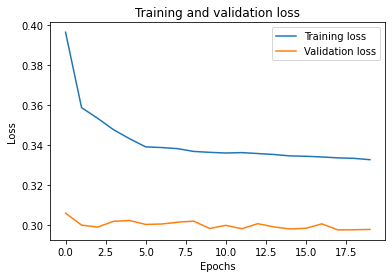

acc %
96.028880866426
total INCORRECT total examples in val number of correct examples in val
11 277 266
Confusion Matrix:
 [[   1  219]
 [  14 5306]]
True Positives: 5306
False Positives: 219
True Negatives: 1
False Negatives: 14
Precision: 0.9604
Recall: 0.9974


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.4919, Train Acc: 75.7947, Val Loss: 0.2913, Val Acc: 84.48
Epoch 2/20, Train Loss: 0.4541, Train Acc: 87.1697, Val Loss: 0.2950, Val Acc: 83.21
Epoch 3/20, Train Loss: 0.4439, Train Acc: 89.3910, Val Loss: 0.2855, Val Acc: 87.02
Epoch 4/20, Train Loss: 0.4406, Train Acc: 90.3102, Val Loss: 0.2858, Val Acc: 86.51
Epoch 5/20, Train Loss: 0.4417, Train Acc: 89.3527, Val Loss: 0.2863, Val Acc: 87.28
Epoch 6/20, Train Loss: 0.4329, Train Acc: 91.2677, Val Loss: 0.2850, Val Acc: 87.02
Epoch 7/20, Train Loss: 0.4269, Train Acc: 92.5699, Val Loss: 0.2834, Val Acc: 87.28
Epoch 8/20, Train Loss: 0.4310, Train Acc: 91.5741, Val Loss: 0.2850, Val Acc: 86.51
Epoch 9/20, Train Loss: 0.4157, Train Acc: 94.8296, Val Loss: 0.2900, Val Acc: 82.70
Epoch 10/20, Train Loss: 0.4140, Train Acc: 95.1360, Val Loss: 0.2871, Val Acc: 86.51
Epoch 11/20, Train Loss: 0.4105, Train Acc: 95.7871, Val Loss: 0.2882, Val Acc: 85.75
Epoch 12/20, Train Loss: 0.4078, Train Acc: 96.6

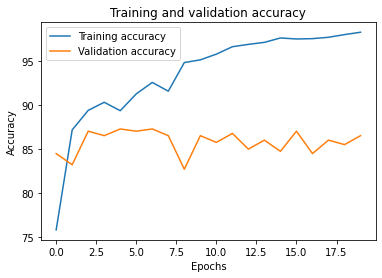

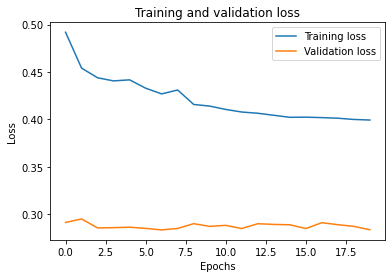

acc %
86.51399491094148
total INCORRECT total examples in val number of correct examples in val
53 393 340
Confusion Matrix:
 [[1274  626]
 [ 489 5471]]
True Positives: 5471
False Positives: 626
True Negatives: 1274
False Negatives: 489
Precision: 0.8973
Recall: 0.9180


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

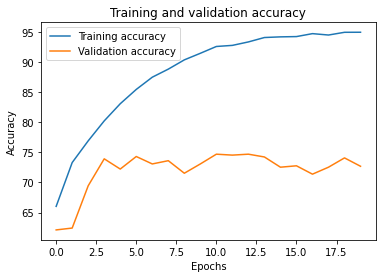

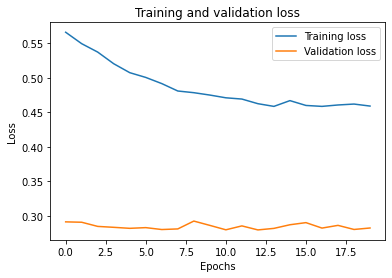

acc %
72.69914926527456
total INCORRECT total examples in val number of correct examples in val
353 1293 940
Confusion Matrix:
 [[10166  3094]
 [ 4146  8454]]
True Positives: 8454
False Positives: 3094
True Negatives: 10166
False Negatives: 4146
Precision: 0.7321
Recall: 0.6710


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.7487, Train Acc: 93.7330, Val Loss: 0.6749, Val Acc: 100.00
Epoch 2/20, Train Loss: 0.6947, Train Acc: 100.0000, Val Loss: 0.6737, Val Acc: 100.00
Epoch 3/20, Train Loss: 0.6940, Train Acc: 100.0000, Val Loss: 0.6734, Val Acc: 100.00
Epoch 4/20, Train Loss: 0.6936, Train Acc: 100.0000, Val Loss: 0.6733, Val Acc: 100.00
Epoch 5/20, Train Loss: 0.6935, Train Acc: 100.0000, Val Loss: 0.6732, Val Acc: 100.00
Epoch 6/20, Train Loss: 0.6934, Train Acc: 100.0000, Val Loss: 0.6731, Val Acc: 100.00
Epoch 7/20, Train Loss: 0.6934, Train Acc: 100.0000, Val Loss: 0.6731, Val Acc: 100.00
Epoch 8/20, Train Loss: 0.6933, Train Acc: 100.0000, Val Loss: 0.6730, Val Acc: 100.00
Epoch 9/20, Train Loss: 0.6933, Train Acc: 100.0000, Val Loss: 0.6730, Val Acc: 100.00
Epoch 10/20, Train Loss: 0.6933, Train Acc: 100.0000, Val Loss: 0.6730, Val Acc: 100.00
Epoch 11/20, Train Loss: 0.6933, Train Acc: 100.0000, Val Loss: 0.6730, Val Acc: 100.00
Epoch 12/20, Train Loss: 0.

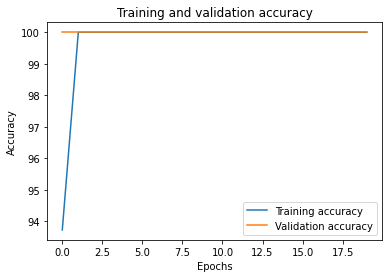

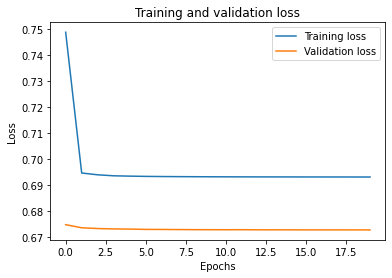

acc %
100.0
total INCORRECT total examples in val number of correct examples in val
0 895 895


ValueError: not enough values to unpack (expected 4, got 1)

In [37]:
trainNew(cocotrain_loader,cocoval_loader, 'coco-iid-chm.pt')
trainNew(oiltrain_loader,oilval_loader, 'oil-iid-chm.pt')
trainNew(cashtrain_loader,cashval_loader, 'cashew-iid-chm.pt')


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.4215, Train Acc: 82.5276, Val Loss: 0.3610, Val Acc: 92.88
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.3825, Train Acc: 91.1790, Val Loss: 0.3776, Val Acc: 86.83
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.3873, Train Acc: 89.6522, Val Loss: 0.3640, Val Acc: 91.46
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.3751, Train Acc: 92.3664, Val Loss: 0.3571, Val Acc: 93.59
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.3710, Train Acc: 93.5539, Val Loss: 0.3711, Val Acc: 87.19
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.3687, Train Acc: 94.2324, Val Loss: 0.3601, Val Acc: 92.17
Skipping batch due to NaNs.
Epoch 7/20, Train Loss: 0.3733, Train Acc: 92.9601, Val Loss: 0.3751, Val Acc: 86.48
Skipping batch due to NaNs.
Epoch 8/20, Train Loss: 0.3674, Train Acc: 93.8931, Val Loss: 0.3606, Val Acc: 92.53
Skipping batch due to NaNs.
Epoch 9/20, Train Loss: 0.3612, Train Acc: 95.4198, V

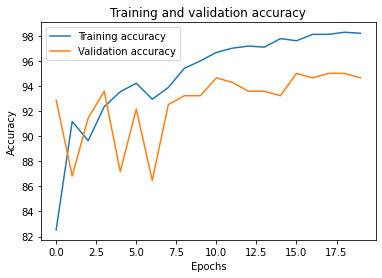

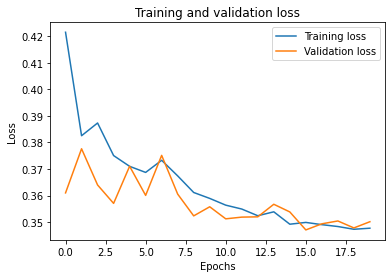

acc %
94.66192170818505
total INCORRECT total examples in val number of correct examples in val
15 281 266
Confusion Matrix:
 [[ 214  266]
 [ 146 4994]]
True Positives: 4994
False Positives: 266
True Negatives: 214
False Negatives: 146
Precision: 0.9494
Recall: 0.9716


NameError: name 'full_nosdpt_loader' is not defined

In [38]:

trainNew(ftrain_loader,fval_loader, 'Fagan-iid-chm.pt')


training start
Epoch 1/20, Train Loss: 0.5536, Train Acc: 77.5000, Val Loss: 0.4705, Val Acc: 80.48
Epoch 2/20, Train Loss: 0.5216, Train Acc: 85.5536, Val Loss: 0.4684, Val Acc: 80.48
Epoch 3/20, Train Loss: 0.5110, Train Acc: 87.6964, Val Loss: 0.4596, Val Acc: 83.69
Epoch 4/20, Train Loss: 0.4987, Train Acc: 90.1429, Val Loss: 0.4704, Val Acc: 83.58
Epoch 5/20, Train Loss: 0.4886, Train Acc: 92.3929, Val Loss: 0.4502, Val Acc: 86.69
Epoch 6/20, Train Loss: 0.4865, Train Acc: 92.4286, Val Loss: 0.4547, Val Acc: 85.63
Epoch 7/20, Train Loss: 0.4762, Train Acc: 94.6607, Val Loss: 0.4496, Val Acc: 86.84
Epoch 8/20, Train Loss: 0.4743, Train Acc: 95.0536, Val Loss: 0.4498, Val Acc: 87.80
Epoch 9/20, Train Loss: 0.4695, Train Acc: 96.0179, Val Loss: 0.4479, Val Acc: 87.75
Epoch 10/20, Train Loss: 0.4685, Train Acc: 96.1071, Val Loss: 0.4444, Val Acc: 88.25
Epoch 11/20, Train Loss: 0.4664, Train Acc: 96.5893, Val Loss: 0.4581, Val Acc: 86.37
Epoch 12/20, Train Loss: 0.4636, Train Acc: 97.0

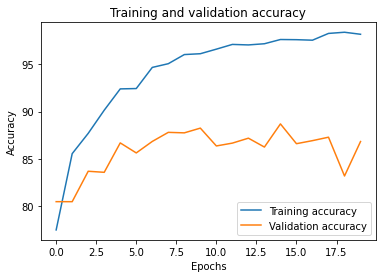

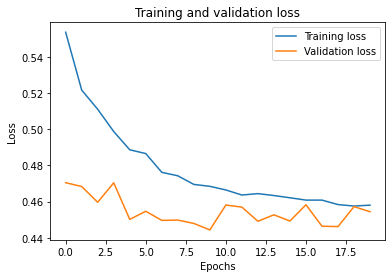

acc %
86.83333333333333
total INCORRECT total examples in val number of correct examples in val
158 1200 1042
Confusion Matrix:
 [[ 7360  1938]
 [ 1457 13256]]
True Positives: 13256
False Positives: 1938
True Negatives: 7360
False Negatives: 1457
Precision: 0.8724
Recall: 0.9010


NameError: name 'everything_nosdpt_loader' is not defined

In [40]:
trainNew(full_trn_loader,val_nosdpt_loader,'manual-iid-chm.pt')

#trainNew(civtrain_loader,civval_loader, 'civ-iid-chm.pt')

In [ ]:
trainNew(everything_trn_loader,everyval_nosdpt_loader,'all-iid-chm.pt')

training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

# S2 Only

In [28]:
import torch.nn.init as init
class MultiResNet(nn.Module):
    def __init__(self):
        super(MultiResNet, self).__init__()

        # Second ResNet for 24-band images
        self.resnet_24band = models.resnet18(pretrained=True)
        self.resnet_24band.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_features24 = self.resnet_24band.fc.in_features
        
        # Concatenate the features from both streams
        self.fc = nn.Linear(num_features24, 1)  # Adjust the output size as needed
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
        
    def forward(self, x_gray, x_24band,_):
        
        # Forward pass through the 24-band ResNet
        x_24band = self.resnet_24band.conv1(x_24band)
        #print('after conv1 forward pass: ')
        #print(x_24band[0])
        x_24band = self.resnet_24band.bn1(x_24band)
        #print('after bn')
        #print(x_24band[0])
        x_24band = self.resnet_24band.relu(x_24band)
        x_24band = self.resnet_24band.maxpool(x_24band)
        x_24band = self.resnet_24band.layer1(x_24band)
        x_24band = self.resnet_24band.layer2(x_24band)
        x_24band = self.resnet_24band.layer3(x_24band)
        x_24band = self.resnet_24band.layer4(x_24band)
        x_24band = self.resnet_24band.avgpool(x_24band)
        x_24band = torch.flatten(x_24band, 1)

        # Concatenate the features from both streams
        # Classification head
        x = self.fc(x_24band)
        
        x = self.sigmoid(x)
        return x

# Example usage
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

training start
Epoch 1/20, Train Loss: 0.4152, Train Acc: 79.9543, Val Loss: 0.3010, Val Acc: 96.03
Epoch 2/20, Train Loss: 0.3787, Train Acc: 89.7866, Val Loss: 0.2995, Val Acc: 96.03
Epoch 3/20, Train Loss: 0.3747, Train Acc: 90.9299, Val Loss: 0.3003, Val Acc: 95.67
Epoch 4/20, Train Loss: 0.3763, Train Acc: 90.3963, Val Loss: 0.3035, Val Acc: 94.58
Epoch 5/20, Train Loss: 0.3696, Train Acc: 91.8445, Val Loss: 0.3039, Val Acc: 94.95
Epoch 6/20, Train Loss: 0.3664, Train Acc: 92.6829, Val Loss: 0.3017, Val Acc: 95.31
Epoch 7/20, Train Loss: 0.3633, Train Acc: 93.5976, Val Loss: 0.2994, Val Acc: 95.67
Epoch 8/20, Train Loss: 0.3631, Train Acc: 93.2927, Val Loss: 0.3032, Val Acc: 94.22
Epoch 9/20, Train Loss: 0.3595, Train Acc: 93.8262, Val Loss: 0.3067, Val Acc: 93.14
Epoch 10/20, Train Loss: 0.3634, Train Acc: 92.9116, Val Loss: 0.3094, Val Acc: 92.06
Epoch 11/20, Train Loss: 0.3548, Train Acc: 96.1128, Val Loss: 0.2985, Val Acc: 96.03
Epoch 12/20, Train Loss: 0.3484, Train Acc: 96.9

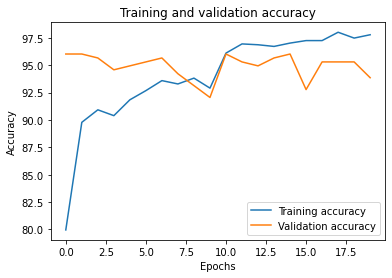

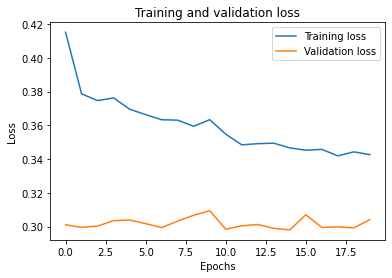

acc %
93.86281588447653
total INCORRECT total examples in val number of correct examples in val
17 277 260
Confusion Matrix:
 [[   2  218]
 [  64 5256]]
True Positives: 5256
False Positives: 218
True Negatives: 2
False Negatives: 64
Precision: 0.9602
Recall: 0.9880


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.5231, Train Acc: 70.0498, Val Loss: 0.3261, Val Acc: 69.21
Epoch 2/20, Train Loss: 0.4836, Train Acc: 81.5013, Val Loss: 0.3257, Val Acc: 76.34
Epoch 3/20, Train Loss: 0.4740, Train Acc: 83.2631, Val Loss: 0.3286, Val Acc: 76.59
Epoch 4/20, Train Loss: 0.4651, Train Acc: 85.2164, Val Loss: 0.3147, Val Acc: 73.03
Epoch 5/20, Train Loss: 0.4637, Train Acc: 85.1398, Val Loss: 0.2972, Val Acc: 82.95
Epoch 6/20, Train Loss: 0.4580, Train Acc: 86.6718, Val Loss: 0.3682, Val Acc: 46.56
Epoch 7/20, Train Loss: 0.4478, Train Acc: 88.2804, Val Loss: 0.3043, Val Acc: 75.83
Epoch 8/20, Train Loss: 0.4452, Train Acc: 89.0846, Val Loss: 0.3085, Val Acc: 81.42
Epoch 9/20, Train Loss: 0.4434, Train Acc: 89.6208, Val Loss: 0.3192, Val Acc: 79.64
Epoch 10/20, Train Loss: 0.4441, Train Acc: 89.3910, Val Loss: 0.3215, Val Acc: 78.63
Epoch 11/20, Train Loss: 0.4425, Train Acc: 89.4676, Val Loss: 0.3205, Val Acc: 79.39
Epoch 12/20, Train Loss: 0.4315, Train Acc: 91.8

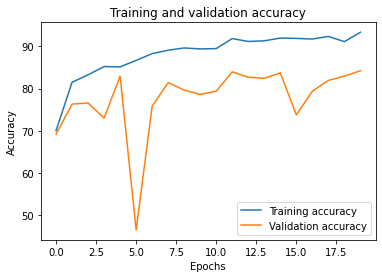

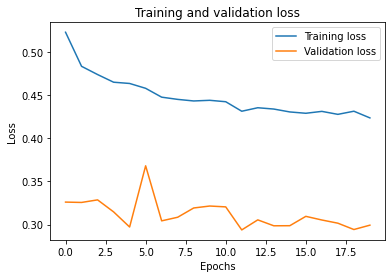

acc %
84.22391857506362
total INCORRECT total examples in val number of correct examples in val
62 393 331
Confusion Matrix:
 [[ 919  981]
 [ 769 5191]]
True Positives: 5191
False Positives: 981
True Negatives: 919
False Negatives: 769
Precision: 0.8411
Recall: 0.8710


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

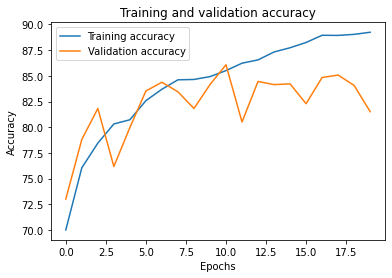

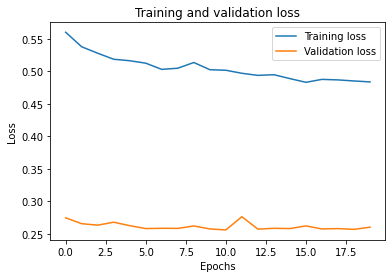

acc %
81.51585460170146
total INCORRECT total examples in val number of correct examples in val
239 1293 1054
Confusion Matrix:
 [[11695  1565]
 [ 3034  9566]]
True Positives: 9566
False Positives: 1565
True Negatives: 11695
False Negatives: 3034
Precision: 0.8594
Recall: 0.7592


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.4391, Train Acc: 80.4919, Val Loss: 0.3851, Val Acc: 91.81
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.3939, Train Acc: 89.3978, Val Loss: 0.3663, Val Acc: 92.17
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.3895, Train Acc: 90.7095, Val Loss: 0.3687, Val Acc: 90.04
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.3822, Train Acc: 91.6031, Val Loss: 0.3662, Val Acc: 91.10
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.3912, Train Acc: 90.0763, Val Loss: 0.3799, Val Acc: 87.19
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.3821, Train Acc: 91.3486, Val Loss: 0.3636, Val Acc: 90.39
Skipping batch due to NaNs.
Epoch 7/20, Train Loss: 0.3875, Train Acc: 89.8219, Val Loss: 0.3790, Val Acc: 88.61
Skipping batch due to NaNs.
Epoch 8/20, Train Loss: 0.3798, Train Acc: 91.6879, Val Loss: 0.3646, Val Acc: 91.81
Skipping batch due to NaNs.
Epoch 9/20, Train Loss: 0.3778, Train Acc: 92.6209, V

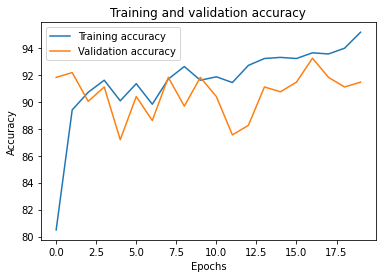

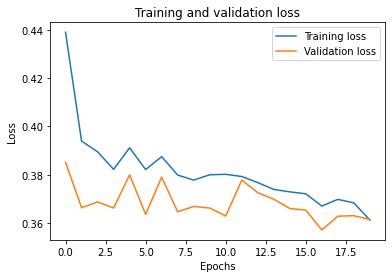

acc %
91.45907473309609
total INCORRECT total examples in val number of correct examples in val
24 281 257
Confusion Matrix:
 [[ 149  331]
 [ 198 4942]]
True Positives: 4942
False Positives: 331
True Negatives: 149
False Negatives: 198
Precision: 0.9372
Recall: 0.9615


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.5909, Train Acc: 68.8750, Val Loss: 0.5202, Val Acc: 72.58
Epoch 2/20, Train Loss: 0.5772, Train Acc: 73.0357, Val Loss: 0.4910, Val Acc: 74.90
Epoch 3/20, Train Loss: 0.5677, Train Acc: 75.7321, Val Loss: 0.4898, Val Acc: 77.73
Epoch 4/20, Train Loss: 0.5646, Train Acc: 75.0357, Val Loss: 0.4890, Val Acc: 76.27
Epoch 5/20, Train Loss: 0.5522, Train Acc: 78.8571, Val Loss: 0.4888, Val Acc: 75.35
Epoch 6/20, Train Loss: 0.5486, Train Acc: 80.1071, Val Loss: 0.4916, Val Acc: 77.54
Epoch 7/20, Train Loss: 0.5418, Train Acc: 80.5536, Val Loss: 0.5060, Val Acc: 76.19
Epoch 8/20, Train Loss: 0.5397, Train Acc: 81.0536, Val Loss: 0.4969, Val Acc: 76.09
Epoch 9/20, Train Loss: 0.5359, Train Acc: 82.4107, Val Loss: 0.4973, Val Acc: 75.08
Epoch 10/20, Train Loss: 0.5393, Train Acc: 80.8750, Val Loss: 0.4743, Val Acc: 79.75
Epoch 11/20, Train Loss: 0.5301, Train Acc: 83.3393, Val Loss: 0.4919, Val Acc: 78.90
Epoch 12/20, Train Loss: 0.5251, Train Acc: 84.3

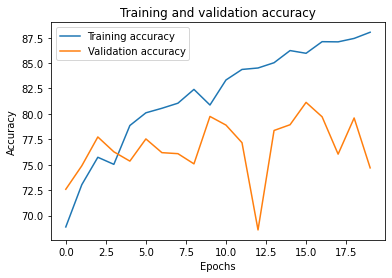

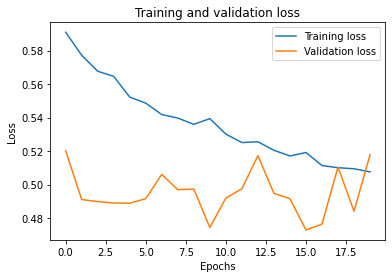

acc %
74.68776019983348
total INCORRECT total examples in val number of correct examples in val
304 1201 897
Confusion Matrix:
 [[ 6063  3246]
 [ 2339 12353]]
True Positives: 12353
False Positives: 3246
True Negatives: 6063
False Negatives: 2339
Precision: 0.7919
Recall: 0.8408


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

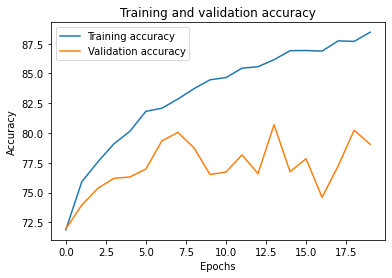

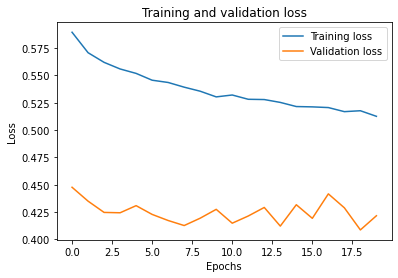

acc %
79.05267456104532
total INCORRECT total examples in val number of correct examples in val
1026 4898 3872
Confusion Matrix:
 [[38951 14972]
 [ 7394 36631]]
True Positives: 36631
False Positives: 14972
True Negatives: 38951
False Negatives: 7394
Precision: 0.7099
Recall: 0.8320


In [29]:
trainNew(cocotrain_loader,cocoval_loader, 'coco-iid-s2.pt')
trainNew(oiltrain_loader,oilval_loader, 'oil-iid-s2.pt')
trainNew(cashtrain_loader,cashval_loader, 'cashew-iid-s2.pt')
trainNew(ftrain_loader,fval_loader, 'Fagan-iid-s2.pt')
trainNew(full_trn_loader,val_nosdpt_loader,'manual-iid-s2.pt')
trainNew(everything_trn_loader,everyval_nosdpt_loader,'all-iid-s2.pt')

In [ ]:
#trainNew(civtrain_loader,civval_loader, 'civ-iid-s2.pt')

# Trimodal from scratch

In [30]:
import torch.nn.init as init
class MultiResNet(nn.Module):
    def __init__(self):
        super(MultiResNet, self).__init__()
        
        # First ResNet for grayscale images
        self.resnet_gray = models.resnet18(pretrained=False)
        self.resnet_gray.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Second ResNet for 24-band images
        self.resnet_24band = models.resnet18(pretrained=False)
        self.resnet_24band.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Get the number of features in the final layer
        num_features = self.resnet_gray.fc.in_features
        num_features24 = self.resnet_24band.fc.in_features

        # Fully connected layers for tabular data
        self.fc_tabular = nn.Linear(4, 32)  # 4 tabular features
        
        
        # Concatenate the features from both streams
        self.fc = nn.Linear(num_features + num_features24+32,1)# + 32, 1)  # Adjust the output size as needed
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

        #self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
        
    def forward(self, x_gray, x_24band, tabular_features):

        
        # Forward pass through the grayscale ResNet
        x_gray = self.resnet_gray.conv1(x_gray)
        x_gray = self.resnet_gray.bn1(x_gray)
        x_gray = self.resnet_gray.relu(x_gray)
        x_gray = self.resnet_gray.maxpool(x_gray)
        #print('x_gray after maxpool')
        #print(x_gray)
        x_gray = self.resnet_gray.layer1(x_gray)
        x_gray = self.resnet_gray.layer2(x_gray)
        x_gray = self.resnet_gray.layer3(x_gray)
        x_gray = self.resnet_gray.layer4(x_gray)
        #print('x_gray after layers')
        #print(x_gray)
        x_gray = self.resnet_gray.avgpool(x_gray)
        x_gray = torch.flatten(x_gray, 1)

        
        # Forward pass through the 24-band ResNet
        x_24band = self.resnet_24band.conv1(x_24band)
        x_24band = self.resnet_24band.bn1(x_24band)
        x_24band = self.resnet_24band.relu(x_24band)
        x_24band = self.resnet_24band.maxpool(x_24band)
        #print('x_24 after maxpool')
        #print(x_24band[0])
        x_24band = self.resnet_24band.layer1(x_24band)
        x_24band = self.resnet_24band.layer2(x_24band)
        x_24band = self.resnet_24band.layer3(x_24band)
        x_24band = self.resnet_24band.layer4(x_24band)
        x_24band = self.resnet_24band.avgpool(x_24band)
        x_24band = torch.flatten(x_24band, 1)
        
        x3 = self.fc_tabular(tabular_features)
        x3 = x3[:x_gray.size(0)]
            
        # Concatenate the features from both streams
        x = torch.cat((x_gray, x_24band,x3),dim=1)#, x3), dim=1)
        x = self.fc(x)       
        x = self.sigmoid(x)
        return x

# Example usage
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

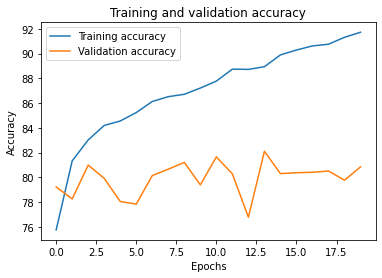

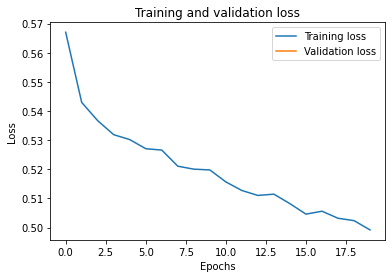

acc %
80.84932625561454
total INCORRECT total examples in val number of correct examples in val
938 4898 3960
Confusion Matrix:
 [[39540 14384]
 [ 5263 38758]]
True Positives: 38758
False Positives: 14384
True Negatives: 39540
False Negatives: 5263
Precision: 0.7293
Recall: 0.8804


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.3891, Train Acc: 86.3567, Val Loss: 0.2981, Val Acc: 96.03
Epoch 2/20, Train Loss: 0.3556, Train Acc: 95.8079, Val Loss: 0.2975, Val Acc: 96.03
Epoch 3/20, Train Loss: 0.3554, Train Acc: 95.8079, Val Loss: 0.2974, Val Acc: 96.03
Epoch 4/20, Train Loss: 0.3553, Train Acc: 95.8079, Val Loss: 0.2973, Val Acc: 96.03
Epoch 5/20, Train Loss: 0.3553, Train Acc: 95.8079, Val Loss: 0.2973, Val Acc: 96.03
Epoch 6/20, Train Loss: 0.3547, Train Acc: 95.9604, Val Loss: 0.2982, Val Acc: 95.67
Epoch 7/20, Train Loss: 0.3554, Train Acc: 95.6555, Val Loss: 0.3260, Val Acc: 85.92
Epoch 8/20, Train Loss: 0.3553, Train Acc: 95.8079, Val Loss: 0.2973, Val Acc: 96.03
Epoch 9/20, Train Loss: 0.3552, Train Acc: 95.8079, Val Loss: 0.2973, Val Acc: 96.03
Epoch 10/20, Train Loss: 0.3543, Train Acc: 95.8841, Val Loss: 0.2975, Val Acc: 96.03
Epoch 11/20, Train Loss: 0.3520, Train Acc: 96.1890, Val Loss: 0.2998, Val Acc: 94.95
Epoch 12/20, Train Loss: 0.3514, Train Acc: 96.3

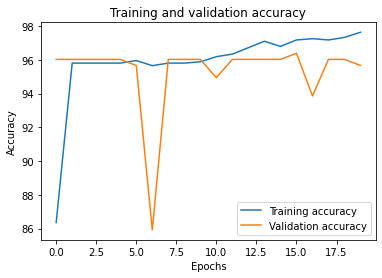

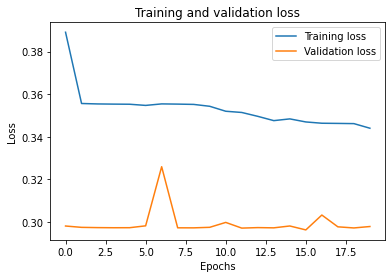

acc %
95.66787003610109
total INCORRECT total examples in val number of correct examples in val
12 277 265
Confusion Matrix:
 [[   5  215]
 [  43 5277]]
True Positives: 5277
False Positives: 215
True Negatives: 5
False Negatives: 43
Precision: 0.9609
Recall: 0.9919


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.4855, Train Acc: 81.6162, Val Loss: 0.3162, Val Acc: 79.13
Epoch 2/20, Train Loss: 0.4577, Train Acc: 85.7909, Val Loss: 0.2925, Val Acc: 83.72
Epoch 3/20, Train Loss: 0.4398, Train Acc: 90.0038, Val Loss: 0.2930, Val Acc: 85.24
Epoch 4/20, Train Loss: 0.4275, Train Acc: 92.5316, Val Loss: 0.2897, Val Acc: 86.01
Epoch 5/20, Train Loss: 0.4236, Train Acc: 93.6040, Val Loss: 0.2827, Val Acc: 85.50
Epoch 6/20, Train Loss: 0.4181, Train Acc: 94.5232, Val Loss: 0.2794, Val Acc: 87.02
Epoch 7/20, Train Loss: 0.4145, Train Acc: 95.4424, Val Loss: 0.2827, Val Acc: 87.53
Epoch 8/20, Train Loss: 0.4130, Train Acc: 95.7871, Val Loss: 0.3094, Val Acc: 81.68
Epoch 9/20, Train Loss: 0.4047, Train Acc: 97.2807, Val Loss: 0.2826, Val Acc: 86.26
Epoch 10/20, Train Loss: 0.4047, Train Acc: 97.2424, Val Loss: 0.2914, Val Acc: 84.99
Epoch 11/20, Train Loss: 0.4003, Train Acc: 98.0084, Val Loss: 0.2871, Val Acc: 85.24
Epoch 12/20, Train Loss: 0.3978, Train Acc: 98.4

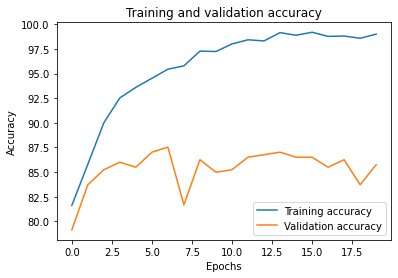

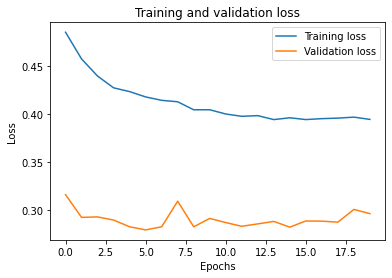

acc %
85.75063613231552
total INCORRECT total examples in val number of correct examples in val
56 393 337
Confusion Matrix:
 [[1165  735]
 [ 417 5543]]
True Positives: 5543
False Positives: 735
True Negatives: 1165
False Negatives: 417
Precision: 0.8829
Recall: 0.9300


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

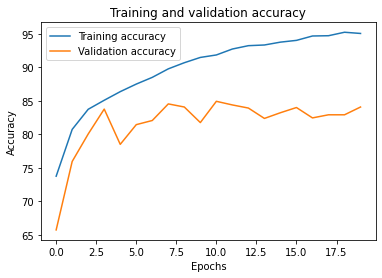

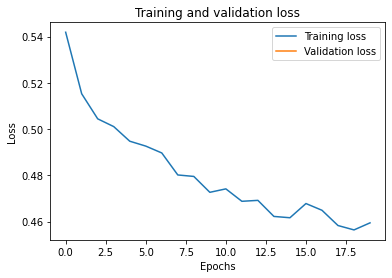

acc %
84.06805877803558
total INCORRECT total examples in val number of correct examples in val
206 1293 1087
Confusion Matrix:
 [[10857  2403]
 [ 2343 10257]]
True Positives: 10257
False Positives: 2403
True Negatives: 10857
False Negatives: 2343
Precision: 0.8102
Recall: 0.8140


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.3963, Train Acc: 91.0093, Val Loss: 0.3701, Val Acc: 91.46
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.3904, Train Acc: 90.6701, Val Loss: 0.3616, Val Acc: 92.17
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.3862, Train Acc: 91.3486, Val Loss: 0.3599, Val Acc: 93.24
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.3802, Train Acc: 92.4512, Val Loss: 0.3605, Val Acc: 91.81
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.3856, Train Acc: 91.6385, Val Loss: 0.3636, Val Acc: 91.81
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.3734, Train Acc: 93.3842, Val Loss: 0.3632, Val Acc: 92.17
Skipping batch due to NaNs.
Epoch 7/20, Train Loss: 0.3742, Train Acc: 93.3842, Val Loss: 0.3645, Val Acc: 91.81
Skipping batch due to NaNs.
Epoch 8/20, Train Loss: 0.3735, Train Acc: 93.8931, Val Loss: 0.3690, Val Acc: 88.61
Skipping batch due to NaNs.
Epoch 9/20, Train Loss: 0.3706, Train Acc: 93.8931, V

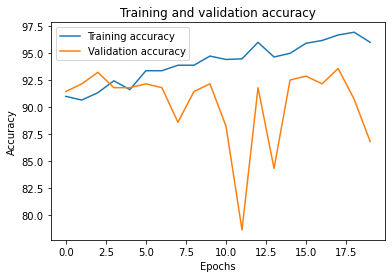

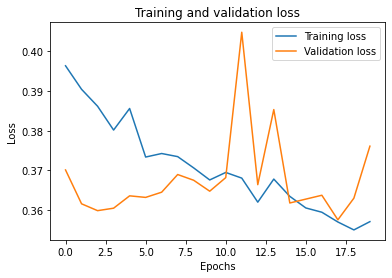

acc %
86.83274021352312
total INCORRECT total examples in val number of correct examples in val
37 281 244
Confusion Matrix:
 [[ 121  359]
 [ 179 4961]]
True Positives: 4961
False Positives: 359
True Negatives: 121
False Negatives: 179
Precision: 0.9325
Recall: 0.9652


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


training start
Epoch 1/20, Train Loss: 0.5515, Train Acc: 77.5893, Val Loss: 0.4678, Val Acc: 80.42
Epoch 2/20, Train Loss: 0.5245, Train Acc: 83.2321, Val Loss: 0.4533, Val Acc: 86.20
Epoch 3/20, Train Loss: 0.5162, Train Acc: 85.3750, Val Loss: 0.4515, Val Acc: 84.67
Epoch 4/20, Train Loss: 0.5065, Train Acc: 87.4286, Val Loss: 0.4507, Val Acc: 85.83
Epoch 5/20, Train Loss: 0.5028, Train Acc: 88.4643, Val Loss: 0.4443, Val Acc: 88.15
Epoch 6/20, Train Loss: 0.4950, Train Acc: 90.2857, Val Loss: 0.4444, Val Acc: 87.10
Epoch 7/20, Train Loss: 0.4895, Train Acc: 91.5714, Val Loss: 0.4523, Val Acc: 86.34
Epoch 8/20, Train Loss: 0.4873, Train Acc: 91.9464, Val Loss: 0.4434, Val Acc: 88.07
Epoch 9/20, Train Loss: 0.4838, Train Acc: 92.8214, Val Loss: 0.4431, Val Acc: 88.31
Epoch 10/20, Train Loss: 0.4797, Train Acc: 93.6786, Val Loss: 0.4489, Val Acc: 84.42
Epoch 11/20, Train Loss: 0.4782, Train Acc: 94.0893, Val Loss: 0.4673, Val Acc: 84.47
Epoch 12/20, Train Loss: 0.4744, Train Acc: 94.9

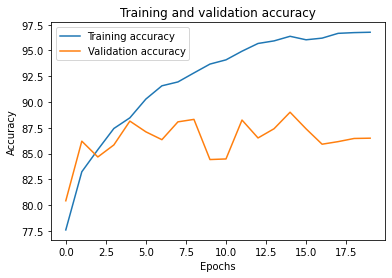

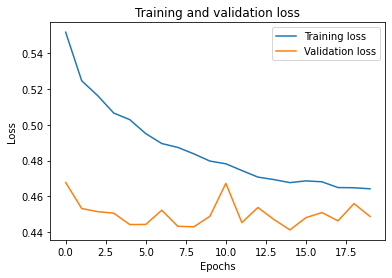

acc %
86.48874061718098
total INCORRECT total examples in val number of correct examples in val
162 1199 1037
Confusion Matrix:
 [[ 7668  1622]
 [ 1648 13069]]
True Positives: 13069
False Positives: 1622
True Negatives: 7668
False Negatives: 1648
Precision: 0.8896
Recall: 0.8880


In [31]:


epochs = 30
trainNew(everything_trn_loader,everyval_nosdpt_loader,'all-iid-scratch.pt')
epochs = 20
trainNew(cocotrain_loader,cocoval_loader, 'coco-iid-scratch.pt')
trainNew(oiltrain_loader,oilval_loader, 'oil-iid-scratch.pt')
trainNew(cashtrain_loader,cashval_loader, 'cashew-iid-scratch.pt')
trainNew(ftrain_loader,fval_loader, 'Fagan-iid-scratch.pt')
trainNew(full_trn_loader,val_nosdpt_loader,'manual-iid-scratch.pt')


# S1 Only

# AUGMENTED

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, logits=True, num_classes=3):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.logits = logits
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        else:
            BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)

        pt = torch.exp(-BCE_loss)  # Probability of the true class

        # Ensure alpha is a tensor and has the correct shape
        if self.alpha is not None:
            # If alpha is a list or numpy array, convert it to a tensor
            if isinstance(self.alpha, (list, np.ndarray)):
                self.alpha = torch.tensor(self.alpha).to(inputs.device)

            # Gather alpha based on the target classes
            alpha_t = self.alpha[targets]  # Shape will be [batch_size]
            F_loss = alpha_t * (1 - pt) ** self.gamma * BCE_loss
        else:
            F_loss = (1 - pt) ** self.gamma * BCE_loss

        return torch.mean(F_loss)


import torch.nn.init as init
class MultiResNet(nn.Module):
    def __init__(self):
        super(MultiResNet, self).__init__()
        
        # First ResNet for grayscale images
        self.resnet_gray = models.resnet18(pretrained=True)
        self.resnet_gray.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Second ResNet for 24-band images
        self.resnet_24band = models.resnet18(pretrained=True)
        self.resnet_24band.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Get the number of features in the final layer
        num_features = self.resnet_gray.fc.in_features
        num_features24 = self.resnet_24band.fc.in_features

        # Fully connected layers for tabular data
        self.fc_tabular = nn.Linear(4, 32)  # 4 tabular features
        
        
        # Concatenate the features from both streams
        self.fc = nn.Linear(num_features + num_features24+32,1)# + 32, 1)  # Adjust the output size as needed
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

        #self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
        
    def forward(self, x_gray, x_24band, tabular_features):

        
        # Forward pass through the grayscale ResNet
        x_gray = self.resnet_gray.conv1(x_gray)
        x_gray = self.resnet_gray.bn1(x_gray)
        x_gray = self.resnet_gray.relu(x_gray)
        x_gray = self.resnet_gray.maxpool(x_gray)
        #print('x_gray after maxpool')
        #print(x_gray)
        x_gray = self.resnet_gray.layer1(x_gray)
        x_gray = self.resnet_gray.layer2(x_gray)
        x_gray = self.resnet_gray.layer3(x_gray)
        x_gray = self.resnet_gray.layer4(x_gray)
        #print('x_gray after layers')
        #print(x_gray)
        x_gray = self.resnet_gray.avgpool(x_gray)
        x_gray = torch.flatten(x_gray, 1)

        
        # Forward pass through the 24-band ResNet
        x_24band = self.resnet_24band.conv1(x_24band)
        x_24band = self.resnet_24band.bn1(x_24band)
        x_24band = self.resnet_24band.relu(x_24band)
        x_24band = self.resnet_24band.maxpool(x_24band)
        #print('x_24 after maxpool')
        #print(x_24band[0])
        x_24band = self.resnet_24band.layer1(x_24band)
        x_24band = self.resnet_24band.layer2(x_24band)
        x_24band = self.resnet_24band.layer3(x_24band)
        x_24band = self.resnet_24band.layer4(x_24band)
        x_24band = self.resnet_24band.avgpool(x_24band)
        x_24band = torch.flatten(x_24band, 1)
        
        x3 = self.fc_tabular(tabular_features)
        x3 = x3[:x_gray.size(0)]
            
        # Concatenate the features from both streams
        x = torch.cat((x_gray, x_24band,x3),dim=1)#, x3), dim=1)
        x = self.fc(x)       
        x = self.sigmoid(x)
        return x

# Example usage
model = MultiResNet()
model.to(device)
criterion = FocalLoss(alpha=[1.5,1])
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [29]:
def trainNew(train_loader,val_loader, modelpath, model, criterion,num_epochs):
    #############
    #### TRIMODAL
    ##############
    model = model
    model.to(device)
    criterion = criterion
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model.train()

    print('training start')
    trn_acc_list = []
    val_acc_list = []
    trn_loss_list = []
    val_loss_list = []
    all_predictions = []
    all_labels = []
    
    for epoch in range(num_epochs):
    
        model.train()
        correct = 0
        total = 0
        train_loss = 0.0
    
        for inputs, inputsCHM, s1, labs, paths in train_loader:

            inputs = inputs.to("cuda")
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()
            
            #if torch.isnan(inputs).any() or torch.isnan(inputsCHM).any() or torch.isnan(s1).any() or torch.isnan(labs).any():
            nan_indices = torch.isnan(s1)
            if nan_indices.any():
            #if torch.isnan(s1).any():
                print("Skipping batch due to NaNs.")
                continue

                    
            for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
                channel_data = inputs[:, c, :, :]
                mask = torch.isnan(channel_data)
                mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
                
                channel_data[mask] = mean_val.expand_as(channel_data)[mask]
                inputs[:, c, :, :] = channel_data
            if torch.isnan(inputs).any():
                raise ValueError("NaNs found in inputs after interpolation")
        
            # Check for NaNs in inputsCHM and labs
            if torch.isnan(inputsCHM).any():
                raise ValueError("NaNs found in inputsCHM")

            if torch.isnan(s1).any():
                print(torch.isnan(s1))
                print("NaNs found in S1!")
        
            if torch.isnan(labs).any():
                raise ValueError("NaNs found in labs")
            
            optimizer.zero_grad()
            outputs = model(inputsCHM,inputs,s1)
            if torch.isnan(outputs).any():
                print(f"Inputs: {inputs[0][0]}")
                print(f"Model outputs: {outputs}")
                raise ValueError("NaNs found in model outputs")
    
            loss = criterion(outputs, labs.float())
            if torch.isnan(loss).any():
                raise ValueError("NaNs found in loss")
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        trn_acc_list.append(correct/total * 100)
        trn_loss_list.append(train_loss/len(train_loader.dataset))
    
        #if epoch == 19: 
        #    torch.save(model.state_dict(), modelpath)
    
    
        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in val_loader:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = inputsCHM.to("cuda")
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                outputs = model(inputsCHM, inputs, s1)
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
            val_acc_list.append(correct/total * 100)
            val_loss_list.append(val_loss / len(val_loader.dataset))
    
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
              f'Train Acc: {trn_acc_list[-1]:.4f}, '
              #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
              f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )
    
    plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions, correct, total)
    
    return



In [30]:
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

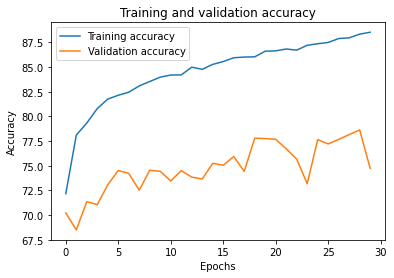

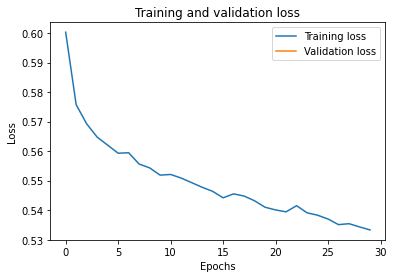

acc %
74.73060344827587
total INCORRECT total examples in val number of correct examples in val
1876 7424 5548
Confusion Matrix:
 [[93565  8249]
 [47928 72978]]
True Positives: 72978
False Positives: 8249
True Negatives: 93565
False Negatives: 47928
Precision: 0.8984
Recall: 0.6036
training start
Epoch 1/20, Train Loss: 0.7880, Train Acc: 80.7927, Val Loss: 0.7767, Val Acc: 82.37
Epoch 2/20, Train Loss: 0.7524, Train Acc: 86.5091, Val Loss: 0.7321, Val Acc: 89.67
Epoch 3/20, Train Loss: 0.7347, Train Acc: 89.4817, Val Loss: 0.7353, Val Acc: 89.06
Epoch 4/20, Train Loss: 0.7265, Train Acc: 90.9299, Val Loss: 0.7412, Val Acc: 88.15
Epoch 5/20, Train Loss: 0.7287, Train Acc: 90.3963, Val Loss: 0.7358, Val Acc: 88.45
Epoch 6/20, Train Loss: 0.7227, Train Acc: 91.6159, Val Loss: 0.7316, Val Acc: 90.27
Epoch 7/20, Train Loss: 0.7187, Train Acc: 92.0732, Val Loss: 0.7216, Val Acc: 91.49
Epoch 8/20, Train Loss: 0.7183, Train Acc: 92.2256, Val Loss: 0.7265, Val Acc: 90.58
Epoch 9/20, Train Loss

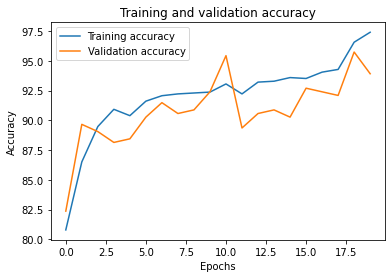

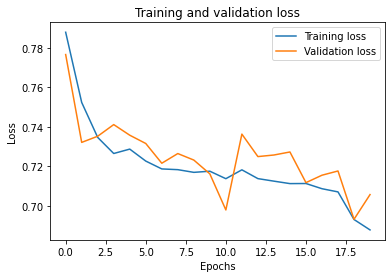

acc %
93.9209726443769
total INCORRECT total examples in val number of correct examples in val
20 329 309
Confusion Matrix:
 [[5953  347]
 [ 256   24]]
True Positives: 24
False Positives: 347
True Negatives: 5953
False Negatives: 256
Precision: 0.0647
Recall: 0.0857
training start
Epoch 1/20, Train Loss: 0.6648, Train Acc: 88.1272, Val Loss: 0.6441, Val Acc: 88.36
Epoch 2/20, Train Loss: 0.6510, Train Acc: 91.9188, Val Loss: 0.6356, Val Acc: 90.20
Epoch 3/20, Train Loss: 0.6470, Train Acc: 93.0295, Val Loss: 0.6324, Val Acc: 91.12
Epoch 4/20, Train Loss: 0.6453, Train Acc: 93.3359, Val Loss: 0.6317, Val Acc: 91.58
Epoch 5/20, Train Loss: 0.6425, Train Acc: 93.9487, Val Loss: 0.6298, Val Acc: 92.04
Epoch 6/20, Train Loss: 0.6416, Train Acc: 94.2934, Val Loss: 0.6299, Val Acc: 92.19
Epoch 7/20, Train Loss: 0.6405, Train Acc: 94.5998, Val Loss: 0.6317, Val Acc: 91.58
Epoch 8/20, Train Loss: 0.6421, Train Acc: 94.1019, Val Loss: 0.6311, Val Acc: 91.42
Epoch 9/20, Train Loss: 0.6398, Train 

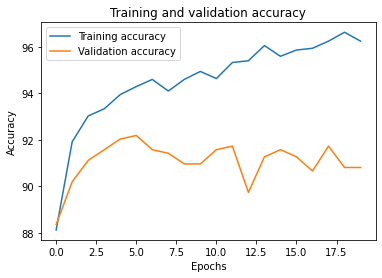

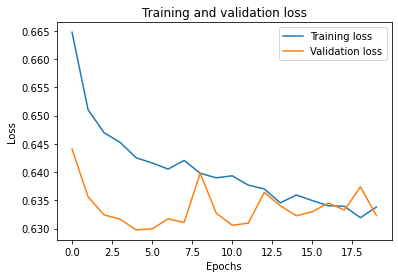

acc %
90.81163859111791
total INCORRECT total examples in val number of correct examples in val
60 653 593
Confusion Matrix:
 [[9607  113]
 [1052 2288]]
True Positives: 2288
False Positives: 113
True Negatives: 9607
False Negatives: 1052
Precision: 0.9529
Recall: 0.6850
training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch

In [ ]:
epochs = 30
trainNew(everything_trn_loader,everyval_nosdpt_loader,'all-iid-aug.pt',model,criterion, epochs)
epochs = 20
trainNew(cocotrain_loader,cocoval_loader, 'coco-iid-aug.pt',model,criterion, epochs)
trainNew(oiltrain_loader,oilval_loader, 'oil-iid-aug.pt',model,criterion, epochs)
trainNew(cashtrain_loader,cashval_loader, 'cashew-iid-aug.pt',model,criterion, epochs)
trainNew(ftrain_loader,fval_loader, 'Fagan-iid-aug.pt',model,criterion, epochs)
trainNew(full_trn_loader,val_nosdpt_loader,'manual-iid-aug.pt',model,criterion, epochs)

# SatMAE ++ 

# LOO Dist Shifts

Training perturbation with features:
[<__main__.PairedImageDataset object at 0x7fb638065670>, <__main__.PairedImageDataset object at 0x7fb821ce82b0>, <__main__.PairedImageDataset object at 0x7fb63e033940>, <__main__.PairedImageDataset object at 0x7fb63d2c4f10>, <__main__.PairedImageDataset object at 0x7fb7cc1004f0>]
training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to N

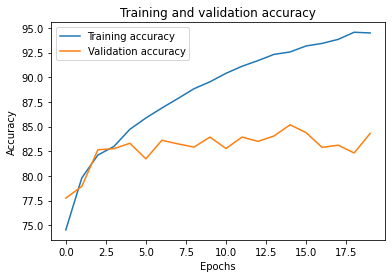

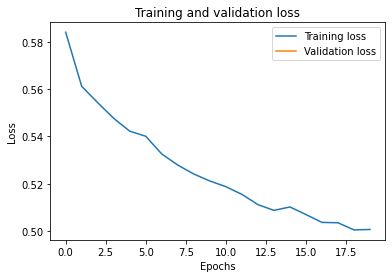

acc %
84.31056701030928
total INCORRECT total examples in val number of correct examples in val
974 6208 5234
Confusion Matrix:
 [[54242  7977]
 [13292 48649]]
True Positives: 48649
False Positives: 7977
True Negatives: 54242
False Negatives: 13292
Precision: 0.8591
Recall: 0.7854
Training perturbation with features:
[<__main__.PairedImageDataset object at 0x7fb638065670>, <__main__.PairedImageDataset object at 0x7fb821ce82b0>, <__main__.PairedImageDataset object at 0x7fb63e033940>, <__main__.PairedImageDataset object at 0x7fb63d2c4f10>, <__main__.PairedImageDataset object at 0x7fb639490d00>]


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

KeyboardInterrupt: 

In [24]:
subs = [ 
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, ftrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, oiltrain_dataset, ftrain_dataset], 
    [full_trn_ds, cocotrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [full_trn_ds, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset]
]
subsv = [
    [val_nosdpt_ds, cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset],
    [val_nosdpt_ds, cocoval_dataset, cashval_dataset, civval_dataset, fval_dataset],
    [val_nosdpt_ds, cocoval_dataset, cashval_dataset, oilval_dataset, fval_dataset], 
    [val_nosdpt_ds, cashval_dataset, cashval_dataset, civval_dataset, fval_dataset],
    [cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset]
]
        
for i in range(len(subs)):
    sub = subs[i]
    subv = subsv[i]
    everything_trn_ds = sub[0].concatenate(sub[1:])
    everything_trn_loader = DataLoader(everything_trn_ds,batch_size=32,shuffle=True, drop_last=True)
    
    everyval_nosdpt_ds = subv[0].concatenate(subv[1:])
    everyval_nosdpt_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    print('Training perturbation with features:')
    print(sub)
    trainNew(everything_trn_loader, everyval_nosdpt_loader,'loo.pt')
    
    del everything_trn_ds, everyval_nosdpt_ds, everything_trn_loader, everyval_nosdpt_loader

Training perturbation with features:
training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to Na

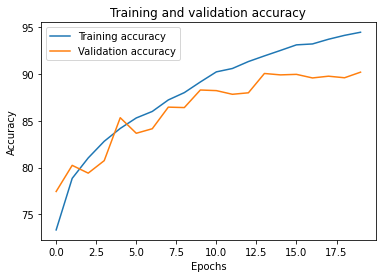

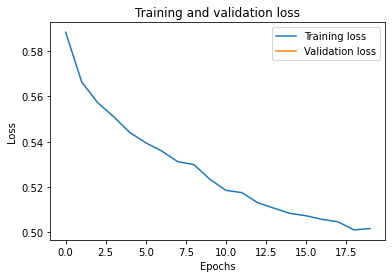

acc %
90.17723880597015
total INCORRECT total examples in val number of correct examples in val
1053 10720 9667
Confusion Matrix:
 [[113265   8910]
 [ 20571  71654]]
True Positives: 71654
False Positives: 8910
True Negatives: 113265
False Negatives: 20571
Precision: 0.8894
Recall: 0.7769
Epoch 20/20, Val Loss: nan, Val Acc: 90.20
Confusion Matrix:
 [[5698  638]
 [ 413 3971]]
True Positives: 3971
False Positives: 638
True Negatives: 5698
False Negatives: 413
Precision: 0.8616
Recall: 0.9058
Epoch 20/20, Val Loss: 0.6005, Val Acc: 85.54
Confusion Matrix:
 [[773 129]
 [ 70 404]]
True Positives: 404
False Positives: 129
True Negatives: 773
False Negatives: 70
Precision: 0.7580
Recall: 0.8523
Epoch 20/20, Val Loss: 0.7541, Val Acc: 86.32
Confusion Matrix:
 [[279   9]
 [ 36   5]]
True Positives: 5
False Positives: 9
True Negatives: 279
False Negatives: 36
Precision: 0.3571
Recall: 0.1220
Epoch 20/20, Val Loss: nan, Val Acc: 82.52
Confusion Matrix:
 [[1196  253]
 [ 257 1212]]
True Positives: 

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

KeyboardInterrupt: 

In [27]:
subs = [ 
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, ftrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, oiltrain_dataset, ftrain_dataset], 
    [full_trn_ds, cocotrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [full_trn_ds, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset]
]

        
for i in range(len(subs)):
    sub = subs[i]
    subv = subsv[i]
    everything_trn_ds = sub[0].concatenate(sub[1:])
    everything_trn_loader = DataLoader(everything_trn_ds,batch_size=32,shuffle=True, drop_last=True)
    
    everyval_nosdpt_ds = subv[0].concatenate(subv[1:])
    everyval_nosdpt_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    print('Training perturbation with features:')

    del everyval_nosdpt_ds,everyval_nosdpt_loader
    #print(sub)
    everyval_nosdpt_ds = full_trn_ds.concatenate([cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset])
    everyval_nosdpt_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    trainNew(everything_trn_loader, everyval_nosdpt_loader,'loo.pt', [everyval_nosdpt_loader, val_nosdpt_loader, cocoval_loader, cashval_loader, civval_loader, oilval_loader, fval_loader])
    
    del everything_trn_ds, everyval_nosdpt_ds, everything_trn_loader, everyval_nosdpt_loader

In [ ]:
subs = [ 
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, ftrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, oiltrain_dataset, ftrain_dataset], 
    [full_trn_ds, cocotrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [full_trn_ds, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset]
]

        
for i in range(len(subs)):
    sub = subs[i]
    subv = subsv[i]
    everything_trn_ds = sub[0].concatenate(sub[1:])
    everything_trn_loader = DataLoader(everything_trn_ds,batch_size=32,shuffle=True, drop_last=True)
    
    everyval_nosdpt_ds = subv[0].concatenate(subv[1:])
    everyval_nosdpt_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    print('Training perturbation with features:')

    del everyval_nosdpt_loader
    #print(sub)
    everyval_nosdpt_ds = full_trn_ds.concatenate([cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset])
    everyval_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    del everyval_nosdpt_ds
    trainNew(everything_trn_loader, everyval_loader,'loo.pt', [everyval_nosdpt_loader, val_nosdpt_loader, cocoval_loader, cashval_loader, civval_loader, oilval_loader, fval_loader])
    
    del everything_trn_ds, everyval_nosdpt_ds, everything_trn_loader, everyval_nosdpt_loader, everyval_loader

Training perturbation with features:
[<__main__.PairedImageDataset object at 0x7faa1491b670>, <__main__.PairedImageDataset object at 0x7faa19d00430>, <__main__.PairedImageDataset object at 0x7faba89b3790>, <__main__.PairedImageDataset object at 0x7faa19b70b50>, <__main__.PairedImageDataset object at 0x7faa14d497c0>]
training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to N

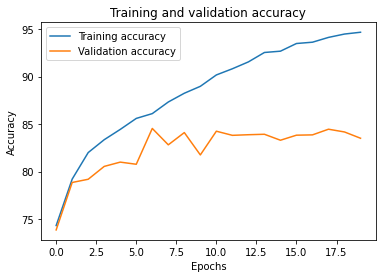

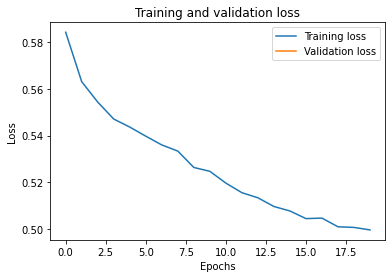

acc %
83.50515463917526
total INCORRECT total examples in val number of correct examples in val
1024 6208 5184
Confusion Matrix:
 [[56087  6127]
 [15827 46119]]
True Positives: 46119
False Positives: 6127
True Negatives: 56087
False Negatives: 15827
Precision: 0.8827
Recall: 0.7445


NameError: name 'epoch' is not defined

In [25]:
subs = [ 
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, ftrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, oiltrain_dataset, ftrain_dataset], 
    [full_trn_ds, cocotrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [full_trn_ds, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset]
]
subsv = [
    [val_nosdpt_ds, cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset],
    [val_nosdpt_ds, cocoval_dataset, cashval_dataset, civval_dataset, fval_dataset],
    [val_nosdpt_ds, cocoval_dataset, cashval_dataset, oilval_dataset, fval_dataset], 
    [val_nosdpt_ds, cashval_dataset, cashval_dataset, civval_dataset, fval_dataset],
    [cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset]
]
        
for i in range(len(subs)):
    sub = subs[i]
    subv = subsv[i]
    everything_trn_ds = sub[0].concatenate(sub[1:])
    everything_trn_loader = DataLoader(everything_trn_ds,batch_size=32,shuffle=True, drop_last=True)
    
    everyval_nosdpt_ds = subv[0].concatenate(subv[1:])
    everyval_nosdpt_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    print('Training perturbation with features:')
    print(sub)
    model, all_predictions, all_labels = trainNew(everything_trn_loader, everyval_nosdpt_loader,'loo.pt')
    
    del everything_trn_ds, everyval_nosdpt_ds, everything_trn_loader, everyval_nosdpt_loader

    everyval_nosdpt_ds = full_trn_ds.concatenate([cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset])
    everyval_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    del everyval_nosdpt_ds
    test_loaders = [everyval_loader, val_nosdpt_loader, cocoval_loader, cashval_loader, civval_loader, oilval_loader, fval_loader]
    
    
    for tl in test_loaders:
        print(tl)
         # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in tl:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = inputsCHM.to("cuda")
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                outputs = model(inputsCHM, inputs, s1)
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
    
        print(f'Val Loss: {val_loss/len(tl.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )
        print_cm(all_labels,all_predictions)
    del everyval_loader

In [26]:

    for tl in test_loaders:
        print(tl)
         # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in tl:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = inputsCHM.to("cuda")
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                outputs = model(inputsCHM, inputs, s1)
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
    
        print(f'Val Loss: {val_loss/len(tl.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )
        print_cm(all_labels,all_predictions)
    del everyval_loader

Val Loss: nan, Val Acc: 89.79
Confusion Matrix:
 [[67638  7648]
 [16494 53820]]
True Positives: 53820
False Positives: 7648
True Negatives: 67638
False Negatives: 16494
Precision: 0.8756
Recall: 0.7654
Val Loss: 0.6085, Val Acc: 83.43
Confusion Matrix:
 [[68416  7805]
 [16565 54190]]
True Positives: 54190
False Positives: 7805
True Negatives: 68416
False Negatives: 16565
Precision: 0.8741
Recall: 0.7659
Val Loss: 0.7285, Val Acc: 90.27
Confusion Matrix:
 [[68709  7815]
 [16587 54194]]
True Positives: 54194
False Positives: 7815
True Negatives: 68709
False Negatives: 16587
Precision: 0.8740
Recall: 0.7657
Val Loss: nan, Val Acc: 81.87
Confusion Matrix:
 [[69936  8118]
 [16813 55356]]
True Positives: 55356
False Positives: 8118
True Negatives: 69936
False Negatives: 16813
Precision: 0.8721
Recall: 0.7670
Val Loss: 0.3527, Val Acc: 89.15
Confusion Matrix:
 [[69936  8218]
 [16813 56178]]
True Positives: 56178
False Positives: 8218
True Negatives: 69936
False Negatives: 16813
Precision: 0.8

Training perturbation with features:
[<__main__.PairedImageDataset object at 0x7fdf3eb7e970>, <__main__.PairedImageDataset object at 0x7fdf5ee14520>, <__main__.PairedImageDataset object at 0x7fdfe57a2f70>, <__main__.PairedImageDataset object at 0x7fe0f879cd30>, <__main__.PairedImageDataset object at 0x7fdfe8409b20>]
training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to N

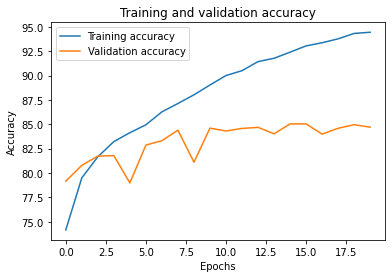

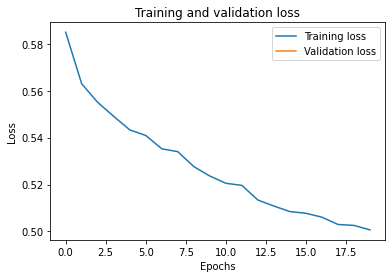

acc %
84.6971649484536
total INCORRECT total examples in val number of correct examples in val
950 6208 5258
Confusion Matrix:
 [[54995  7211]
 [13612 48342]]
True Positives: 48342
False Positives: 7211
True Negatives: 54995
False Negatives: 13612
Precision: 0.8702
Recall: 0.7803
Val Loss: nan, Val Acc: 90.38
Confusion Matrix:
 [[5730  651]
 [ 380 3959]]
True Positives: 3959
False Positives: 651
True Negatives: 5730
False Negatives: 380
Precision: 0.8588
Recall: 0.9124
Val Loss: 0.5995, Val Acc: 84.96
Confusion Matrix:
 [[781 145]
 [ 62 388]]
True Positives: 388
False Positives: 145
True Negatives: 781
False Negatives: 62
Precision: 0.7280
Recall: 0.8622
Val Loss: 0.7256, Val Acc: 90.88
Confusion Matrix:
 [[295  10]
 [ 20   4]]
True Positives: 4
False Positives: 10
True Negatives: 295
False Negatives: 20
Precision: 0.2857
Recall: 0.1667
Val Loss: nan, Val Acc: 82.86
Confusion Matrix:
 [[1172  219]
 [ 281 1246]]
True Positives: 1246
False Positives: 219
True Negatives: 1172
False Negati

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

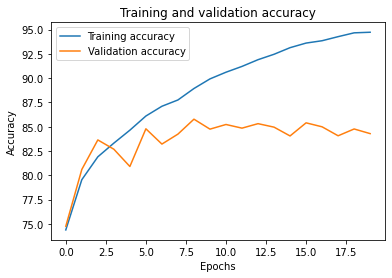

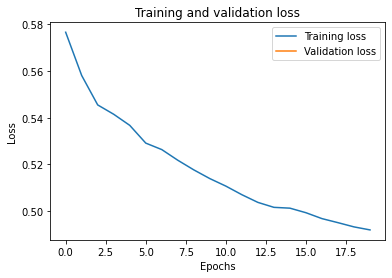

acc %
84.2896174863388
total INCORRECT total examples in val number of correct examples in val
920 5856 4936
Confusion Matrix:
 [[51922  6056]
 [13077 46065]]
True Positives: 46065
False Positives: 6056
True Negatives: 51922
False Negatives: 13077
Precision: 0.8838
Recall: 0.7789
Val Loss: nan, Val Acc: 89.51
Confusion Matrix:
 [[5836  845]
 [ 279 3760]]
True Positives: 3760
False Positives: 845
True Negatives: 5836
False Negatives: 279
Precision: 0.8165
Recall: 0.9309
Val Loss: 0.6001, Val Acc: 84.38
Confusion Matrix:
 [[807 172]
 [ 43 354]]
True Positives: 354
False Positives: 172
True Negatives: 807
False Negatives: 43
Precision: 0.6730
Recall: 0.8917
Val Loss: 0.7163, Val Acc: 92.40
Confusion Matrix:
 [[301  11]
 [ 14   3]]
True Positives: 3
False Positives: 11
True Negatives: 301
False Negatives: 14
Precision: 0.2143
Recall: 0.1765
Val Loss: nan, Val Acc: 81.01
Confusion Matrix:
 [[1255  356]
 [ 198 1109]]
True Positives: 1109
False Positives: 356
True Negatives: 1255
False Negati

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

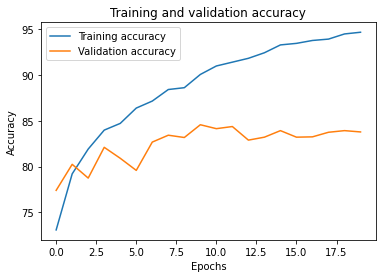

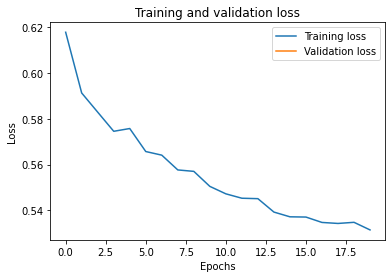

acc %
83.78571428571429
total INCORRECT total examples in val number of correct examples in val
908 5600 4692
Confusion Matrix:
 [[62296  5517]
 [14119 30068]]
True Positives: 30068
False Positives: 5517
True Negatives: 62296
False Negatives: 14119
Precision: 0.8450
Recall: 0.6805
Val Loss: nan, Val Acc: 88.06
Confusion Matrix:
 [[5845 1020]
 [ 260 3595]]
True Positives: 3595
False Positives: 1020
True Negatives: 5845
False Negatives: 260
Precision: 0.7790
Recall: 0.9326
Val Loss: 0.6051, Val Acc: 83.21
Confusion Matrix:
 [[796 178]
 [ 53 349]]
True Positives: 349
False Positives: 178
True Negatives: 796
False Negatives: 53
Precision: 0.6622
Recall: 0.8682
Val Loss: 0.7290, Val Acc: 89.97
Confusion Matrix:
 [[295  13]
 [ 20   1]]
True Positives: 1
False Positives: 13
True Negatives: 295
False Negatives: 20
Precision: 0.0714
Recall: 0.0476
Val Loss: nan, Val Acc: 82.80
Confusion Matrix:
 [[1244  293]
 [ 209 1172]]
True Positives: 1172
False Positives: 293
True Negatives: 1244
False Nega

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.6046, Train Acc: 81.5972, Val Loss: nan, Val Acc: 62.81
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.5911, Train Acc: 84.4236, Val Loss: nan, Val Acc: 65.25
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.5831, Train Acc: 86.3681, Val Loss: nan, Val Acc: 66.48
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.5767, Train Acc: 87.6250, Val Loss: nan, Val Acc: 67.60
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.5734, Train Acc: 88.4306, Val Loss: nan, Val Acc: 68.47
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.5686, Train Acc: 89.6181, Val Loss: nan, Val Acc: 66.71
Skipping batch due to NaNs.
Epoch 7/20, Train Loss: 0.5647, Train Acc: 90.7014, Val Loss: nan, Val Acc: 70.16
Skipping batch due to NaNs.
Epoch 8/20, Train Loss: 0.5623, Train Acc: 91.1181, Val Loss: nan, Val Acc: 69.89
Skipping batch due to NaNs.
Epoch 9/20, Train Loss: 0.5593, Train Acc: 91.7639, Val Loss: nan, Val Acc: 6

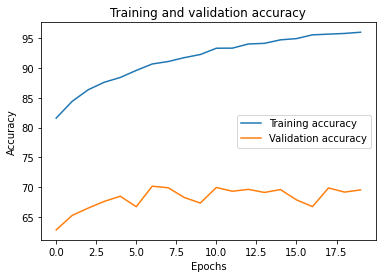

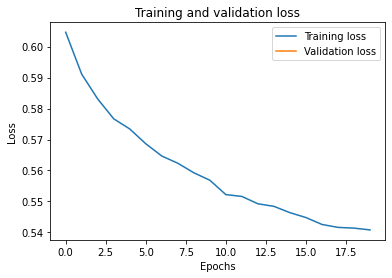

acc %
69.53125
total INCORRECT total examples in val number of correct examples in val
2574 8448 5874
Confusion Matrix:
 [[60780 20006]
 [33752 54422]]
True Positives: 54422
False Positives: 20006
True Negatives: 60780
False Negatives: 33752
Precision: 0.7312
Recall: 0.6172
Val Loss: nan, Val Acc: 85.46
Confusion Matrix:
 [[5448  899]
 [ 660 3713]]
True Positives: 3713
False Positives: 899
True Negatives: 5448
False Negatives: 660
Precision: 0.8051
Recall: 0.8491
Val Loss: 0.6087, Val Acc: 83.72
Confusion Matrix:
 [[787 155]
 [ 69 365]]
True Positives: 365
False Positives: 155
True Negatives: 787
False Negatives: 69
Precision: 0.7019
Recall: 0.8410
Val Loss: 0.7139, Val Acc: 93.01
Confusion Matrix:
 [[302  10]
 [ 13   4]]
True Positives: 4
False Positives: 10
True Negatives: 302
False Negatives: 13
Precision: 0.2857
Recall: 0.2353
Val Loss: nan, Val Acc: 60.76
Confusion Matrix:
 [[904 596]
 [549 869]]
True Positives: 869
False Positives: 596
True Negatives: 904
False Negatives: 549
Pre

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

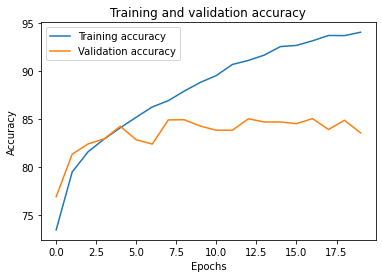

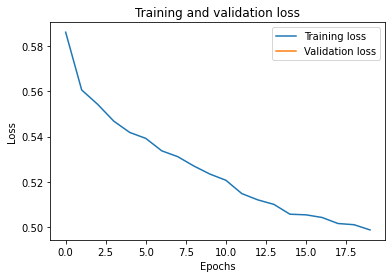

acc %
83.57421875
total INCORRECT total examples in val number of correct examples in val
841 5120 4279
Confusion Matrix:
 [[44356  6188]
 [10636 41220]]
True Positives: 41220
False Positives: 6188
True Negatives: 44356
False Negatives: 10636
Precision: 0.8695
Recall: 0.7949
Val Loss: nan, Val Acc: 89.97
Confusion Matrix:
 [[5794  759]
 [ 316 3851]]
True Positives: 3851
False Positives: 759
True Negatives: 5794
False Negatives: 316
Precision: 0.8354
Recall: 0.9242
Val Loss: 0.6089, Val Acc: 83.65
Confusion Matrix:
 [[769 144]
 [ 81 382]]
True Positives: 382
False Positives: 144
True Negatives: 769
False Negatives: 81
Precision: 0.7262
Recall: 0.8251
Val Loss: 0.7429, Val Acc: 88.45
Confusion Matrix:
 [[287  10]
 [ 28   4]]
True Positives: 4
False Positives: 10
True Negatives: 287
False Negatives: 28
Precision: 0.2857
Recall: 0.1250
Val Loss: nan, Val Acc: 80.91
Confusion Matrix:
 [[1245  349]
 [ 208 1116]]
True Positives: 1116
False Positives: 349
True Negatives: 1245
False Negatives: 

IndexError: list index out of range

In [54]:
subs = [ 
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, civtrain_dataset, ftrain_dataset],
    [full_trn_ds, cocotrain_dataset, cashtrain_dataset, oiltrain_dataset, ftrain_dataset], 
    [full_trn_ds, cocotrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [full_trn_ds, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset]
]
subsv = [
    [val_nosdpt_ds, cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset],
    [val_nosdpt_ds, cocoval_dataset, cashval_dataset, civval_dataset, fval_dataset],
    [val_nosdpt_ds, cocoval_dataset, cashval_dataset, oilval_dataset, fval_dataset], 
    [val_nosdpt_ds, cashval_dataset, cashval_dataset, civval_dataset, fval_dataset],
    [cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset]
]
        
for i in range(len(subs)):
    sub = subs[i]
    subv = subsv[i]
    everything_trn_ds = sub[0].concatenate(sub[1:])
    everything_trn_loader = DataLoader(everything_trn_ds,batch_size=32,shuffle=True, drop_last=True)
    
    everyval_nosdpt_ds = subv[0].concatenate(subv[1:])
    everyval_nosdpt_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    print('Training perturbation with features:')
    print(sub)
    model = trainNew(everything_trn_loader, everyval_nosdpt_loader,'loo.pt')
    
    del everything_trn_ds, everyval_nosdpt_ds, everything_trn_loader, everyval_nosdpt_loader

    everyval_nosdpt_ds = full_trn_ds.concatenate([cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset])
    everyval_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    del everyval_nosdpt_ds
    test_loaders = [everyval_loader, val_nosdpt_loader, cocoval_loader, cashval_loader, civval_loader, oilval_loader, fval_loader]
    
    
    for tl in test_loaders:
        print(tl)
         # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in tl:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = inputsCHM.to("cuda")
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                outputs = model(inputsCHM, inputs, s1)
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
    
        print(f'Val Loss: {val_loss/len(tl.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )
        print_cm(all_labels,all_predictions)
    del everyval_loader

Training perturbation with features:
[<__main__.PairedImageDataset object at 0x7fdf3eb7e970>, <__main__.PairedImageDataset object at 0x7fdf5ee14520>, <__main__.PairedImageDataset object at 0x7fe0f879cd30>, <__main__.PairedImageDataset object at 0x7fdfe8409b20>, <__main__.PairedImageDataset object at 0x7fdfbddb33a0>]


/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Epoch 1/20, Train Loss: 0.6064, Train Acc: 80.8958, Val Loss: 0.5835, Val Acc: 83.31
Skipping batch due to NaNs.
Epoch 2/20, Train Loss: 0.5903, Train Acc: 84.5208, Val Loss: 0.5782, Val Acc: 83.79
Skipping batch due to NaNs.
Epoch 3/20, Train Loss: 0.5820, Train Acc: 86.4722, Val Loss: 0.5812, Val Acc: 83.37
Skipping batch due to NaNs.
Epoch 4/20, Train Loss: 0.5783, Train Acc: 87.4583, Val Loss: 0.5752, Val Acc: 84.77
Skipping batch due to NaNs.
Epoch 5/20, Train Loss: 0.5729, Train Acc: 88.5486, Val Loss: 0.5724, Val Acc: 86.24
Skipping batch due to NaNs.
Epoch 6/20, Train Loss: 0.5704, Train Acc: 89.1597, Val Loss: 0.5692, Val Acc: 86.47
Skipping batch due to NaNs.
Epoch 7/20, Train Loss: 0.5669, Train Acc: 89.9306, Val Loss: 0.5719, Val Acc: 84.65
Skipping batch due to NaNs.
Epoch 8/20, Train Loss: 0.5627, Train Acc: 90.8542, Val Loss: 0.5705, Val Acc: 86.08
Skipping batch due to NaNs.
Epoch 9/20, Train Loss: 0.5603, Train Acc: 91.5486, V

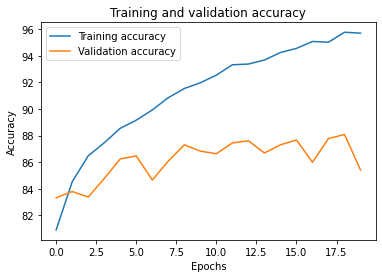

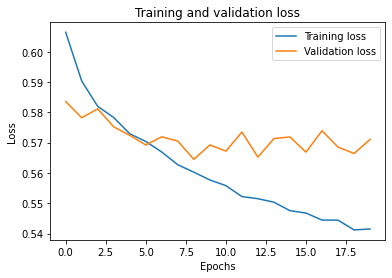

acc %
85.40736607142857
total INCORRECT total examples in val number of correct examples in val
523 3584 3061
Confusion Matrix:
 [[36464  2092]
 [ 7820 25304]]
True Positives: 25304
False Positives: 2092
True Negatives: 36464
False Negatives: 7820
Precision: 0.9236
Recall: 0.7639
Val Loss: nan, Val Acc: 82.60
Confusion Matrix:
 [[5785 1540]
 [ 325 3070]]
True Positives: 3070
False Positives: 1540
True Negatives: 5785
False Negatives: 325
Precision: 0.6659
Recall: 0.9043
Val Loss: 0.6011, Val Acc: 83.28
Confusion Matrix:
 [[816 200]
 [ 30 330]]
True Positives: 330
False Positives: 200
True Negatives: 816
False Negatives: 30
Precision: 0.6226
Recall: 0.9167
Val Loss: 0.7087, Val Acc: 93.01
Confusion Matrix:
 [[305  13]
 [ 10   1]]
True Positives: 1
False Positives: 13
True Negatives: 305
False Negatives: 10
Precision: 0.0714
Recall: 0.0909
Val Loss: nan, Val Acc: 54.69
Confusion Matrix:
 [[1173 1042]
 [ 280  423]]
True Positives: 423
False Positives: 1042
True Negatives: 1173
False Negat

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

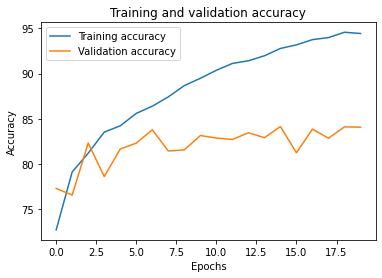

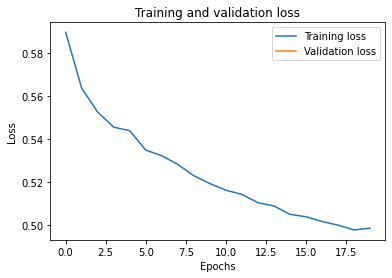

acc %
84.06723484848484
total INCORRECT total examples in val number of correct examples in val
1346 8448 7102
Confusion Matrix:
 [[70094 10679]
 [19662 68525]]
True Positives: 68525
False Positives: 10679
True Negatives: 70094
False Negatives: 19662
Precision: 0.8652
Recall: 0.7770
Val Loss: nan, Val Acc: 90.22
Confusion Matrix:
 [[5746  683]
 [ 365 3926]]
True Positives: 3926
False Positives: 683
True Negatives: 5746
False Negatives: 365
Precision: 0.8518
Recall: 0.9149
Val Loss: 0.6086, Val Acc: 82.70
Confusion Matrix:
 [[792 185]
 [ 53 346]]
True Positives: 346
False Positives: 185
True Negatives: 792
False Negatives: 53
Precision: 0.6516
Recall: 0.8672
Val Loss: 0.7247, Val Acc: 90.58
Confusion Matrix:
 [[295  11]
 [ 20   3]]
True Positives: 3
False Positives: 11
True Negatives: 295
False Negatives: 20
Precision: 0.2143
Recall: 0.1304
Val Loss: nan, Val Acc: 82.83
Confusion Matrix:
 [[1170  218]
 [ 283 1247]]
True Positives: 1247
False Positives: 218
True Negatives: 1170
False Neg

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipping batch due to NaNs.
Skipp

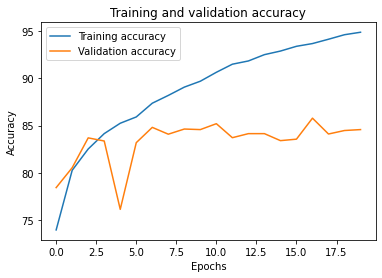

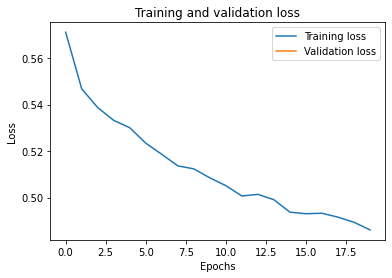

acc %
84.5703125
total INCORRECT total examples in val number of correct examples in val
790 5120 4330
Confusion Matrix:
 [[43987  6568]
 [10510 41335]]
True Positives: 41335
False Positives: 6568
True Negatives: 43987
False Negatives: 10510
Precision: 0.8629
Recall: 0.7973
Val Loss: nan, Val Acc: 76.90
Confusion Matrix:
 [[5001 1373]
 [1103 3243]]
True Positives: 3243
False Positives: 1373
True Negatives: 5001
False Negatives: 1103
Precision: 0.7026
Recall: 0.7462
Val Loss: 0.6714, Val Acc: 69.99
Confusion Matrix:
 [[678 246]
 [167 285]]
True Positives: 285
False Positives: 246
True Negatives: 678
False Negatives: 167
Precision: 0.5367
Recall: 0.6305
Val Loss: 0.7185, Val Acc: 91.49
Confusion Matrix:
 [[299  12]
 [ 16   2]]
True Positives: 2
False Positives: 12
True Negatives: 299
False Negatives: 16
Precision: 0.1429
Recall: 0.1111
Val Loss: nan, Val Acc: 81.15
Confusion Matrix:
 [[1098  195]
 [ 355 1270]]
True Positives: 1270
False Positives: 195
True Negatives: 1098
False Negatives

In [55]:
subs = [ 
    [full_trn_ds, cocotrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [full_trn_ds, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset],
    [cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset]
]
subsv = [
    [val_nosdpt_ds, cocoval_dataset, civval_dataset, oilval_dataset, fval_dataset],
    [val_nosdpt_ds, cashval_dataset, cashval_dataset, civval_dataset, fval_dataset],
    [cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset]
]
        
for i in range(len(subs)):
    sub = subs[i]
    subv = subsv[i]
    everything_trn_ds = sub[0].concatenate(sub[1:])
    everything_trn_loader = DataLoader(everything_trn_ds,batch_size=32,shuffle=True, drop_last=True)
    
    everyval_nosdpt_ds = subv[0].concatenate(subv[1:])
    everyval_nosdpt_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    print('Training perturbation with features:')
    print(sub)
    model = trainNew(everything_trn_loader, everyval_nosdpt_loader,'loo.pt')
    
    del everything_trn_ds, everyval_nosdpt_ds, everything_trn_loader, everyval_nosdpt_loader

    everyval_nosdpt_ds = full_trn_ds.concatenate([cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset])
    everyval_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    del everyval_nosdpt_ds
    test_loaders = [everyval_loader, val_nosdpt_loader, cocoval_loader, cashval_loader, civval_loader, oilval_loader, fval_loader]
    
    
    for tl in test_loaders:
        print(tl)
         # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            
            for inputs, inputsCHM, s1, labs, paths in tl:
    
                inputs= inputs.to("cuda")
                
                inputsCHM = inputsCHM.to("cuda")
                labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
                s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

                has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
                # Filter inputs to exclude those with NaNs
                has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        
                inputs = inputs[~has_nan_anywhere]
                inputsCHM = inputsCHM[~has_nan_anywhere]
                labs = labs[~has_nan_anywhere]
                
                outputs = model(inputsCHM, inputs, s1)
                loss = criterion(outputs, labs.float())
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += labs.size(0)
                correct += (predicted == labs).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
    
        print(f'Val Loss: {val_loss/len(tl.dataset):.4f}, '
              f'Val Acc: {(correct/total)*100:.2f}' )
        print_cm(all_labels,all_predictions)
    del everyval_loader

In [ ]:
#FULL MODEL
everything_trn_ds = full_trn_ds.concatenate([cocotrain_dataset, cashtrain_dataset, civtrain_dataset, oiltrain_dataset, ftrain_dataset])
everything_trn_loader = DataLoader(everything_trn_ds,batch_size=32,shuffle=True, drop_last=True)

everyval_nosdpt_ds = full_trn_ds.concatenate([cocoval_dataset, cashval_dataset, civval_dataset, oilval_dataset, fval_dataset])
everyval_loader = DataLoader(everyval_nosdpt_ds,batch_size=32,shuffle=True,drop_last=True)
    
model = trainNew(everything_trn_loader, everyval_loader,'loo.pt')
del everyval_nosdpt_ds, everyval_loader, everthing_trn_ds, everything_trn_loader

# Manual Model Training

training start
Epoch 20/20, Val Loss: 0.5729, Val Acc: 55.26
Epoch 1/20, Train Loss: 0.5363, Train Acc: 81.9286, Val Loss: 0.4430, Val Acc: 87.44
Epoch 2/20, Train Loss: 0.5035, Train Acc: 88.8571, Val Loss: 0.4385, Val Acc: 88.24
Epoch 3/20, Train Loss: 0.4924, Train Acc: 91.0000, Val Loss: 0.4413, Val Acc: 89.85
Epoch 4/20, Train Loss: 0.4850, Train Acc: 92.3929, Val Loss: 0.4493, Val Acc: 86.48
Epoch 5/20, Train Loss: 0.4764, Train Acc: 94.4464, Val Loss: 0.4345, Val Acc: 90.15
Epoch 6/20, Train Loss: 0.4720, Train Acc: 95.3571, Val Loss: 0.4359, Val Acc: 89.16
Epoch 7/20, Train Loss: 0.4675, Train Acc: 96.3750, Val Loss: 0.4327, Val Acc: 90.49
Epoch 8/20, Train Loss: 0.4648, Train Acc: 96.9286, Val Loss: 0.4411, Val Acc: 89.49
Epoch 9/20, Train Loss: 0.4623, Train Acc: 97.3393, Val Loss: 0.4331, Val Acc: 90.36
Epoch 10/20, Train Loss: 0.4605, Train Acc: 97.6964, Val Loss: 0.4313, Val Acc: 90.98
Epoch 11/20, Train Loss: 0.4587, Train Acc: 98.2500, Val Loss: 0.4462, Val Acc: 88.65
Ep

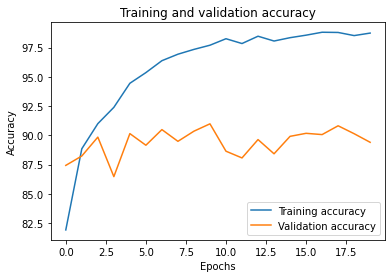

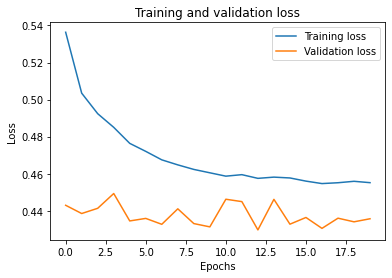

acc %
89.40783986655546
total INCORRECT total examples in val number of correct examples in val
127 1199 1072
Confusion Matrix:
 [[ 7992  1754]
 [ 1325 14112]]
True Positives: 14112
False Positives: 1754
True Negatives: 7992
False Negatives: 1325
Precision: 0.8894
Recall: 0.9142
east
acc %
89.03225806451613
total INCORRECT total examples in val number of correct examples in val
34 310 276
val loss
0.5328758734546296
Confusion Matrix:
 [[ 87  20]
 [ 14 189]]
True Positives: 189
False Positives: 20
True Negatives: 87
False Negatives: 14
Precision: 0.9043
Recall: 0.9310
# of prior shifted examples east 0
central
acc %
91.43835616438356
total INCORRECT total examples in val number of correct examples in val
25 292 267
val loss
0.4817935358988096
Confusion Matrix:
 [[ 72  20]
 [  5 195]]
True Positives: 195
False Positives: 20
True Negatives: 72
False Negatives: 5
Precision: 0.9070
Recall: 0.9750
# of prior shifted examples central 0
west
acc %
88.4472049689441
total INCORRECT total example

TypeError: forward() missing 1 required positional argument: 'tabular_features'

In [58]:
#############
#### TRIMODAL
##############
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

###############################
###############################
#########DISTRIBUTION SHIFT TRN FULL
###############################
###############################
#MEAN INTERPOLATION MODEL 
print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []
all_predictions = []
all_labels = []

criterion = nn.BCEWithLogitsLoss()
# Train the model

# Validate the model
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_nosdpt_loader:

        inputs= inputs.to("cuda")
        inputsCHM = inputsCHM.to("cuda")
        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
        s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

        has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
        # Filter inputs to exclude those with NaNs
        has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)

        inputs = inputs[~has_nan_anywhere]
        inputsCHM = inputsCHM[~has_nan_anywhere]
        labs = labs[~has_nan_anywhere]
        
        outputs = model(inputsCHM, inputs, s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    #val_acc_list.append(correct/total * 100)
    #val_loss_list.append(val_loss / len(val_loadere.dataset))
    print(f'Epoch {epoch+1}/{num_epochs}, '
          #f'Train Loss: {train_loss/len(train_loadere.dataset):.4f}, '
          #f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_nosdpt_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )


num_epochs = 20
for epoch in range(num_epochs):

    model.train()
    correct = 0
    total = 0
    train_loss = 0.0

    for inputs, inputsCHM, s1, labs, paths in full_trn_loader:
        #print(inputs.shape) #32,4,40,40
        #print(inputs)

        inputs = inputs.to("cuda")
        inputsCHM = inputsCHM.to("cuda")
        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
        s1 = s1.to(device).float()
        

        # Calculate mean of non-NaN values in each channel
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
            #if mask.sum() > 0:
            #    print("Inputs after interpolation:")
            #    print(channel_data)
            # Check for NaNs in inputs
        if torch.isnan(inputs).any():
            raise ValueError("NaNs found in inputs after interpolation")
    
        # Check for NaNs in inputsCHM and labs
        if torch.isnan(inputsCHM).any():
            raise ValueError("NaNs found in inputsCHM")
        if torch.isnan(labs).any():
            raise ValueError("NaNs found in labs")
        
        #inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)

        optimizer.zero_grad()
        outputs = model(inputsCHM,inputs,s1)
        if torch.isnan(outputs).any():
            print(f"Inputs: {inputs[0][0]}")
            #print(f"InputsCHM: {inputsCHM}")
            print(f"Model outputs: {outputs}")
            raise ValueError("NaNs found in model outputs")

        loss = criterion(outputs, labs.float())
        if torch.isnan(loss).any():
            raise ValueError("NaNs found in loss")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(full_trn_loader.dataset))

    if epoch == 19: 
        torch.save(model.state_dict(), 'resnet-trimodal-FULLtrain.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        
        for inputs, inputsCHM, s1, labs, paths in val_nosdpt_loader:

            inputs= inputs.to("cuda")
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

            has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
            # Filter inputs to exclude those with NaNs
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            inputsCHM = inputsCHM[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            
            outputs = model(inputsCHM, inputs, s1)
            loss = criterion(outputs, labs.float())
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_nosdpt_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(full_trn_loader.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_nosdpt_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )

plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions)


p_orch_src = .55
p_for_src = .45

p_orch_e = .34
p_for_e = .66

p_orch_c = .31
p_for_c = .69

p_orch_w = .58
p_for_w = .42

p_orch_sdpt = .58
p_for_sdpt = .42


print('east')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loadere:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_e / p_for_src) / ( outputs * (p_for_e / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_e / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples east', priored) 

print('central')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderc:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_c / p_for_src) / ( outputs * (p_for_c / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_c / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples central', priored) 
    
print('west')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderw:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2


        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderw.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples west', priored) 



In [64]:

print('JUST sdpt')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in sdpt_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(sdpt_loader.dataset))
    print_cm(all_predictions,all_labels)
   
print('cashew')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in cashtrain_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(cashtrain_loader.dataset))
    print_cm(all_predictions,all_labels)


print('CIV mango')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in civtrain_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(civtrain_loader.dataset))
    print_cm(all_predictions,all_labels)
    


JUST sdpt
acc %
39.822024471635146
total INCORRECT total examples in val number of correct examples in val
541 899 358
val loss
nan
Confusion Matrix:
 [[358 541]
 [  0   0]]
True Positives: 0
False Positives: 541
True Negatives: 358
False Negatives: 0
Precision: 0.0000
Recall: nan
cashew


/tmp/ipykernel_32699/2222487850.py:57: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)


acc %
57.78036742528106
total INCORRECT total examples in val number of correct examples in val
6159 14588 8429
val loss
nan
Confusion Matrix:
 [[2504 4779]
 [1380 5925]]
True Positives: 5925
False Positives: 4779
True Negatives: 2504
False Negatives: 1380
Precision: 0.5535
Recall: 0.8111
CIV mango
acc %
69.76996527777779
total INCORRECT total examples in val number of correct examples in val
1393 4608 3215
val loss
0.8779171448614862
Confusion Matrix:
 [[3215 1393]
 [   0    0]]
True Positives: 0
False Positives: 1393
True Negatives: 3215
False Negatives: 0
Precision: 0.0000
Recall: nan


/tmp/ipykernel_32699/2222487850.py:57: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)


In [70]:

print('Descals Coco')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in cocotrain_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(cocotrain_loader.dataset))
    print_cm(all_predictions,all_labels)




Descals Coco
acc %
89.63414634146342
total INCORRECT total examples in val number of correct examples in val
136 1312 1176
val loss
0.3736942926558053
Confusion Matrix:
 [[  16   39]
 [  97 1160]]
True Positives: 1160
False Positives: 39
True Negatives: 16
False Negatives: 97
Precision: 0.9675
Recall: 0.9228


In [75]:

print('Descals Oil')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in oiltrain_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(oiltrain_loader.dataset))
    print_cm(all_predictions,all_labels)




Descals Oil
acc %
84.0674071237074
total INCORRECT total examples in val number of correct examples in val
416 2611 2195
val loss
0.4633016516905733
Confusion Matrix:
 [[ 339  179]
 [ 237 1856]]
True Positives: 1856
False Positives: 179
True Negatives: 339
False Negatives: 237
Precision: 0.9120
Recall: 0.8868


# E/C/W Regional Models

/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start
Epoch 20/20, Val Loss: 0.6663, Val Acc: 30.03
Epoch 1/20, Train Loss: 0.5399, Train Acc: 80.7910, Val Loss: 0.5149, Val Acc: 83.17
Epoch 2/20, Train Loss: 0.4776, Train Acc: 93.3818, Val Loss: 0.5081, Val Acc: 85.48
Epoch 3/20, Train Loss: 0.4634, Train Acc: 96.4487, Val Loss: 0.5074, Val Acc: 86.47
Epoch 4/20, Train Loss: 0.4564, Train Acc: 97.4173, Val Loss: 0.4920, Val Acc: 88.78
Epoch 5/20, Train Loss: 0.4508, Train Acc: 98.5472, Val Loss: 0.5319, Val Acc: 82.84
Epoch 6/20, Train Loss: 0.4503, Train Acc: 98.7086, Val Loss: 0.4964, Val Acc: 88.45
Epoch 7/20, Train Loss: 0.4467, Train Acc: 99.5157, Val Loss: 0.4898, Val Acc: 87.13
Epoch 8/20, Train Loss: 0.4467, Train Acc: 99.3543, Val Loss: 0.4996, Val Acc: 87.13
Epoch 9/20, Train Loss: 0.4467, Train Acc: 99.3543, Val Loss: 0.5015, Val Acc: 87.13
Epoch 10/20, Train Loss: 0.4478, Train Acc: 99.1929, Val Loss: 0.4955, Val Acc: 89.11
Epoch 11/20, Train Loss: 0.4494, Train Acc: 98.3858, Val Loss: 0.5014, Val Acc: 85.81
Ep

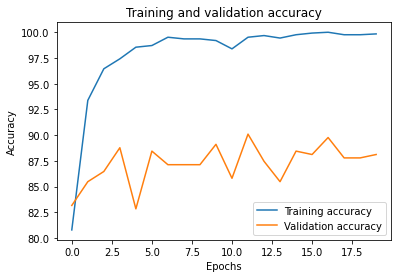

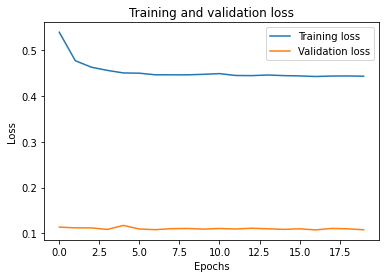

acc %
88.11881188118812
total INCORRECT total examples in val number of correct examples in val
36 303 267
Confusion Matrix:
 [[1729  518]
 [ 468 3648]]
True Positives: 3648
False Positives: 518
True Negatives: 1729
False Negatives: 468
Precision: 0.8757
Recall: 0.8863
east
acc %
88.38709677419355
total INCORRECT total examples in val number of correct examples in val
36 310 274
val loss
0.5265197500790635
Confusion Matrix:
 [[ 94  13]
 [ 23 180]]
True Positives: 180
False Positives: 13
True Negatives: 94
False Negatives: 23
Precision: 0.9326
Recall: 0.8867
# of prior shifted examples east 0
central
acc %
73.97260273972603
total INCORRECT total examples in val number of correct examples in val
76 292 216
val loss
0.5900451761402495
Confusion Matrix:
 [[ 18  74]
 [  2 198]]
True Positives: 198
False Positives: 74
True Negatives: 18
False Negatives: 2
Precision: 0.7279
Recall: 0.9900
# of prior shifted examples central 0
west
acc %
71.80124223602485
total INCORRECT total examples in val 

In [82]:
#############
#### TRIMODAL
##############
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

###############################
###############################
#########DISTRIBUTION SHIFT TRN FULL
###############################
###############################
#MEAN INTERPOLATION MODEL 
print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []
all_predictions = []
all_labels = []

criterion = nn.BCEWithLogitsLoss()
# Train the model

# Validate the model
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loadere:

        inputs= inputs.to("cuda")
        inputsCHM = inputsCHM.to("cuda")
        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
        s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

        has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
        # Filter inputs to exclude those with NaNs
        has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)

        inputs = inputs[~has_nan_anywhere]
        inputsCHM = inputsCHM[~has_nan_anywhere]
        labs = labs[~has_nan_anywhere]
        
        outputs = model(inputsCHM, inputs, s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    #val_acc_list.append(correct/total * 100)
    #val_loss_list.append(val_loss / len(val_loadere.dataset))
    print(f'Epoch {epoch+1}/{num_epochs}, '
          #f'Train Loss: {train_loss/len(train_loadere.dataset):.4f}, '
          #f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_loadere.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )


num_epochs = 20
for epoch in range(num_epochs):

    model.train()
    correct = 0
    total = 0
    train_loss = 0.0

    for inputs, inputsCHM, s1, labs, paths in train_loadere:
        #print(inputs.shape) #32,4,40,40
        #print(inputs)

        inputs = inputs.to("cuda")
        inputsCHM = inputsCHM.to("cuda")
        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
        s1 = s1.to(device).float()
        

        # Calculate mean of non-NaN values in each channel
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
            #if mask.sum() > 0:
            #    print("Inputs after interpolation:")
            #    print(channel_data)
            # Check for NaNs in inputs
        if torch.isnan(inputs).any():
            raise ValueError("NaNs found in inputs after interpolation")
    
        # Check for NaNs in inputsCHM and labs
        if torch.isnan(inputsCHM).any():
            raise ValueError("NaNs found in inputsCHM")
        if torch.isnan(labs).any():
            raise ValueError("NaNs found in labs")
        
        #inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)

        optimizer.zero_grad()
        outputs = model(inputsCHM,inputs,s1)
        if torch.isnan(outputs).any():
            print(f"Inputs: {inputs[0][0]}")
            #print(f"InputsCHM: {inputsCHM}")
            print(f"Model outputs: {outputs}")
            raise ValueError("NaNs found in model outputs")

        loss = criterion(outputs, labs.float())
        if torch.isnan(loss).any():
            raise ValueError("NaNs found in loss")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loadere.dataset))

    if epoch == 19: 
        torch.save(model.state_dict(), 'resnet-trimodal-EASTtrain.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        
        for inputs, inputsCHM, s1, labs, paths in val_loadere:

            inputs= inputs.to("cuda")
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

            has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
            # Filter inputs to exclude those with NaNs
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            inputsCHM = inputsCHM[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            
            outputs = model(inputsCHM, inputs, s1)
            loss = criterion(outputs, labs.float())
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_nosdpt_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loadere.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_loadere.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )

plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions)


p_orch_src = .55
p_for_src = .45

p_orch_e = .34
p_for_e = .66

p_orch_c = .31
p_for_c = .69

p_orch_w = .58
p_for_w = .42

p_orch_sdpt = .58
p_for_sdpt = .42


print('east')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loadere:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_e / p_for_src) / ( outputs * (p_for_e / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_e / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples east', priored) 

print('central')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderc:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_c / p_for_src) / ( outputs * (p_for_c / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_c / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples central', priored) 
    
print('west')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderw:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2


        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderw.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples west', priored) 

print('full no sdpt')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_nosdpt_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2


        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_nosdpt_loader.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples west', priored) 



training start
Epoch 1/20, Val Loss: 0.5647, Val Acc: 42.62
Epoch 1/20, Train Loss: 0.5475, Train Acc: 80.6341, Val Loss: 0.4433, Val Acc: 83.41
Epoch 2/20, Train Loss: 0.5082, Train Acc: 89.9285, Val Loss: 0.4344, Val Acc: 88.58
Epoch 3/20, Train Loss: 0.4991, Train Acc: 92.6018, Val Loss: 0.4372, Val Acc: 86.00
Epoch 4/20, Train Loss: 0.4872, Train Acc: 94.6845, Val Loss: 0.4295, Val Acc: 89.19
Epoch 5/20, Train Loss: 0.4837, Train Acc: 95.4616, Val Loss: 0.4328, Val Acc: 87.21
Epoch 6/20, Train Loss: 0.4789, Train Acc: 96.5185, Val Loss: 0.4224, Val Acc: 91.63
Epoch 7/20, Train Loss: 0.4753, Train Acc: 96.9537, Val Loss: 0.4310, Val Acc: 90.41
Epoch 8/20, Train Loss: 0.4720, Train Acc: 97.6065, Val Loss: 0.4224, Val Acc: 91.32
Epoch 9/20, Train Loss: 0.4692, Train Acc: 98.2282, Val Loss: 0.4352, Val Acc: 89.80
Epoch 10/20, Train Loss: 0.4675, Train Acc: 98.5390, Val Loss: 0.4228, Val Acc: 91.32
Epoch 11/20, Train Loss: 0.4676, Train Acc: 98.4147, Val Loss: 0.4304, Val Acc: 90.26
Epo

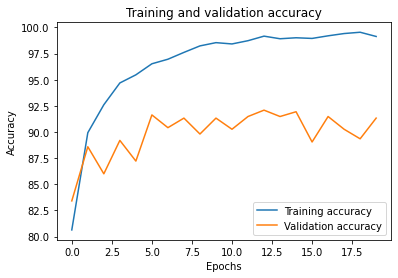

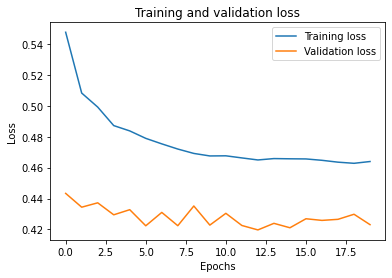

acc %
91.32420091324201
total INCORRECT total examples in val number of correct examples in val
57 657 600
Confusion Matrix:
 [[5279  601]
 [1106 6811]]
True Positives: 6811
False Positives: 601
True Negatives: 5279
False Negatives: 1106
Precision: 0.9189
Recall: 0.8603
east
acc %
76.12903225806451
total INCORRECT total examples in val number of correct examples in val
74 310 236
val loss
0.592711867534951
Confusion Matrix:
 [[ 83  24]
 [ 50 153]]
True Positives: 153
False Positives: 24
True Negatives: 83
False Negatives: 50
Precision: 0.8644
Recall: 0.7537
# of prior shifted examples east 0
central
acc %
86.64383561643835
total INCORRECT total examples in val number of correct examples in val
39 292 253
val loss
0.5082660007150206
Confusion Matrix:
 [[ 61  31]
 [  8 192]]
True Positives: 192
False Positives: 31
True Negatives: 61
False Negatives: 8
Precision: 0.8610
Recall: 0.9600
# of prior shifted examples central 0
west
acc %
90.93167701863354
total INCORRECT total examples in val 

In [81]:
#############
#### TRIMODAL WEST
##############
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

###############################
###############################
#########DISTRIBUTION SHIFT TRN FULL
###############################
###############################
#MEAN INTERPOLATION MODEL 
print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []
all_predictions = []
all_labels = []

criterion = nn.BCEWithLogitsLoss()
# Train the model

# Validate the model
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderw:

        inputs= inputs.to("cuda")
        inputsCHM = inputsCHM.to("cuda")
        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
        s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

        has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
        # Filter inputs to exclude those with NaNs
        has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)

        inputs = inputs[~has_nan_anywhere]
        inputsCHM = inputsCHM[~has_nan_anywhere]
        labs = labs[~has_nan_anywhere]
        
        outputs = model(inputsCHM, inputs, s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    #val_acc_list.append(correct/total * 100)
    #val_loss_list.append(val_loss / len(val_loadere.dataset))
    print(f'Epoch {epoch+1}/{num_epochs}, '
          #f'Train Loss: {train_loss/len(train_loadere.dataset):.4f}, '
          #f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_loaderw.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )


num_epochs = 20
for epoch in range(num_epochs):

    model.train()
    correct = 0
    total = 0
    train_loss = 0.0

    for inputs, inputsCHM, s1, labs, paths in train_loaderw:
        #print(inputs.shape) #32,4,40,40
        #print(inputs)

        inputs = inputs.to("cuda")
        inputsCHM = inputsCHM.to("cuda")
        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
        s1 = s1.to(device).float()
        

        # Calculate mean of non-NaN values in each channel
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
            #if mask.sum() > 0:
            #    print("Inputs after interpolation:")
            #    print(channel_data)
            # Check for NaNs in inputs
        if torch.isnan(inputs).any():
            raise ValueError("NaNs found in inputs after interpolation")
    
        # Check for NaNs in inputsCHM and labs
        if torch.isnan(inputsCHM).any():
            raise ValueError("NaNs found in inputsCHM")
        if torch.isnan(labs).any():
            raise ValueError("NaNs found in labs")
        
        #inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)

        optimizer.zero_grad()
        outputs = model(inputsCHM,inputs,s1)
        if torch.isnan(outputs).any():
            print(f"Inputs: {inputs[0][0]}")
            #print(f"InputsCHM: {inputsCHM}")
            print(f"Model outputs: {outputs}")
            raise ValueError("NaNs found in model outputs")

        loss = criterion(outputs, labs.float())
        if torch.isnan(loss).any():
            raise ValueError("NaNs found in loss")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loaderw.dataset))

    if epoch == 19: 
        torch.save(model.state_dict(), 'resnet-trimodal-WESTtrain.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        
        for inputs, inputsCHM, s1, labs, paths in val_loaderw:

            inputs= inputs.to("cuda")
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

            has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
            # Filter inputs to exclude those with NaNs
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            inputsCHM = inputsCHM[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            
            outputs = model(inputsCHM, inputs, s1)
            loss = criterion(outputs, labs.float())
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loaderw.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loaderw.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_loaderw.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )

plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions)


p_orch_src = .55
p_for_src = .45

p_orch_e = .34
p_for_e = .66

p_orch_c = .31
p_for_c = .69

p_orch_w = .58
p_for_w = .42

p_orch_sdpt = .58
p_for_sdpt = .42


print('east')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loadere:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_e / p_for_src) / ( outputs * (p_for_e / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_e / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples east', priored) 

print('central')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderc:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_c / p_for_src) / ( outputs * (p_for_c / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_c / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples central', priored) 
    
print('west')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderw:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2


        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderw.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples west', priored) 

print('full no sdpt')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_nosdpt_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2


        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_nosdpt_loader.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples west', priored) 

print('OIL')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in oiltrain_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2


        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(oiltrain_loader.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples oil', priored) 

print('coconut')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in cocotrain_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2


        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(cocotrain_loader.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples west', priored) 


training start
Epoch 1/20, Val Loss: 0.6141, Val Acc: 23.22
Epoch 1/20, Train Loss: 0.5113, Train Acc: 82.3479, Val Loss: 0.4658, Val Acc: 85.02
Epoch 2/20, Train Loss: 0.4766, Train Acc: 90.0600, Val Loss: 0.4401, Val Acc: 90.26
Epoch 3/20, Train Loss: 0.4651, Train Acc: 92.8877, Val Loss: 0.4547, Val Acc: 88.01
Epoch 4/20, Train Loss: 0.4576, Train Acc: 95.1157, Val Loss: 0.4496, Val Acc: 89.89
Epoch 5/20, Train Loss: 0.4553, Train Acc: 95.2014, Val Loss: 0.4394, Val Acc: 92.13
Epoch 6/20, Train Loss: 0.4474, Train Acc: 97.2579, Val Loss: 0.4480, Val Acc: 88.39
Epoch 7/20, Train Loss: 0.4482, Train Acc: 97.2579, Val Loss: 0.4668, Val Acc: 85.02
Epoch 8/20, Train Loss: 0.4502, Train Acc: 96.7438, Val Loss: 0.4454, Val Acc: 90.64
Epoch 9/20, Train Loss: 0.4445, Train Acc: 97.4293, Val Loss: 0.4566, Val Acc: 87.64
Epoch 10/20, Train Loss: 0.4411, Train Acc: 98.2005, Val Loss: 0.4434, Val Acc: 91.01
Epoch 11/20, Train Loss: 0.4390, Train Acc: 98.7147, Val Loss: 0.4383, Val Acc: 91.01
Epo

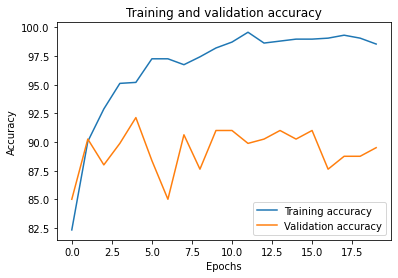

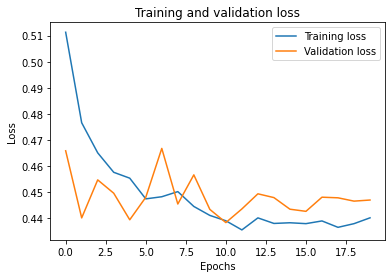

acc %
89.51310861423221
total INCORRECT total examples in val number of correct examples in val
28 267 239
Confusion Matrix:
 [[1535  313]
 [ 463 3296]]
True Positives: 3296
False Positives: 313
True Negatives: 1535
False Negatives: 463
Precision: 0.9133
Recall: 0.8768
east
acc %
74.51612903225806
total INCORRECT total examples in val number of correct examples in val
79 310 231
val loss
0.577654972468337
Confusion Matrix:
 [[ 97  10]
 [ 69 134]]
True Positives: 134
False Positives: 10
True Negatives: 97
False Negatives: 69
Precision: 0.9306
Recall: 0.6601
# of prior shifted examples east 0
central
acc %
90.06849315068493
total INCORRECT total examples in val number of correct examples in val
29 292 263
val loss
0.4832883942617129
Confusion Matrix:
 [[ 77  15]
 [ 14 186]]
True Positives: 186
False Positives: 15
True Negatives: 77
False Negatives: 14
Precision: 0.9254
Recall: 0.9300
# of prior shifted examples central 0
west
acc %
70.31055900621118
total INCORRECT total examples in val 

In [84]:
#############
#### TRIMODAL CENTRAL
##############
model = MultiResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

###############################
###############################
#########DISTRIBUTION SHIFT TRN FULL
###############################
###############################
#MEAN INTERPOLATION MODEL 
print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []
all_predictions = []
all_labels = []

criterion = nn.BCEWithLogitsLoss()
# Train the model

# Validate the model
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderc:

        inputs= inputs.to("cuda")
        inputsCHM = inputsCHM.to("cuda")
        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
        s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

        has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
        # Filter inputs to exclude those with NaNs
        has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)

        inputs = inputs[~has_nan_anywhere]
        inputsCHM = inputsCHM[~has_nan_anywhere]
        labs = labs[~has_nan_anywhere]
        
        outputs = model(inputsCHM, inputs, s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    #val_acc_list.append(correct/total * 100)
    #val_loss_list.append(val_loss / len(val_loadere.dataset))
    print(f'Epoch {epoch+1}/{num_epochs}, '
          #f'Train Loss: {train_loss/len(train_loadere.dataset):.4f}, '
          #f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_loaderc.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )


num_epochs = 20
for epoch in range(num_epochs):

    model.train()
    correct = 0
    total = 0
    train_loss = 0.0

    for inputs, inputsCHM, s1, labs, paths in train_loaderc:
        #print(inputs.shape) #32,4,40,40
        #print(inputs)

        inputs = inputs.to("cuda")
        inputsCHM = inputsCHM.to("cuda")
        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
        s1 = s1.to(device).float()
        

        # Calculate mean of non-NaN values in each channel
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
            #if mask.sum() > 0:
            #    print("Inputs after interpolation:")
            #    print(channel_data)
            # Check for NaNs in inputs
        if torch.isnan(inputs).any():
            raise ValueError("NaNs found in inputs after interpolation")
    
        # Check for NaNs in inputsCHM and labs
        if torch.isnan(inputsCHM).any():
            raise ValueError("NaNs found in inputsCHM")
        if torch.isnan(labs).any():
            raise ValueError("NaNs found in labs")
        
        #inputs = torch.where(torch.isnan(inputs), torch.zeros_like(inputs), inputs)

        optimizer.zero_grad()
        outputs = model(inputsCHM,inputs,s1)
        if torch.isnan(outputs).any():
            print(f"Inputs: {inputs[0][0]}")
            #print(f"InputsCHM: {inputsCHM}")
            print(f"Model outputs: {outputs}")
            raise ValueError("NaNs found in model outputs")

        loss = criterion(outputs, labs.float())
        if torch.isnan(loss).any():
            raise ValueError("NaNs found in loss")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loaderc.dataset))

    if epoch == 19: 
        torch.save(model.state_dict(), 'resnet-trimodal-CENTRALtrain.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        
        for inputs, inputsCHM, s1, labs, paths in val_loaderc:

            inputs= inputs.to("cuda")
            inputsCHM = inputsCHM.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            s1 = s1.to(device).float()            #normalized_inputs = normalizer(inputs)

            has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
            # Filter inputs to exclude those with NaNs
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            inputsCHM = inputsCHM[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            
            outputs = model(inputsCHM, inputs, s1)
            loss = criterion(outputs, labs.float())
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loaderc.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loaderc.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_loaderc.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )

plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions)


p_orch_src = .55
p_for_src = .45

p_orch_e = .34
p_for_e = .66

p_orch_c = .31
p_for_c = .69

p_orch_w = .58
p_for_w = .42

p_orch_sdpt = .58
p_for_sdpt = .42


print('east')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loadere:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_e / p_for_src) / ( outputs * (p_for_e / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_e / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples east', priored) 

print('central')
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderc:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_c / p_for_src) / ( outputs * (p_for_c / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_c / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples central', priored) 
    
print('west')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_loaderw:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2


        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderw.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples west', priored) 

print('full no sdpt')

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, s1, labs, paths in val_nosdpt_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        s1 = s1.to(device).float()
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM, inputs,s1)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)

        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

#        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
#                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2


        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_nosdpt_loader.dataset))
    print_cm(all_predictions,all_labels)
    print('# of prior shifted examples west', priored) 



# IDK

In [55]:
import torch.nn.init as init

class S2ResNet(nn.Module):
    def __init__(self):
        super(S2ResNet, self).__init__()
                
        self.resnet_24band = models.resnet18(pretrained=True)
        self.resnet_24band.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_features24 = self.resnet_24band.fc.in_features
        
        self.fc = nn.Linear(num_features24, 1)  # Adjust the output size as needed
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

        #self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
        
    def forward(self, x_24band):
        

        #print('before forward pass: ')
        #print(x_24band)
        # Forward pass through the 24-band ResNet
        x_24band = self.resnet_24band.conv1(x_24band)
        #print('after conv1 forward pass: ')
        #print(x_24band[0])
        x_24band = self.resnet_24band.bn1(x_24band)
        #print('after bn')
        #print(x_24band[0])
        x_24band = self.resnet_24band.relu(x_24band)
        #print('after relu')
        #print(x_24band[0])
        x_24band = self.resnet_24band.maxpool(x_24band)
        #print('x_24 after maxpool')
        #print(x_24band[0])
        x_24band = self.resnet_24band.layer1(x_24band)
        x_24band = self.resnet_24band.layer2(x_24band)
        x_24band = self.resnet_24band.layer3(x_24band)
        x_24band = self.resnet_24band.layer4(x_24band)
        #print('x_24 after layers')
        #print(x_24band[0])
        x_24band = self.resnet_24band.avgpool(x_24band)
        x_24band = torch.flatten(x_24band, 1)
        #print('sentinel2 at flatten')
        #print(x_24band[0])
        

        x_24band = self.fc(x_24band)
        x = self.sigmoid(x_24band)
        #print('x after clf head: ')
        #print(x)
        #print('after forward pass: ')
        #print(model.parameters())        
        return x

# Example usage
model = S2ResNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []
all_labels = []
all_predictions = []

model = S2ResNet()
model.to(device)
model.load_state_dict((torch.load('resnet-s2-v2.pt')))
model.eval()
criterion = nn.BCEWithLogitsLoss()
'''
# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for inputs, _, labs in full_trn_loader:
        inputs= inputs.to("cuda")
        labs = torch.Tensor(labs).unsqueeze(1).to("cuda")

        has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
        # Filter inputs to exclude those with NaNs
        has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)

        inputs = inputs[~has_nan_anywhere]
        labs = labs[~has_nan_anywhere]
        
        #print('inputs details:')
        #print(type(inputs))
        #print(inputs.shape)
        #print(inputs)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labs.float())
        #print(loss.item())
        #print(outputs)
        #print(labs.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(full_trn_loader.dataset))
    

    if epoch % 9 == 0: 
        torch.save(model.state_dict(), 'resnet-s2-v2.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, _, labs in full_val_loader:

            inputs= inputs.to("cuda")
            labs = torch.Tensor(labs).unsqueeze(1).to("cuda")
            
            has_nan = torch.isnan(inputs).any(dim=1)  # Check along batch dimension (assuming dim=0 is batch)
            # Filter inputs to exclude those with NaNs
            has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
    
            inputs = inputs[~has_nan_anywhere]
            labs = labs[~has_nan_anywhere]
            
            outputs = model(inputs)
            loss = criterion(outputs, labs.float())
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(full_val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(full_trn_loader.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(full_val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )

    #previously: leak-free resulted in overfitting by epoch 3 with a peak val acc ~80%. 
    
plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions)
    
'''


val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
priored = 0
with torch.no_grad():
    for inputs, inputsCHM, labs,paths in val_loadere:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputs)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        
        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

        outputs = outputs * (p_for_e / p_for_src) / ( outputs * (p_for_e / p_for_src) + 
                                                     (1 - outputs) * (p_orch_e / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2    
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loadere.dataset))
    print_cm(all_predictions,all_labels)
    print('priored east', priored)

priored = 0
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, labs,paths in val_loaderc:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)

        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputs)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        
        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

        outputs = outputs * (p_for_c / p_for_src) / ( outputs * (p_for_c / p_for_src) + 
                                                     (1 - outputs) * (p_orch_c / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2    
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)
    print('priored central', priored)



priored = 0
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, labs,paths in val_loaderw:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)

        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputs)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        
        #p1 = torch.count_nonzero((outputs > 0.5))
        pred1 = (outputs > 0.5).float()
        p1 = (pred1 == labs).sum().item()
        

        outputs = outputs * (p_for_w / p_for_src) / ( outputs * (p_for_w / p_for_src) + 
                                                     (1 - outputs) * (p_orch_w / p_orch_src) )
        #p2 = torch.count_nonzero((outputs > 0.5))
        #priored += abs(p1-p2)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        p2 = (predicted == labs).sum().item()
        correct += (predicted == labs).sum().item()
        priored += p1-p2    
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderw.dataset))
    print_cm(all_predictions,all_labels)
    print('priored west', priored)


val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, labs,paths in val_nosdpt_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        '''
        has_nan = torch.isnan(inputs).any(dim=1) 
        has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        inputs = inputs[~has_nan_anywhere]
        inputsCHM = inputsCHM[~has_nan_anywhere]
        labs = labs[~has_nan_anywhere]
        '''
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputs)
        loss = criterion(outputs, labs.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_nosdpt_loader.dataset))
    print_cm(all_predictions,all_labels)


training start
acc %
74.91694352159467
total INCORRECT total examples in val number of correct examples in val
151 602 451
val loss
0.558721457505939
Confusion Matrix:
 [[127  79]
 [ 72 324]]
True Positives: 324
False Positives: 79
True Negatives: 127
False Negatives: 72
Precision: 0.8040
Recall: 0.8182
priored east 2
acc %
79.1095890410959
total INCORRECT total examples in val number of correct examples in val
61 292 231
val loss
0.5463870727036098
Confusion Matrix:
 [[ 47  16]
 [ 45 184]]
True Positives: 184
False Positives: 16
True Negatives: 47
False Negatives: 45
Precision: 0.9200
Recall: 0.8035
priored central 0
acc %
54.02670111972437
total INCORRECT total examples in val number of correct examples in val
2135 4644 2509
val loss
0.8074141285934908
Confusion Matrix:
 [[ 762  194]
 [1941 1747]]
True Positives: 1747
False Positives: 194
True Negatives: 762
False Negatives: 1941
Precision: 0.9001
Recall: 0.4737
priored west -1
acc %
75.24916943521595
total INCORRECT total examples i

In [59]:
###########################################
#RESNETCHM ONLY
###########################################
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # Modify the first convolution layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # If you're using a different model, adjust the input layer accordingly

    def forward(self, x):
        return self.resnet(x)


# Create an instance of the custom ResNet model
model = CustomResNet()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []
all_predictions = []
all_labels = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for _, inputs,labs, paths in full_trn_loader:
        inputs= inputs.to("cuda")
        labs = torch.Tensor(labs).to("cuda")
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(full_trn_loader.dataset))

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for _,inputs, labs, paths in full_val_loader:
            inputs= inputs.to("cuda")
            labs = torch.Tensor(labs).to("cuda")
        
            outputs = model(inputs)
            loss = criterion(outputs, labs)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())

        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(full_val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(full_trn_loader.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(full_val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )

#plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions)

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, labs, paths in val_loadere:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).to(device)

        outputs = model(inputsCHM)
        loss = criterion(outputs, labs)
        val_loss += loss.item() * inputs.size(0)
        #predicted = (outputs > 0.5).float()
        _, predicted = torch.max(outputs, 1)
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loadere.dataset))
    print_cm(all_predictions,all_labels)


val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, labs,paths in val_loaderc:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).to(device)

        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM)
        loss = criterion(outputs, labs)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)#predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderc.dataset))
    print_cm(all_predictions,all_labels)



val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, labs,paths in val_loaderw:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).to(device)
        '''
        has_nan = torch.isnan(inputs).any(dim=1) 
        has_nan_anywhere = torch.any(torch.any(has_nan, dim=1), dim=1)
        inputs = inputs[~has_nan_anywhere]
        inputsCHM = inputsCHM[~has_nan_anywhere]
        labs = labs[~has_nan_anywhere]
        '''
        
        for c in range(inputs.size(1)):  # Assuming the channel dimension is 1
            channel_data = inputs[:, c, :, :]
            mask = torch.isnan(channel_data)
            #if mask.sum() > 0:
            #    print("Inputs before interpolation:")
            #    print(channel_data)            
            mean_val = torch.nanmean(channel_data, dim=0, keepdim=True)
            
            channel_data[mask] = mean_val.expand_as(channel_data)[mask]
            inputs[:, c, :, :] = channel_data
        
        outputs = model(inputsCHM)
        loss = criterion(outputs, labs)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1) #       predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_loaderw.dataset))
    print_cm(all_predictions,all_labels)



val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, labs,paths in val_nosdpt_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).unsqueeze(1).to(device)
        
        outputs = model(inputsCHM)
        loss = criterion(outputs, labs)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1) #predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_nosdpt_loader.dataset))
    print_cm(all_predictions,all_labels)

/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training start


ValueError: too many values to unpack (expected 3)

In [18]:

val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, inputsCHM, labs in val_nosdpt_loader:
    
        inputs= inputs.to(device)
        inputsCHM = inputsCHM.to(device)
        labs = torch.Tensor(labs).to(device)
        
        outputs = model(inputsCHM)
        loss = criterion(outputs, labs)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1) #predicted = (outputs > 0.5).float()
        total += labs.size(0)
#        print(predicted)
        correct += (predicted == labs).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labs.cpu().numpy())
    print('acc %')
    print(correct/total * 100)
    print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
    print(total-correct, total, correct)
    print('val loss')
    print(val_loss / len(val_nosdpt_loader.dataset))
    print_cm(all_predictions,all_labels)

acc %
86.57718120805369
total INCORRECT total examples in val number of correct examples in val
120 894 774
val loss
0.6696782780173641
Confusion Matrix:
 [[213  42]
 [ 78 561]]
True Positives: 561
False Positives: 42
True Negatives: 213
False Negatives: 78
Precision: 0.9303
Recall: 0.8779


In [40]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input channel = 1, Output channels = 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output channels = 64
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Flatten and connect to fully-connected layer
        self.fc2 = nn.Linear(128, 1)  # Output layer with 1 neuron for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply ReLU activation and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply ReLU activation and pooling again
        x = torch.flatten(x, 1)  # Flatten
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.sigmoid(self.fc2(x))  # Apply sigmoid activation for binary output
        return x

# Create an instance of the CNN
model = SimpleCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for _,inputs, labs in full_trn_loader:
        inputs= inputs.to("cuda")
        labs = torch.Tensor(labs).to("cuda")
        
#        print('inputs type')
#        print(inputs.dtype)
        #inputs.byte()
#        print(inputs.dtype)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(full_trn_loader.dataset))

    if epoch % 9 == 0: 
        torch.save(model.state_dict(), 'cnn-FULL-chmonly.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for _,inputs, labs in full_val_loader:
            inputs= inputs.to("cuda")
            labs = torch.Tensor(labs).to("cuda")
        
            outputs = model(inputs)
            loss = criterion(outputs, labs)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())           
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(full_val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(full_trn_loader.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(full_val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )


plot_res(trn_acc_list,val_acc_list,trn_loss_list,val_loss_list,all_labels,all_predictions)


training start


../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [6,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [7,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [8,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [11,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [13,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [46]:
from functools import partial
import timm.models.vision_transformer
from pos_embed import get_2d_sincos_pos_embed


class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        # Added by Samar, need default pos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches ** .5),
                                            cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome


def vit_base_patch16(**kwargs):
    model = VisionTransformer(
        embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large_patch16(**kwargs):
    model = VisionTransformer(
        embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_huge_patch14(**kwargs):
    model = VisionTransformer(
        embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

In [ ]:
device = torch.device('cuda')

model = VisionTransformer()
model.to(device)
model.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
#model.load_pretrained('pretrain-vit-base-e199.pth')
#model = create_model('vit_base_patch16', pretrained=True)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []

def triplicate_channel(data):
  """
  Triplicates the channel dimension of a PyTorch tensor batch.

  Args:
    batch: A dictionary or tuple containing the data loaded by a DataLoader.
      Usually, the key 'data' holds the actual tensor batch.

  Returns:
    A dictionary or tuple with the same structure as the input, but with the 
    data tensor having its channel dimension triplicated.
  """
  # Assuming the data is in the key 'data' within the batch
  #data = batch['data']
  if len(data.shape) == 3:
    # Add a new dimension of size 1 for the missing channel
    data = data.unsqueeze(1)
    # Repeat the channel 3 times
    repeated_channel = data.repeat(1, 3, 1, 1)
  elif len(data.shape) == 4 and data.shape[1] == 1:
    # Existing single channel, repeat it 3 times
    repeated_channel = data.repeat(1, 3, 1, 1)
  else:
    # Already has 3 or more channels, no change needed
    repeated_channel = data
  #return {key: value for key, value in batch.items() if key != 'data'} | {'data': repeated_channel}
  return repeated_channel


# Train the model
num_epochs = 20
all_predictions = []
all_labels = []
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for _, inputs,labels in train_loader:
        inputs = triplicate_channel(inputs).to(device)
        labels = torch.Tensor(labels).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loader.dataset))

    
    if epoch % 9 == 0: 
        torch.save(model.state_dict(), 'vit-multimodal-v2.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for _, inputs, labels in val_loader:
            inputs = triplicate_channel(inputs).to(device)
            labels = torch.Tensor(labels).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}%')

#history = model.history()


import matplotlib.pyplot as plt

# Extract the training and validation accuracy from the model history
train_accuracy = trn_acc_list
val_accuracy = val_acc_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('SatMAE Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Extract the training and validation accuracy from the model history
train_losses = trn_loss_list
val_losses = val_loss_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('SatMAE Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Extract true positives, negatives, false positives, and negatives
tn, fp, fn, tp = cm.ravel()

# Calculate Precision, Recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)

# Print results (you can modify this for your needs)
print(f"Confusion Matrix:\n {cm}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print('acc %')
print(correct/total * 100)
print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
print(total-correct, total, correct)
print('val loss')
print(val_loss / len(val_loader.dataset))

Epoch 1/20, Train Loss: 0.7185, Val Loss: 0.7229, Val Acc: 37.69%
Epoch 2/20, Train Loss: 0.6835, Val Loss: 0.6701, Val Acc: 61.41%
Epoch 3/20, Train Loss: 0.6678, Val Loss: 0.6519, Val Acc: 63.97%
Epoch 4/20, Train Loss: 0.6588, Val Loss: 0.6514, Val Acc: 64.43%
Epoch 5/20, Train Loss: 0.6520, Val Loss: 0.6573, Val Acc: 62.87%
Epoch 6/20, Train Loss: 0.6500, Val Loss: 0.6418, Val Acc: 65.16%


In [12]:
print(len(images))
print(len(images2))

8209
4402


In [13]:

print(trn_acc_list)
print(val_acc_list)
print(trn_loss_list)
print(val_loss_list)

[80.0039651070579, 80.91593973037273, 81.65344964314036, 82.54758128469469, 83.49524187153054, 84.55987311657415, 86.02894528152261, 88.12053925455987, 90.43021411578113, 92.753766851705, 94.01665344964314, 95.21015067406819, 95.39056304520223, 96.5107057890563, 96.80610626486916, 95.92188739095955, 97.48810467882633, 97.5832672482157, 97.67644726407613, 97.78350515463917]
[73.880301228696, 75.18826793499802, 79.74633372968688, 80.02378121284185, 79.90487514863258, 80.42013476020611, 78.16091954022988, 77.60602457391994, 80.49940546967895, 80.93539437177962, 77.72493063812921, 79.23107411811336, 81.45065398335315, 81.0543004359889, 77.09076496234641, 81.45065398335315, 79.98414585810542, 79.23107411811336, 81.64883075703527, 80.42013476020611]
[0.4141066891441829, 0.3968534010256405, 0.38294556673134633, 0.3706312950975265, 0.35370013413922735, 0.3327956120047089, 0.3063672176057814, 0.2670450063190415, 0.2200828414578744, 0.17205400632356105, 0.14277900928819018, 0.11473462218972637, 

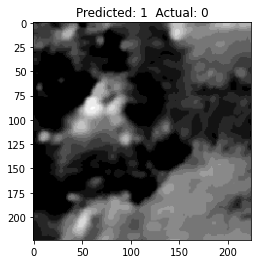

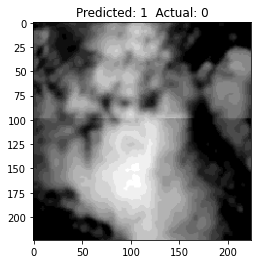

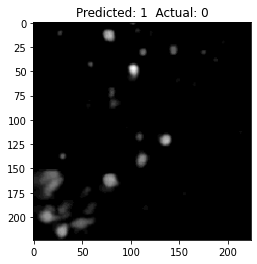

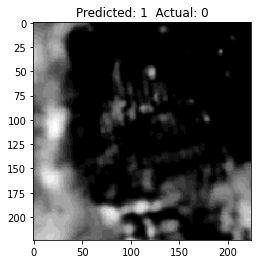

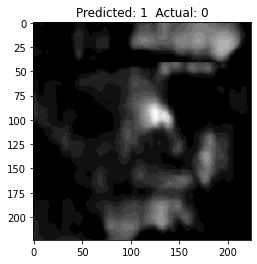

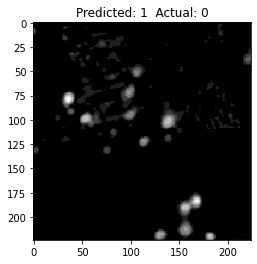

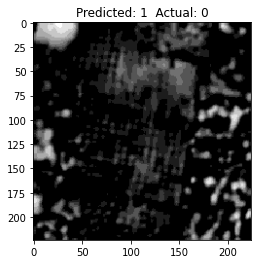

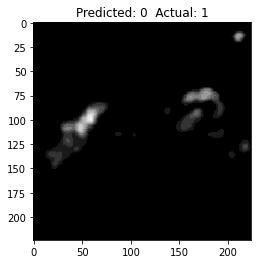

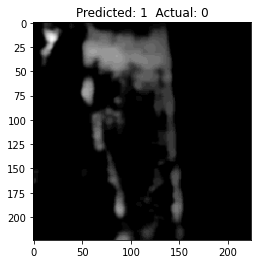

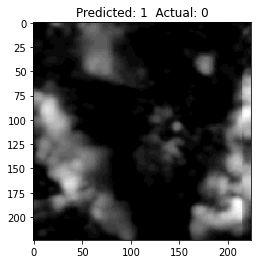

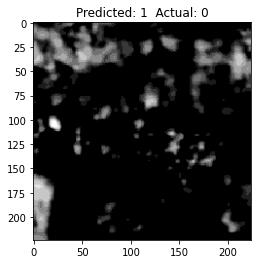

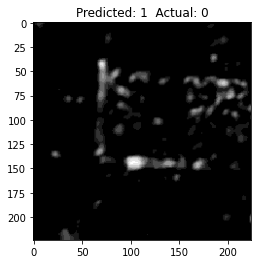

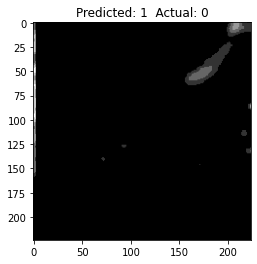

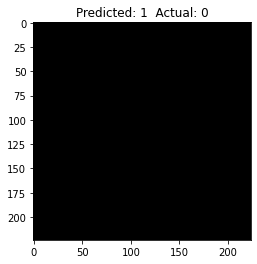

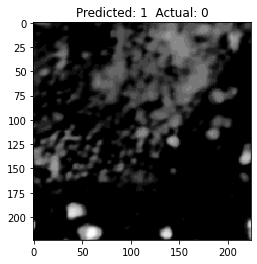

Confusion Matrix:
 [[1432  652]
 [ 230 1360]]
True Positives: 1360
False Positives: 652
True Negatives: 1432
False Negatives: 230
Precision: 0.6759
Recall: 0.8553
acc %
75.99346761023408
total INCORRECT total examples in val number of correct examples in val
882 3674 2792
val loss
0.9718233233051061


In [6]:
model.eval()
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  # Import for image display

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs= inputs.to("cuda")
        labels = torch.Tensor(labels).to("cuda")
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append predictions and labels for confusion matrix calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        misclassified_inds = (predicted != labels).nonzero(as_tuple=True)[0]
        for misclassified_ind in misclassified_inds:
            if misclassified_ind % 300 == 0:
                misclassified_image = inputs[misclassified_ind].cpu().squeeze()  # Get misclassified image
                misclassified_image = misclassified_image.numpy()
                
                plt.imshow(misclassified_image,cmap='gray')
                plt.title(f"Predicted: {predicted[misclassified_ind].item()}  Actual: {labels[misclassified_ind].item()}")
                plt.show()  # Display the misclassified image


# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Extract true positives, negatives, false positives, and negatives
tn, fp, fn, tp = cm.ravel()

# Calculate Precision, Recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)

# Print results (you can modify this for your needs)
print(f"Confusion Matrix:\n {cm}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print('acc %')
print(correct/total * 100)
print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
print(total-correct, total, correct)
print('val loss')
print(val_loss / len(val_loader.dataset))

In [8]:

from functools import partial

import torch
import torch.nn as nn

import timm.models.vision_transformer
from pos_embed import get_2d_sincos_pos_embed


class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        # Added by Samar, need default pos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches ** .5),
                                            cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome


def vit_base_patch16(**kwargs):
    model = VisionTransformer(
        embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large_patch16(**kwargs):
    model = VisionTransformer(
        embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_huge_patch14(**kwargs):
    model = VisionTransformer(
        embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

Epoch 1/20, Train Loss: 0.7391, Val Loss: 0.6966, Val Acc: 54.44%
Epoch 2/20, Train Loss: 0.6591, Val Loss: 0.6423, Val Acc: 63.47%
Epoch 3/20, Train Loss: 0.6466, Val Loss: 0.6477, Val Acc: 64.02%
Epoch 4/20, Train Loss: 0.6386, Val Loss: 0.6556, Val Acc: 62.71%
Epoch 5/20, Train Loss: 0.6435, Val Loss: 0.6520, Val Acc: 63.09%
Epoch 6/20, Train Loss: 0.6551, Val Loss: 0.6301, Val Acc: 65.19%
Epoch 7/20, Train Loss: 0.6402, Val Loss: 0.6361, Val Acc: 64.73%
Epoch 8/20, Train Loss: 0.6367, Val Loss: 0.6291, Val Acc: 64.37%
Epoch 9/20, Train Loss: 0.6275, Val Loss: 0.6405, Val Acc: 63.66%
Epoch 10/20, Train Loss: 0.6291, Val Loss: 0.6215, Val Acc: 64.94%
Epoch 11/20, Train Loss: 0.6229, Val Loss: 0.6271, Val Acc: 64.53%
Epoch 12/20, Train Loss: 0.6221, Val Loss: 0.6209, Val Acc: 64.43%
Epoch 13/20, Train Loss: 0.6242, Val Loss: 0.6323, Val Acc: 64.56%
Epoch 14/20, Train Loss: 0.6175, Val Loss: 0.6243, Val Acc: 65.02%
Epoch 15/20, Train Loss: 0.6190, Val Loss: 0.6332, Val Acc: 63.66%
Epoc

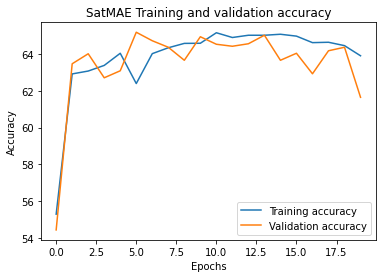

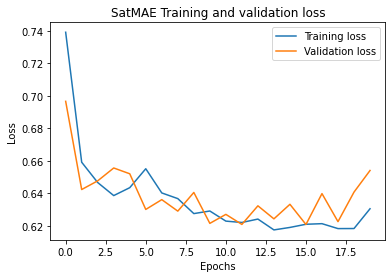

In [9]:
device = torch.device('cuda')

model = VisionTransformer()
model.to(device)
model.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
#model.load_pretrained('pretrain-vit-base-e199.pth')
#model = create_model('vit_base_patch16', pretrained=True)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []

def triplicate_channel(data):
  """
  Triplicates the channel dimension of a PyTorch tensor batch.

  Args:
    batch: A dictionary or tuple containing the data loaded by a DataLoader.
      Usually, the key 'data' holds the actual tensor batch.

  Returns:
    A dictionary or tuple with the same structure as the input, but with the 
    data tensor having its channel dimension triplicated.
  """
  # Assuming the data is in the key 'data' within the batch
  #data = batch['data']
  if len(data.shape) == 3:
    # Add a new dimension of size 1 for the missing channel
    data = data.unsqueeze(1)
    # Repeat the channel 3 times
    repeated_channel = data.repeat(1, 3, 1, 1)
  elif len(data.shape) == 4 and data.shape[1] == 1:
    # Existing single channel, repeat it 3 times
    repeated_channel = data.repeat(1, 3, 1, 1)
  else:
    # Already has 3 or more channels, no change needed
    repeated_channel = data
  #return {key: value for key, value in batch.items() if key != 'data'} | {'data': repeated_channel}
  return repeated_channel


# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = triplicate_channel(inputs).to(device)
        labels = torch.Tensor(labels).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loader.dataset))

    
    if epoch % 9 == 0: 
        torch.save(model.state_dict(), 'vit-unaugmented-pretrain.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = triplicate_channel(inputs).to(device)
            labels = torch.Tensor(labels).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}%')

#history = model.history()


import matplotlib.pyplot as plt

# Extract the training and validation accuracy from the model history
train_accuracy = trn_acc_list
val_accuracy = val_acc_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('SatMAE Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Extract the training and validation accuracy from the model history
train_losses = trn_loss_list
val_losses = val_loss_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('SatMAE Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
